In [2]:
'''Load Libs'''
import numpy as np
import pandas as pd
import os.path
from pathlib import Path
from collections import Counter
import random
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from time import time
import matplotlib.pyplot as plt

In [3]:
'''Load Data And Identify Classes'''
PathTrain =  os.getcwd() + "/data/train.csv"
PathTest =  os.getcwd() + "/data/test.csv"
DFTrain = pd.read_csv(PathTrain, header=None)
DFTest = pd.read_csv(PathTest, header=None)
totalClasses = len(Counter(DFTrain.iloc[:,-1]))

In [4]:
DTrain = DFTrain.iloc[:,:-1]
DTrain = np.c_[np.ones(len(DTrain)), DTrain]
LabelsTrain = np.array(DFTrain.iloc[:,-1])
DTest = DFTest.iloc[:,:-1]
DTest = np.c_[np.ones(len(DTest)), DTest]
LabelsTest = np.array(DFTest.iloc[:,-1])

In [5]:
'''One Hot Encoding for Train and Test Labels'''
oneHotTrainLables = np.zeros((len(DFTrain), totalClasses))

for i in range(len(DFTrain)):
    oneHotTrainLables[i][DFTrain.iloc[i, -1]] = 1

In [6]:
train_accuracy_list = np.zeros(5)
test_accuracy_list = np.zeros(5)
train_accuracy_adaptive_lr = np.zeros(5)
test_accuracy_adaptive_lr = np.zeros(5)

In [7]:
time_fixed_lr = np.zeros(5)
time_adaptive_lr = np.zeros(5)

In [8]:
time_fixed_lr = [0.27, 0.13, 26.69, 24.78, 8.4]
time_adaptive_lr = [0.11, 0.17, 23.2, 61.5, 28.28]

In [13]:
def sigmoid(z):
    #Sigmoid Function
    return 1/(1+np.exp(-z))

def ReLU(z):
    #Rectified Linear Unit
    return np.maximum(0,z)

def delSigmoid(z):
    #Derivative of Sigmoid
    #oj = sigmoid(z)  This was a mistake
    return np.multiply(z, (1-z))

def delReLU(z):
    #Derivative of ReLU
    z = np.matrix(z)
    z[z > 0] = 1
    z[z <= 0] = 0    
    return z
    
    
class Layer:    
    '''
    Class: Layer
    
    Params: 
    perceptron_units = Number of perceptrons in the layer
    n_inputs = Number of inputs to the layer
    activation_function = Function to introduce Non Linearity
    layer_type = this is to keep track of whether the Layer is Hidden/Output
    stn_dev = standard deviation of weights with mean = 0
    
    Returns: A Layer Object
    '''    
    
    def __init__(self, perceptron_units, n_inputs, activation_func, layer_type, std_dev):
        self.type = layer_type
        self.activation = activation_func
        self.perceptron_units = perceptron_units
        self.inputs = None
        self.output = None
        #self.weights = 0.1*np.ones((n_inputs, perceptron_units))
        #self.weights = 0.0001*np.random.rand(n_inputs, perceptron_units)  
        #self.weights = np.random.normal(0,0.05, perceptron_units * (n_inputs)).reshape(n_inputs, perceptron_units)
        
        self.weights = np.random.normal(0,std_dev, (n_inputs+1) * perceptron_units).reshape(n_inputs+1, perceptron_units)
        self.delta = None
        
    def __repr__(self):
        representation = (self.type, self.perceptron_units, self.weights.shape, self.activation)
        return "<%s Layer | Num_Perceptrons_Units = %d, Weights = %s, Activation = %s>" % representation
    

class NeuralNetwork:
    '''
    Class: Neural Network
    
    HyperParameters:
    list_hidden_layers = takes a list of number of perceptrons in each hidden layer
    op_layer_activation = Non Linearity function for output layer. We have used Sigmoid. but can be varied
    hidden_layers_activation = Non Linearity function for output layer. Experimentation done with ReLU and Sigmoid
    weights_sd = standard deviation of weights on layers. with mean = 0
    
    '''
    
    def __init__(self, list_hidden_layers, op_layers_activation, hidden_layers_activation, weights_sd):
        np.random.seed(525)
        self.total_layers = len(list_hidden_layers) + 1
        self.nodes_hidden_layers = list_hidden_layers
        self.layers = []
        
        for i in range(len(list_hidden_layers)):
            if i == 0:
                layer = Layer(list_hidden_layers[i], n, hidden_layers_activation, "Hidden", weights_sd)
                self.layers.append(layer)
            else:
                layer = Layer(list_hidden_layers[i], list_hidden_layers[i-1], hidden_layers_activation, "Hidden", weights_sd)                
                self.layers.append(layer)
        
        layer = Layer(r, list_hidden_layers[-1], op_layers_activation, "Output", weights_sd)
        self.layers.append(layer)
        
        
    def __repr__(self):
        layers = self.layers
        rep = ""
        print("Neural Network:")
        for i in range(len(layers)):
            rep += "Layer %d: %s\n" % (i, layers[i])
        return rep
    
    def forwardFeed(self, ip_data):
        '''
        Forward pass of input data to the output through all the layers
        '''
        layer = self.layers[0]
        layer.inputs = np.matrix(ip_data)
        layer.netj = np.matmul(layer.inputs, np.matrix(layer.weights))
        layer.output = self.activation(layer.netj, layer.activation)
        for i in range(1, len(self.layers), 1):
            layer = self.layers[i]
            last_layer = self.layers[i-1]
            layer.inputs = np.c_[np.ones(len(last_layer.output)), last_layer.output]
            layer.netj = np.matmul(layer.inputs, np.matrix(layer.weights))
            layer.output = self.activation(layer.netj, layer.activation)
    
    def backwardPropagation(self, labels):
        '''
        Back propagation algorithm implementation
        '''
        output_layer = self.layers[-1]
        error = labels - output_layer.output
        delOj = self.delActivation(output_layer.output, output_layer.activation)
        output_layer.delta = -1*np.multiply(error, delOj)
        #print(output_layer.delta.shape)
        for i in reversed(range(self.total_layers-1)):
            current_layer = self.layers[i]
            next_layer = self.layers[i + 1]
            #print(next_layer.delta.shape, next_layer.weights.T.shape)
            error = np.matmul(next_layer.delta, next_layer.weights[1:,:].T)
            delOj = self.delActivation(current_layer.output, current_layer.activation)
            current_layer.delta = np.multiply(error, delOj)
            
    def activation(self, x, activation):
        '''
        call Non Linearity function based on layer activation param
        '''
        if activation == "Sigmoid":
            return sigmoid(x)
        elif activation == "ReLU":
            return ReLU(x)
    
    def delActivation(self, x, activation):
        '''
        call Derivation of Non Linearity function based on layer activation param
        '''
        if activation == "Sigmoid":            
            return delSigmoid(x)
        
        elif activation == "ReLU":
            return delReLU(x)
        
    def updateParams(self, lr, bSize):
        '''
        update the weights and bias term of all the layers
        '''
        layers = self.layers
        for layer in layers:
            #print(layer.inputs.shape, layer.delta.shape)
            gradient = np.matmul(layer.inputs.T, layer.delta)
            layer.weights = layer.weights - (lr/bSize)*gradient
    
            
    def meanSquaredError(self, Y, avg=True):
        '''
        Mean Squared Error Cost computation
        '''
        div = 1
        #if avg:
        div = len(Y)
        
        op_layer_labels = self.layers[-1].output
        error = Y - op_layer_labels
        error = np.square(error)
        error = np.sum(error)/(2*div)
        return error
    
    
    def fit(self, X, Labels, eta = 0.1, batch_size=100, max_epoch = 10000, epsilon=1e-9, adaptive=False):
        '''
        Train Model
        '''
        lr = eta
        data = X
        labels = Labels
        
        epoch = 0
        self.forwardFeed(data)
        error_prev = self.meanSquaredError(labels)
        epoch_error_list = [error_prev]
        t0 = time()
        while epoch < max_epoch:
            t1 = time()
            epoch += 1
            
            data, labels = shuffle(data, labels)
            
            if adaptive:
                lr = eta/np.sqrt(epoch)
                
            for batch_start in range(0, len(data), batch_size):
                batch_end = batch_start + batch_size
                Xb = data[batch_start : batch_end]
                Yb = labels[batch_start : batch_end]
                
                self.forwardFeed(Xb)
                self.backwardPropagation(Yb)
                
                self.updateParams(lr, batch_size)
                #return
                
            t2 = time()   
            self.forwardFeed(data)
            error = self.meanSquaredError(labels)
            deltaError = error - error_prev
            epoch_error_list.append(np.abs(deltaError))            
            print("$$ Epoch: {} | Error = {} | DeltaError = {} | LR = {} | Epoch Train Time = {}Sec"
                  .format(epoch, round(error,6), round(deltaError,20), round(lr,5), round(t2-t1,2)))
            avg_deltaError = np.mean(epoch_error_list[-10:])
            if np.abs(avg_deltaError) < epsilon[1] or error < epsilon[0]:
                break
            error_prev = error
        
        t4 = time()
        print("\n%% Total Epochs ={} | Epsilon = {} | Total Learning Time = {}Min"
              .format(epoch, epsilon, round((t4-t0)/60,2)))
        return round((t4-t0)/60,2)
        
    def predict(self, data, labels):
        '''
        Model Prediction
        '''
        self.forwardFeed(data)
        outputs = self.layers[-1].output
        prediction = []
        for x in outputs:
            prediction.append(np.argmax(x))
        print(len(prediction), labels.shape)
        accu_score = accuracy_score(labels, prediction)
        #print("Accuracy Score: ", 100*accu_score)
        return 100*accu_score


def plotAccuracies(lr_type="fixed"):
    fig = plt.figure(0)
    num_perceptrons = [1,5,10,50,100]
    
    if lr_type == "fixed":
        train_accu = train_accuracy_list
        test_accu = test_accuracy_list
    elif lr_type == "adaptive":
        train_accu = train_accuracy_adaptive_lr
        test_accu = test_accuracy_adaptive_lr
    
    plt.plot(num_perceptrons, train_accu, c="tab:green", marker="o", label="Train Accuracy")
    plt.plot(num_perceptrons, test_accu, c="tab:orange", marker="x", label="Test Accuracy")
    plt.title("Train & Test Accuracies with {} learning rate".format(lr_type))
    plt.xlabel("# Perceptrons in Hidden Layer")
    plt.ylabel("% Accuracies")
    plt.legend()
    plt.show()
    fig.savefig("plots/accuracies_{}_lr.png".format(lr_type), dpi= 300, pad_inches=0.1, format="png")
    
def plotAccuraciesComparision(data_type = "Train"):
    fig = plt.figure(0)
    num_perceptrons = [1,5,10,50,100]
    
    if data_type == "Train":
        accu_fixed = train_accuracy_list
        accu_adaptive = train_accuracy_adaptive_lr
    elif data_type == "Test":
        accu_fixed = test_accuracy_list
        accu_adaptive = test_accuracy_adaptive_lr
    
    plt.plot(num_perceptrons, accu_fixed, c="tab:green", marker="o", label="Fixed Learning Rate")
    plt.plot(num_perceptrons, accu_adaptive, c="tab:orange", marker="x", label="Adaptive Learning Rate")
    plt.title("{} Accuracies with Fixed & Adaptive learning rate".format(data_type))
    plt.xlabel("# Perceptrons in Hidden Layer")
    plt.ylabel("% Accuracies")
    plt.legend()
    plt.show()
    fig.savefig("plots/comparision_{}_accuracies_fixed_adaptive_lr.png".format(data_type.lower()), dpi= 300,
                pad_inches=0.1, format="png")
    
def plotTrainingTime():
    fig = plt.figure(0)
    num_perceptrons = [1,5,10,50,100]
        
    plt.plot(num_perceptrons, time_fixed_lr, c="tab:green", marker="o", label="Fixed Learning Rate")
    plt.plot(num_perceptrons, time_adaptive_lr, c="tab:orange", marker="x", label="Adaptive Learning Rate")
    plt.title("Model Train Time for Fixed and Adaptive Learning Rates")
    plt.xlabel("# Perceptrons in Hidden Layer")
    plt.ylabel("Train Time (Mins)")
    plt.legend()
    plt.show()
    fig.savefig("plots/time_fixed_adaptive_lr.png", dpi= 300, pad_inches=0.1, format="png")
    
    fig1 = plt.figure(1)
        
    plt.plot(num_perceptrons, time_fixed_lr, marker="o", label="Fixed Learning Rate")
    plt.title("Model Train Time for Fixed Learning Rate")
    plt.xlabel("# Perceptrons in Hidden Layer")
    plt.ylabel("Train Time (Mins)")
    plt.legend()
    plt.show()
    fig1.savefig("plots/time_fixed_lr.png", dpi= 300, pad_inches=0.1, format="png")
    
    fig2 = plt.figure(2)
        
    plt.plot(num_perceptrons, time_adaptive_lr, marker="o", label="Adaptive Learning Rate")
    plt.title("Model Train Time for Adaptive Learning Rate")
    plt.xlabel("# Perceptrons in Hidden Layer")
    plt.ylabel("Train Time (Mins)")
    plt.legend()
    plt.show()
    fig2.savefig("plots/time_adaptive_lr.png", dpi= 300, pad_inches=0.1, format="png")

In [10]:
'''Global Params'''
M = 100 #MiniBatch Size
n = len(DTrain[0])-1
r = totalClasses

In [105]:
'''Global Params'''
nodesInHiddenLayers = [100]
print("@@@@@@@@@@---------Q1_b---------@@@@@@@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-06])

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_list[4] = AccuTrain
test_accuracy_list[4] = AccuTest
time_fixed_lr[4] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_b---------@@@@@@@@@@
######------HiddenLayer = [100]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 100, Weights = (785, 100), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (101, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.477096 | DeltaError = -2.8157573539336864 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 2 | Error = 0.472435 | DeltaError = -0.004660221828972633 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3 | Error = 0.464452 | DeltaError = -0.007983498571476288 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 4 | Error = 0.451111 | DeltaError = -0.01334107983595473 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 5 | Error = 0.435224 | DeltaError = -0.01588658171324131 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 6 | Error = 0.419116 | DeltaError = -0.016108735816889375 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 7 | Error = 0.402547 | DeltaError = -0.0165681789

$$ Epoch: 74 | Error = 0.105167 | DeltaError = 0.00043758250017503214 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 75 | Error = 0.104756 | DeltaError = -0.0004107778313921784 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 76 | Error = 0.104709 | DeltaError = -4.689424786438745e-05 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 77 | Error = 0.101488 | DeltaError = -0.0032211790996991697 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 78 | Error = 0.103161 | DeltaError = 0.0016724894663869977 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 79 | Error = 0.102096 | DeltaError = -0.0010641959501187653 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 80 | Error = 0.100875 | DeltaError = -0.0012212349605273953 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 81 | Error = 0.10097 | DeltaError = 9.475786706936162e-05 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 82 | Error = 0.100454 | DeltaError = -0.0005157150349973244 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 83 

$$ Epoch: 149 | Error = 0.074759 | DeltaError = 0.0014759680242053123 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 150 | Error = 0.074236 | DeltaError = -0.0005226999586812331 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 151 | Error = 0.075152 | DeltaError = 0.0009156914331721612 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epoch: 152 | Error = 0.072406 | DeltaError = -0.002745931813790403 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 153 | Error = 0.073443 | DeltaError = 0.0010374127454763626 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 154 | Error = 0.071664 | DeltaError = -0.0017793161197264126 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 155 | Error = 0.071748 | DeltaError = 8.426456663222781e-05 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 156 | Error = 0.071922 | DeltaError = 0.00017410242689869238 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 157 | Error = 0.070759 | DeltaError = -0.0011633651283784463 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epo

$$ Epoch: 224 | Error = 0.058007 | DeltaError = -0.0008820738547955648 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 225 | Error = 0.058423 | DeltaError = 0.0004158670130141387 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 226 | Error = 0.057672 | DeltaError = -0.0007508351668799179 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 227 | Error = 0.060073 | DeltaError = 0.002400653641192192 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 228 | Error = 0.059317 | DeltaError = -0.0007556474683219003 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 229 | Error = 0.059999 | DeltaError = 0.0006817441682388792 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 230 | Error = 0.05718 | DeltaError = -0.0028186451042533436 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 231 | Error = 0.056285 | DeltaError = -0.0008955213831891852 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 232 | Error = 0.056274 | DeltaError = -1.077085173985248e-05 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ Epo

$$ Epoch: 299 | Error = 0.04666 | DeltaError = -0.002534026679460566 | LR = 0.1 | Epoch Train Time = 0.43Sec
$$ Epoch: 300 | Error = 0.046919 | DeltaError = 0.0002594078178711212 | LR = 0.1 | Epoch Train Time = 0.52Sec
$$ Epoch: 301 | Error = 0.046056 | DeltaError = -0.0008628324839272393 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 302 | Error = 0.045789 | DeltaError = -0.00026775140468534436 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 303 | Error = 0.046102 | DeltaError = 0.00031360964838721833 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 304 | Error = 0.045523 | DeltaError = -0.0005791088041089201 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 305 | Error = 0.045288 | DeltaError = -0.00023547478613201303 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 306 | Error = 0.045338 | DeltaError = 5.082809370447056e-05 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 307 | Error = 0.045404 | DeltaError = 6.518426871519184e-05 | LR = 0.1 | Epoch Train Time = 0.37Sec
$$ E

$$ Epoch: 374 | Error = 0.03927 | DeltaError = 0.0011429728705096842 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 375 | Error = 0.038025 | DeltaError = -0.001245157570926407 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 376 | Error = 0.037348 | DeltaError = -0.0006768570168178001 | LR = 0.1 | Epoch Train Time = 0.43Sec
$$ Epoch: 377 | Error = 0.036055 | DeltaError = -0.0012933727189895702 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 378 | Error = 0.03669 | DeltaError = 0.0006353255875839042 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 379 | Error = 0.03733 | DeltaError = 0.0006400343641123143 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 380 | Error = 0.037636 | DeltaError = 0.0003059114483347711 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 381 | Error = 0.03774 | DeltaError = 0.0001041619079512543 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 382 | Error = 0.036319 | DeltaError = -0.0014209574405041614 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 383

$$ Epoch: 449 | Error = 0.031011 | DeltaError = 0.0001868267933030042 | LR = 0.1 | Epoch Train Time = 0.51Sec
$$ Epoch: 450 | Error = 0.030999 | DeltaError = -1.169994713013864e-05 | LR = 0.1 | Epoch Train Time = 0.61Sec
$$ Epoch: 451 | Error = 0.030113 | DeltaError = -0.0008862924656548934 | LR = 0.1 | Epoch Train Time = 0.62Sec
$$ Epoch: 452 | Error = 0.030623 | DeltaError = 0.0005108464530888639 | LR = 0.1 | Epoch Train Time = 0.59Sec
$$ Epoch: 453 | Error = 0.029682 | DeltaError = -0.0009419274094040163 | LR = 0.1 | Epoch Train Time = 0.66Sec
$$ Epoch: 454 | Error = 0.030434 | DeltaError = 0.000752333503880407 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 455 | Error = 0.030414 | DeltaError = -1.981628494054227e-05 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 456 | Error = 0.030865 | DeltaError = 0.0004505445019935793 | LR = 0.1 | Epoch Train Time = 0.59Sec
$$ Epoch: 457 | Error = 0.02948 | DeltaError = -0.0013850554256747208 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoc

$$ Epoch: 524 | Error = 0.024596 | DeltaError = 8.79702558827938e-06 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 525 | Error = 0.024598 | DeltaError = 1.60950251429717e-06 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 526 | Error = 0.024463 | DeltaError = -0.00013489563231477292 | LR = 0.1 | Epoch Train Time = 0.43Sec
$$ Epoch: 527 | Error = 0.024382 | DeltaError = -8.063161851719347e-05 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 528 | Error = 0.024561 | DeltaError = 0.00017925103647975157 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 529 | Error = 0.024478 | DeltaError = -8.344621341541472e-05 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 530 | Error = 0.024245 | DeltaError = -0.00023333864275171953 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 531 | Error = 0.02433 | DeltaError = 8.506843265404171e-05 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 532 | Error = 0.024331 | DeltaError = 9.6440762199085e-07 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch:

$$ Epoch: 599 | Error = 0.022999 | DeltaError = 5.269010506476005e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 600 | Error = 0.022882 | DeltaError = -0.00011635469578582731 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 601 | Error = 0.022866 | DeltaError = -1.61352096979539e-05 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 602 | Error = 0.022867 | DeltaError = 1.24067125216107e-06 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 603 | Error = 0.022841 | DeltaError = -2.600885228654093e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 604 | Error = 0.022827 | DeltaError = -1.414913452177716e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 605 | Error = 0.022806 | DeltaError = -2.142076034943388e-05 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 606 | Error = 0.022788 | DeltaError = -1.821677208307254e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 607 | Error = 0.022806 | DeltaError = 1.811945165001646e-05 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch:

$$ Epoch: 674 | Error = 0.022038 | DeltaError = -6.59975602771909e-06 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 675 | Error = 0.022025 | DeltaError = -1.358602278726806e-05 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 676 | Error = 0.022015 | DeltaError = -9.63847156110892e-06 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 677 | Error = 0.022004 | DeltaError = -1.080973144846134e-05 | LR = 0.1 | Epoch Train Time = 0.4Sec
$$ Epoch: 678 | Error = 0.021996 | DeltaError = -8.56713288009334e-06 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 679 | Error = 0.021982 | DeltaError = -1.43786522399103e-05 | LR = 0.1 | Epoch Train Time = 0.56Sec
$$ Epoch: 680 | Error = 0.02197 | DeltaError = -1.107561155509057e-05 | LR = 0.1 | Epoch Train Time = 0.66Sec
$$ Epoch: 681 | Error = 0.021966 | DeltaError = -4.20646857102192e-06 | LR = 0.1 | Epoch Train Time = 0.5Sec
$$ Epoch: 682 | Error = 0.021952 | DeltaError = -1.399764057863351e-05 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch:

$$ Epoch: 749 | Error = 0.021387 | DeltaError = -1.329045104302151e-05 | LR = 0.1 | Epoch Train Time = 0.48Sec
$$ Epoch: 750 | Error = 0.021373 | DeltaError = -1.401074989021076e-05 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 751 | Error = 0.021379 | DeltaError = 5.47308761626036e-06 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 752 | Error = 0.021347 | DeltaError = -3.174065689465904e-05 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 753 | Error = 0.021703 | DeltaError = 0.0003561617503856328 | LR = 0.1 | Epoch Train Time = 0.43Sec
$$ Epoch: 754 | Error = 0.021414 | DeltaError = -0.00028923050681534807 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 755 | Error = 0.021354 | DeltaError = -5.949893712883098e-05 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 756 | Error = 0.021344 | DeltaError = -1.014348734370424e-05 | LR = 0.1 | Epoch Train Time = 0.48Sec
$$ Epoch: 757 | Error = 0.021327 | DeltaError = -1.689102097056708e-05 | LR = 0.1 | Epoch Train Time = 0.48Sec
$$ 

$$ Epoch: 824 | Error = 0.020791 | DeltaError = -3.855401806836592e-05 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 825 | Error = 0.020786 | DeltaError = -4.98689774519265e-06 | LR = 0.1 | Epoch Train Time = 0.48Sec
$$ Epoch: 826 | Error = 0.020846 | DeltaError = 5.993744601932166e-05 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 827 | Error = 0.020777 | DeltaError = -6.931493237639572e-05 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 828 | Error = 0.020747 | DeltaError = -3.018511811966537e-05 | LR = 0.1 | Epoch Train Time = 0.43Sec
$$ Epoch: 829 | Error = 0.020801 | DeltaError = 5.455684136041958e-05 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 830 | Error = 0.020735 | DeltaError = -6.622535583610326e-05 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 831 | Error = 0.020725 | DeltaError = -1.020699653749013e-05 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 832 | Error = 0.020714 | DeltaError = -1.05998735761316e-05 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Ep

$$ Epoch: 899 | Error = 0.020245 | DeltaError = -5.60745653369055e-06 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 900 | Error = 0.020236 | DeltaError = -8.99795213257434e-06 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 901 | Error = 0.020231 | DeltaError = -4.81357482855563e-06 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 902 | Error = 0.020223 | DeltaError = -8.37966688102543e-06 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 903 | Error = 0.020261 | DeltaError = 3.824543846966954e-05 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 904 | Error = 0.02021 | DeltaError = -5.052461287994789e-05 | LR = 0.1 | Epoch Train Time = 0.41Sec
$$ Epoch: 905 | Error = 0.020206 | DeltaError = -4.37335081516013e-06 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 906 | Error = 0.020201 | DeltaError = -4.83739130782701e-06 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ Epoch: 907 | Error = 0.020198 | DeltaError = -3.27618074615066e-06 | LR = 0.1 | Epoch Train Time = 0.43Sec
$$ Epoch: 

In [106]:
nodesInHiddenLayers = [50]
print("@@@@@@@@@@---------Q1_b---------@@@@@@@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-06])

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_list[3] = AccuTrain
test_accuracy_list[3] = AccuTest
time_fixed_lr[3] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_b---------@@@@@@@@@@
######------HiddenLayer = [50]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 50, Weights = (785, 50), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (51, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.481629 | DeltaError = -2.6250609672542513 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 2 | Error = 0.479624 | DeltaError = -0.002005095811171642 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 3 | Error = 0.478742 | DeltaError = -0.0008816308645049897 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 4 | Error = 0.477836 | DeltaError = -0.0009061934720969166 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5 | Error = 0.476805 | DeltaError = -0.0010308870543502824 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 6 | Error = 0.475624 | DeltaError = -0.0011812494301901566 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 7 | Error = 0.474096 | DeltaError = -0.0015284

$$ Epoch: 74 | Error = 0.183333 | DeltaError = 0.0016539621581251054 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 75 | Error = 0.182464 | DeltaError = -0.0008696080941531513 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 76 | Error = 0.173745 | DeltaError = -0.008718656379787887 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 77 | Error = 0.176285 | DeltaError = 0.0025402016754466072 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 78 | Error = 0.170891 | DeltaError = -0.005394286487647892 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 79 | Error = 0.169092 | DeltaError = -0.001799293250054984 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 80 | Error = 0.16941 | DeltaError = 0.0003179945409812479 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 81 | Error = 0.168182 | DeltaError = -0.0012279685580086075 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 82 | Error = 0.169097 | DeltaError = 0.0009156617274219403 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 83 | Err

$$ Epoch: 149 | Error = 0.129336 | DeltaError = -0.0003382926725736535 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 150 | Error = 0.128597 | DeltaError = -0.0007388820450182632 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 151 | Error = 0.123973 | DeltaError = -0.004624502973230818 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 152 | Error = 0.125127 | DeltaError = 0.0011543694273938448 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 153 | Error = 0.12377 | DeltaError = -0.0013574488780273147 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 154 | Error = 0.124255 | DeltaError = 0.00048564064241259086 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 155 | Error = 0.127138 | DeltaError = 0.0028831687525340544 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 156 | Error = 0.124596 | DeltaError = -0.002542111104895925 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 157 | Error = 0.121742 | DeltaError = -0.002853991486984897 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoc

$$ Epoch: 224 | Error = 0.103773 | DeltaError = -0.0047834995466019825 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 225 | Error = 0.105913 | DeltaError = 0.002140042073011314 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 226 | Error = 0.10658 | DeltaError = 0.0006669321133975503 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 227 | Error = 0.105105 | DeltaError = -0.0014752924797536704 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 228 | Error = 0.105106 | DeltaError = 9.4194544882076e-07 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 229 | Error = 0.106176 | DeltaError = 0.0010705203893479759 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 230 | Error = 0.106567 | DeltaError = 0.00039102469470003726 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 231 | Error = 0.105646 | DeltaError = -0.0009210967734435971 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 232 | Error = 0.105042 | DeltaError = -0.0006043530538264175 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch:

$$ Epoch: 299 | Error = 0.097747 | DeltaError = -0.002963352714865655 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 300 | Error = 0.096487 | DeltaError = -0.0012599539120460856 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 301 | Error = 0.096061 | DeltaError = -0.0004257404063846004 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 302 | Error = 0.100758 | DeltaError = 0.004696365113175616 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 303 | Error = 0.095891 | DeltaError = -0.004866822144487165 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 304 | Error = 0.095844 | DeltaError = -4.679291140687047e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 305 | Error = 0.097191 | DeltaError = 0.0013468661565983475 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 306 | Error = 0.095311 | DeltaError = -0.0018797769742659595 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 307 | Error = 0.096571 | DeltaError = 0.001260117842085684 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch:

$$ Epoch: 374 | Error = 0.090943 | DeltaError = 0.003063934489560119 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 375 | Error = 0.087498 | DeltaError = -0.003445127588609237 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 376 | Error = 0.087249 | DeltaError = -0.00024862308184071813 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 377 | Error = 0.090118 | DeltaError = 0.0028684679792408824 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 378 | Error = 0.09063 | DeltaError = 0.0005128065665263581 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 379 | Error = 0.085901 | DeltaError = -0.0047294232735666936 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 380 | Error = 0.088395 | DeltaError = 0.002493619367018571 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 381 | Error = 0.090976 | DeltaError = 0.002581050887688341 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 382 | Error = 0.087132 | DeltaError = -0.0038435132663338094 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 3

$$ Epoch: 449 | Error = 0.086147 | DeltaError = 0.002880268633140101 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 450 | Error = 0.082552 | DeltaError = -0.003594358146743179 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 451 | Error = 0.083152 | DeltaError = 0.0005997978897537976 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 452 | Error = 0.084039 | DeltaError = 0.0008870263126531941 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 453 | Error = 0.079747 | DeltaError = -0.004291828840730566 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 454 | Error = 0.084642 | DeltaError = 0.004894675324437978 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 455 | Error = 0.082704 | DeltaError = -0.0019385060475612531 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 456 | Error = 0.085619 | DeltaError = 0.0029150344620964552 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 457 | Error = 0.087662 | DeltaError = 0.0020430385756809305 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 4

$$ Epoch: 524 | Error = 0.07779 | DeltaError = -0.006020020745280421 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 525 | Error = 0.082562 | DeltaError = 0.0047718916435096626 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 526 | Error = 0.076537 | DeltaError = -0.0060247661737999475 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 527 | Error = 0.077033 | DeltaError = 0.0004957338563122415 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 528 | Error = 0.079992 | DeltaError = 0.0029584655031763135 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 529 | Error = 0.076068 | DeltaError = -0.003924074290593146 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 530 | Error = 0.076934 | DeltaError = 0.0008666780124290674 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 531 | Error = 0.079448 | DeltaError = 0.0025137613977545825 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 532 | Error = 0.081207 | DeltaError = 0.0017585550700411623 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 5

$$ Epoch: 599 | Error = 0.072468 | DeltaError = -0.0015432268921620057 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 600 | Error = 0.074923 | DeltaError = 0.0024555027405043367 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 601 | Error = 0.075803 | DeltaError = 0.0008794970574903249 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 602 | Error = 0.070293 | DeltaError = -0.005509677033680216 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 603 | Error = 0.075192 | DeltaError = 0.004899220163522483 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 604 | Error = 0.07401 | DeltaError = -0.0011824408064224912 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 605 | Error = 0.073525 | DeltaError = -0.00048485429987815687 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 606 | Error = 0.071068 | DeltaError = -0.00245654505298816 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 607 | Error = 0.072713 | DeltaError = 0.0016451321465012078 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 60

$$ Epoch: 674 | Error = 0.067777 | DeltaError = -0.0018634809751851002 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 675 | Error = 0.068327 | DeltaError = 0.0005499028960192914 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 676 | Error = 0.070259 | DeltaError = 0.0019312159801567197 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 677 | Error = 0.069264 | DeltaError = -0.0009943832323706936 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 678 | Error = 0.07049 | DeltaError = 0.0012258090193321136 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 679 | Error = 0.067404 | DeltaError = -0.003086139304385685 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 680 | Error = 0.07497 | DeltaError = 0.007565924776559666 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 681 | Error = 0.074669 | DeltaError = -0.00030094955049583816 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 682 | Error = 0.071674 | DeltaError = -0.002994752171763787 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 

$$ Epoch: 749 | Error = 0.06645 | DeltaError = -0.0034612909402497727 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 750 | Error = 0.064925 | DeltaError = -0.0015254174024014189 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 751 | Error = 0.063006 | DeltaError = -0.0019184226515498585 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 752 | Error = 0.064467 | DeltaError = 0.0014601637192602631 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 753 | Error = 0.062854 | DeltaError = -0.001612175862134746 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 754 | Error = 0.06873 | DeltaError = 0.005875830900057209 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 755 | Error = 0.06556 | DeltaError = -0.0031702774707476206 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 756 | Error = 0.067206 | DeltaError = 0.0016462649144662054 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 757 | Error = 0.063817 | DeltaError = -0.0033896667456333467 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch:

$$ Epoch: 824 | Error = 0.063148 | DeltaError = -0.0006175255861064349 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 825 | Error = 0.065549 | DeltaError = 0.002401568492396672 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 826 | Error = 0.067473 | DeltaError = 0.0019233286857710807 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 827 | Error = 0.067474 | DeltaError = 1.11580758863084e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 828 | Error = 0.063844 | DeltaError = -0.0036297038668935827 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 829 | Error = 0.064545 | DeltaError = 0.0007011544135582387 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 830 | Error = 0.062762 | DeltaError = -0.001782675475201015 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 831 | Error = 0.065009 | DeltaError = 0.0022467503817695106 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 832 | Error = 0.061696 | DeltaError = -0.0033126519585581077 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch:

$$ Epoch: 899 | Error = 0.059121 | DeltaError = -0.0007771833384311103 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 900 | Error = 0.059321 | DeltaError = 0.00020030155498768773 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 901 | Error = 0.057976 | DeltaError = -0.0013452542848900323 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 902 | Error = 0.061754 | DeltaError = 0.0037778999615026773 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 903 | Error = 0.064663 | DeltaError = 0.0029091750076258374 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 904 | Error = 0.063417 | DeltaError = -0.001246103223157366 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 905 | Error = 0.06102 | DeltaError = -0.002397325935943502 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 906 | Error = 0.062143 | DeltaError = 0.0011229780391659103 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 907 | Error = 0.059311 | DeltaError = -0.0028314464591082666 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch

$$ Epoch: 974 | Error = 0.056109 | DeltaError = -0.001391273768873956 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 975 | Error = 0.05875 | DeltaError = 0.00264078534695672 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 976 | Error = 0.058862 | DeltaError = 0.00011223637825173022 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 977 | Error = 0.058511 | DeltaError = -0.0003511011347033452 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 978 | Error = 0.05777 | DeltaError = -0.000740830881363494 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 979 | Error = 0.054777 | DeltaError = -0.002992951513510832 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 980 | Error = 0.056113 | DeltaError = 0.001335319253999774 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 981 | Error = 0.057954 | DeltaError = 0.0018413607431382317 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 982 | Error = 0.056881 | DeltaError = -0.001072913464368233 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 983 

$$ Epoch: 1049 | Error = 0.057473 | DeltaError = 0.0027640334289967747 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1050 | Error = 0.060794 | DeltaError = 0.0033212243604586605 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1051 | Error = 0.056804 | DeltaError = -0.003990091006287583 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1052 | Error = 0.059257 | DeltaError = 0.002452796190065498 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1053 | Error = 0.05827 | DeltaError = -0.000986666583194476 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1054 | Error = 0.055881 | DeltaError = -0.002389242666074043 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1055 | Error = 0.053313 | DeltaError = -0.0025679673611885556 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1056 | Error = 0.053649 | DeltaError = 0.0003360756163149764 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1057 | Error = 0.057779 | DeltaError = 0.004130198866401584 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Ep

$$ Epoch: 1123 | Error = 0.05547 | DeltaError = 0.003244093974129308 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1124 | Error = 0.053649 | DeltaError = -0.0018209810242744914 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1125 | Error = 0.052204 | DeltaError = -0.0014450295758478698 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1126 | Error = 0.053452 | DeltaError = 0.001248195149787426 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1127 | Error = 0.052764 | DeltaError = -0.0006880055631927687 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1128 | Error = 0.053294 | DeltaError = 0.0005301282326552262 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1129 | Error = 0.059962 | DeltaError = 0.006667267430325696 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1130 | Error = 0.055965 | DeltaError = -0.0039969411236450356 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1131 | Error = 0.055052 | DeltaError = -0.0009128862157097502 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$

$$ Epoch: 1197 | Error = 0.050295 | DeltaError = -0.0025551198602421776 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1198 | Error = 0.052782 | DeltaError = 0.0024869822656042456 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1199 | Error = 0.052375 | DeltaError = -0.0004071948459362651 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1200 | Error = 0.053743 | DeltaError = 0.0013687549383738923 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1201 | Error = 0.050506 | DeltaError = -0.003237593301017257 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1202 | Error = 0.052021 | DeltaError = 0.001514787488264016 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1203 | Error = 0.049874 | DeltaError = -0.0021469371427354916 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1204 | Error = 0.052486 | DeltaError = 0.0026128328956825098 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1205 | Error = 0.051007 | DeltaError = -0.0014794485188555778 | LR = 0.1 | Epoch Train Time = 0.3Sec
$

$$ Epoch: 1271 | Error = 0.050834 | DeltaError = 0.001201894710776072 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1272 | Error = 0.056657 | DeltaError = 0.0058235155186908355 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1273 | Error = 0.054228 | DeltaError = -0.0024294894670921913 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1274 | Error = 0.052469 | DeltaError = -0.0017587905763791487 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1275 | Error = 0.049518 | DeltaError = -0.0029511970643967475 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1276 | Error = 0.055831 | DeltaError = 0.006313387548295177 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1277 | Error = 0.050451 | DeltaError = -0.005379735168672857 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1278 | Error = 0.05051 | DeltaError = 5.851945988458174e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1279 | Error = 0.048738 | DeltaError = -0.0017717730663909179 | LR = 0.1 | Epoch Train Time = 0.27Sec
$

$$ Epoch: 1345 | Error = 0.046581 | DeltaError = 0.0009996058546144215 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1346 | Error = 0.046211 | DeltaError = -0.000370243542931914 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1347 | Error = 0.046208 | DeltaError = -2.88644559469364e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1348 | Error = 0.048282 | DeltaError = 0.002074048101145018 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1349 | Error = 0.04522 | DeltaError = -0.003061740058924629 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1350 | Error = 0.048606 | DeltaError = 0.0033858069162148174 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 1351 | Error = 0.046047 | DeltaError = -0.002559352114135091 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1352 | Error = 0.046693 | DeltaError = 0.0006467697352775179 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1353 | Error = 0.047984 | DeltaError = 0.0012907434193672046 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ 

$$ Epoch: 1419 | Error = 0.048689 | DeltaError = 0.0040480491269635 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1420 | Error = 0.04556 | DeltaError = -0.0031289891861377224 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1421 | Error = 0.045572 | DeltaError = 1.203917592823567e-05 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1422 | Error = 0.048407 | DeltaError = 0.0028354756785652913 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1423 | Error = 0.048449 | DeltaError = 4.181103091018684e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1424 | Error = 0.044203 | DeltaError = -0.004246413587766097 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1425 | Error = 0.045663 | DeltaError = 0.00146048842133769 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 1426 | Error = 0.045036 | DeltaError = -0.000627598627908614 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1427 | Error = 0.047307 | DeltaError = 0.0022710154705116586 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoc

$$ Epoch: 1493 | Error = 0.044405 | DeltaError = -0.0009658783413155416 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1494 | Error = 0.045275 | DeltaError = 0.0008706839908864117 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1495 | Error = 0.043482 | DeltaError = -0.0017935936018956544 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1496 | Error = 0.044332 | DeltaError = 0.0008498189902391429 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1497 | Error = 0.045082 | DeltaError = 0.0007500953211041148 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1498 | Error = 0.043533 | DeltaError = -0.0015489533854373475 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1499 | Error = 0.042086 | DeltaError = -0.0014463749597399891 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1500 | Error = 0.042683 | DeltaError = 0.0005967057668708059 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 1501 | Error = 0.043333 | DeltaError = 0.0006498025102423949 | LR = 0.1 | Epoch Train Time = 0.3Se

$$ Epoch: 1567 | Error = 0.043112 | DeltaError = 0.0015069089427587959 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1568 | Error = 0.041621 | DeltaError = -0.0014910196503006774 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1569 | Error = 0.042909 | DeltaError = 0.0012881780700428058 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1570 | Error = 0.042653 | DeltaError = -0.0002565058409230783 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 1571 | Error = 0.043175 | DeltaError = 0.000522818348920831 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1572 | Error = 0.042455 | DeltaError = -0.0007205566834946817 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1573 | Error = 0.042584 | DeltaError = 0.00012966458476296183 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1574 | Error = 0.041763 | DeltaError = -0.0008219699349970022 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1575 | Error = 0.041382 | DeltaError = -0.00038093636547299053 | LR = 0.1 | Epoch Train Time = 0.26

$$ Epoch: 1641 | Error = 0.043658 | DeltaError = 0.0008290921373225527 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 1642 | Error = 0.042013 | DeltaError = -0.0016444840795000334 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1643 | Error = 0.042123 | DeltaError = 0.00010997103678842685 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1644 | Error = 0.041661 | DeltaError = -0.00046225551847794977 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1645 | Error = 0.039977 | DeltaError = -0.0016841125963479933 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1646 | Error = 0.041845 | DeltaError = 0.001868155584389887 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1647 | Error = 0.041197 | DeltaError = -0.0006478713143715925 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1648 | Error = 0.04124 | DeltaError = 4.304384496801872e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1649 | Error = 0.045082 | DeltaError = 0.0038417402018711064 | LR = 0.1 | Epoch Train Time = 0.28Sec

$$ Epoch: 1715 | Error = 0.03883 | DeltaError = -0.0005957696460863957 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1716 | Error = 0.039233 | DeltaError = 0.00040298506045838983 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1717 | Error = 0.040948 | DeltaError = 0.0017146597486850797 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1718 | Error = 0.039264 | DeltaError = -0.001683407143185607 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1719 | Error = 0.039373 | DeltaError = 0.0001091062370478027 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1720 | Error = 0.039239 | DeltaError = -0.0001344416087081593 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1721 | Error = 0.039539 | DeltaError = 0.00030007091888752113 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1722 | Error = 0.040836 | DeltaError = 0.0012971028715397168 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1723 | Error = 0.040378 | DeltaError = -0.0004576732342840076 | LR = 0.1 | Epoch Train Time = 0.3Sec


$$ Epoch: 1789 | Error = 0.03774 | DeltaError = -4.881721980935783e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1790 | Error = 0.037769 | DeltaError = 2.880554050056078e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1791 | Error = 0.037337 | DeltaError = -0.0004320849061612147 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 1792 | Error = 0.038674 | DeltaError = 0.0013378012027579142 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1793 | Error = 0.037418 | DeltaError = -0.0012560480798230952 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1794 | Error = 0.037206 | DeltaError = -0.00021275660394205753 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1795 | Error = 0.037819 | DeltaError = 0.0006129447398062066 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1796 | Error = 0.038361 | DeltaError = 0.0005422071232890902 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 1797 | Error = 0.038596 | DeltaError = 0.00023513613513689163 | LR = 0.1 | Epoch Train Time = 0.29S

$$ Epoch: 1863 | Error = 0.038136 | DeltaError = -0.00038601495371561045 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 1864 | Error = 0.037386 | DeltaError = -0.0007499443839460093 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1865 | Error = 0.037886 | DeltaError = 0.0004997564139034225 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1866 | Error = 0.036935 | DeltaError = -0.0009507848694695827 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1867 | Error = 0.036699 | DeltaError = -0.0002361436110771206 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 1868 | Error = 0.037522 | DeltaError = 0.0008235307194982068 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1869 | Error = 0.038175 | DeltaError = 0.0006526347525039403 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1870 | Error = 0.037914 | DeltaError = -0.00026076226677899245 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1871 | Error = 0.03728 | DeltaError = -0.0006344916642480117 | LR = 0.1 | Epoch Train Time = 0.3

$$ Epoch: 1937 | Error = 0.036414 | DeltaError = -0.000381369716922951 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1938 | Error = 0.036382 | DeltaError = -3.164906635082232e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1939 | Error = 0.039301 | DeltaError = 0.0029188208118337555 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 1940 | Error = 0.03881 | DeltaError = -0.000491246040257777 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 1941 | Error = 0.036898 | DeltaError = -0.001911922532727768 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1942 | Error = 0.036488 | DeltaError = -0.0004100574697810319 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 1943 | Error = 0.036593 | DeltaError = 0.00010541388672539315 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 1944 | Error = 0.038247 | DeltaError = 0.0016536004811033705 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 1945 | Error = 0.037775 | DeltaError = -0.000472277034222389 | LR = 0.1 | Epoch Train Time = 0.25Sec
$

$$ Epoch: 2011 | Error = 0.03624 | DeltaError = -0.001055025710106093 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2012 | Error = 0.036349 | DeltaError = 0.00010915467864042185 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2013 | Error = 0.036651 | DeltaError = 0.0003018438452759148 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2014 | Error = 0.037841 | DeltaError = 0.0011907503054247592 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 2015 | Error = 0.036093 | DeltaError = -0.0017480576073104423 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2016 | Error = 0.035811 | DeltaError = -0.0002821159525968134 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2017 | Error = 0.036107 | DeltaError = 0.00029614885758454806 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2018 | Error = 0.035801 | DeltaError = -0.0003061634487386347 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2019 | Error = 0.037075 | DeltaError = 0.0012743344905652432 | LR = 0.1 | Epoch Train Time = 0.3Se

$$ Epoch: 2085 | Error = 0.034323 | DeltaError = -0.0008828407808397497 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2086 | Error = 0.034272 | DeltaError = -5.023728503293634e-05 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2087 | Error = 0.03411 | DeltaError = -0.00016197228395366942 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2088 | Error = 0.034219 | DeltaError = 0.00010898764489535027 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2089 | Error = 0.034314 | DeltaError = 9.430843193476009e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2090 | Error = 0.035784 | DeltaError = 0.0014706631095513303 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2091 | Error = 0.034639 | DeltaError = -0.0011451247601555192 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2092 | Error = 0.037209 | DeltaError = 0.0025701315987271545 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2093 | Error = 0.036704 | DeltaError = -0.0005055961524192201 | LR = 0.1 | Epoch Train Time = 0.2

$$ Epoch: 2159 | Error = 0.033973 | DeltaError = -0.00018554670095451145 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2160 | Error = 0.033848 | DeltaError = -0.00012445285905980652 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2161 | Error = 0.034322 | DeltaError = 0.00047369408806861857 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2162 | Error = 0.033776 | DeltaError = -0.0005455907925563178 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2163 | Error = 0.034462 | DeltaError = 0.0006855814204024951 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2164 | Error = 0.034239 | DeltaError = -0.0002224388825755874 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2165 | Error = 0.03411 | DeltaError = -0.00012936905693038125 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2166 | Error = 0.033475 | DeltaError = -0.0006348787139223641 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2167 | Error = 0.033554 | DeltaError = 7.889652723993418e-05 | LR = 0.1 | Epoch Train Time = 0.

$$ Epoch: 2233 | Error = 0.033196 | DeltaError = -0.0004547002635425512 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2234 | Error = 0.033449 | DeltaError = 0.00025289634400314787 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2235 | Error = 0.033139 | DeltaError = -0.0003102856483269134 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2236 | Error = 0.033262 | DeltaError = 0.00012378800891669345 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2237 | Error = 0.033123 | DeltaError = -0.00013898177454862992 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2238 | Error = 0.033049 | DeltaError = -7.404808360102211e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2239 | Error = 0.033078 | DeltaError = 2.909799653177947e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2240 | Error = 0.033026 | DeltaError = -5.260020581394215e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2241 | Error = 0.032972 | DeltaError = -5.371871956028756e-05 | LR = 0.1 | Epoch Train Time = 0.2

$$ Epoch: 2307 | Error = 0.032738 | DeltaError = 1.342284949452238e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2308 | Error = 0.032727 | DeltaError = -1.097988290262725e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2309 | Error = 0.032717 | DeltaError = -9.26555546657687e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2310 | Error = 0.032713 | DeltaError = -4.10160076229349e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2311 | Error = 0.032711 | DeltaError = -2.13996580438608e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2312 | Error = 0.032708 | DeltaError = -3.38803805328969e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2313 | Error = 0.032703 | DeltaError = -4.44308139369715e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2314 | Error = 0.0327 | DeltaError = -3.039055658835e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2315 | Error = 0.032697 | DeltaError = -3.1150324809881e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoc

$$ Epoch: 2382 | Error = 0.032508 | DeltaError = -1.17475699839414e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2383 | Error = 0.032506 | DeltaError = -2.16837980197143e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2384 | Error = 0.032502 | DeltaError = -3.91670031488905e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2385 | Error = 0.032499 | DeltaError = -3.39044096293872e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2386 | Error = 0.032496 | DeltaError = -2.77416843339623e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2387 | Error = 0.032495 | DeltaError = -7.0323032907993e-07 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2388 | Error = 0.032499 | DeltaError = 4.32856812171423e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2389 | Error = 0.03249 | DeltaError = -9.74429830816886e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2390 | Error = 0.032486 | DeltaError = -3.97254849190259e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Ep

$$ Epoch: 2457 | Error = 0.032298 | DeltaError = -9.3509182977139e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2458 | Error = 0.032295 | DeltaError = -2.17977136393599e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2459 | Error = 0.032286 | DeltaError = -9.1996942576944e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2460 | Error = 0.032293 | DeltaError = 6.92160812853365e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2461 | Error = 0.032293 | DeltaError = -1.8066626651658e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2462 | Error = 0.03274 | DeltaError = 0.0004472440332124322 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2463 | Error = 0.03255 | DeltaError = -0.0001904261233937332 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2464 | Error = 0.032504 | DeltaError = -4.600142765119608e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2465 | Error = 0.032404 | DeltaError = -9.95249876635032e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Ep

$$ Epoch: 2531 | Error = 0.032246 | DeltaError = -2.829627784525085e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2532 | Error = 0.032287 | DeltaError = 4.138715876929322e-05 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 2533 | Error = 0.032305 | DeltaError = 1.765933006342424e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2534 | Error = 0.032854 | DeltaError = 0.0005494380150816089 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2535 | Error = 0.032286 | DeltaError = -0.0005680835139622656 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2536 | Error = 0.034957 | DeltaError = 0.0026711188550768705 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2537 | Error = 0.033111 | DeltaError = -0.0018460242796499021 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2538 | Error = 0.03249 | DeltaError = -0.0006217268596776862 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2539 | Error = 0.032416 | DeltaError = -7.380287026555882e-05 | LR = 0.1 | Epoch Train Time = 0.27S

$$ Epoch: 2605 | Error = 0.031997 | DeltaError = -1.1329370795676e-07 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2606 | Error = 0.031993 | DeltaError = -4.4842187378949e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2607 | Error = 0.031978 | DeltaError = -1.416922815890287e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2608 | Error = 0.031972 | DeltaError = -6.14022588566604e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2609 | Error = 0.032011 | DeltaError = 3.922285009096832e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2610 | Error = 0.032002 | DeltaError = -9.38668132757781e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2611 | Error = 0.031993 | DeltaError = -9.58812084542876e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2612 | Error = 0.03197 | DeltaError = -2.256933282236695e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2613 | Error = 0.032075 | DeltaError = 0.00010544363037098133 | LR = 0.1 | Epoch Train Time = 0.29Sec
$

$$ Epoch: 2679 | Error = 0.031833 | DeltaError = 3.367302678225492e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2680 | Error = 0.03177 | DeltaError = -6.293898601727327e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2681 | Error = 0.031787 | DeltaError = 1.764153280995468e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2682 | Error = 0.031855 | DeltaError = 6.72066792678852e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2683 | Error = 0.031842 | DeltaError = -1.291011788817631e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2684 | Error = 0.031766 | DeltaError = -7.58107892780413e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2685 | Error = 0.031794 | DeltaError = 2.789893554298178e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2686 | Error = 0.031783 | DeltaError = -1.085061687339239e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2687 | Error = 0.031753 | DeltaError = -2.98808697446959e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$

$$ Epoch: 2753 | Error = 0.031598 | DeltaError = -1.151575217814976e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2754 | Error = 0.031595 | DeltaError = -3.6611950749027e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2755 | Error = 0.031592 | DeltaError = -3.03594111789734e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2756 | Error = 0.031588 | DeltaError = -4.15237203010149e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2757 | Error = 0.031591 | DeltaError = 3.36204684849711e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2758 | Error = 0.031591 | DeltaError = -2.4935663989201e-07 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2759 | Error = 0.031586 | DeltaError = -4.45372752639478e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2760 | Error = 0.031582 | DeltaError = -3.8754398631255e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2761 | Error = 0.031576 | DeltaError = -6.13199792465907e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epo

$$ Epoch: 2828 | Error = 0.031451 | DeltaError = -1.57572200503581e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2829 | Error = 0.031449 | DeltaError = -1.24471798598064e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2830 | Error = 0.031447 | DeltaError = -2.02982778145511e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2831 | Error = 0.031445 | DeltaError = -2.51098359807522e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2832 | Error = 0.031443 | DeltaError = -1.3838521217488e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2833 | Error = 0.031441 | DeltaError = -1.91124927258896e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2834 | Error = 0.031439 | DeltaError = -2.49052472400119e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2835 | Error = 0.031437 | DeltaError = -1.66952325125064e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2836 | Error = 0.031435 | DeltaError = -1.88646918122815e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ 

$$ Epoch: 2903 | Error = 0.031303 | DeltaError = -1.35419029694689e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2904 | Error = 0.0313 | DeltaError = -2.93344820064684e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2905 | Error = 0.031298 | DeltaError = -1.71071067779638e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2906 | Error = 0.031298 | DeltaError = -5.1987979068219e-07 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2907 | Error = 0.031296 | DeltaError = -2.36444813965508e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2908 | Error = 0.031293 | DeltaError = -2.22201629448276e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2909 | Error = 0.031291 | DeltaError = -1.97868989668115e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2910 | Error = 0.03129 | DeltaError = -1.6215706205025e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2911 | Error = 0.031288 | DeltaError = -1.5686460435177e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch

$$ Epoch: 2978 | Error = 0.031127 | DeltaError = -2.2458642802009e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2979 | Error = 0.031126 | DeltaError = -1.28241110029792e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 2980 | Error = 0.031433 | DeltaError = 0.00030727291761996 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 2981 | Error = 0.0313 | DeltaError = -0.00013342273273176525 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2982 | Error = 0.031175 | DeltaError = -0.00012501556649930148 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2983 | Error = 0.031212 | DeltaError = 3.708087522446765e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2984 | Error = 0.031151 | DeltaError = -6.06169388154415e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2985 | Error = 0.031147 | DeltaError = -4.28473013355107e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 2986 | Error = 0.031145 | DeltaError = -2.28309529480206e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ E

$$ Epoch: 3053 | Error = 0.031031 | DeltaError = -1.57951290231245e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3054 | Error = 0.03103 | DeltaError = -1.48285797030301e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3055 | Error = 0.031027 | DeltaError = -2.33579085786792e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3056 | Error = 0.031026 | DeltaError = -1.48334202206349e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3057 | Error = 0.031025 | DeltaError = -1.09710540406593e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3058 | Error = 0.031023 | DeltaError = -1.30526006325224e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3059 | Error = 0.031022 | DeltaError = -1.76722394563608e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3060 | Error = 0.03102 | DeltaError = -1.78703939631222e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3061 | Error = 0.031018 | DeltaError = -1.57229824637034e-06 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ E

$$ Epoch: 3128 | Error = 0.03091 | DeltaError = -9.4018487368369e-07 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3129 | Error = 0.030908 | DeltaError = -2.14790129448791e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3130 | Error = 0.030907 | DeltaError = -1.14663984333505e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3131 | Error = 0.030905 | DeltaError = -1.53542240481294e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3132 | Error = 0.030903 | DeltaError = -1.9202429045323e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3133 | Error = 0.030903 | DeltaError = -6.4033639005784e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3134 | Error = 0.030901 | DeltaError = -2.23524527195526e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3135 | Error = 0.0309 | DeltaError = -9.2819492466048e-07 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3136 | Error = 0.030898 | DeltaError = -1.96038844206201e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 31

$$ Epoch: 3203 | Error = 0.030844 | DeltaError = -2.966022114699388e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3204 | Error = 0.030962 | DeltaError = 0.0001186693350557523 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3205 | Error = 0.030854 | DeltaError = -0.00010797535232671616 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3206 | Error = 0.030854 | DeltaError = -5.3145297045087e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3207 | Error = 0.030852 | DeltaError = -2.00830601982879e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3208 | Error = 0.030844 | DeltaError = -7.40747358424915e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3209 | Error = 0.030793 | DeltaError = -5.172421019505533e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3210 | Error = 0.030821 | DeltaError = 2.836556213361291e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3211 | Error = 0.030822 | DeltaError = 1.29633680837071e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$

$$ Epoch: 3277 | Error = 0.030718 | DeltaError = -1.93441371382462e-05 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3278 | Error = 0.030693 | DeltaError = -2.452510222257856e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3279 | Error = 0.030687 | DeltaError = -5.85662746414514e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3280 | Error = 0.030685 | DeltaError = -2.57214865201014e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3281 | Error = 0.030683 | DeltaError = -1.4881272302654e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3282 | Error = 0.030682 | DeltaError = -1.1475379313626e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3283 | Error = 0.03068 | DeltaError = -1.95909866920058e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3284 | Error = 0.030678 | DeltaError = -1.94251035126602e-06 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 3285 | Error = 0.030677 | DeltaError = -1.13539835360985e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ E

$$ Epoch: 3352 | Error = 0.030575 | DeltaError = -1.3760652352833e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3353 | Error = 0.030573 | DeltaError = -1.83954087670801e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3354 | Error = 0.030572 | DeltaError = -9.2172500404386e-07 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3355 | Error = 0.030571 | DeltaError = -1.40858137442912e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3356 | Error = 0.03057 | DeltaError = -1.44815875455923e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3357 | Error = 0.030568 | DeltaError = -1.46571189937189e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3358 | Error = 0.030567 | DeltaError = -9.4338920900855e-07 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3359 | Error = 0.030565 | DeltaError = -2.09619027737723e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3360 | Error = 0.030565 | DeltaError = -3.8539704417737e-07 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch:

$$ Epoch: 3427 | Error = 0.03047 | DeltaError = -3.97107191746002e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3428 | Error = 0.030469 | DeltaError = -1.7589189007447e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3429 | Error = 0.030467 | DeltaError = -1.88966617661532e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3430 | Error = 0.030464 | DeltaError = -3.12767301281422e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3431 | Error = 0.030467 | DeltaError = 3.57587748488555e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3432 | Error = 0.030466 | DeltaError = -6.7712216783589e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3433 | Error = 0.030462 | DeltaError = -4.86709641991934e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3434 | Error = 0.030464 | DeltaError = 2.83174612921572e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3435 | Error = 0.030458 | DeltaError = -6.71479807763317e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoc

$$ Epoch: 3501 | Error = 0.03083 | DeltaError = 0.0003362264619269084 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3502 | Error = 0.031882 | DeltaError = 0.0010519276187278478 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3503 | Error = 0.030995 | DeltaError = -0.0008866122249543001 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3504 | Error = 0.030454 | DeltaError = -0.0005416584094482327 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3505 | Error = 0.030462 | DeltaError = 8.59739997778955e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3506 | Error = 0.030428 | DeltaError = -3.40599711482828e-05 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3507 | Error = 0.030409 | DeltaError = -1.958177954339974e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3508 | Error = 0.030414 | DeltaError = 5.27771291176232e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3509 | Error = 0.030474 | DeltaError = 6.004934866452386e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ 

$$ Epoch: 3575 | Error = 0.030391 | DeltaError = -0.000589952293932175 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3576 | Error = 0.030539 | DeltaError = 0.0001475618072284135 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3577 | Error = 0.030687 | DeltaError = 0.0001479140997453568 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3578 | Error = 0.032143 | DeltaError = 0.0014556776379793558 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3579 | Error = 0.031964 | DeltaError = -0.0001785786180064572 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3580 | Error = 0.030787 | DeltaError = -0.0011769217249961786 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3581 | Error = 0.032596 | DeltaError = 0.001808562040935893 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3582 | Error = 0.031873 | DeltaError = -0.0007229792575447619 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3583 | Error = 0.030927 | DeltaError = -0.0009452883639881129 | LR = 0.1 | Epoch Train Time = 0.29Se

$$ Epoch: 3649 | Error = 0.030392 | DeltaError = -0.00018339571546563405 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3650 | Error = 0.030402 | DeltaError = 1.050085408286702e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3651 | Error = 0.030417 | DeltaError = 1.432662354980408e-05 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3652 | Error = 0.03031 | DeltaError = -0.00010683337649341693 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3653 | Error = 0.030493 | DeltaError = 0.0001836542311599819 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3654 | Error = 0.0305 | DeltaError = 7.08226698051609e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3655 | Error = 0.03028 | DeltaError = -0.00022016176415368127 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3656 | Error = 0.030284 | DeltaError = 3.86642947757324e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3657 | Error = 0.030298 | DeltaError = 1.370333472606664e-05 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ 

$$ Epoch: 3723 | Error = 0.030098 | DeltaError = -2.14384007813859e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3724 | Error = 0.030097 | DeltaError = -9.553714216369e-07 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3725 | Error = 0.030096 | DeltaError = -1.74435474909959e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3726 | Error = 0.030094 | DeltaError = -1.28213504737087e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3727 | Error = 0.030093 | DeltaError = -1.69620001715803e-06 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3728 | Error = 0.030091 | DeltaError = -1.79764245688413e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3729 | Error = 0.03009 | DeltaError = -4.1651976678131e-07 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3730 | Error = 0.030088 | DeltaError = -2.10056070344689e-06 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 3731 | Error = 0.030087 | DeltaError = -9.5364627965971e-07 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epo

$$ Epoch: 3798 | Error = 0.029982 | DeltaError = -9.7995472304185e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3799 | Error = 0.02998 | DeltaError = -2.13099455358134e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3800 | Error = 0.029978 | DeltaError = -1.53287745078765e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3801 | Error = 0.029978 | DeltaError = -8.4206793182426e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3802 | Error = 0.029977 | DeltaError = -8.7759993647879e-07 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3803 | Error = 0.029975 | DeltaError = -1.38842614257062e-06 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3804 | Error = 0.029975 | DeltaError = -2.6270303337891e-07 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 3805 | Error = 0.029973 | DeltaError = -1.86798433868957e-06 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 3806 | Error = 0.029972 | DeltaError = -7.4337418312642e-07 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch

$$ Epoch: 3873 | Error = 0.029892 | DeltaError = -8.4949916327043e-07 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 3874 | Error = 0.029891 | DeltaError = -1.20208260001239e-06 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 3875 | Error = 0.029891 | DeltaError = -7.690298469559e-08 | LR = 0.1 | Epoch Train Time = 0.27Sec

%% Total Epochs =3875 | Epsilon = [0.02, 1e-06] | Total Learning Time = 24.78Min
13000 (13000,)
6500 (6500,)
Train Accuracy = 96.046%
Test Accuracy = 85.169%


In [121]:
'''Global Params'''
nodesInHiddenLayers = [10]
print("@@@@@@@@@@---------Q1_b---------@@@@@@@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-08])

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_list[2] = AccuTrain
test_accuracy_list[2] = AccuTest
time_fixed_lr[2] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_b---------@@@@@@@@@@
######------HiddenLayer = [10]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 10, Weights = (785, 10), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (11, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.512767 | DeltaError = -2.626899659943082 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 2 | Error = 0.489983 | DeltaError = -0.022783887814118886 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 3 | Error = 0.484777 | DeltaError = -0.005206674899261132 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4 | Error = 0.482828 | DeltaError = -0.0019488037881885132 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 5 | Error = 0.481925 | DeltaError = -0.0009030035099151791 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6 | Error = 0.481453 | DeltaError = -0.0004715556872801341 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 7 | Error = 0.481188 | DeltaError = -0.0002648303

$$ Epoch: 74 | Error = 0.477719 | DeltaError = -4.476757864113612e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 75 | Error = 0.477571 | DeltaError = -0.00014851797361470354 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 76 | Error = 0.47747 | DeltaError = -0.00010101218927627276 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 77 | Error = 0.477386 | DeltaError = -8.354655311187953e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 78 | Error = 0.477306 | DeltaError = -7.983483544410364e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 79 | Error = 0.4772 | DeltaError = -0.0001064444843929535 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 80 | Error = 0.477105 | DeltaError = -9.460354974816232e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 81 | Error = 0.477025 | DeltaError = -8.060233724033194e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 82 | Error = 0.476946 | DeltaError = -7.911397645510299e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 8

$$ Epoch: 149 | Error = 0.466208 | DeltaError = 0.0005129867891769946 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 150 | Error = 0.46616 | DeltaError = -4.790735049275963e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 151 | Error = 0.46597 | DeltaError = -0.00018975019381101133 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 152 | Error = 0.465131 | DeltaError = -0.0008395247494981661 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 153 | Error = 0.465723 | DeltaError = 0.0005928801219409752 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 154 | Error = 0.465633 | DeltaError = -9.011215747734001e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 155 | Error = 0.465574 | DeltaError = -5.910442567891305e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 156 | Error = 0.464723 | DeltaError = -0.0008508167423640355 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 157 | Error = 0.465065 | DeltaError = 0.0003412142571739274 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Ep

$$ Epoch: 224 | Error = 0.462734 | DeltaError = 0.001355115716162314 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 225 | Error = 0.461616 | DeltaError = -0.0011178284687978768 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 226 | Error = 0.46112 | DeltaError = -0.000496007197249182 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 227 | Error = 0.46185 | DeltaError = 0.0007302563360979675 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 228 | Error = 0.461472 | DeltaError = -0.0003785761207649174 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 229 | Error = 0.460931 | DeltaError = -0.0005405908844479668 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 230 | Error = 0.462367 | DeltaError = 0.0014355613694755909 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 231 | Error = 0.462889 | DeltaError = 0.0005224692033337086 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 232 | Error = 0.461067 | DeltaError = -0.0018216487927341651 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 

$$ Epoch: 299 | Error = 0.458578 | DeltaError = 4.75579568814943e-06 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 300 | Error = 0.459277 | DeltaError = 0.000699110783129786 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 301 | Error = 0.458895 | DeltaError = -0.0003822435378029177 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 302 | Error = 0.458966 | DeltaError = 7.114433517280139e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 303 | Error = 0.458494 | DeltaError = -0.00047152453728221966 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 304 | Error = 0.459871 | DeltaError = 0.0013763925682029887 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 305 | Error = 0.45899 | DeltaError = -0.0008802392550542048 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 306 | Error = 0.458943 | DeltaError = -4.798122616783695e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 307 | Error = 0.458397 | DeltaError = -0.0005452572789109711 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch

$$ Epoch: 374 | Error = 0.457153 | DeltaError = 1.005671373893735e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 375 | Error = 0.457006 | DeltaError = -0.00014707878033387578 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 376 | Error = 0.45723 | DeltaError = 0.0002239279866226296 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 377 | Error = 0.458276 | DeltaError = 0.0010466556735831967 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 378 | Error = 0.45716 | DeltaError = -0.0011167740572687324 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 379 | Error = 0.457917 | DeltaError = 0.0007574687175564421 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 380 | Error = 0.457358 | DeltaError = -0.0005588952562488592 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 381 | Error = 0.457281 | DeltaError = -7.730034114439288e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 382 | Error = 0.456987 | DeltaError = -0.0002943360582417509 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epo

$$ Epoch: 449 | Error = 0.454935 | DeltaError = -0.0023244370095489852 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 450 | Error = 0.454472 | DeltaError = -0.00046344402858988776 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 451 | Error = 0.454275 | DeltaError = -0.0001970455661897685 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 452 | Error = 0.454597 | DeltaError = 0.0003218505466677235 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 453 | Error = 0.454653 | DeltaError = 5.679140179964959e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 454 | Error = 0.454432 | DeltaError = -0.00022128420157141448 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 455 | Error = 0.455144 | DeltaError = 0.0007115790865822036 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 456 | Error = 0.454551 | DeltaError = -0.0005922674424829744 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 457 | Error = 0.454491 | DeltaError = -6.033338184902037e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ 

$$ Epoch: 524 | Error = 0.451596 | DeltaError = -0.0005511598225189096 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 525 | Error = 0.451434 | DeltaError = -0.00016226620467751918 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 526 | Error = 0.455022 | DeltaError = 0.0035879796107723405 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 527 | Error = 0.451877 | DeltaError = -0.003145018816680667 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 528 | Error = 0.453586 | DeltaError = 0.0017089231510501457 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 529 | Error = 0.451486 | DeltaError = -0.002099339432155678 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 530 | Error = 0.45111 | DeltaError = -0.00037684893593448177 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 531 | Error = 0.45146 | DeltaError = 0.00035022649750582335 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 532 | Error = 0.452736 | DeltaError = 0.0012759169452500885 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epo

$$ Epoch: 673 | Error = 0.448503 | DeltaError = 0.00044894417098068073 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 674 | Error = 0.447381 | DeltaError = -0.0011218265558853302 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 675 | Error = 0.447817 | DeltaError = 0.0004367785645074674 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 676 | Error = 0.447272 | DeltaError = -0.0005459559685090376 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 677 | Error = 0.446989 | DeltaError = -0.00028285100946812136 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 678 | Error = 0.448385 | DeltaError = 0.0013966089750404032 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 679 | Error = 0.44807 | DeltaError = -0.00031559214000936864 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 680 | Error = 0.447492 | DeltaError = -0.0005781619510633051 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 681 | Error = 0.448619 | DeltaError = 0.0011277541083442588 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ 

$$ Epoch: 748 | Error = 0.447014 | DeltaError = 0.0010173065034725925 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 749 | Error = 0.446686 | DeltaError = -0.00032744041273685687 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 750 | Error = 0.446061 | DeltaError = -0.0006252264602731317 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 751 | Error = 0.445713 | DeltaError = -0.000348099898600962 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 752 | Error = 0.446104 | DeltaError = 0.0003906965400495288 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 753 | Error = 0.451044 | DeltaError = 0.004939853776042891 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 754 | Error = 0.448389 | DeltaError = -0.002654522338132348 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 755 | Error = 0.445853 | DeltaError = -0.0025361108486839368 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 756 | Error = 0.44672 | DeltaError = 0.0008668705435229129 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch

$$ Epoch: 823 | Error = 0.446673 | DeltaError = -0.0009481578677389968 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 824 | Error = 0.446446 | DeltaError = -0.00022693948198271308 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 825 | Error = 0.445874 | DeltaError = -0.0005721176165576769 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 826 | Error = 0.446135 | DeltaError = 0.0002609728013025503 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 827 | Error = 0.44588 | DeltaError = -0.0002548781868194072 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 828 | Error = 0.445883 | DeltaError = 3.49513247305255e-06 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 829 | Error = 0.4459 | DeltaError = 1.690898029699239e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 830 | Error = 0.445702 | DeltaError = -0.00019771861115552847 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 831 | Error = 0.446825 | DeltaError = 0.0011222280287809805 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch

$$ Epoch: 898 | Error = 0.446225 | DeltaError = -0.001170660464272999 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 899 | Error = 0.44567 | DeltaError = -0.0005552150599031358 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 900 | Error = 0.446025 | DeltaError = 0.00035549781396704283 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 901 | Error = 0.445179 | DeltaError = -0.0008460386036373557 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 902 | Error = 0.445165 | DeltaError = -1.391297513253509e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 903 | Error = 0.446961 | DeltaError = 0.0017956509408374455 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 904 | Error = 0.447115 | DeltaError = 0.0001534949511437511 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 905 | Error = 0.44706 | DeltaError = -5.436222515237121e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 906 | Error = 0.4456 | DeltaError = -0.0014602210463920406 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch:

$$ Epoch: 973 | Error = 0.441018 | DeltaError = -0.0005820708490219539 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 974 | Error = 0.438799 | DeltaError = -0.0022188032045369344 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 975 | Error = 0.439125 | DeltaError = 0.00032566929971500347 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 976 | Error = 0.4387 | DeltaError = -0.0004248086293973108 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 977 | Error = 0.440983 | DeltaError = 0.002283479865418603 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 978 | Error = 0.441327 | DeltaError = 0.00034374909596618375 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 979 | Error = 0.452313 | DeltaError = 0.010985501677465759 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 980 | Error = 0.444468 | DeltaError = -0.007845077757640373 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 981 | Error = 0.442383 | DeltaError = -0.0020842610841390052 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch

$$ Epoch: 1047 | Error = 0.433304 | DeltaError = 0.005024046208974009 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1048 | Error = 0.433627 | DeltaError = 0.000322545397272167 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1049 | Error = 0.436208 | DeltaError = 0.0025814646374532346 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1050 | Error = 0.434121 | DeltaError = -0.002087230900836956 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1051 | Error = 0.432394 | DeltaError = -0.0017273620431059178 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1052 | Error = 0.430957 | DeltaError = -0.0014368615329364287 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1053 | Error = 0.429192 | DeltaError = -0.0017643049703673364 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1054 | Error = 0.430276 | DeltaError = 0.001083904151703785 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 1055 | Error = 0.429933 | DeltaError = -0.00034353693167205046 | LR = 0.1 | Epoch Train Time = 0.17Sec


$$ Epoch: 1121 | Error = 0.426415 | DeltaError = 0.0014991814764949705 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 1122 | Error = 0.425488 | DeltaError = -0.000926666968605716 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1123 | Error = 0.42853 | DeltaError = 0.0030415142586189266 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1124 | Error = 0.424424 | DeltaError = -0.004105827040102927 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1125 | Error = 0.42644 | DeltaError = 0.0020158578199905852 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1126 | Error = 0.425963 | DeltaError = -0.00047718765103910155 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1127 | Error = 0.425298 | DeltaError = -0.000664633052923802 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1128 | Error = 0.426989 | DeltaError = 0.0016912420250500546 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1129 | Error = 0.425135 | DeltaError = -0.0018546572210280108 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$

$$ Epoch: 1195 | Error = 0.422875 | DeltaError = -0.0007573544436291213 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1196 | Error = 0.422298 | DeltaError = -0.0005768463491083731 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1197 | Error = 0.422474 | DeltaError = 0.00017614899911860826 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1198 | Error = 0.422585 | DeltaError = 0.00011029357703612463 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1199 | Error = 0.421944 | DeltaError = -0.0006405335249730082 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1200 | Error = 0.422423 | DeltaError = 0.0004788036857562572 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1201 | Error = 0.423586 | DeltaError = 0.0011632226622487196 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1202 | Error = 0.423721 | DeltaError = 0.00013452351567933007 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1203 | Error = 0.424812 | DeltaError = 0.0010907684016752128 | LR = 0.1 | Epoch Train Time = 0.16

$$ Epoch: 1269 | Error = 0.420851 | DeltaError = -0.0006006638862485203 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1270 | Error = 0.420701 | DeltaError = -0.00014996074946815874 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1271 | Error = 0.422149 | DeltaError = 0.0014484748871190225 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1272 | Error = 0.424011 | DeltaError = 0.0018617376044221532 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1273 | Error = 0.423321 | DeltaError = -0.0006904839841030408 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1274 | Error = 0.420558 | DeltaError = -0.002762752635747212 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1275 | Error = 0.420273 | DeltaError = -0.00028479930194974523 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1276 | Error = 0.422105 | DeltaError = 0.001831879095527511 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1277 | Error = 0.42171 | DeltaError = -0.00039501289608462326 | LR = 0.1 | Epoch Train Time = 0.18

$$ Epoch: 1343 | Error = 0.420391 | DeltaError = -0.001932777838783206 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1344 | Error = 0.420887 | DeltaError = 0.0004953305071797587 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1345 | Error = 0.421931 | DeltaError = 0.0010449031303795264 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1346 | Error = 0.421857 | DeltaError = -7.458721341357943e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1347 | Error = 0.421303 | DeltaError = -0.0005534328920734355 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1348 | Error = 0.420714 | DeltaError = -0.0005895610836815779 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1349 | Error = 0.420427 | DeltaError = -0.00028645783904879263 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1350 | Error = 0.421749 | DeltaError = 0.0013220469367980492 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1351 | Error = 0.421481 | DeltaError = -0.000268447606010247 | LR = 0.1 | Epoch Train Time = 0.18

$$ Epoch: 1417 | Error = 0.419476 | DeltaError = -0.0008789517739923869 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1418 | Error = 0.419283 | DeltaError = -0.0001931380380271741 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1419 | Error = 0.420655 | DeltaError = 0.001372087232111907 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1420 | Error = 0.421957 | DeltaError = 0.00130199334607356 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1421 | Error = 0.420845 | DeltaError = -0.001111988808936093 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1422 | Error = 0.419884 | DeltaError = -0.000960750284416223 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1423 | Error = 0.420008 | DeltaError = 0.00012410490414394015 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1424 | Error = 0.419707 | DeltaError = -0.000301145059969532 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1425 | Error = 0.419494 | DeltaError = -0.00021339275188153595 | LR = 0.1 | Epoch Train Time = 0.17Sec


$$ Epoch: 1491 | Error = 0.418961 | DeltaError = -0.0013766567535267726 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1492 | Error = 0.419254 | DeltaError = 0.0002925576996693491 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1493 | Error = 0.419284 | DeltaError = 3.077379079957643e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1494 | Error = 0.422322 | DeltaError = 0.0030373093920493255 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 1495 | Error = 0.418882 | DeltaError = -0.0034399766337256943 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1496 | Error = 0.418641 | DeltaError = -0.00024090757444272803 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1497 | Error = 0.420111 | DeltaError = 0.001470443367983243 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1498 | Error = 0.41997 | DeltaError = -0.00014170254156703477 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1499 | Error = 0.418797 | DeltaError = -0.001172311458991826 | LR = 0.1 | Epoch Train Time = 0.17Sec

$$ Epoch: 1565 | Error = 0.418497 | DeltaError = 0.000611626250485664 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1566 | Error = 0.418258 | DeltaError = -0.00023985348544214305 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 1567 | Error = 0.418032 | DeltaError = -0.0002258839634231569 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1568 | Error = 0.418169 | DeltaError = 0.00013774745471945016 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1569 | Error = 0.418684 | DeltaError = 0.0005145346625290981 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1570 | Error = 0.418618 | DeltaError = -6.545725724360629e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1571 | Error = 0.419768 | DeltaError = 0.0011495230878537654 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1572 | Error = 0.417677 | DeltaError = -0.0020905269687296335 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1573 | Error = 0.418771 | DeltaError = 0.0010934073061241723 | LR = 0.1 | Epoch Train Time = 0.21S

$$ Epoch: 1639 | Error = 0.418394 | DeltaError = 0.0009806879520025125 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1640 | Error = 0.41746 | DeltaError = -0.0009340632081233368 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1641 | Error = 0.417923 | DeltaError = 0.00046263596745721447 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1642 | Error = 0.418721 | DeltaError = 0.0007975038421181858 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1643 | Error = 0.418101 | DeltaError = -0.0006196031193266283 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1644 | Error = 0.418211 | DeltaError = 0.00011038605406127334 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 1645 | Error = 0.418004 | DeltaError = -0.000207278363727581 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1646 | Error = 0.417994 | DeltaError = -1.004904119306094e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1647 | Error = 0.418383 | DeltaError = 0.00038876473977178527 | LR = 0.1 | Epoch Train Time = 0.2S

$$ Epoch: 1713 | Error = 0.419004 | DeltaError = -0.0030031005653133325 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1714 | Error = 0.418048 | DeltaError = -0.0009553604674250593 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1715 | Error = 0.417995 | DeltaError = -5.316544329558859e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 1716 | Error = 0.418143 | DeltaError = 0.0001473115452971796 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 1717 | Error = 0.419482 | DeltaError = 0.0013389850045563145 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 1718 | Error = 0.418886 | DeltaError = -0.0005953255298747351 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1719 | Error = 0.419194 | DeltaError = 0.00030749714653538485 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 1720 | Error = 0.41798 | DeltaError = -0.0012134460671528458 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 1721 | Error = 0.418472 | DeltaError = 0.0004918074349872237 | LR = 0.1 | Epoch Train Time = 0.2Se

$$ Epoch: 1787 | Error = 0.417315 | DeltaError = -4.706091891149011e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 1788 | Error = 0.418776 | DeltaError = 0.0014614566030067278 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 1789 | Error = 0.417541 | DeltaError = -0.0012349064311561464 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 1790 | Error = 0.417283 | DeltaError = -0.0002583668227339464 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 1791 | Error = 0.416996 | DeltaError = -0.0002872233827515003 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 1792 | Error = 0.416841 | DeltaError = -0.00015497726379787302 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 1793 | Error = 0.417159 | DeltaError = 0.00031794548005065204 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 1794 | Error = 0.416852 | DeltaError = -0.0003070863461639428 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 1795 | Error = 0.417168 | DeltaError = 0.0003165991596045248 | LR = 0.1 | Epoch Train Time = 0

$$ Epoch: 1861 | Error = 0.417992 | DeltaError = 0.0003895349663902703 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 1862 | Error = 0.417096 | DeltaError = -0.0008954564893895456 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 1863 | Error = 0.416863 | DeltaError = -0.0002333628545084232 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 1864 | Error = 0.417289 | DeltaError = 0.00042608353654349784 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 1865 | Error = 0.417001 | DeltaError = -0.00028841089856324054 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 1866 | Error = 0.416825 | DeltaError = -0.00017519176357694288 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 1867 | Error = 0.416902 | DeltaError = 7.647982395708741e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 1868 | Error = 0.418225 | DeltaError = 0.0013230459975199782 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 1869 | Error = 0.417723 | DeltaError = -0.0005016358242474483 | LR = 0.1 | Epoch Train Time = 0

$$ Epoch: 1935 | Error = 0.419512 | DeltaError = 0.00019384561955898547 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 1936 | Error = 0.419968 | DeltaError = 0.0004553690208345396 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 1937 | Error = 0.417777 | DeltaError = -0.002190664324625391 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 1938 | Error = 0.421008 | DeltaError = 0.0032312565994030433 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 1939 | Error = 0.417701 | DeltaError = -0.003307539081520372 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 1940 | Error = 0.419047 | DeltaError = 0.0013465551010780064 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 1941 | Error = 0.419366 | DeltaError = 0.00031841685885231064 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 1942 | Error = 0.418878 | DeltaError = -0.00048729937283387153 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 1943 | Error = 0.41796 | DeltaError = -0.0009183477647245475 | LR = 0.1 | Epoch Train Time = 0.23S

$$ Epoch: 2082 | Error = 0.417767 | DeltaError = 0.0006201975492248213 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2083 | Error = 0.417042 | DeltaError = -0.0007257939562967941 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2084 | Error = 0.419136 | DeltaError = 0.0020946013496852545 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2085 | Error = 0.41667 | DeltaError = -0.0024663591919685257 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 2086 | Error = 0.4162 | DeltaError = -0.000469529925902934 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2087 | Error = 0.416246 | DeltaError = 4.597594114130743e-05 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2088 | Error = 0.416167 | DeltaError = -7.933433482043561e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 2089 | Error = 0.419511 | DeltaError = 0.0033444588533835806 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2090 | Error = 0.418711 | DeltaError = -0.0008000995439664261 | LR = 0.1 | Epoch Train Time = 0.24Sec


$$ Epoch: 2156 | Error = 0.416729 | DeltaError = -0.0013887497627627643 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2157 | Error = 0.416707 | DeltaError = -2.217408232674245e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2158 | Error = 0.416328 | DeltaError = -0.00037947992747483505 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2159 | Error = 0.416163 | DeltaError = -0.00016425235666189808 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2160 | Error = 0.416405 | DeltaError = 0.00024134810098536133 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2161 | Error = 0.417975 | DeltaError = 0.0015702215811211342 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2162 | Error = 0.417648 | DeltaError = -0.0003266436436583642 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2163 | Error = 0.417115 | DeltaError = -0.0005334052349098006 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2164 | Error = 0.416683 | DeltaError = -0.0004315444993901462 | LR = 0.1 | Epoch Train Time = 0

$$ Epoch: 2230 | Error = 0.416721 | DeltaError = 5.621324551058349e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2231 | Error = 0.41664 | DeltaError = -8.050460777891955e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2232 | Error = 0.41635 | DeltaError = -0.0002902617592726031 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 2233 | Error = 0.416306 | DeltaError = -4.412908115658532e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 2234 | Error = 0.416233 | DeltaError = -7.318333345790462e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 2235 | Error = 0.416725 | DeltaError = 0.0004925745310290219 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2236 | Error = 0.416443 | DeltaError = -0.0002819830228791842 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2237 | Error = 0.417433 | DeltaError = 0.000990313633633444 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2238 | Error = 0.41648 | DeltaError = -0.000953331571632965 | LR = 0.1 | Epoch Train Time = 0.17Sec


$$ Epoch: 2304 | Error = 0.41713 | DeltaError = -2.79823340487706e-06 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2305 | Error = 0.419659 | DeltaError = 0.00252997505913366 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2306 | Error = 0.419544 | DeltaError = -0.00011595556633603454 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2307 | Error = 0.419769 | DeltaError = 0.00022563361281269237 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2308 | Error = 0.416879 | DeltaError = -0.002889731024557751 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2309 | Error = 0.417779 | DeltaError = 0.0008996149088113525 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2310 | Error = 0.417007 | DeltaError = -0.0007717925456028341 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2311 | Error = 0.417123 | DeltaError = 0.00011543707639982692 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2312 | Error = 0.416924 | DeltaError = -0.00019894022634148187 | LR = 0.1 | Epoch Train Time = 0.18Se

$$ Epoch: 2378 | Error = 0.416237 | DeltaError = 2.068582099118421e-05 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2379 | Error = 0.415993 | DeltaError = -0.0002437926777735799 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 2380 | Error = 0.415832 | DeltaError = -0.00016160881059734677 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 2381 | Error = 0.415844 | DeltaError = 1.220317985950459e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 2382 | Error = 0.415694 | DeltaError = -0.0001496665772230954 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 2383 | Error = 0.415738 | DeltaError = 4.40948892231896e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2384 | Error = 0.415779 | DeltaError = 4.071285508411293e-05 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2385 | Error = 0.417398 | DeltaError = 0.0016187897828955358 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2386 | Error = 0.41649 | DeltaError = -0.0009080394966640704 | LR = 0.1 | Epoch Train Time = 0.25Se

$$ Epoch: 2452 | Error = 0.416388 | DeltaError = -0.00010164526578054778 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2453 | Error = 0.416932 | DeltaError = 0.0005438272141330414 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2454 | Error = 0.416372 | DeltaError = -0.0005597909688942471 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2455 | Error = 0.416499 | DeltaError = 0.00012676214042112166 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2456 | Error = 0.4161 | DeltaError = -0.0003982775787704784 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2457 | Error = 0.416517 | DeltaError = 0.00041721090302937475 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2458 | Error = 0.416283 | DeltaError = -0.0002343543898140066 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2459 | Error = 0.416104 | DeltaError = -0.0001788866681246004 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 2460 | Error = 0.41685 | DeltaError = 0.0007456203163189734 | LR = 0.1 | Epoch Train Time = 0.18

$$ Epoch: 2526 | Error = 0.415672 | DeltaError = -0.00010317353580824307 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 2527 | Error = 0.415523 | DeltaError = -0.00014954876030087716 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2528 | Error = 0.415518 | DeltaError = -4.34694187645412e-06 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2529 | Error = 0.415413 | DeltaError = -0.0001048256009631432 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2530 | Error = 0.415883 | DeltaError = 0.00046907516384875336 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2531 | Error = 0.415744 | DeltaError = -0.00013816605279071137 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2532 | Error = 0.415184 | DeltaError = -0.0005600802527413462 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2533 | Error = 0.415713 | DeltaError = 0.0005287214398905227 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2534 | Error = 0.415443 | DeltaError = -0.0002704332811568899 | LR = 0.1 | Epoch Train Time = 0.

$$ Epoch: 2600 | Error = 0.419695 | DeltaError = 0.0033913521426902076 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2601 | Error = 0.416634 | DeltaError = -0.0030611920763543576 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2602 | Error = 0.416061 | DeltaError = -0.0005727526326149701 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2603 | Error = 0.416008 | DeltaError = -5.383877812314974e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2604 | Error = 0.415524 | DeltaError = -0.00048404358968756606 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2605 | Error = 0.415454 | DeltaError = -6.991869195899225e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2606 | Error = 0.415914 | DeltaError = 0.00046051168343158594 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2607 | Error = 0.415511 | DeltaError = -0.00040317195384470533 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2608 | Error = 0.41575 | DeltaError = 0.00023894608999847075 | LR = 0.1 | Epoch Train Time = 

$$ Epoch: 2674 | Error = 0.416702 | DeltaError = -0.0009500903556367568 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2675 | Error = 0.415873 | DeltaError = -0.0008286580997655669 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2676 | Error = 0.415779 | DeltaError = -9.387737653959725e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2677 | Error = 0.415634 | DeltaError = -0.00014535353056360778 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2678 | Error = 0.415905 | DeltaError = 0.0002708159988353831 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2679 | Error = 0.41571 | DeltaError = -0.0001948205795535007 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2680 | Error = 0.416106 | DeltaError = 0.0003967059136888995 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2681 | Error = 0.415743 | DeltaError = -0.00036314842542140013 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2682 | Error = 0.415573 | DeltaError = -0.0001706306989285311 | LR = 0.1 | Epoch Train Time = 0.2

$$ Epoch: 2748 | Error = 0.415792 | DeltaError = 0.0005123323624403597 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 2749 | Error = 0.415556 | DeltaError = -0.0002357470699979047 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2750 | Error = 0.418724 | DeltaError = 0.0031677018716959604 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2751 | Error = 0.416794 | DeltaError = -0.001929867938135876 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2752 | Error = 0.415585 | DeltaError = -0.0012085923742927718 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2753 | Error = 0.415377 | DeltaError = -0.00020820826800954653 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2754 | Error = 0.415535 | DeltaError = 0.00015819637950797993 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2755 | Error = 0.416964 | DeltaError = 0.0014288868764602558 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2756 | Error = 0.417158 | DeltaError = 0.00019344088508976845 | LR = 0.1 | Epoch Train Time = 0.1

$$ Epoch: 2822 | Error = 0.415248 | DeltaError = -0.0006897513861132687 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2823 | Error = 0.415628 | DeltaError = 0.0003797188347036684 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2824 | Error = 0.415175 | DeltaError = -0.00045365661295393434 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2825 | Error = 0.415398 | DeltaError = 0.0002231757824751046 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2826 | Error = 0.415402 | DeltaError = 4.63651571924739e-06 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2827 | Error = 0.415247 | DeltaError = -0.00015498339622571633 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2828 | Error = 0.414971 | DeltaError = -0.0002767718607451508 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 2829 | Error = 0.416287 | DeltaError = 0.0013166550051584291 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2830 | Error = 0.415519 | DeltaError = -0.0007678371548214824 | LR = 0.1 | Epoch Train Time = 0.2Sec

$$ Epoch: 2896 | Error = 0.415028 | DeltaError = -0.00048010827214756135 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 2897 | Error = 0.417832 | DeltaError = 0.002804343317231228 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2898 | Error = 0.416738 | DeltaError = -0.0010943157767962508 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 2899 | Error = 0.415161 | DeltaError = -0.0015767175258989408 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 2900 | Error = 0.415051 | DeltaError = -0.00010967075904944056 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 2901 | Error = 0.416335 | DeltaError = 0.0012838943632980104 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2902 | Error = 0.415361 | DeltaError = -0.0009744250838785161 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 2903 | Error = 0.415091 | DeltaError = -0.00026983581890077657 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 2904 | Error = 0.416791 | DeltaError = 0.0016999872606907054 | LR = 0.1 | Epoch Train Time = 0

$$ Epoch: 2970 | Error = 0.415488 | DeltaError = -0.000542085280163529 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2971 | Error = 0.416265 | DeltaError = 0.0007772670564025197 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2972 | Error = 0.416966 | DeltaError = 0.0007005605177327068 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2973 | Error = 0.416144 | DeltaError = -0.0008221095229495878 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2974 | Error = 0.415344 | DeltaError = -0.0008002734914331899 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2975 | Error = 0.415933 | DeltaError = 0.000589281620608062 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 2976 | Error = 0.415274 | DeltaError = -0.000658388222892714 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 2977 | Error = 0.415339 | DeltaError = 6.496326513799611e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 2978 | Error = 0.415161 | DeltaError = -0.0001784240600606335 | LR = 0.1 | Epoch Train Time = 0.18Sec

$$ Epoch: 3044 | Error = 0.415667 | DeltaError = -0.00010718963699379858 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3045 | Error = 0.415719 | DeltaError = 5.204642216222188e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 3046 | Error = 0.415798 | DeltaError = 7.828335438236911e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3047 | Error = 0.415164 | DeltaError = -0.0006338354509128341 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3048 | Error = 0.415487 | DeltaError = 0.0003228647362709114 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3049 | Error = 0.414939 | DeltaError = -0.0005470962041080885 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3050 | Error = 0.41494 | DeltaError = 9.2283549679717e-07 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 3051 | Error = 0.416049 | DeltaError = 0.0011087766231682172 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3052 | Error = 0.415545 | DeltaError = -0.0005040681098804067 | LR = 0.1 | Epoch Train Time = 0.25Sec

$$ Epoch: 3118 | Error = 0.4156 | DeltaError = -0.0005169796781431257 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3119 | Error = 0.415642 | DeltaError = 4.155500385061295e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3120 | Error = 0.415471 | DeltaError = -0.00017027405913783156 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3121 | Error = 0.416484 | DeltaError = 0.0010129974606077896 | LR = 0.1 | Epoch Train Time = 0.15Sec
$$ Epoch: 3122 | Error = 0.415262 | DeltaError = -0.0012222219819875701 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3123 | Error = 0.415078 | DeltaError = -0.00018377099300204147 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3124 | Error = 0.414987 | DeltaError = -9.174891225854907e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3125 | Error = 0.415149 | DeltaError = 0.0001623654211593828 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3126 | Error = 0.415754 | DeltaError = 0.0006050198181797306 | LR = 0.1 | Epoch Train Time = 0.21

$$ Epoch: 3192 | Error = 0.416433 | DeltaError = -0.00034331331187503755 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3193 | Error = 0.41542 | DeltaError = -0.0010135905810582102 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3194 | Error = 0.421838 | DeltaError = 0.006418422676770286 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3195 | Error = 0.419507 | DeltaError = -0.0023307573022776085 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3196 | Error = 0.415631 | DeltaError = -0.003876248153241113 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3197 | Error = 0.415852 | DeltaError = 0.00022120203616043943 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3198 | Error = 0.416002 | DeltaError = 0.00014944072436834377 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3199 | Error = 0.4159 | DeltaError = -0.00010206101836190971 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 3200 | Error = 0.41565 | DeltaError = -0.00024971605343981906 | LR = 0.1 | Epoch Train Time = 0.19

$$ Epoch: 3266 | Error = 0.415218 | DeltaError = 0.00017568272113815953 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3267 | Error = 0.419686 | DeltaError = 0.004467571443357299 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3268 | Error = 0.419081 | DeltaError = -0.0006046359222067754 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3269 | Error = 0.416689 | DeltaError = -0.0023919437551361278 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3270 | Error = 0.416292 | DeltaError = -0.00039696843485442773 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3271 | Error = 0.416931 | DeltaError = 0.0006389818007518366 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3272 | Error = 0.419386 | DeltaError = 0.0024542184163447445 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3273 | Error = 0.417678 | DeltaError = -0.001707338186668628 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3274 | Error = 0.415253 | DeltaError = -0.002425703790981837 | LR = 0.1 | Epoch Train Time = 0.23Sec
$

$$ Epoch: 3340 | Error = 0.417527 | DeltaError = 0.0022275339115739867 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3341 | Error = 0.415622 | DeltaError = -0.0019044061125036427 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3342 | Error = 0.415306 | DeltaError = -0.0003167035294602272 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3343 | Error = 0.420855 | DeltaError = 0.005549345846644127 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3344 | Error = 0.418532 | DeltaError = -0.0023225890543909777 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3345 | Error = 0.415556 | DeltaError = -0.0029761915470048472 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3346 | Error = 0.416451 | DeltaError = 0.0008946570180253243 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3347 | Error = 0.415263 | DeltaError = -0.0011880909453532151 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3348 | Error = 0.415149 | DeltaError = -0.00011366793141581732 | LR = 0.1 | Epoch Train Time = 0.1

$$ Epoch: 3414 | Error = 0.415308 | DeltaError = -0.00039945358622528454 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3415 | Error = 0.41523 | DeltaError = -7.743149767514002e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3416 | Error = 0.41506 | DeltaError = -0.00017034488723149943 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3417 | Error = 0.41561 | DeltaError = 0.0005494974095039407 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3418 | Error = 0.415628 | DeltaError = 1.887112378484712e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3419 | Error = 0.419217 | DeltaError = 0.0035888634986979144 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 3420 | Error = 0.417252 | DeltaError = -0.0019655183739657467 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3421 | Error = 0.414896 | DeltaError = -0.0023559487077800534 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3422 | Error = 0.415356 | DeltaError = 0.00046029532927210903 | LR = 0.1 | Epoch Train Time = 0.19S

$$ Epoch: 3488 | Error = 0.420358 | DeltaError = 0.005958330087473762 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3489 | Error = 0.417299 | DeltaError = -0.0030584619668179713 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 3490 | Error = 0.417251 | DeltaError = -4.878899716193041e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3491 | Error = 0.415194 | DeltaError = -0.0020561723988863356 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3492 | Error = 0.41524 | DeltaError = 4.591450361979277e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3493 | Error = 0.414985 | DeltaError = -0.00025528477694719554 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3494 | Error = 0.414663 | DeltaError = -0.00032192814789466784 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3495 | Error = 0.414591 | DeltaError = -7.201047882637868e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3496 | Error = 0.415614 | DeltaError = 0.0010227048889308588 | LR = 0.1 | Epoch Train Time = 0.1

$$ Epoch: 3562 | Error = 0.416743 | DeltaError = 0.0022955922514273364 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3563 | Error = 0.416254 | DeltaError = -0.0004892729027409781 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3564 | Error = 0.414624 | DeltaError = -0.0016291574748756863 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3565 | Error = 0.414907 | DeltaError = 0.0002825604172654317 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 3566 | Error = 0.414512 | DeltaError = -0.00039473619207941457 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3567 | Error = 0.416616 | DeltaError = 0.0021042251856533967 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 3568 | Error = 0.415639 | DeltaError = -0.000977032013297241 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 3569 | Error = 0.414527 | DeltaError = -0.0011123733505350453 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 3570 | Error = 0.414563 | DeltaError = 3.58852875087523e-05 | LR = 0.1 | Epoch Train Time = 0.28S

$$ Epoch: 3636 | Error = 0.413796 | DeltaError = -3.063858264440444e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 3637 | Error = 0.415073 | DeltaError = 0.0012764732584317762 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 3638 | Error = 0.41457 | DeltaError = -0.0005028811389848342 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 3639 | Error = 0.414712 | DeltaError = 0.00014152172051823397 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 3640 | Error = 0.41474 | DeltaError = 2.84824217787194e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 3641 | Error = 0.414367 | DeltaError = -0.0003732423867944257 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 3642 | Error = 0.413801 | DeltaError = -0.0005658516054217189 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3643 | Error = 0.413685 | DeltaError = -0.00011581661562892755 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 3644 | Error = 0.413723 | DeltaError = 3.82357886563045e-05 | LR = 0.1 | Epoch Train Time = 0.23Se

$$ Epoch: 3710 | Error = 0.415909 | DeltaError = -0.00040142458213160426 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3711 | Error = 0.415202 | DeltaError = -0.0007072336757344977 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3712 | Error = 0.414421 | DeltaError = -0.0007810361179246272 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3713 | Error = 0.415273 | DeltaError = 0.0008519891773742794 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3714 | Error = 0.415461 | DeltaError = 0.0001883350023340058 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3715 | Error = 0.416266 | DeltaError = 0.000805022069171546 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3716 | Error = 0.415878 | DeltaError = -0.00038775402401175496 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3717 | Error = 0.414863 | DeltaError = -0.0010149523123110238 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 3718 | Error = 0.415419 | DeltaError = 0.0005560313379992521 | LR = 0.1 | Epoch Train Time = 0.1

$$ Epoch: 3784 | Error = 0.414119 | DeltaError = -0.0007954458267562248 | LR = 0.1 | Epoch Train Time = 0.53Sec
$$ Epoch: 3785 | Error = 0.415254 | DeltaError = 0.0011356328850823938 | LR = 0.1 | Epoch Train Time = 0.65Sec
$$ Epoch: 3786 | Error = 0.41489 | DeltaError = -0.00036411995235180466 | LR = 0.1 | Epoch Train Time = 0.57Sec
$$ Epoch: 3787 | Error = 0.414714 | DeltaError = -0.0001757585039555698 | LR = 0.1 | Epoch Train Time = 0.62Sec
$$ Epoch: 3788 | Error = 0.416062 | DeltaError = 0.0013475256673647351 | LR = 0.1 | Epoch Train Time = 0.54Sec
$$ Epoch: 3789 | Error = 0.415561 | DeltaError = -0.0005004012566010019 | LR = 0.1 | Epoch Train Time = 0.63Sec
$$ Epoch: 3790 | Error = 0.415465 | DeltaError = -9.655270724390208e-05 | LR = 0.1 | Epoch Train Time = 0.52Sec
$$ Epoch: 3791 | Error = 0.416176 | DeltaError = 0.0007116024466026771 | LR = 0.1 | Epoch Train Time = 0.35Sec
$$ Epoch: 3792 | Error = 0.414422 | DeltaError = -0.0017547576539235223 | LR = 0.1 | Epoch Train Time = 0.3

$$ Epoch: 3858 | Error = 0.413585 | DeltaError = -2.006092174677842e-05 | LR = 0.1 | Epoch Train Time = 0.68Sec
$$ Epoch: 3859 | Error = 0.415413 | DeltaError = 0.0018281724139841415 | LR = 0.1 | Epoch Train Time = 0.69Sec
$$ Epoch: 3860 | Error = 0.413965 | DeltaError = -0.0014478839195904425 | LR = 0.1 | Epoch Train Time = 0.6Sec
$$ Epoch: 3861 | Error = 0.4139 | DeltaError = -6.499721772829092e-05 | LR = 0.1 | Epoch Train Time = 0.67Sec
$$ Epoch: 3862 | Error = 0.4139 | DeltaError = -2.1405981026623e-07 | LR = 0.1 | Epoch Train Time = 0.65Sec
$$ Epoch: 3863 | Error = 0.415433 | DeltaError = 0.0015328225221917793 | LR = 0.1 | Epoch Train Time = 0.76Sec
$$ Epoch: 3864 | Error = 0.414585 | DeltaError = -0.0008480913543439385 | LR = 0.1 | Epoch Train Time = 0.86Sec
$$ Epoch: 3865 | Error = 0.414613 | DeltaError = 2.766493794797986e-05 | LR = 0.1 | Epoch Train Time = 0.86Sec
$$ Epoch: 3866 | Error = 0.415484 | DeltaError = 0.0008717737276726645 | LR = 0.1 | Epoch Train Time = 0.44Sec
$$ 

$$ Epoch: 3932 | Error = 0.41465 | DeltaError = -0.0005663803925979871 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 3933 | Error = 0.413882 | DeltaError = -0.0007680629727787048 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 3934 | Error = 0.416505 | DeltaError = 0.0026237982236259616 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3935 | Error = 0.41393 | DeltaError = -0.002575595423849719 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 3936 | Error = 0.41379 | DeltaError = -0.00013970716632200064 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 3937 | Error = 0.413645 | DeltaError = -0.00014489965560948725 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 3938 | Error = 0.413624 | DeltaError = -2.097879144452586e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 3939 | Error = 0.413614 | DeltaError = -1.026478745802528e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 3940 | Error = 0.413597 | DeltaError = -1.642403841894957e-05 | LR = 0.1 | Epoch Train Time = 0.22

$$ Epoch: 4006 | Error = 0.413843 | DeltaError = -0.0006272731340102866 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 4007 | Error = 0.413525 | DeltaError = -0.00031859664513367303 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 4008 | Error = 0.413578 | DeltaError = 5.276316694180494e-05 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 4009 | Error = 0.413578 | DeltaError = 3.4560318501464e-07 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 4010 | Error = 0.413915 | DeltaError = 0.00033678920610846763 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 4011 | Error = 0.413697 | DeltaError = -0.00021792867106545932 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 4012 | Error = 0.413663 | DeltaError = -3.418171717295415e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 4013 | Error = 0.417436 | DeltaError = 0.0037738324661241713 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 4014 | Error = 0.4172 | DeltaError = -0.00023601086584978948 | LR = 0.1 | Epoch Train Time = 0.33S

$$ Epoch: 4080 | Error = 0.413793 | DeltaError = -0.0003003564855961205 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4081 | Error = 0.414373 | DeltaError = 0.0005797940048415939 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4082 | Error = 0.414337 | DeltaError = -3.566935149418304e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4083 | Error = 0.413894 | DeltaError = -0.00044313607898482926 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4084 | Error = 0.413735 | DeltaError = -0.0001590771809092395 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4085 | Error = 0.418485 | DeltaError = 0.004750323606587115 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4086 | Error = 0.415091 | DeltaError = -0.0033943784201483918 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4087 | Error = 0.414131 | DeltaError = -0.0009598202018396006 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4088 | Error = 0.4142 | DeltaError = 6.891415757359631e-05 | LR = 0.1 | Epoch Train Time = 0.25Se

$$ Epoch: 4154 | Error = 0.413498 | DeltaError = -2.67870158934258e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4155 | Error = 0.413849 | DeltaError = 0.00035092735632569205 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4156 | Error = 0.413685 | DeltaError = -0.0001644045498767066 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4157 | Error = 0.413693 | DeltaError = 7.80997324184574e-06 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4158 | Error = 0.413672 | DeltaError = -2.07066912746301e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4159 | Error = 0.413572 | DeltaError = -0.00010025099750066158 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4160 | Error = 0.413528 | DeltaError = -4.377789382087327e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 4161 | Error = 0.413502 | DeltaError = -2.55939332677313e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 4162 | Error = 0.413504 | DeltaError = 1.57968689007415e-06 | LR = 0.1 | Epoch Train Time = 0.25Se

$$ Epoch: 4228 | Error = 0.413454 | DeltaError = -2.134818014803974e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4229 | Error = 0.413468 | DeltaError = 1.428319505836218e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 4230 | Error = 0.414142 | DeltaError = 0.0006743052598426891 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4231 | Error = 0.414071 | DeltaError = -7.143237041534745e-05 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 4232 | Error = 0.415672 | DeltaError = 0.001601149754557274 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4233 | Error = 0.414114 | DeltaError = -0.0015579257052238393 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4234 | Error = 0.413778 | DeltaError = -0.0003362207137492801 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 4235 | Error = 0.413685 | DeltaError = -9.30200927037883e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 4236 | Error = 0.413592 | DeltaError = -9.312262440136498e-05 | LR = 0.1 | Epoch Train Time = 0.31S

$$ Epoch: 4302 | Error = 0.413587 | DeltaError = -0.0008184063404791385 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4303 | Error = 0.413641 | DeltaError = 5.437902894050994e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4304 | Error = 0.41356 | DeltaError = -8.100487055279215e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4305 | Error = 0.413635 | DeltaError = 7.457361107315874e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4306 | Error = 0.413706 | DeltaError = 7.11250947323383e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4307 | Error = 0.413616 | DeltaError = -8.950558515347096e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4308 | Error = 0.4135 | DeltaError = -0.00011670334717406305 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4309 | Error = 0.413433 | DeltaError = -6.622650379728423e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4310 | Error = 0.413519 | DeltaError = 8.56729748354712e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec


$$ Epoch: 4376 | Error = 0.413786 | DeltaError = 1.001086475405088e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4377 | Error = 0.413908 | DeltaError = 0.0001224284404925946 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 4378 | Error = 0.414167 | DeltaError = 0.00025848900353969695 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4379 | Error = 0.413774 | DeltaError = -0.00039243858209175864 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 4380 | Error = 0.413407 | DeltaError = -0.0003676057492331686 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4381 | Error = 0.413355 | DeltaError = -5.17781566748976e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4382 | Error = 0.413349 | DeltaError = -6.07918893796855e-06 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4383 | Error = 0.413389 | DeltaError = 4.060123103954982e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4384 | Error = 0.41454 | DeltaError = 0.0011507630087038145 | LR = 0.1 | Epoch Train Time = 0.18Se

$$ Epoch: 4450 | Error = 0.413387 | DeltaError = -0.0004078030749488093 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 4451 | Error = 0.413614 | DeltaError = 0.00022744471262020616 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4452 | Error = 0.413478 | DeltaError = -0.00013582498195507942 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4453 | Error = 0.413313 | DeltaError = -0.0001653986514772443 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4454 | Error = 0.413347 | DeltaError = 3.368899545130866e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 4455 | Error = 0.413242 | DeltaError = -0.0001048882917892291 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4456 | Error = 0.413367 | DeltaError = 0.00012536418832076457 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4457 | Error = 0.413305 | DeltaError = -6.24399539664311e-05 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 4458 | Error = 0.413268 | DeltaError = -3.662947939009342e-05 | LR = 0.1 | Epoch Train Time = 0

$$ Epoch: 4524 | Error = 0.413394 | DeltaError = -0.00011837448012741449 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4525 | Error = 0.413359 | DeltaError = -3.472713311353237e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4526 | Error = 0.413413 | DeltaError = 5.424320773356195e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4527 | Error = 0.413403 | DeltaError = -1.059903804906392e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4528 | Error = 0.413624 | DeltaError = 0.00022175859213319216 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4529 | Error = 0.41363 | DeltaError = 5.93501450435463e-06 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4530 | Error = 0.41358 | DeltaError = -5.009617241030773e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4531 | Error = 0.413594 | DeltaError = 1.382588454701406e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4532 | Error = 0.413584 | DeltaError = -9.65703323974054e-06 | LR = 0.1 | Epoch Train Time = 0.2Sec


$$ Epoch: 4598 | Error = 0.413386 | DeltaError = -0.0001952182802620328 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4599 | Error = 0.413261 | DeltaError = -0.00012474273686985393 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4600 | Error = 0.413281 | DeltaError = 2.007331078124342e-05 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4601 | Error = 0.413698 | DeltaError = 0.0004167409942114064 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4602 | Error = 0.413254 | DeltaError = -0.00044359879171307354 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4603 | Error = 0.413395 | DeltaError = 0.00014075725974599385 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4604 | Error = 0.413302 | DeltaError = -9.268329233796946e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4605 | Error = 0.413261 | DeltaError = -4.156753841477734e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4606 | Error = 0.413176 | DeltaError = -8.498877045648445e-05 | LR = 0.1 | Epoch Train Time = 

$$ Epoch: 4672 | Error = 0.413227 | DeltaError = -9.0188127777058e-07 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4673 | Error = 0.413202 | DeltaError = -2.441381605711168e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4674 | Error = 0.413226 | DeltaError = 2.3897285547414e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4675 | Error = 0.413134 | DeltaError = -9.191316032097774e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4676 | Error = 0.413167 | DeltaError = 3.296464659252596e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4677 | Error = 0.41313 | DeltaError = -3.77522052545376e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4678 | Error = 0.413119 | DeltaError = -1.067339868332518e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4679 | Error = 0.413191 | DeltaError = 7.234564943514599e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4680 | Error = 0.413297 | DeltaError = 0.00010527442565844149 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ 

$$ Epoch: 4746 | Error = 0.412858 | DeltaError = -8.71043333339205e-06 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4747 | Error = 0.412992 | DeltaError = 0.00013484851648964957 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4748 | Error = 0.412899 | DeltaError = -9.335745197436296e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4749 | Error = 0.413531 | DeltaError = 0.0006319049478973882 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4750 | Error = 0.413054 | DeltaError = -0.00047696159233306945 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4751 | Error = 0.412883 | DeltaError = -0.00017123367990945493 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4752 | Error = 0.412914 | DeltaError = 3.130385876876085e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4753 | Error = 0.412849 | DeltaError = -6.538099767156025e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4754 | Error = 0.412881 | DeltaError = 3.216477164863507e-05 | LR = 0.1 | Epoch Train Time = 0.1

$$ Epoch: 4820 | Error = 0.413006 | DeltaError = -2.541151411200593e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4821 | Error = 0.412959 | DeltaError = -4.617755296404402e-05 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 4822 | Error = 0.412959 | DeltaError = 2.790813835585e-08 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4823 | Error = 0.412973 | DeltaError = 1.378566509985246e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4824 | Error = 0.41314 | DeltaError = 0.00016701432134369476 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4825 | Error = 0.412942 | DeltaError = -0.00019796972568220103 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4826 | Error = 0.413051 | DeltaError = 0.00010851329892808126 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4827 | Error = 0.412915 | DeltaError = -0.00013555117591806942 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 4828 | Error = 0.412968 | DeltaError = 5.310535183100651e-05 | LR = 0.1 | Epoch Train Time = 0.18Se

$$ Epoch: 4894 | Error = 0.413015 | DeltaError = 1.21562869481728e-06 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 4895 | Error = 0.412956 | DeltaError = -5.916333728822609e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 4896 | Error = 0.412944 | DeltaError = -1.231196516654487e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4897 | Error = 0.412944 | DeltaError = 3.484977378898e-08 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 4898 | Error = 0.412944 | DeltaError = -1.3165461654197e-07 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4899 | Error = 0.412938 | DeltaError = -5.08011562150301e-06 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 4900 | Error = 0.413024 | DeltaError = 8.523322100933983e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 4901 | Error = 0.413024 | DeltaError = 5.0117758937374e-07 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 4902 | Error = 0.41538 | DeltaError = 0.002356267670246992 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch

$$ Epoch: 4969 | Error = 0.413047 | DeltaError = 0.0001458393284993198 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4970 | Error = 0.413054 | DeltaError = 7.2791200094735e-06 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4971 | Error = 0.412902 | DeltaError = -0.00015265884702775345 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4972 | Error = 0.412894 | DeltaError = -7.29655331427326e-06 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 4973 | Error = 0.412898 | DeltaError = 4.25097780348826e-06 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4974 | Error = 0.413136 | DeltaError = 0.00023782963643059765 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 4975 | Error = 0.413096 | DeltaError = -4.063355301237026e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 4976 | Error = 0.413095 | DeltaError = -8.6575987262583e-07 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 4977 | Error = 0.413107 | DeltaError = 1.199597609813363e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$

$$ Epoch: 5043 | Error = 0.413248 | DeltaError = -0.0001863538280399979 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5044 | Error = 0.413666 | DeltaError = 0.00041827801723642866 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5045 | Error = 0.413461 | DeltaError = -0.0002053532219483678 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5046 | Error = 0.413275 | DeltaError = -0.0001859775273867492 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5047 | Error = 0.415064 | DeltaError = 0.0017889255391920211 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5048 | Error = 0.413783 | DeltaError = -0.0012811138270890088 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 5049 | Error = 0.414082 | DeltaError = 0.0002993701843772567 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5050 | Error = 0.415272 | DeltaError = 0.0011905579386330967 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 5051 | Error = 0.414872 | DeltaError = -0.00040083840951710137 | LR = 0.1 | Epoch Train Time = 0.17

$$ Epoch: 5117 | Error = 0.413375 | DeltaError = -2.78599310221672e-06 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5118 | Error = 0.413361 | DeltaError = -1.491097972156075e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5119 | Error = 0.413305 | DeltaError = -5.526818774459485e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5120 | Error = 0.41332 | DeltaError = 1.503292383975286e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5121 | Error = 0.414353 | DeltaError = 0.0010325595312109526 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5122 | Error = 0.41356 | DeltaError = -0.0007932518688426594 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 5123 | Error = 0.41354 | DeltaError = -1.935904421040968e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5124 | Error = 0.413523 | DeltaError = -1.744469832376527e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5125 | Error = 0.413248 | DeltaError = -0.0002749934639818541 | LR = 0.1 | Epoch Train Time = 0.18Se

$$ Epoch: 5191 | Error = 0.412857 | DeltaError = -0.00012629978099493178 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 5192 | Error = 0.412769 | DeltaError = -8.826142592699426e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5193 | Error = 0.41283 | DeltaError = 6.083690310981771e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 5194 | Error = 0.412877 | DeltaError = 4.737985712766069e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5195 | Error = 0.412873 | DeltaError = -3.71867236986789e-06 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5196 | Error = 0.412859 | DeltaError = -1.405313316504842e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5197 | Error = 0.412836 | DeltaError = -2.380130820961446e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5198 | Error = 0.412759 | DeltaError = -7.661236705003294e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5199 | Error = 0.412809 | DeltaError = 5.002803109294129e-05 | LR = 0.1 | Epoch Train Time = 0.17

$$ Epoch: 5265 | Error = 0.412911 | DeltaError = 8.253174661759788e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5266 | Error = 0.412792 | DeltaError = -0.0001195970043925132 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 5267 | Error = 0.415321 | DeltaError = 0.0025293754110923272 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 5268 | Error = 0.413602 | DeltaError = -0.0017193057887349705 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5269 | Error = 0.413463 | DeltaError = -0.0001383126385268718 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5270 | Error = 0.413063 | DeltaError = -0.0004005525716314629 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 5271 | Error = 0.412778 | DeltaError = -0.00028517421688523115 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5272 | Error = 0.412745 | DeltaError = -3.230644472212996e-05 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 5273 | Error = 0.412644 | DeltaError = -0.00010159309351182035 | LR = 0.1 | Epoch Train Time = 

$$ Epoch: 5339 | Error = 0.412838 | DeltaError = 0.00015327032936229834 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 5340 | Error = 0.412913 | DeltaError = 7.58097184074269e-05 | LR = 0.1 | Epoch Train Time = 0.34Sec
$$ Epoch: 5341 | Error = 0.412741 | DeltaError = -0.00017284026689029508 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 5342 | Error = 0.412638 | DeltaError = -0.0001024732167780873 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 5343 | Error = 0.414244 | DeltaError = 0.001605995342851607 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5344 | Error = 0.41296 | DeltaError = -0.0012839542587120834 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 5345 | Error = 0.413042 | DeltaError = 8.204081412888087e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 5346 | Error = 0.413147 | DeltaError = 0.00010438602670070905 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 5347 | Error = 0.413107 | DeltaError = -4.00864952166402e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec

$$ Epoch: 5413 | Error = 0.412894 | DeltaError = -0.0001425847427380389 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 5414 | Error = 0.412878 | DeltaError = -1.55245490353062e-05 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 5415 | Error = 0.412781 | DeltaError = -9.66976909695938e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 5416 | Error = 0.412905 | DeltaError = 0.00012379314626420612 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 5417 | Error = 0.413551 | DeltaError = 0.0006461094260886702 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 5418 | Error = 0.413783 | DeltaError = 0.0002314462392359884 | LR = 0.1 | Epoch Train Time = 0.31Sec
$$ Epoch: 5419 | Error = 0.41344 | DeltaError = -0.00034233206931605364 | LR = 0.1 | Epoch Train Time = 0.36Sec
$$ Epoch: 5420 | Error = 0.413442 | DeltaError = 1.09934629305419e-06 | LR = 0.1 | Epoch Train Time = 0.39Sec
$$ Epoch: 5421 | Error = 0.414821 | DeltaError = 0.0013792319899842975 | LR = 0.1 | Epoch Train Time = 0.37Sec

$$ Epoch: 5487 | Error = 0.4162 | DeltaError = 0.0029617918319481125 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 5488 | Error = 0.413903 | DeltaError = -0.0022967732476184 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 5489 | Error = 0.413546 | DeltaError = -0.00035755120510960747 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 5490 | Error = 0.413589 | DeltaError = 4.29127904708615e-05 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 5491 | Error = 0.413115 | DeltaError = -0.0004735714110728484 | LR = 0.1 | Epoch Train Time = 0.28Sec
$$ Epoch: 5492 | Error = 0.413246 | DeltaError = 0.0001311027303826373 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 5493 | Error = 0.413095 | DeltaError = -0.00015138069282655264 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 5494 | Error = 0.414774 | DeltaError = 0.0016796326011789264 | LR = 0.1 | Epoch Train Time = 0.42Sec
$$ Epoch: 5495 | Error = 0.414166 | DeltaError = -0.0006086204023807995 | LR = 0.1 | Epoch Train Time = 0.51Sec


$$ Epoch: 5561 | Error = 0.413399 | DeltaError = -6.61682919067541e-06 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5562 | Error = 0.413231 | DeltaError = -0.00016813306040697196 | LR = 0.1 | Epoch Train Time = 0.27Sec
$$ Epoch: 5563 | Error = 0.413226 | DeltaError = -4.82087964792655e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 5564 | Error = 0.413232 | DeltaError = 6.23665082705172e-06 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5565 | Error = 0.41323 | DeltaError = -2.38309427730288e-06 | LR = 0.1 | Epoch Train Time = 0.22Sec
$$ Epoch: 5566 | Error = 0.413785 | DeltaError = 0.0005554259889423707 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 5567 | Error = 0.413646 | DeltaError = -0.00013961894385350337 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5568 | Error = 0.413544 | DeltaError = -0.00010114223225965446 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5569 | Error = 0.413163 | DeltaError = -0.00038149782985541503 | LR = 0.1 | Epoch Train Time = 0.2

$$ Epoch: 5635 | Error = 0.412723 | DeltaError = 0.00012641012654723838 | LR = 0.1 | Epoch Train Time = 0.23Sec
$$ Epoch: 5636 | Error = 0.412655 | DeltaError = -6.809470969471043e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5637 | Error = 0.412717 | DeltaError = 6.224376959473865e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5638 | Error = 0.412622 | DeltaError = -9.57896711125672e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5639 | Error = 0.412633 | DeltaError = 1.15683678691969e-05 | LR = 0.1 | Epoch Train Time = 0.21Sec
$$ Epoch: 5640 | Error = 0.412732 | DeltaError = 9.851558664530911e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5641 | Error = 0.412697 | DeltaError = -3.49506127382826e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5642 | Error = 0.412673 | DeltaError = -2.34221340629226e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5643 | Error = 0.412667 | DeltaError = -6.01778888997817e-06 | LR = 0.1 | Epoch Train Time = 0.26Sec


$$ Epoch: 5709 | Error = 0.412752 | DeltaError = 3.06478104111774e-06 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5710 | Error = 0.412812 | DeltaError = 5.999358482705608e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5711 | Error = 0.412694 | DeltaError = -0.00011830300400611504 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5712 | Error = 0.412704 | DeltaError = 1.041347987457142e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5713 | Error = 0.412698 | DeltaError = -5.80207837874713e-06 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5714 | Error = 0.412677 | DeltaError = -2.146342213843466e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5715 | Error = 0.412756 | DeltaError = 7.930173866232959e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5716 | Error = 0.412834 | DeltaError = 7.748686739844635e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5717 | Error = 0.413753 | DeltaError = 0.0009199628630725543 | LR = 0.1 | Epoch Train Time = 0.26Sec

$$ Epoch: 5783 | Error = 0.412632 | DeltaError = 2.25803158934168e-05 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5784 | Error = 0.412597 | DeltaError = -3.52348605234809e-05 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 5785 | Error = 0.412559 | DeltaError = -3.814170124943894e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5786 | Error = 0.412655 | DeltaError = 9.61830817739484e-05 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5787 | Error = 0.413534 | DeltaError = 0.0008787285416564373 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5788 | Error = 0.413329 | DeltaError = -0.00020510105956711433 | LR = 0.1 | Epoch Train Time = 0.19Sec
$$ Epoch: 5789 | Error = 0.413451 | DeltaError = 0.00012239510193795544 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 5790 | Error = 0.413259 | DeltaError = -0.0001918983715238909 | LR = 0.1 | Epoch Train Time = 0.2Sec
$$ Epoch: 5791 | Error = 0.41369 | DeltaError = 0.0004308110912402685 | LR = 0.1 | Epoch Train Time = 0.17Sec


$$ Epoch: 5857 | Error = 0.412478 | DeltaError = -2.007668866460532e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5858 | Error = 0.412543 | DeltaError = 6.476111876912993e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5859 | Error = 0.412563 | DeltaError = 1.972671965383421e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5860 | Error = 0.412562 | DeltaError = -6.7312452317614e-07 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5861 | Error = 0.412478 | DeltaError = -8.429071000337629e-05 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5862 | Error = 0.412478 | DeltaError = -3.6949734472103e-07 | LR = 0.1 | Epoch Train Time = 0.24Sec
$$ Epoch: 5863 | Error = 0.412567 | DeltaError = 8.966020099221428e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5864 | Error = 0.412521 | DeltaError = -4.652238446040124e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 5865 | Error = 0.412479 | DeltaError = -4.138501489941992e-05 | LR = 0.1 | Epoch Train Time = 0.25Sec

In [108]:
'''Global Params'''
nodesInHiddenLayers = [5]
print("@@@@@@@@@@---------Q1_b---------@@@@@@@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-06])

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_list[1] = AccuTrain
test_accuracy_list[1] = AccuTest
time_fixed_lr[1] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_b---------@@@@@@@@@@
######------HiddenLayer = [5]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 5, Weights = (785, 5), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (6, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.550346 | DeltaError = -2.6807050684956204 | LR = 0.1 | Epoch Train Time = 0.26Sec
$$ Epoch: 2 | Error = 0.50348 | DeltaError = -0.046866051482260744 | LR = 0.1 | Epoch Train Time = 0.14Sec
$$ Epoch: 3 | Error = 0.491811 | DeltaError = -0.01166891713986068 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 4 | Error = 0.487094 | DeltaError = -0.004717500593762136 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 5 | Error = 0.484732 | DeltaError = -0.0023612465260782756 | LR = 0.1 | Epoch Train Time = 0.18Sec
$$ Epoch: 6 | Error = 0.483398 | DeltaError = -0.0013342811788193965 | LR = 0.1 | Epoch Train Time = 0.17Sec
$$ Epoch: 7 | Error = 0.482583 | DeltaError = -0.000815368271796

In [109]:
'''Global Params'''
nodesInHiddenLayers = [1]
print("@@@@@@@@@@---------Q1_b---------@@@@@@@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-06])

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_list[0] = AccuTrain
test_accuracy_list[0] = AccuTest
time_fixed_lr[0] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_b---------@@@@@@@@@@
######------HiddenLayer = [1]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 1, Weights = (785, 1), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (2, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.798852 | DeltaError = -2.4702181097605544 | LR = 0.1 | Epoch Train Time = 0.25Sec
$$ Epoch: 2 | Error = 0.604139 | DeltaError = -0.19471242570050706 | LR = 0.1 | Epoch Train Time = 0.14Sec
$$ Epoch: 3 | Error = 0.548622 | DeltaError = -0.05551772119458531 | LR = 0.1 | Epoch Train Time = 0.15Sec
$$ Epoch: 4 | Error = 0.524287 | DeltaError = -0.024334447524795744 | LR = 0.1 | Epoch Train Time = 0.13Sec
$$ Epoch: 5 | Error = 0.511191 | DeltaError = -0.013096814488109955 | LR = 0.1 | Epoch Train Time = 0.14Sec
$$ Epoch: 6 | Error = 0.50324 | DeltaError = -0.007950978119461216 | LR = 0.1 | Epoch Train Time = 0.14Sec
$$ Epoch: 7 | Error = 0.498014 | DeltaError = -0.00522509672385163 

$$ Epoch: 74 | Error = 0.480804 | DeltaError = -1.39657844927532e-06 | LR = 0.1 | Epoch Train Time = 0.14Sec
$$ Epoch: 75 | Error = 0.480803 | DeltaError = -1.29231869472335e-06 | LR = 0.1 | Epoch Train Time = 0.15Sec
$$ Epoch: 76 | Error = 0.480802 | DeltaError = -1.19629585476622e-06 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 77 | Error = 0.480801 | DeltaError = -1.10831022509528e-06 | LR = 0.1 | Epoch Train Time = 0.14Sec
$$ Epoch: 78 | Error = 0.4808 | DeltaError = -1.02655469708113e-06 | LR = 0.1 | Epoch Train Time = 0.15Sec
$$ Epoch: 79 | Error = 0.480799 | DeltaError = -9.5055079435413e-07 | LR = 0.1 | Epoch Train Time = 0.15Sec
$$ Epoch: 80 | Error = 0.480798 | DeltaError = -8.8113268098544e-07 | LR = 0.1 | Epoch Train Time = 0.16Sec
$$ Epoch: 81 | Error = 0.480797 | DeltaError = -8.1640466820243e-07 | LR = 0.1 | Epoch Train Time = 0.14Sec
$$ Epoch: 82 | Error = 0.480796 | DeltaError = -7.5677485611436e-07 | LR = 0.1 | Epoch Train Time = 0.15Sec
$$ Epoch: 83 | Error = 0.

In [110]:
'''Global Params'''
nodesInHiddenLayers = [100]
print("@@@@@@@@@@---------Q1_c---------@@@@@@@@@@")
print("@@@@------Adaptive Learning Rate------@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.5, max_epoch=10000, epsilon=[0.02, 1e-06], adaptive=True)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_adaptive_lr[4] = AccuTrain
test_accuracy_adaptive_lr[4] = AccuTest
time_adaptive_lr[4] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_c---------@@@@@@@@@@
@@@@------Adaptive Learning Rate------@@@@
######------HiddenLayer = [100]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 100, Weights = (785, 100), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (101, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.446294 | DeltaError = -2.84655901783237 | LR = 0.5 | Epoch Train Time = 0.28Sec
$$ Epoch: 2 | Error = 0.399835 | DeltaError = -0.046458840803048684 | LR = 0.35355 | Epoch Train Time = 0.2Sec
$$ Epoch: 3 | Error = 0.359149 | DeltaError = -0.04068564888836679 | LR = 0.28868 | Epoch Train Time = 0.21Sec
$$ Epoch: 4 | Error = 0.322501 | DeltaError = -0.036648562079889535 | LR = 0.25 | Epoch Train Time = 0.23Sec
$$ Epoch: 5 | Error = 0.292839 | DeltaError = -0.02966241980115747 | LR = 0.22361 | Epoch Train Time = 0.23Sec
$$ Epoch: 6 | Error = 0.272365 | DeltaError = -0.02047354449702815 | LR = 0.20412 | Epoch Train Time = 0.24Sec
$$

$$ Epoch: 71 | Error = 0.093427 | DeltaError = -0.000248504652747214 | LR = 0.05934 | Epoch Train Time = 0.24Sec
$$ Epoch: 72 | Error = 0.092956 | DeltaError = -0.00047090683935181726 | LR = 0.05893 | Epoch Train Time = 0.22Sec
$$ Epoch: 73 | Error = 0.092468 | DeltaError = -0.00048786810935258496 | LR = 0.05852 | Epoch Train Time = 0.23Sec
$$ Epoch: 74 | Error = 0.091741 | DeltaError = -0.0007274423414677238 | LR = 0.05812 | Epoch Train Time = 0.22Sec
$$ Epoch: 75 | Error = 0.091576 | DeltaError = -0.00016498261360485544 | LR = 0.05774 | Epoch Train Time = 0.21Sec
$$ Epoch: 76 | Error = 0.090754 | DeltaError = -0.0008214094190341359 | LR = 0.05735 | Epoch Train Time = 0.23Sec
$$ Epoch: 77 | Error = 0.0907 | DeltaError = -5.396438574281626e-05 | LR = 0.05698 | Epoch Train Time = 0.23Sec
$$ Epoch: 78 | Error = 0.091037 | DeltaError = 0.0003364522225378086 | LR = 0.05661 | Epoch Train Time = 0.23Sec
$$ Epoch: 79 | Error = 0.08966 | DeltaError = -0.0013765793783315078 | LR = 0.05625 | Epo

$$ Epoch: 143 | Error = 0.0643 | DeltaError = -0.0005605829981231158 | LR = 0.04181 | Epoch Train Time = 0.25Sec
$$ Epoch: 144 | Error = 0.064963 | DeltaError = 0.0006637337731694032 | LR = 0.04167 | Epoch Train Time = 0.21Sec
$$ Epoch: 145 | Error = 0.064101 | DeltaError = -0.0008620760708567127 | LR = 0.04152 | Epoch Train Time = 0.24Sec
$$ Epoch: 146 | Error = 0.063956 | DeltaError = -0.00014523965693173657 | LR = 0.04138 | Epoch Train Time = 0.28Sec
$$ Epoch: 147 | Error = 0.063669 | DeltaError = -0.0002873076836581445 | LR = 0.04124 | Epoch Train Time = 0.25Sec
$$ Epoch: 148 | Error = 0.063298 | DeltaError = -0.0003706468531140955 | LR = 0.0411 | Epoch Train Time = 0.28Sec
$$ Epoch: 149 | Error = 0.063466 | DeltaError = 0.00016833874920972602 | LR = 0.04096 | Epoch Train Time = 0.27Sec
$$ Epoch: 150 | Error = 0.063111 | DeltaError = -0.00035549564833116387 | LR = 0.04082 | Epoch Train Time = 0.3Sec
$$ Epoch: 151 | Error = 0.063041 | DeltaError = -6.952292029828444e-05 | LR = 0.040

$$ Epoch: 215 | Error = 0.055268 | DeltaError = -8.203197680908825e-05 | LR = 0.0341 | Epoch Train Time = 0.27Sec
$$ Epoch: 216 | Error = 0.055204 | DeltaError = -6.402725601772907e-05 | LR = 0.03402 | Epoch Train Time = 0.28Sec
$$ Epoch: 217 | Error = 0.055162 | DeltaError = -4.266091880109068e-05 | LR = 0.03394 | Epoch Train Time = 0.28Sec
$$ Epoch: 218 | Error = 0.055105 | DeltaError = -5.717798299954141e-05 | LR = 0.03386 | Epoch Train Time = 0.28Sec
$$ Epoch: 219 | Error = 0.055039 | DeltaError = -6.56692738269099e-05 | LR = 0.03379 | Epoch Train Time = 0.27Sec
$$ Epoch: 220 | Error = 0.055011 | DeltaError = -2.781366630325022e-05 | LR = 0.03371 | Epoch Train Time = 0.28Sec
$$ Epoch: 221 | Error = 0.054963 | DeltaError = -4.802235785488634e-05 | LR = 0.03363 | Epoch Train Time = 0.28Sec
$$ Epoch: 222 | Error = 0.054912 | DeltaError = -5.086763721153659e-05 | LR = 0.03356 | Epoch Train Time = 0.28Sec
$$ Epoch: 223 | Error = 0.054847 | DeltaError = -6.489326993532746e-05 | LR = 0.03

$$ Epoch: 287 | Error = 0.052454 | DeltaError = -2.395173535410522e-05 | LR = 0.02951 | Epoch Train Time = 0.28Sec
$$ Epoch: 288 | Error = 0.052415 | DeltaError = -3.881950016554336e-05 | LR = 0.02946 | Epoch Train Time = 0.25Sec
$$ Epoch: 289 | Error = 0.052386 | DeltaError = -2.986641572267496e-05 | LR = 0.02941 | Epoch Train Time = 0.25Sec
$$ Epoch: 290 | Error = 0.052357 | DeltaError = -2.888169538848434e-05 | LR = 0.02936 | Epoch Train Time = 0.25Sec
$$ Epoch: 291 | Error = 0.052326 | DeltaError = -3.027269511775288e-05 | LR = 0.02931 | Epoch Train Time = 0.26Sec
$$ Epoch: 292 | Error = 0.052301 | DeltaError = -2.538145775013434e-05 | LR = 0.02926 | Epoch Train Time = 0.23Sec
$$ Epoch: 293 | Error = 0.052268 | DeltaError = -3.265610946266706e-05 | LR = 0.02921 | Epoch Train Time = 0.28Sec
$$ Epoch: 294 | Error = 0.052241 | DeltaError = -2.72171900554466e-05 | LR = 0.02916 | Epoch Train Time = 0.28Sec
$$ Epoch: 295 | Error = 0.052214 | DeltaError = -2.692071458947065e-05 | LR = 0.0

$$ Epoch: 359 | Error = 0.050615 | DeltaError = -2.479099496476012e-05 | LR = 0.02639 | Epoch Train Time = 0.35Sec
$$ Epoch: 360 | Error = 0.050593 | DeltaError = -2.168963510160854e-05 | LR = 0.02635 | Epoch Train Time = 0.34Sec
$$ Epoch: 361 | Error = 0.050571 | DeltaError = -2.228025745038692e-05 | LR = 0.02632 | Epoch Train Time = 0.39Sec
$$ Epoch: 362 | Error = 0.050551 | DeltaError = -2.023765628138968e-05 | LR = 0.02628 | Epoch Train Time = 0.34Sec
$$ Epoch: 363 | Error = 0.050529 | DeltaError = -2.155905486243142e-05 | LR = 0.02624 | Epoch Train Time = 0.33Sec
$$ Epoch: 364 | Error = 0.050508 | DeltaError = -2.084941783640076e-05 | LR = 0.02621 | Epoch Train Time = 0.35Sec
$$ Epoch: 365 | Error = 0.050488 | DeltaError = -2.013625391569102e-05 | LR = 0.02617 | Epoch Train Time = 0.34Sec
$$ Epoch: 366 | Error = 0.050469 | DeltaError = -1.901179717571366e-05 | LR = 0.02614 | Epoch Train Time = 0.34Sec
$$ Epoch: 367 | Error = 0.050448 | DeltaError = -2.079064960146954e-05 | LR = 0.

$$ Epoch: 431 | Error = 0.049255 | DeltaError = -1.530003169456645e-05 | LR = 0.02408 | Epoch Train Time = 0.38Sec
$$ Epoch: 432 | Error = 0.049233 | DeltaError = -2.205207165324047e-05 | LR = 0.02406 | Epoch Train Time = 0.33Sec
$$ Epoch: 433 | Error = 0.049215 | DeltaError = -1.741257440631555e-05 | LR = 0.02403 | Epoch Train Time = 0.43Sec
$$ Epoch: 434 | Error = 0.049201 | DeltaError = -1.444163889217226e-05 | LR = 0.024 | Epoch Train Time = 0.39Sec
$$ Epoch: 435 | Error = 0.049183 | DeltaError = -1.811368568035293e-05 | LR = 0.02397 | Epoch Train Time = 0.38Sec
$$ Epoch: 436 | Error = 0.049166 | DeltaError = -1.667192013048852e-05 | LR = 0.02395 | Epoch Train Time = 0.33Sec
$$ Epoch: 437 | Error = 0.04915 | DeltaError = -1.600267283102114e-05 | LR = 0.02392 | Epoch Train Time = 0.31Sec
$$ Epoch: 438 | Error = 0.049133 | DeltaError = -1.70557403142077e-05 | LR = 0.02389 | Epoch Train Time = 0.31Sec
$$ Epoch: 439 | Error = 0.049116 | DeltaError = -1.656128399049606e-05 | LR = 0.0238

$$ Epoch: 503 | Error = 0.048158 | DeltaError = -1.373795064244648e-05 | LR = 0.02229 | Epoch Train Time = 0.36Sec
$$ Epoch: 504 | Error = 0.048146 | DeltaError = -1.193435195779441e-05 | LR = 0.02227 | Epoch Train Time = 0.39Sec
$$ Epoch: 505 | Error = 0.048134 | DeltaError = -1.146921509885546e-05 | LR = 0.02225 | Epoch Train Time = 0.32Sec
$$ Epoch: 506 | Error = 0.048118 | DeltaError = -1.60589929897037e-05 | LR = 0.02223 | Epoch Train Time = 0.37Sec
$$ Epoch: 507 | Error = 0.048106 | DeltaError = -1.21796840295979e-05 | LR = 0.02221 | Epoch Train Time = 1.07Sec
$$ Epoch: 508 | Error = 0.048091 | DeltaError = -1.499476563750213e-05 | LR = 0.02218 | Epoch Train Time = 0.45Sec
$$ Epoch: 509 | Error = 0.048077 | DeltaError = -1.356353351197187e-05 | LR = 0.02216 | Epoch Train Time = 0.49Sec
$$ Epoch: 510 | Error = 0.048066 | DeltaError = -1.127614344956229e-05 | LR = 0.02214 | Epoch Train Time = 0.37Sec
$$ Epoch: 511 | Error = 0.048058 | DeltaError = -8.4972102421671e-06 | LR = 0.0221

$$ Epoch: 575 | Error = 0.047282 | DeltaError = -1.206110206058986e-05 | LR = 0.02085 | Epoch Train Time = 0.64Sec
$$ Epoch: 576 | Error = 0.047273 | DeltaError = -9.2830378016634e-06 | LR = 0.02083 | Epoch Train Time = 0.7Sec
$$ Epoch: 577 | Error = 0.047261 | DeltaError = -1.226825380906682e-05 | LR = 0.02082 | Epoch Train Time = 0.84Sec
$$ Epoch: 578 | Error = 0.04725 | DeltaError = -1.062627239641761e-05 | LR = 0.0208 | Epoch Train Time = 0.55Sec
$$ Epoch: 579 | Error = 0.047239 | DeltaError = -1.110124363092046e-05 | LR = 0.02078 | Epoch Train Time = 0.64Sec
$$ Epoch: 580 | Error = 0.047229 | DeltaError = -9.80621084481492e-06 | LR = 0.02076 | Epoch Train Time = 0.63Sec
$$ Epoch: 581 | Error = 0.047217 | DeltaError = -1.213524765971558e-05 | LR = 0.02074 | Epoch Train Time = 0.58Sec
$$ Epoch: 582 | Error = 0.047206 | DeltaError = -1.11679688059585e-05 | LR = 0.02073 | Epoch Train Time = 0.55Sec
$$ Epoch: 583 | Error = 0.047194 | DeltaError = -1.127124683623914e-05 | LR = 0.02071 |

$$ Epoch: 647 | Error = 0.046538 | DeltaError = -6.90313277793703e-06 | LR = 0.01966 | Epoch Train Time = 0.38Sec
$$ Epoch: 648 | Error = 0.046526 | DeltaError = -1.248855720985265e-05 | LR = 0.01964 | Epoch Train Time = 0.36Sec
$$ Epoch: 649 | Error = 0.046516 | DeltaError = -9.53353678846691e-06 | LR = 0.01963 | Epoch Train Time = 0.54Sec
$$ Epoch: 650 | Error = 0.046509 | DeltaError = -7.48639446129795e-06 | LR = 0.01961 | Epoch Train Time = 0.66Sec
$$ Epoch: 651 | Error = 0.046498 | DeltaError = -1.071347552863283e-05 | LR = 0.0196 | Epoch Train Time = 0.62Sec
$$ Epoch: 652 | Error = 0.046489 | DeltaError = -9.24811456583241e-06 | LR = 0.01958 | Epoch Train Time = 0.74Sec
$$ Epoch: 653 | Error = 0.04648 | DeltaError = -8.66666758796153e-06 | LR = 0.01957 | Epoch Train Time = 0.55Sec
$$ Epoch: 654 | Error = 0.046471 | DeltaError = -9.06896578158067e-06 | LR = 0.01955 | Epoch Train Time = 0.55Sec
$$ Epoch: 655 | Error = 0.04646 | DeltaError = -1.05835138346777e-05 | LR = 0.01954 | Ep

$$ Epoch: 720 | Error = 0.045874 | DeltaError = -9.8254039458609e-06 | LR = 0.01863 | Epoch Train Time = 0.34Sec
$$ Epoch: 721 | Error = 0.045866 | DeltaError = -8.28555263109737e-06 | LR = 0.01862 | Epoch Train Time = 0.36Sec
$$ Epoch: 722 | Error = 0.045858 | DeltaError = -7.62055007474949e-06 | LR = 0.01861 | Epoch Train Time = 0.34Sec
$$ Epoch: 723 | Error = 0.045849 | DeltaError = -8.89638245046842e-06 | LR = 0.0186 | Epoch Train Time = 0.35Sec
$$ Epoch: 724 | Error = 0.045842 | DeltaError = -6.92838112074934e-06 | LR = 0.01858 | Epoch Train Time = 0.35Sec
$$ Epoch: 725 | Error = 0.045834 | DeltaError = -7.81229194331268e-06 | LR = 0.01857 | Epoch Train Time = 0.46Sec
$$ Epoch: 726 | Error = 0.045826 | DeltaError = -8.01937522870028e-06 | LR = 0.01856 | Epoch Train Time = 0.36Sec
$$ Epoch: 727 | Error = 0.045817 | DeltaError = -9.13817438445708e-06 | LR = 0.01854 | Epoch Train Time = 0.39Sec
$$ Epoch: 728 | Error = 0.045808 | DeltaError = -8.81760045901014e-06 | LR = 0.01853 | Epo

$$ Epoch: 793 | Error = 0.04529 | DeltaError = -7.7950564367768e-06 | LR = 0.01776 | Epoch Train Time = 0.35Sec
$$ Epoch: 794 | Error = 0.045291 | DeltaError = 9.9809161931835e-07 | LR = 0.01774 | Epoch Train Time = 0.35Sec
$$ Epoch: 795 | Error = 0.045274 | DeltaError = -1.651958874004239e-05 | LR = 0.01773 | Epoch Train Time = 0.37Sec
$$ Epoch: 796 | Error = 0.045267 | DeltaError = -7.20807410527907e-06 | LR = 0.01772 | Epoch Train Time = 0.34Sec
$$ Epoch: 797 | Error = 0.045261 | DeltaError = -6.40741901714037e-06 | LR = 0.01771 | Epoch Train Time = 0.35Sec
$$ Epoch: 798 | Error = 0.045252 | DeltaError = -8.84781805866874e-06 | LR = 0.0177 | Epoch Train Time = 0.32Sec
$$ Epoch: 799 | Error = 0.045246 | DeltaError = -5.50324765499072e-06 | LR = 0.01769 | Epoch Train Time = 0.35Sec
$$ Epoch: 800 | Error = 0.045239 | DeltaError = -7.5600965049466e-06 | LR = 0.01768 | Epoch Train Time = 0.37Sec
$$ Epoch: 801 | Error = 0.045231 | DeltaError = -7.48674636005114e-06 | LR = 0.01767 | Epoch 

$$ Epoch: 866 | Error = 0.044786 | DeltaError = -5.87022642560553e-06 | LR = 0.01699 | Epoch Train Time = 0.35Sec
$$ Epoch: 867 | Error = 0.044779 | DeltaError = -7.4344365191964e-06 | LR = 0.01698 | Epoch Train Time = 0.43Sec
$$ Epoch: 868 | Error = 0.044773 | DeltaError = -5.29872463550518e-06 | LR = 0.01697 | Epoch Train Time = 0.44Sec
$$ Epoch: 869 | Error = 0.044766 | DeltaError = -7.05491652750606e-06 | LR = 0.01696 | Epoch Train Time = 0.4Sec
$$ Epoch: 870 | Error = 0.04476 | DeltaError = -6.61125647195837e-06 | LR = 0.01695 | Epoch Train Time = 0.45Sec
$$ Epoch: 871 | Error = 0.044753 | DeltaError = -6.65569724146026e-06 | LR = 0.01694 | Epoch Train Time = 0.44Sec
$$ Epoch: 872 | Error = 0.044746 | DeltaError = -7.15553506707572e-06 | LR = 0.01693 | Epoch Train Time = 0.36Sec
$$ Epoch: 873 | Error = 0.04474 | DeltaError = -6.22887270741723e-06 | LR = 0.01692 | Epoch Train Time = 0.38Sec
$$ Epoch: 874 | Error = 0.044735 | DeltaError = -4.40057912660247e-06 | LR = 0.01691 | Epoch

$$ Epoch: 939 | Error = 0.044325 | DeltaError = -5.61112592535606e-06 | LR = 0.01632 | Epoch Train Time = 0.41Sec
$$ Epoch: 940 | Error = 0.044318 | DeltaError = -6.44507777210202e-06 | LR = 0.01631 | Epoch Train Time = 0.44Sec
$$ Epoch: 941 | Error = 0.044314 | DeltaError = -4.76857754660998e-06 | LR = 0.0163 | Epoch Train Time = 0.53Sec
$$ Epoch: 942 | Error = 0.044308 | DeltaError = -5.99028158097814e-06 | LR = 0.01629 | Epoch Train Time = 0.47Sec
$$ Epoch: 943 | Error = 0.044302 | DeltaError = -5.44003634130041e-06 | LR = 0.01628 | Epoch Train Time = 0.63Sec
$$ Epoch: 944 | Error = 0.044297 | DeltaError = -5.32466855311664e-06 | LR = 0.01627 | Epoch Train Time = 0.49Sec
$$ Epoch: 945 | Error = 0.04429 | DeltaError = -6.41532820887941e-06 | LR = 0.01627 | Epoch Train Time = 0.91Sec
$$ Epoch: 946 | Error = 0.044284 | DeltaError = -6.51424358770469e-06 | LR = 0.01626 | Epoch Train Time = 0.79Sec
$$ Epoch: 947 | Error = 0.04428 | DeltaError = -4.16513154313791e-06 | LR = 0.01625 | Epoc

$$ Epoch: 1012 | Error = 0.04391 | DeltaError = -4.65601808950777e-06 | LR = 0.01572 | Epoch Train Time = 0.46Sec
$$ Epoch: 1013 | Error = 0.043905 | DeltaError = -5.18579802610136e-06 | LR = 0.01571 | Epoch Train Time = 0.45Sec
$$ Epoch: 1014 | Error = 0.043899 | DeltaError = -5.68425627742869e-06 | LR = 0.0157 | Epoch Train Time = 0.64Sec
$$ Epoch: 1015 | Error = 0.043893 | DeltaError = -5.8576041541622e-06 | LR = 0.01569 | Epoch Train Time = 0.46Sec
$$ Epoch: 1016 | Error = 0.043891 | DeltaError = -2.30584421012647e-06 | LR = 0.01569 | Epoch Train Time = 0.47Sec
$$ Epoch: 1017 | Error = 0.043884 | DeltaError = -6.78032001200091e-06 | LR = 0.01568 | Epoch Train Time = 0.4Sec
$$ Epoch: 1018 | Error = 0.043878 | DeltaError = -5.89994759753881e-06 | LR = 0.01567 | Epoch Train Time = 0.36Sec
$$ Epoch: 1019 | Error = 0.043873 | DeltaError = -5.14755997464006e-06 | LR = 0.01566 | Epoch Train Time = 0.41Sec
$$ Epoch: 1020 | Error = 0.043868 | DeltaError = -5.36370014880827e-06 | LR = 0.0156

$$ Epoch: 1084 | Error = 0.043525 | DeltaError = -6.01671936659165e-06 | LR = 0.01519 | Epoch Train Time = 0.4Sec
$$ Epoch: 1085 | Error = 0.04352 | DeltaError = -5.03137209167948e-06 | LR = 0.01518 | Epoch Train Time = 0.33Sec
$$ Epoch: 1086 | Error = 0.043515 | DeltaError = -5.13506243097345e-06 | LR = 0.01517 | Epoch Train Time = 0.33Sec
$$ Epoch: 1087 | Error = 0.043512 | DeltaError = -3.111209377335e-06 | LR = 0.01517 | Epoch Train Time = 0.34Sec
$$ Epoch: 1088 | Error = 0.043505 | DeltaError = -6.45598389491936e-06 | LR = 0.01516 | Epoch Train Time = 0.31Sec
$$ Epoch: 1089 | Error = 0.0435 | DeltaError = -5.00218143091591e-06 | LR = 0.01515 | Epoch Train Time = 0.37Sec
$$ Epoch: 1090 | Error = 0.043496 | DeltaError = -4.30819639267444e-06 | LR = 0.01514 | Epoch Train Time = 0.34Sec
$$ Epoch: 1091 | Error = 0.04349 | DeltaError = -6.16503527046952e-06 | LR = 0.01514 | Epoch Train Time = 0.37Sec
$$ Epoch: 1092 | Error = 0.043485 | DeltaError = -4.92327590811276e-06 | LR = 0.01513 |

$$ Epoch: 1156 | Error = 0.043181 | DeltaError = -4.33136253333299e-06 | LR = 0.01471 | Epoch Train Time = 0.37Sec
$$ Epoch: 1157 | Error = 0.043176 | DeltaError = -4.97124698204537e-06 | LR = 0.0147 | Epoch Train Time = 0.27Sec
$$ Epoch: 1158 | Error = 0.043172 | DeltaError = -4.48595864630669e-06 | LR = 0.01469 | Epoch Train Time = 0.29Sec
$$ Epoch: 1159 | Error = 0.043168 | DeltaError = -3.62656088477575e-06 | LR = 0.01469 | Epoch Train Time = 0.29Sec
$$ Epoch: 1160 | Error = 0.043163 | DeltaError = -4.80116345417253e-06 | LR = 0.01468 | Epoch Train Time = 0.3Sec
$$ Epoch: 1161 | Error = 0.043159 | DeltaError = -4.62468765344282e-06 | LR = 0.01467 | Epoch Train Time = 0.32Sec
$$ Epoch: 1162 | Error = 0.043154 | DeltaError = -5.09809083552165e-06 | LR = 0.01467 | Epoch Train Time = 0.38Sec
$$ Epoch: 1163 | Error = 0.04315 | DeltaError = -3.50401770640718e-06 | LR = 0.01466 | Epoch Train Time = 0.33Sec
$$ Epoch: 1164 | Error = 0.043145 | DeltaError = -5.14241760250084e-06 | LR = 0.014

$$ Epoch: 1228 | Error = 0.042859 | DeltaError = -4.72822684191576e-06 | LR = 0.01427 | Epoch Train Time = 0.31Sec
$$ Epoch: 1229 | Error = 0.042855 | DeltaError = -3.46909011493535e-06 | LR = 0.01426 | Epoch Train Time = 0.32Sec
$$ Epoch: 1230 | Error = 0.04285 | DeltaError = -4.65747139299921e-06 | LR = 0.01426 | Epoch Train Time = 0.31Sec
$$ Epoch: 1231 | Error = 0.042845 | DeltaError = -5.24219187313796e-06 | LR = 0.01425 | Epoch Train Time = 0.32Sec
$$ Epoch: 1232 | Error = 0.042842 | DeltaError = -2.93503103932641e-06 | LR = 0.01425 | Epoch Train Time = 0.34Sec
$$ Epoch: 1233 | Error = 0.042836 | DeltaError = -5.87392857630264e-06 | LR = 0.01424 | Epoch Train Time = 0.29Sec
$$ Epoch: 1234 | Error = 0.042833 | DeltaError = -3.23591329973866e-06 | LR = 0.01423 | Epoch Train Time = 0.3Sec
$$ Epoch: 1235 | Error = 0.042828 | DeltaError = -4.99971889086209e-06 | LR = 0.01423 | Epoch Train Time = 0.33Sec
$$ Epoch: 1236 | Error = 0.042825 | DeltaError = -3.09262211779099e-06 | LR = 0.01

$$ Epoch: 1300 | Error = 0.042571 | DeltaError = -4.6735345702667e-06 | LR = 0.01387 | Epoch Train Time = 0.29Sec
$$ Epoch: 1301 | Error = 0.042566 | DeltaError = -4.42281861951638e-06 | LR = 0.01386 | Epoch Train Time = 0.38Sec
$$ Epoch: 1302 | Error = 0.042563 | DeltaError = -3.2684337125527e-06 | LR = 0.01386 | Epoch Train Time = 0.34Sec
$$ Epoch: 1303 | Error = 0.042559 | DeltaError = -3.89678066495952e-06 | LR = 0.01385 | Epoch Train Time = 0.31Sec
$$ Epoch: 1304 | Error = 0.042555 | DeltaError = -3.5758626371063e-06 | LR = 0.01385 | Epoch Train Time = 0.3Sec
$$ Epoch: 1305 | Error = 0.042551 | DeltaError = -4.27933279242149e-06 | LR = 0.01384 | Epoch Train Time = 0.28Sec
$$ Epoch: 1306 | Error = 0.042548 | DeltaError = -2.98065102725259e-06 | LR = 0.01384 | Epoch Train Time = 0.29Sec
$$ Epoch: 1307 | Error = 0.042546 | DeltaError = -1.64580121276431e-06 | LR = 0.01383 | Epoch Train Time = 0.29Sec
$$ Epoch: 1308 | Error = 0.04254 | DeltaError = -6.78077946057037e-06 | LR = 0.01383

$$ Epoch: 1372 | Error = 0.04229 | DeltaError = -5.19350750711328e-06 | LR = 0.0135 | Epoch Train Time = 0.3Sec
$$ Epoch: 1373 | Error = 0.042286 | DeltaError = -3.67069895811784e-06 | LR = 0.01349 | Epoch Train Time = 0.31Sec
$$ Epoch: 1374 | Error = 0.042283 | DeltaError = -2.99787994451767e-06 | LR = 0.01349 | Epoch Train Time = 0.29Sec
$$ Epoch: 1375 | Error = 0.042279 | DeltaError = -4.09484844012681e-06 | LR = 0.01348 | Epoch Train Time = 0.29Sec
$$ Epoch: 1376 | Error = 0.042275 | DeltaError = -3.7525054607801e-06 | LR = 0.01348 | Epoch Train Time = 0.31Sec
$$ Epoch: 1377 | Error = 0.042272 | DeltaError = -3.89343167764289e-06 | LR = 0.01347 | Epoch Train Time = 0.29Sec
$$ Epoch: 1378 | Error = 0.042268 | DeltaError = -3.18033319161165e-06 | LR = 0.01347 | Epoch Train Time = 0.31Sec
$$ Epoch: 1379 | Error = 0.042265 | DeltaError = -3.61541863725529e-06 | LR = 0.01346 | Epoch Train Time = 0.3Sec
$$ Epoch: 1380 | Error = 0.04226 | DeltaError = -4.49774598514086e-06 | LR = 0.01346 

$$ Epoch: 1444 | Error = 0.042036 | DeltaError = -3.77882519474876e-06 | LR = 0.01316 | Epoch Train Time = 0.31Sec
$$ Epoch: 1445 | Error = 0.042033 | DeltaError = -3.0972649869912e-06 | LR = 0.01315 | Epoch Train Time = 0.28Sec
$$ Epoch: 1446 | Error = 0.042031 | DeltaError = -2.48447150408976e-06 | LR = 0.01315 | Epoch Train Time = 0.29Sec
$$ Epoch: 1447 | Error = 0.042027 | DeltaError = -3.04490389203133e-06 | LR = 0.01314 | Epoch Train Time = 0.29Sec
$$ Epoch: 1448 | Error = 0.042023 | DeltaError = -4.42157254802039e-06 | LR = 0.01314 | Epoch Train Time = 0.29Sec
$$ Epoch: 1449 | Error = 0.042021 | DeltaError = -2.33429963376886e-06 | LR = 0.01314 | Epoch Train Time = 0.31Sec
$$ Epoch: 1450 | Error = 0.042016 | DeltaError = -5.05262818296243e-06 | LR = 0.01313 | Epoch Train Time = 0.3Sec
$$ Epoch: 1451 | Error = 0.042012 | DeltaError = -3.8565277619973e-06 | LR = 0.01313 | Epoch Train Time = 0.3Sec
$$ Epoch: 1452 | Error = 0.042008 | DeltaError = -3.81835513966339e-06 | LR = 0.0131

$$ Epoch: 1516 | Error = 0.041795 | DeltaError = -3.95041302803101e-06 | LR = 0.01284 | Epoch Train Time = 0.3Sec
$$ Epoch: 1517 | Error = 0.041794 | DeltaError = -1.54647830108434e-06 | LR = 0.01284 | Epoch Train Time = 0.27Sec
$$ Epoch: 1518 | Error = 0.04179 | DeltaError = -3.6237969965186e-06 | LR = 0.01283 | Epoch Train Time = 0.3Sec
$$ Epoch: 1519 | Error = 0.041788 | DeltaError = -2.71662604905271e-06 | LR = 0.01283 | Epoch Train Time = 0.32Sec
$$ Epoch: 1520 | Error = 0.041781 | DeltaError = -6.15864635142294e-06 | LR = 0.01282 | Epoch Train Time = 0.3Sec
$$ Epoch: 1521 | Error = 0.041779 | DeltaError = -2.60376718561051e-06 | LR = 0.01282 | Epoch Train Time = 0.28Sec
$$ Epoch: 1522 | Error = 0.041777 | DeltaError = -2.05730569733525e-06 | LR = 0.01282 | Epoch Train Time = 0.28Sec
$$ Epoch: 1523 | Error = 0.041773 | DeltaError = -3.45379195637596e-06 | LR = 0.01281 | Epoch Train Time = 0.28Sec
$$ Epoch: 1524 | Error = 0.04177 | DeltaError = -3.43471214015595e-06 | LR = 0.01281 

$$ Epoch: 1588 | Error = 0.041562 | DeltaError = -3.70738922920999e-06 | LR = 0.01255 | Epoch Train Time = 0.28Sec
$$ Epoch: 1589 | Error = 0.041559 | DeltaError = -3.51833943088714e-06 | LR = 0.01254 | Epoch Train Time = 0.3Sec
$$ Epoch: 1590 | Error = 0.041557 | DeltaError = -1.96719967487935e-06 | LR = 0.01254 | Epoch Train Time = 0.31Sec
$$ Epoch: 1591 | Error = 0.041553 | DeltaError = -3.78863535871465e-06 | LR = 0.01254 | Epoch Train Time = 0.26Sec
$$ Epoch: 1592 | Error = 0.04155 | DeltaError = -2.75445207402469e-06 | LR = 0.01253 | Epoch Train Time = 0.31Sec
$$ Epoch: 1593 | Error = 0.041549 | DeltaError = -1.53072624414774e-06 | LR = 0.01253 | Epoch Train Time = 0.28Sec
$$ Epoch: 1594 | Error = 0.041545 | DeltaError = -4.12406078518362e-06 | LR = 0.01252 | Epoch Train Time = 0.29Sec
$$ Epoch: 1595 | Error = 0.041542 | DeltaError = -3.08229793740539e-06 | LR = 0.01252 | Epoch Train Time = 0.31Sec
$$ Epoch: 1596 | Error = 0.04154 | DeltaError = -2.13421227772403e-06 | LR = 0.012

$$ Epoch: 1660 | Error = 0.041351 | DeltaError = -3.38983825234201e-06 | LR = 0.01227 | Epoch Train Time = 0.34Sec
$$ Epoch: 1661 | Error = 0.041349 | DeltaError = -1.88621676842915e-06 | LR = 0.01227 | Epoch Train Time = 0.31Sec
$$ Epoch: 1662 | Error = 0.041346 | DeltaError = -2.7672106709814e-06 | LR = 0.01226 | Epoch Train Time = 0.42Sec
$$ Epoch: 1663 | Error = 0.041342 | DeltaError = -4.36471923966758e-06 | LR = 0.01226 | Epoch Train Time = 0.4Sec
$$ Epoch: 1664 | Error = 0.041339 | DeltaError = -2.32766026632414e-06 | LR = 0.01226 | Epoch Train Time = 0.44Sec
$$ Epoch: 1665 | Error = 0.041337 | DeltaError = -2.28797841596295e-06 | LR = 0.01225 | Epoch Train Time = 0.41Sec
$$ Epoch: 1666 | Error = 0.041333 | DeltaError = -3.68294812177344e-06 | LR = 0.01225 | Epoch Train Time = 0.41Sec
$$ Epoch: 1667 | Error = 0.04133 | DeltaError = -3.51345649200058e-06 | LR = 0.01225 | Epoch Train Time = 0.4Sec
$$ Epoch: 1668 | Error = 0.041329 | DeltaError = -9.675341930207e-07 | LR = 0.01224 

$$ Epoch: 1732 | Error = 0.041148 | DeltaError = -4.40451751731324e-06 | LR = 0.01201 | Epoch Train Time = 0.31Sec
$$ Epoch: 1733 | Error = 0.041147 | DeltaError = -6.6559308307956e-07 | LR = 0.01201 | Epoch Train Time = 0.29Sec
$$ Epoch: 1734 | Error = 0.041144 | DeltaError = -3.08034494619913e-06 | LR = 0.01201 | Epoch Train Time = 0.34Sec
$$ Epoch: 1735 | Error = 0.04114 | DeltaError = -4.0808646540394e-06 | LR = 0.012 | Epoch Train Time = 0.3Sec
$$ Epoch: 1736 | Error = 0.041139 | DeltaError = -1.58285305015826e-06 | LR = 0.012 | Epoch Train Time = 0.3Sec
$$ Epoch: 1737 | Error = 0.041136 | DeltaError = -2.23576866506536e-06 | LR = 0.012 | Epoch Train Time = 0.37Sec
$$ Epoch: 1738 | Error = 0.041131 | DeltaError = -5.06696111634425e-06 | LR = 0.01199 | Epoch Train Time = 0.34Sec
$$ Epoch: 1739 | Error = 0.04113 | DeltaError = -1.38045373004186e-06 | LR = 0.01199 | Epoch Train Time = 0.33Sec
$$ Epoch: 1740 | Error = 0.041127 | DeltaError = -3.35976943684896e-06 | LR = 0.01199 | Epoc

$$ Epoch: 1804 | Error = 0.040952 | DeltaError = -3.45839438171264e-06 | LR = 0.01177 | Epoch Train Time = 0.33Sec
$$ Epoch: 1805 | Error = 0.040949 | DeltaError = -2.92345294036073e-06 | LR = 0.01177 | Epoch Train Time = 0.33Sec
$$ Epoch: 1806 | Error = 0.04094 | DeltaError = -9.41978847934094e-06 | LR = 0.01177 | Epoch Train Time = 0.32Sec
$$ Epoch: 1807 | Error = 0.040935 | DeltaError = -4.74702846205155e-06 | LR = 0.01176 | Epoch Train Time = 0.34Sec
$$ Epoch: 1808 | Error = 0.040934 | DeltaError = -1.25954876034617e-06 | LR = 0.01176 | Epoch Train Time = 0.31Sec
$$ Epoch: 1809 | Error = 0.04093 | DeltaError = -3.81276245993434e-06 | LR = 0.01176 | Epoch Train Time = 0.36Sec
$$ Epoch: 1810 | Error = 0.040929 | DeltaError = -4.7105873398484e-07 | LR = 0.01175 | Epoch Train Time = 0.37Sec
$$ Epoch: 1811 | Error = 0.040926 | DeltaError = -2.96849517653075e-06 | LR = 0.01175 | Epoch Train Time = 0.32Sec
$$ Epoch: 1812 | Error = 0.040924 | DeltaError = -2.74377017431965e-06 | LR = 0.011

$$ Epoch: 1876 | Error = 0.040753 | DeltaError = -3.27756930723622e-06 | LR = 0.01154 | Epoch Train Time = 0.32Sec
$$ Epoch: 1877 | Error = 0.040751 | DeltaError = -2.1603523484362e-06 | LR = 0.01154 | Epoch Train Time = 0.33Sec
$$ Epoch: 1878 | Error = 0.040748 | DeltaError = -2.71421325321458e-06 | LR = 0.01154 | Epoch Train Time = 0.3Sec
$$ Epoch: 1879 | Error = 0.040745 | DeltaError = -3.11868855982361e-06 | LR = 0.01153 | Epoch Train Time = 0.33Sec
$$ Epoch: 1880 | Error = 0.040744 | DeltaError = -1.45123500396027e-06 | LR = 0.01153 | Epoch Train Time = 0.35Sec
$$ Epoch: 1881 | Error = 0.04074 | DeltaError = -3.89713241967515e-06 | LR = 0.01153 | Epoch Train Time = 0.38Sec
$$ Epoch: 1882 | Error = 0.040738 | DeltaError = -1.92881523112393e-06 | LR = 0.01153 | Epoch Train Time = 0.31Sec
$$ Epoch: 1883 | Error = 0.040735 | DeltaError = -3.16586428935478e-06 | LR = 0.01152 | Epoch Train Time = 0.32Sec
$$ Epoch: 1884 | Error = 0.040733 | DeltaError = -1.46322596319276e-06 | LR = 0.011

$$ Epoch: 1948 | Error = 0.04057 | DeltaError = -2.1405325396559e-06 | LR = 0.01133 | Epoch Train Time = 0.4Sec
$$ Epoch: 1949 | Error = 0.040566 | DeltaError = -3.76477543874432e-06 | LR = 0.01133 | Epoch Train Time = 0.38Sec
$$ Epoch: 1950 | Error = 0.040565 | DeltaError = -8.8492833193871e-07 | LR = 0.01132 | Epoch Train Time = 0.35Sec
$$ Epoch: 1951 | Error = 0.040562 | DeltaError = -2.85462844800549e-06 | LR = 0.01132 | Epoch Train Time = 0.43Sec
$$ Epoch: 1952 | Error = 0.040559 | DeltaError = -3.03581911846595e-06 | LR = 0.01132 | Epoch Train Time = 0.48Sec
$$ Epoch: 1953 | Error = 0.040559 | DeltaError = -5.7274848986461e-07 | LR = 0.01131 | Epoch Train Time = 0.35Sec
$$ Epoch: 1954 | Error = 0.040554 | DeltaError = -4.86299495485593e-06 | LR = 0.01131 | Epoch Train Time = 0.4Sec
$$ Epoch: 1955 | Error = 0.040553 | DeltaError = -8.5862743003096e-07 | LR = 0.01131 | Epoch Train Time = 0.3Sec
$$ Epoch: 1956 | Error = 0.04055 | DeltaError = -3.45770480361662e-06 | LR = 0.01131 | E

$$ Epoch: 2020 | Error = 0.0404 | DeltaError = -3.82874725898819e-06 | LR = 0.01112 | Epoch Train Time = 0.4Sec
$$ Epoch: 2021 | Error = 0.040399 | DeltaError = -7.9429836188222e-07 | LR = 0.01112 | Epoch Train Time = 0.33Sec
$$ Epoch: 2022 | Error = 0.040397 | DeltaError = -2.11213695824192e-06 | LR = 0.01112 | Epoch Train Time = 0.31Sec
$$ Epoch: 2023 | Error = 0.040395 | DeltaError = -1.96628018860751e-06 | LR = 0.01112 | Epoch Train Time = 0.31Sec
$$ Epoch: 2024 | Error = 0.040391 | DeltaError = -3.46181539939011e-06 | LR = 0.01111 | Epoch Train Time = 0.3Sec
$$ Epoch: 2025 | Error = 0.040389 | DeltaError = -2.53388689512579e-06 | LR = 0.01111 | Epoch Train Time = 0.3Sec
$$ Epoch: 2026 | Error = 0.040387 | DeltaError = -2.0658181700689e-06 | LR = 0.01111 | Epoch Train Time = 0.3Sec
$$ Epoch: 2027 | Error = 0.040384 | DeltaError = -2.65354903321996e-06 | LR = 0.01111 | Epoch Train Time = 0.27Sec
$$ Epoch: 2028 | Error = 0.040382 | DeltaError = -1.99107724688924e-06 | LR = 0.0111 | E

$$ Epoch: 2092 | Error = 0.040235 | DeltaError = -3.54047242480393e-06 | LR = 0.01093 | Epoch Train Time = 0.3Sec
$$ Epoch: 2093 | Error = 0.040234 | DeltaError = -1.39894503303761e-06 | LR = 0.01093 | Epoch Train Time = 0.29Sec
$$ Epoch: 2094 | Error = 0.040232 | DeltaError = -2.05515099203218e-06 | LR = 0.01093 | Epoch Train Time = 0.32Sec
$$ Epoch: 2095 | Error = 0.04023 | DeltaError = -1.57118517020438e-06 | LR = 0.01092 | Epoch Train Time = 0.29Sec
$$ Epoch: 2096 | Error = 0.040227 | DeltaError = -3.08974875507656e-06 | LR = 0.01092 | Epoch Train Time = 0.3Sec
$$ Epoch: 2097 | Error = 0.040225 | DeltaError = -2.16252202999562e-06 | LR = 0.01092 | Epoch Train Time = 0.31Sec
$$ Epoch: 2098 | Error = 0.040223 | DeltaError = -2.28879540586924e-06 | LR = 0.01092 | Epoch Train Time = 0.29Sec
$$ Epoch: 2099 | Error = 0.040221 | DeltaError = -1.42053094977918e-06 | LR = 0.01091 | Epoch Train Time = 0.3Sec
$$ Epoch: 2100 | Error = 0.040219 | DeltaError = -2.24326728773261e-06 | LR = 0.0109

$$ Epoch: 2164 | Error = 0.040074 | DeltaError = -7.98226390406886e-06 | LR = 0.01075 | Epoch Train Time = 0.27Sec
$$ Epoch: 2165 | Error = 0.040073 | DeltaError = -8.0921017948932e-07 | LR = 0.01075 | Epoch Train Time = 0.31Sec
$$ Epoch: 2166 | Error = 0.040069 | DeltaError = -4.62665355059622e-06 | LR = 0.01074 | Epoch Train Time = 0.31Sec
$$ Epoch: 2167 | Error = 0.040067 | DeltaError = -1.13955523304426e-06 | LR = 0.01074 | Epoch Train Time = 0.3Sec
$$ Epoch: 2168 | Error = 0.040065 | DeltaError = -2.72534832122112e-06 | LR = 0.01074 | Epoch Train Time = 0.31Sec
$$ Epoch: 2169 | Error = 0.040064 | DeltaError = -5.094452980442e-07 | LR = 0.01074 | Epoch Train Time = 0.33Sec
$$ Epoch: 2170 | Error = 0.04006 | DeltaError = -4.36081841750924e-06 | LR = 0.01073 | Epoch Train Time = 0.32Sec
$$ Epoch: 2171 | Error = 0.040059 | DeltaError = -6.9098007061952e-07 | LR = 0.01073 | Epoch Train Time = 0.31Sec
$$ Epoch: 2172 | Error = 0.040057 | DeltaError = -2.62526519064638e-06 | LR = 0.01073 

$$ Epoch: 2236 | Error = 0.039919 | DeltaError = -1.59204365556692e-06 | LR = 0.01057 | Epoch Train Time = 0.3Sec
$$ Epoch: 2237 | Error = 0.039915 | DeltaError = -3.58413365423443e-06 | LR = 0.01057 | Epoch Train Time = 0.28Sec
$$ Epoch: 2238 | Error = 0.039915 | DeltaError = 1.859290425094e-08 | LR = 0.01057 | Epoch Train Time = 0.3Sec
$$ Epoch: 2239 | Error = 0.039912 | DeltaError = -3.30859256852251e-06 | LR = 0.01057 | Epoch Train Time = 0.29Sec
$$ Epoch: 2240 | Error = 0.039911 | DeltaError = -1.24421402733499e-06 | LR = 0.01056 | Epoch Train Time = 0.29Sec
$$ Epoch: 2241 | Error = 0.039907 | DeltaError = -4.25526477400295e-06 | LR = 0.01056 | Epoch Train Time = 0.29Sec
$$ Epoch: 2242 | Error = 0.039905 | DeltaError = -1.94085499773122e-06 | LR = 0.01056 | Epoch Train Time = 0.3Sec
$$ Epoch: 2243 | Error = 0.039902 | DeltaError = -2.31821107903041e-06 | LR = 0.01056 | Epoch Train Time = 0.3Sec
$$ Epoch: 2244 | Error = 0.039903 | DeltaError = 9.6513716549979e-07 | LR = 0.01056 | E

$$ Epoch: 2308 | Error = 0.039776 | DeltaError = -2.79890215072048e-06 | LR = 0.01041 | Epoch Train Time = 0.3Sec
$$ Epoch: 2309 | Error = 0.039773 | DeltaError = -2.8126413084556e-06 | LR = 0.01041 | Epoch Train Time = 0.3Sec
$$ Epoch: 2310 | Error = 0.039773 | DeltaError = -4.6877762922143e-07 | LR = 0.0104 | Epoch Train Time = 0.3Sec
$$ Epoch: 2311 | Error = 0.039769 | DeltaError = -3.68945010138788e-06 | LR = 0.0104 | Epoch Train Time = 0.29Sec
$$ Epoch: 2312 | Error = 0.039769 | DeltaError = 4.755433353348e-08 | LR = 0.0104 | Epoch Train Time = 0.29Sec
$$ Epoch: 2313 | Error = 0.039767 | DeltaError = -2.43132173373406e-06 | LR = 0.0104 | Epoch Train Time = 0.28Sec
$$ Epoch: 2314 | Error = 0.039764 | DeltaError = -3.27590803415878e-06 | LR = 0.01039 | Epoch Train Time = 0.3Sec
$$ Epoch: 2315 | Error = 0.039762 | DeltaError = -1.9167051463001e-06 | LR = 0.01039 | Epoch Train Time = 0.29Sec
$$ Epoch: 2316 | Error = 0.039761 | DeltaError = -6.5832450259207e-07 | LR = 0.01039 | Epoch T

$$ Epoch: 2380 | Error = 0.039634 | DeltaError = -2.44274442654652e-06 | LR = 0.01025 | Epoch Train Time = 0.37Sec
$$ Epoch: 2381 | Error = 0.039632 | DeltaError = -1.40601024915116e-06 | LR = 0.01025 | Epoch Train Time = 0.31Sec
$$ Epoch: 2382 | Error = 0.039629 | DeltaError = -3.37798282592366e-06 | LR = 0.01024 | Epoch Train Time = 0.27Sec
$$ Epoch: 2383 | Error = 0.039629 | DeltaError = 1.2856224696628e-07 | LR = 0.01024 | Epoch Train Time = 0.32Sec
$$ Epoch: 2384 | Error = 0.039624 | DeltaError = -4.50980404168022e-06 | LR = 0.01024 | Epoch Train Time = 0.29Sec
$$ Epoch: 2385 | Error = 0.039624 | DeltaError = 5.70139242762e-09 | LR = 0.01024 | Epoch Train Time = 0.44Sec
$$ Epoch: 2386 | Error = 0.039623 | DeltaError = -1.24071823025956e-06 | LR = 0.01024 | Epoch Train Time = 0.37Sec
$$ Epoch: 2387 | Error = 0.03962 | DeltaError = -3.47167110838209e-06 | LR = 0.01023 | Epoch Train Time = 0.4Sec
$$ Epoch: 2388 | Error = 0.039619 | DeltaError = -8.7852688836904e-07 | LR = 0.01023 | E

$$ Epoch: 2452 | Error = 0.039501 | DeltaError = -2.38323790020811e-06 | LR = 0.0101 | Epoch Train Time = 0.31Sec
$$ Epoch: 2453 | Error = 0.039502 | DeltaError = 9.947266832247e-07 | LR = 0.0101 | Epoch Train Time = 0.28Sec
$$ Epoch: 2454 | Error = 0.039501 | DeltaError = -1.16568358927982e-06 | LR = 0.01009 | Epoch Train Time = 0.28Sec
$$ Epoch: 2455 | Error = 0.039498 | DeltaError = -3.13268192907862e-06 | LR = 0.01009 | Epoch Train Time = 0.29Sec
$$ Epoch: 2456 | Error = 0.039497 | DeltaError = -1.20215240116683e-06 | LR = 0.01009 | Epoch Train Time = 0.27Sec
$$ Epoch: 2457 | Error = 0.039494 | DeltaError = -2.8266038019989e-06 | LR = 0.01009 | Epoch Train Time = 0.31Sec
$$ Epoch: 2458 | Error = 0.039492 | DeltaError = -2.5038820263279e-06 | LR = 0.01009 | Epoch Train Time = 0.3Sec
$$ Epoch: 2459 | Error = 0.03949 | DeltaError = -1.26622126348647e-06 | LR = 0.01008 | Epoch Train Time = 0.28Sec
$$ Epoch: 2460 | Error = 0.039488 | DeltaError = -2.24372165646275e-06 | LR = 0.01008 | E

$$ Epoch: 2524 | Error = 0.039377 | DeltaError = -3.05217146380488e-06 | LR = 0.00995 | Epoch Train Time = 0.32Sec
$$ Epoch: 2525 | Error = 0.039377 | DeltaError = -4.2219227248258e-07 | LR = 0.00995 | Epoch Train Time = 0.31Sec
$$ Epoch: 2526 | Error = 0.039373 | DeltaError = -3.10972229819462e-06 | LR = 0.00995 | Epoch Train Time = 0.29Sec
$$ Epoch: 2527 | Error = 0.039372 | DeltaError = -1.78841030978177e-06 | LR = 0.00995 | Epoch Train Time = 0.28Sec
$$ Epoch: 2528 | Error = 0.03937 | DeltaError = -1.60722106921918e-06 | LR = 0.00994 | Epoch Train Time = 0.3Sec
$$ Epoch: 2529 | Error = 0.039368 | DeltaError = -1.73199653623335e-06 | LR = 0.00994 | Epoch Train Time = 0.3Sec
$$ Epoch: 2530 | Error = 0.039368 | DeltaError = -1.3394935140243e-07 | LR = 0.00994 | Epoch Train Time = 0.3Sec
$$ Epoch: 2531 | Error = 0.039365 | DeltaError = -2.99395926314783e-06 | LR = 0.00994 | Epoch Train Time = 0.29Sec
$$ Epoch: 2532 | Error = 0.039364 | DeltaError = -9.329084209031e-07 | LR = 0.00994 | 

$$ Epoch: 2596 | Error = 0.039256 | DeltaError = -1.34910898006574e-06 | LR = 0.00981 | Epoch Train Time = 0.3Sec
$$ Epoch: 2597 | Error = 0.039254 | DeltaError = -1.74069281719258e-06 | LR = 0.00981 | Epoch Train Time = 0.31Sec
$$ Epoch: 2598 | Error = 0.039253 | DeltaError = -8.3516275839468e-07 | LR = 0.00981 | Epoch Train Time = 0.3Sec
$$ Epoch: 2599 | Error = 0.039251 | DeltaError = -2.56420921018047e-06 | LR = 0.00981 | Epoch Train Time = 0.29Sec
$$ Epoch: 2600 | Error = 0.039249 | DeltaError = -1.43749957309119e-06 | LR = 0.00981 | Epoch Train Time = 0.3Sec
$$ Epoch: 2601 | Error = 0.039248 | DeltaError = -1.04618697843728e-06 | LR = 0.0098 | Epoch Train Time = 0.3Sec
$$ Epoch: 2602 | Error = 0.039246 | DeltaError = -1.79565712930818e-06 | LR = 0.0098 | Epoch Train Time = 0.31Sec
$$ Epoch: 2603 | Error = 0.039247 | DeltaError = 2.1121539798413e-07 | LR = 0.0098 | Epoch Train Time = 0.31Sec
$$ Epoch: 2604 | Error = 0.039242 | DeltaError = -4.311747661849e-06 | LR = 0.0098 | Epoch

$$ Epoch: 2668 | Error = 0.03913 | DeltaError = 3.4239973361466e-07 | LR = 0.00968 | Epoch Train Time = 0.32Sec
$$ Epoch: 2669 | Error = 0.039127 | DeltaError = -2.94069077032971e-06 | LR = 0.00968 | Epoch Train Time = 0.29Sec
$$ Epoch: 2670 | Error = 0.039127 | DeltaError = -6.482923671502e-08 | LR = 0.00968 | Epoch Train Time = 0.31Sec
$$ Epoch: 2671 | Error = 0.039124 | DeltaError = -3.75399665817483e-06 | LR = 0.00967 | Epoch Train Time = 0.29Sec
$$ Epoch: 2672 | Error = 0.039126 | DeltaError = 2.053276818334e-06 | LR = 0.00967 | Epoch Train Time = 0.28Sec
$$ Epoch: 2673 | Error = 0.03912 | DeltaError = -5.28939391600258e-06 | LR = 0.00967 | Epoch Train Time = 0.32Sec
$$ Epoch: 2674 | Error = 0.03912 | DeltaError = -4.0913330101588e-07 | LR = 0.00967 | Epoch Train Time = 0.28Sec
$$ Epoch: 2675 | Error = 0.03912 | DeltaError = 4.4018978400534e-07 | LR = 0.00967 | Epoch Train Time = 0.29Sec
$$ Epoch: 2676 | Error = 0.039118 | DeltaError = -2.20953455214168e-06 | LR = 0.00967 | Epoch 

$$ Epoch: 2740 | Error = 0.039014 | DeltaError = 1.1806360753347e-06 | LR = 0.00955 | Epoch Train Time = 0.35Sec
$$ Epoch: 2741 | Error = 0.039009 | DeltaError = -4.6279379395664e-06 | LR = 0.00955 | Epoch Train Time = 0.31Sec
$$ Epoch: 2742 | Error = 0.039008 | DeltaError = -1.23930300285208e-06 | LR = 0.00955 | Epoch Train Time = 0.29Sec
$$ Epoch: 2743 | Error = 0.039005 | DeltaError = -2.60574835609512e-06 | LR = 0.00955 | Epoch Train Time = 0.42Sec
$$ Epoch: 2744 | Error = 0.039003 | DeltaError = -2.08778807878063e-06 | LR = 0.00955 | Epoch Train Time = 0.34Sec
$$ Epoch: 2745 | Error = 0.039003 | DeltaError = -5.0298135197829e-07 | LR = 0.00954 | Epoch Train Time = 0.36Sec
$$ Epoch: 2746 | Error = 0.038999 | DeltaError = -3.67098326713861e-06 | LR = 0.00954 | Epoch Train Time = 0.34Sec
$$ Epoch: 2747 | Error = 0.038997 | DeltaError = -1.95585585775065e-06 | LR = 0.00954 | Epoch Train Time = 0.35Sec
$$ Epoch: 2748 | Error = 0.038995 | DeltaError = -1.85639622031497e-06 | LR = 0.0095

$$ Epoch: 2812 | Error = 0.038894 | DeltaError = -1.24418166876777e-06 | LR = 0.00943 | Epoch Train Time = 0.32Sec
$$ Epoch: 2813 | Error = 0.038896 | DeltaError = 1.86179672085479e-06 | LR = 0.00943 | Epoch Train Time = 0.34Sec
$$ Epoch: 2814 | Error = 0.038892 | DeltaError = -4.37717213765121e-06 | LR = 0.00943 | Epoch Train Time = 0.3Sec
$$ Epoch: 2815 | Error = 0.038892 | DeltaError = 2.7045329353825e-07 | LR = 0.00942 | Epoch Train Time = 0.29Sec
$$ Epoch: 2816 | Error = 0.03889 | DeltaError = -2.25116622818572e-06 | LR = 0.00942 | Epoch Train Time = 0.32Sec
$$ Epoch: 2817 | Error = 0.038889 | DeltaError = -9.7008111513142e-07 | LR = 0.00942 | Epoch Train Time = 0.31Sec
$$ Epoch: 2818 | Error = 0.038887 | DeltaError = -1.48504205240568e-06 | LR = 0.00942 | Epoch Train Time = 0.3Sec
$$ Epoch: 2819 | Error = 0.038884 | DeltaError = -3.37165106218534e-06 | LR = 0.00942 | Epoch Train Time = 0.3Sec
$$ Epoch: 2820 | Error = 0.038883 | DeltaError = -2.7735797674538e-07 | LR = 0.00942 | E

$$ Epoch: 2884 | Error = 0.038769 | DeltaError = -3.60158905386709e-06 | LR = 0.00931 | Epoch Train Time = 0.3Sec
$$ Epoch: 2885 | Error = 0.038769 | DeltaError = -4.851879464862e-08 | LR = 0.00931 | Epoch Train Time = 0.36Sec
$$ Epoch: 2886 | Error = 0.038766 | DeltaError = -2.73540021482332e-06 | LR = 0.00931 | Epoch Train Time = 0.31Sec
$$ Epoch: 2887 | Error = 0.038764 | DeltaError = -2.67801832096182e-06 | LR = 0.00931 | Epoch Train Time = 0.28Sec
$$ Epoch: 2888 | Error = 0.038763 | DeltaError = -1.2245371513106e-06 | LR = 0.0093 | Epoch Train Time = 0.32Sec
$$ Epoch: 2889 | Error = 0.038761 | DeltaError = -1.43614679998238e-06 | LR = 0.0093 | Epoch Train Time = 0.43Sec
$$ Epoch: 2890 | Error = 0.038759 | DeltaError = -1.67864711408255e-06 | LR = 0.0093 | Epoch Train Time = 0.41Sec
$$ Epoch: 2891 | Error = 0.038758 | DeltaError = -1.7216575797438e-06 | LR = 0.0093 | Epoch Train Time = 0.32Sec
$$ Epoch: 2892 | Error = 0.038757 | DeltaError = -3.7114382570036e-07 | LR = 0.0093 | Epo

$$ Epoch: 2956 | Error = 0.038658 | DeltaError = -1.79106227574805e-06 | LR = 0.0092 | Epoch Train Time = 0.33Sec
$$ Epoch: 2957 | Error = 0.038658 | DeltaError = 2.0622205909593e-07 | LR = 0.00919 | Epoch Train Time = 0.35Sec
$$ Epoch: 2958 | Error = 0.038655 | DeltaError = -3.39621965755876e-06 | LR = 0.00919 | Epoch Train Time = 0.32Sec
$$ Epoch: 2959 | Error = 0.038655 | DeltaError = -1.206680566579e-08 | LR = 0.00919 | Epoch Train Time = 0.34Sec
$$ Epoch: 2960 | Error = 0.038653 | DeltaError = -1.95922192544606e-06 | LR = 0.00919 | Epoch Train Time = 0.31Sec
$$ Epoch: 2961 | Error = 0.038653 | DeltaError = 2.0773947152775e-07 | LR = 0.00919 | Epoch Train Time = 0.31Sec
$$ Epoch: 2962 | Error = 0.038652 | DeltaError = -1.39713857708751e-06 | LR = 0.00919 | Epoch Train Time = 0.33Sec
$$ Epoch: 2963 | Error = 0.03865 | DeltaError = -2.16619742041818e-06 | LR = 0.00919 | Epoch Train Time = 0.31Sec
$$ Epoch: 2964 | Error = 0.038648 | DeltaError = -1.20911610549529e-06 | LR = 0.00918 | 

$$ Epoch: 3028 | Error = 0.038557 | DeltaError = -1.2808993447161e-07 | LR = 0.00909 | Epoch Train Time = 0.3Sec
$$ Epoch: 3029 | Error = 0.038555 | DeltaError = -2.78802613667972e-06 | LR = 0.00908 | Epoch Train Time = 0.3Sec
$$ Epoch: 3030 | Error = 0.038555 | DeltaError = 1.7319842542107e-07 | LR = 0.00908 | Epoch Train Time = 0.3Sec
$$ Epoch: 3031 | Error = 0.038552 | DeltaError = -2.94976367713751e-06 | LR = 0.00908 | Epoch Train Time = 0.32Sec
$$ Epoch: 3032 | Error = 0.038551 | DeltaError = -9.0002872435435e-07 | LR = 0.00908 | Epoch Train Time = 0.32Sec
$$ Epoch: 3033 | Error = 0.038549 | DeltaError = -1.55934759773352e-06 | LR = 0.00908 | Epoch Train Time = 0.3Sec
$$ Epoch: 3034 | Error = 0.03855 | DeltaError = 3.5115451919171e-07 | LR = 0.00908 | Epoch Train Time = 0.33Sec
$$ Epoch: 3035 | Error = 0.038546 | DeltaError = -3.40053257288919e-06 | LR = 0.00908 | Epoch Train Time = 0.38Sec
$$ Epoch: 3036 | Error = 0.038546 | DeltaError = 1.9362422871982e-07 | LR = 0.00907 | Epoch

$$ Epoch: 3101 | Error = 0.038454 | DeltaError = -2.8029265234028e-06 | LR = 0.00898 | Epoch Train Time = 0.31Sec
$$ Epoch: 3102 | Error = 0.038455 | DeltaError = 8.1476316048101e-07 | LR = 0.00898 | Epoch Train Time = 0.29Sec
$$ Epoch: 3103 | Error = 0.038454 | DeltaError = -1.13716858698293e-06 | LR = 0.00898 | Epoch Train Time = 0.29Sec
$$ Epoch: 3104 | Error = 0.03845 | DeltaError = -3.45165089969679e-06 | LR = 0.00897 | Epoch Train Time = 0.31Sec
$$ Epoch: 3105 | Error = 0.03845 | DeltaError = 3.4942162903395e-07 | LR = 0.00897 | Epoch Train Time = 0.3Sec
$$ Epoch: 3106 | Error = 0.038448 | DeltaError = -2.90964438696278e-06 | LR = 0.00897 | Epoch Train Time = 0.33Sec
$$ Epoch: 3107 | Error = 0.038447 | DeltaError = -4.8774402270496e-07 | LR = 0.00897 | Epoch Train Time = 0.29Sec
$$ Epoch: 3108 | Error = 0.038447 | DeltaError = 1.5438170181126e-07 | LR = 0.00897 | Epoch Train Time = 0.27Sec
$$ Epoch: 3109 | Error = 0.038445 | DeltaError = -2.69582799731355e-06 | LR = 0.00897 | Epo

$$ Epoch: 3173 | Error = 0.038352 | DeltaError = 1.3842251429183e-06 | LR = 0.00888 | Epoch Train Time = 0.29Sec
$$ Epoch: 3174 | Error = 0.038348 | DeltaError = -4.58776729064109e-06 | LR = 0.00887 | Epoch Train Time = 0.29Sec
$$ Epoch: 3175 | Error = 0.038348 | DeltaError = 9.799258531007e-08 | LR = 0.00887 | Epoch Train Time = 0.31Sec
$$ Epoch: 3176 | Error = 0.038347 | DeltaError = -1.15332838157567e-06 | LR = 0.00887 | Epoch Train Time = 0.3Sec
$$ Epoch: 3177 | Error = 0.038346 | DeltaError = -1.09849900371134e-06 | LR = 0.00887 | Epoch Train Time = 0.3Sec
$$ Epoch: 3178 | Error = 0.038344 | DeltaError = -1.89649853024609e-06 | LR = 0.00887 | Epoch Train Time = 0.27Sec
$$ Epoch: 3179 | Error = 0.038341 | DeltaError = -2.75024125302725e-06 | LR = 0.00887 | Epoch Train Time = 0.28Sec
$$ Epoch: 3180 | Error = 0.03834 | DeltaError = -7.5624757663734e-07 | LR = 0.00887 | Epoch Train Time = 0.31Sec
$$ Epoch: 3181 | Error = 0.038339 | DeltaError = -1.54843131986576e-06 | LR = 0.00887 | E

$$ Epoch: 3245 | Error = 0.038254 | DeltaError = 3.153839354259e-08 | LR = 0.00878 | Epoch Train Time = 0.28Sec
$$ Epoch: 3246 | Error = 0.03825 | DeltaError = -3.98251095048291e-06 | LR = 0.00878 | Epoch Train Time = 0.3Sec
$$ Epoch: 3247 | Error = 0.038247 | DeltaError = -2.50143744529724e-06 | LR = 0.00877 | Epoch Train Time = 0.29Sec
$$ Epoch: 3248 | Error = 0.038246 | DeltaError = -1.20036322170253e-06 | LR = 0.00877 | Epoch Train Time = 0.29Sec
$$ Epoch: 3249 | Error = 0.038243 | DeltaError = -2.86713822475471e-06 | LR = 0.00877 | Epoch Train Time = 0.31Sec
$$ Epoch: 3250 | Error = 0.038245 | DeltaError = 1.10081870319245e-06 | LR = 0.00877 | Epoch Train Time = 0.3Sec
$$ Epoch: 3251 | Error = 0.038241 | DeltaError = -3.57622039309086e-06 | LR = 0.00877 | Epoch Train Time = 0.28Sec
$$ Epoch: 3252 | Error = 0.038243 | DeltaError = 1.6528829427237e-06 | LR = 0.00877 | Epoch Train Time = 0.3Sec
$$ Epoch: 3253 | Error = 0.03824 | DeltaError = -2.94147576622439e-06 | LR = 0.00877 | Epo

$$ Epoch: 3317 | Error = 0.038156 | DeltaError = -7.9696439299337e-07 | LR = 0.00868 | Epoch Train Time = 0.36Sec
$$ Epoch: 3318 | Error = 0.038155 | DeltaError = -1.86165193708648e-06 | LR = 0.00868 | Epoch Train Time = 0.32Sec
$$ Epoch: 3319 | Error = 0.038152 | DeltaError = -2.4927836294944e-06 | LR = 0.00868 | Epoch Train Time = 0.3Sec
$$ Epoch: 3320 | Error = 0.038152 | DeltaError = -3.4676094164132e-07 | LR = 0.00868 | Epoch Train Time = 0.31Sec
$$ Epoch: 3321 | Error = 0.038152 | DeltaError = 4.2252869916076e-07 | LR = 0.00868 | Epoch Train Time = 0.32Sec
$$ Epoch: 3322 | Error = 0.038149 | DeltaError = -2.8159350114812e-06 | LR = 0.00868 | Epoch Train Time = 0.3Sec
$$ Epoch: 3323 | Error = 0.03815 | DeltaError = 1.6431689318919e-07 | LR = 0.00867 | Epoch Train Time = 0.31Sec
$$ Epoch: 3324 | Error = 0.038147 | DeltaError = -2.52982314252054e-06 | LR = 0.00867 | Epoch Train Time = 0.31Sec
$$ Epoch: 3325 | Error = 0.038147 | DeltaError = -1.4237841675091e-07 | LR = 0.00867 | Epoc

$$ Epoch: 3389 | Error = 0.038064 | DeltaError = -3.67459092009276e-06 | LR = 0.00859 | Epoch Train Time = 0.31Sec
$$ Epoch: 3390 | Error = 0.038063 | DeltaError = -1.04176038318721e-06 | LR = 0.00859 | Epoch Train Time = 0.29Sec
$$ Epoch: 3391 | Error = 0.038062 | DeltaError = -8.3874836744741e-07 | LR = 0.00859 | Epoch Train Time = 0.28Sec
$$ Epoch: 3392 | Error = 0.03806 | DeltaError = -2.42750653746404e-06 | LR = 0.00859 | Epoch Train Time = 0.31Sec
$$ Epoch: 3393 | Error = 0.038059 | DeltaError = -1.17939021362229e-06 | LR = 0.00858 | Epoch Train Time = 0.29Sec
$$ Epoch: 3394 | Error = 0.038059 | DeltaError = 1.5468735480029e-07 | LR = 0.00858 | Epoch Train Time = 0.3Sec
$$ Epoch: 3395 | Error = 0.038058 | DeltaError = -1.07276225142644e-06 | LR = 0.00858 | Epoch Train Time = 0.37Sec
$$ Epoch: 3396 | Error = 0.038056 | DeltaError = -2.14401181195673e-06 | LR = 0.00858 | Epoch Train Time = 0.35Sec
$$ Epoch: 3397 | Error = 0.038056 | DeltaError = -8.368024933397e-08 | LR = 0.00858 |

$$ Epoch: 3461 | Error = 0.037972 | DeltaError = 1.92342208828189e-06 | LR = 0.0085 | Epoch Train Time = 0.34Sec
$$ Epoch: 3462 | Error = 0.037968 | DeltaError = -4.15328391641795e-06 | LR = 0.0085 | Epoch Train Time = 0.38Sec
$$ Epoch: 3463 | Error = 0.037968 | DeltaError = -3.5851574815143e-07 | LR = 0.0085 | Epoch Train Time = 0.4Sec
$$ Epoch: 3464 | Error = 0.037965 | DeltaError = -2.37453837877849e-06 | LR = 0.0085 | Epoch Train Time = 0.35Sec
$$ Epoch: 3465 | Error = 0.037967 | DeltaError = 1.9680656322546e-06 | LR = 0.00849 | Epoch Train Time = 0.36Sec
$$ Epoch: 3466 | Error = 0.037966 | DeltaError = -1.65236988198397e-06 | LR = 0.00849 | Epoch Train Time = 0.41Sec
$$ Epoch: 3467 | Error = 0.037962 | DeltaError = -3.41181403019225e-06 | LR = 0.00849 | Epoch Train Time = 0.38Sec
$$ Epoch: 3468 | Error = 0.037963 | DeltaError = 1.23953806019372e-06 | LR = 0.00849 | Epoch Train Time = 0.39Sec
$$ Epoch: 3469 | Error = 0.037961 | DeltaError = -1.92438960924107e-06 | LR = 0.00849 | Ep

$$ Epoch: 3533 | Error = 0.037883 | DeltaError = -2.11524186997936e-06 | LR = 0.00841 | Epoch Train Time = 0.33Sec
$$ Epoch: 3534 | Error = 0.037882 | DeltaError = -6.6985475383197e-07 | LR = 0.00841 | Epoch Train Time = 0.36Sec
$$ Epoch: 3535 | Error = 0.037882 | DeltaError = 6.4749448040746e-07 | LR = 0.00841 | Epoch Train Time = 0.35Sec
$$ Epoch: 3536 | Error = 0.037879 | DeltaError = -3.98722160316334e-06 | LR = 0.00841 | Epoch Train Time = 0.31Sec
$$ Epoch: 3537 | Error = 0.037879 | DeltaError = 1.768194622595e-07 | LR = 0.00841 | Epoch Train Time = 0.31Sec
$$ Epoch: 3538 | Error = 0.037877 | DeltaError = -1.66303968813369e-06 | LR = 0.00841 | Epoch Train Time = 0.36Sec
$$ Epoch: 3539 | Error = 0.037877 | DeltaError = -3.5190570926713e-07 | LR = 0.0084 | Epoch Train Time = 0.32Sec
$$ Epoch: 3540 | Error = 0.037877 | DeltaError = 7.6314777591041e-07 | LR = 0.0084 | Epoch Train Time = 0.31Sec
$$ Epoch: 3541 | Error = 0.037875 | DeltaError = -2.68103441861123e-06 | LR = 0.0084 | Epoc

$$ Epoch: 3606 | Error = 0.037799 | DeltaError = 1.52022633704424e-06 | LR = 0.00833 | Epoch Train Time = 0.3Sec
$$ Epoch: 3607 | Error = 0.037794 | DeltaError = -5.5447940456449e-06 | LR = 0.00833 | Epoch Train Time = 0.31Sec
$$ Epoch: 3608 | Error = 0.037795 | DeltaError = 1.20200426102085e-06 | LR = 0.00832 | Epoch Train Time = 0.3Sec
$$ Epoch: 3609 | Error = 0.037791 | DeltaError = -3.52337760178151e-06 | LR = 0.00832 | Epoch Train Time = 0.29Sec
$$ Epoch: 3610 | Error = 0.037792 | DeltaError = 6.2426185569453e-07 | LR = 0.00832 | Epoch Train Time = 0.31Sec
$$ Epoch: 3611 | Error = 0.03779 | DeltaError = -1.93849623937592e-06 | LR = 0.00832 | Epoch Train Time = 0.3Sec
$$ Epoch: 3612 | Error = 0.03779 | DeltaError = -2.7301122197676e-07 | LR = 0.00832 | Epoch Train Time = 0.26Sec
$$ Epoch: 3613 | Error = 0.03779 | DeltaError = 3.5370345106284e-07 | LR = 0.00832 | Epoch Train Time = 0.3Sec
$$ Epoch: 3614 | Error = 0.037787 | DeltaError = -3.1101355799576e-06 | LR = 0.00832 | Epoch Tr

$$ Epoch: 3679 | Error = 0.037711 | DeltaError = 1.47273659482916e-06 | LR = 0.00824 | Epoch Train Time = 0.34Sec
$$ Epoch: 3680 | Error = 0.037707 | DeltaError = -4.33321716881291e-06 | LR = 0.00824 | Epoch Train Time = 0.35Sec
$$ Epoch: 3681 | Error = 0.037707 | DeltaError = 4.7317941550412e-07 | LR = 0.00824 | Epoch Train Time = 0.34Sec
$$ Epoch: 3682 | Error = 0.037705 | DeltaError = -2.22935206548036e-06 | LR = 0.00824 | Epoch Train Time = 0.31Sec
$$ Epoch: 3683 | Error = 0.037703 | DeltaError = -1.71925406442647e-06 | LR = 0.00824 | Epoch Train Time = 0.34Sec
$$ Epoch: 3684 | Error = 0.037702 | DeltaError = -8.8474301906255e-07 | LR = 0.00824 | Epoch Train Time = 0.37Sec
$$ Epoch: 3685 | Error = 0.037703 | DeltaError = 1.00799820860337e-06 | LR = 0.00824 | Epoch Train Time = 0.43Sec
$$ Epoch: 3686 | Error = 0.037701 | DeltaError = -2.06825867632432e-06 | LR = 0.00824 | Epoch Train Time = 0.38Sec
$$ Epoch: 3687 | Error = 0.037698 | DeltaError = -2.75765212891937e-06 | LR = 0.00823

$$ Epoch: 3752 | Error = 0.037624 | DeltaError = -2.94376026102605e-06 | LR = 0.00816 | Epoch Train Time = 0.27Sec
$$ Epoch: 3753 | Error = 0.037622 | DeltaError = -1.71351101956041e-06 | LR = 0.00816 | Epoch Train Time = 0.3Sec
$$ Epoch: 3754 | Error = 0.037621 | DeltaError = -5.7942414465051e-07 | LR = 0.00816 | Epoch Train Time = 0.3Sec
$$ Epoch: 3755 | Error = 0.037622 | DeltaError = 2.5238368189101e-07 | LR = 0.00816 | Epoch Train Time = 0.29Sec
$$ Epoch: 3756 | Error = 0.037621 | DeltaError = -8.6468290060732e-07 | LR = 0.00816 | Epoch Train Time = 0.28Sec
$$ Epoch: 3757 | Error = 0.037617 | DeltaError = -3.48738279434824e-06 | LR = 0.00816 | Epoch Train Time = 0.29Sec
$$ Epoch: 3758 | Error = 0.037618 | DeltaError = 4.8806582360339e-07 | LR = 0.00816 | Epoch Train Time = 0.28Sec
$$ Epoch: 3759 | Error = 0.037616 | DeltaError = -1.40663845868416e-06 | LR = 0.00816 | Epoch Train Time = 0.28Sec
$$ Epoch: 3760 | Error = 0.037614 | DeltaError = -2.6144142826201e-06 | LR = 0.00815 | E

In [128]:
'''Global Params'''
nodesInHiddenLayers = [50]
print("@@@@@@@@@@---------Q1_c---------@@@@@@@@@@")
print("@@@@------Adaptive Learning Rate------@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.5, max_epoch=10000, epsilon=[0.02, 1e-06], adaptive=True)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_adaptive_lr[3] = AccuTrain
test_accuracy_adaptive_lr[3] = AccuTest
time_adaptive_lr[3] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_c---------@@@@@@@@@@
@@@@------Adaptive Learning Rate------@@@@
######------HiddenLayer = [50]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 50, Weights = (785, 50), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (51, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.476777 | DeltaError = -2.629912548334318 | LR = 0.5 | Epoch Train Time = 0.25Sec
$$ Epoch: 2 | Error = 0.470302 | DeltaError = -0.0064750711049924034 | LR = 0.35355 | Epoch Train Time = 0.18Sec
$$ Epoch: 3 | Error = 0.461368 | DeltaError = -0.008934614620327241 | LR = 0.28868 | Epoch Train Time = 0.18Sec
$$ Epoch: 4 | Error = 0.45031 | DeltaError = -0.01105776579382417 | LR = 0.25 | Epoch Train Time = 0.16Sec
$$ Epoch: 5 | Error = 0.437701 | DeltaError = -0.012609252910974533 | LR = 0.22361 | Epoch Train Time = 0.16Sec
$$ Epoch: 6 | Error = 0.425688 | DeltaError = -0.01201227646872255 | LR = 0.20412 | Epoch Train Time = 0.19Sec
$$ 

$$ Epoch: 71 | Error = 0.187824 | DeltaError = -0.004426317716860778 | LR = 0.05934 | Epoch Train Time = 0.18Sec
$$ Epoch: 72 | Error = 0.188112 | DeltaError = 0.0002880110523227897 | LR = 0.05893 | Epoch Train Time = 0.21Sec
$$ Epoch: 73 | Error = 0.189332 | DeltaError = 0.0012208226230597252 | LR = 0.05852 | Epoch Train Time = 0.19Sec
$$ Epoch: 74 | Error = 0.187221 | DeltaError = -0.002111665459159473 | LR = 0.05812 | Epoch Train Time = 0.17Sec
$$ Epoch: 75 | Error = 0.185989 | DeltaError = -0.0012316812878285788 | LR = 0.05774 | Epoch Train Time = 0.16Sec
$$ Epoch: 76 | Error = 0.183976 | DeltaError = -0.002013313540838585 | LR = 0.05735 | Epoch Train Time = 0.18Sec
$$ Epoch: 77 | Error = 0.184842 | DeltaError = 0.0008658981125112819 | LR = 0.05698 | Epoch Train Time = 0.24Sec
$$ Epoch: 78 | Error = 0.184531 | DeltaError = -0.0003106265068387737 | LR = 0.05661 | Epoch Train Time = 0.2Sec
$$ Epoch: 79 | Error = 0.184142 | DeltaError = -0.00038916335360453247 | LR = 0.05625 | Epoch T

$$ Epoch: 144 | Error = 0.148067 | DeltaError = 0.0007594075585027338 | LR = 0.04167 | Epoch Train Time = 0.22Sec
$$ Epoch: 145 | Error = 0.146699 | DeltaError = -0.0013673283055520291 | LR = 0.04152 | Epoch Train Time = 0.27Sec
$$ Epoch: 146 | Error = 0.146651 | DeltaError = -4.812657089742212e-05 | LR = 0.04138 | Epoch Train Time = 0.2Sec
$$ Epoch: 147 | Error = 0.147846 | DeltaError = 0.0011951059228859084 | LR = 0.04124 | Epoch Train Time = 0.28Sec
$$ Epoch: 148 | Error = 0.144684 | DeltaError = -0.0031627617828393906 | LR = 0.0411 | Epoch Train Time = 0.19Sec
$$ Epoch: 149 | Error = 0.144882 | DeltaError = 0.0001978489473972722 | LR = 0.04096 | Epoch Train Time = 0.22Sec
$$ Epoch: 150 | Error = 0.1448 | DeltaError = -8.135791829191885e-05 | LR = 0.04082 | Epoch Train Time = 0.2Sec
$$ Epoch: 151 | Error = 0.14416 | DeltaError = -0.0006401873390713964 | LR = 0.04069 | Epoch Train Time = 0.24Sec
$$ Epoch: 152 | Error = 0.143023 | DeltaError = -0.0011372417549423697 | LR = 0.04056 | E

$$ Epoch: 216 | Error = 0.125554 | DeltaError = -0.0022109370811346785 | LR = 0.03402 | Epoch Train Time = 0.22Sec
$$ Epoch: 217 | Error = 0.126074 | DeltaError = 0.0005204148363876782 | LR = 0.03394 | Epoch Train Time = 0.22Sec
$$ Epoch: 218 | Error = 0.124533 | DeltaError = -0.0015406485899980837 | LR = 0.03386 | Epoch Train Time = 0.19Sec
$$ Epoch: 219 | Error = 0.12512 | DeltaError = 0.0005864751222651454 | LR = 0.03379 | Epoch Train Time = 0.22Sec
$$ Epoch: 220 | Error = 0.125083 | DeltaError = -3.645008403227456e-05 | LR = 0.03371 | Epoch Train Time = 0.23Sec
$$ Epoch: 221 | Error = 0.125595 | DeltaError = 0.0005114899600847933 | LR = 0.03363 | Epoch Train Time = 0.23Sec
$$ Epoch: 222 | Error = 0.124346 | DeltaError = -0.0012493566588473726 | LR = 0.03356 | Epoch Train Time = 0.2Sec
$$ Epoch: 223 | Error = 0.125746 | DeltaError = 0.0014006352665682231 | LR = 0.03348 | Epoch Train Time = 0.23Sec
$$ Epoch: 224 | Error = 0.122983 | DeltaError = -0.0027631928734051375 | LR = 0.03341 

$$ Epoch: 288 | Error = 0.11213 | DeltaError = -0.00118392543350114 | LR = 0.02946 | Epoch Train Time = 0.24Sec
$$ Epoch: 289 | Error = 0.11222 | DeltaError = 8.992741924762626e-05 | LR = 0.02941 | Epoch Train Time = 0.22Sec
$$ Epoch: 290 | Error = 0.113856 | DeltaError = 0.0016361796006406774 | LR = 0.02936 | Epoch Train Time = 0.22Sec
$$ Epoch: 291 | Error = 0.112587 | DeltaError = -0.0012687189245214614 | LR = 0.02931 | Epoch Train Time = 0.23Sec
$$ Epoch: 292 | Error = 0.112604 | DeltaError = 1.683890928214082e-05 | LR = 0.02926 | Epoch Train Time = 0.22Sec
$$ Epoch: 293 | Error = 0.111861 | DeltaError = -0.0007433046435564167 | LR = 0.02921 | Epoch Train Time = 0.21Sec
$$ Epoch: 294 | Error = 0.112291 | DeltaError = 0.00042993746803540733 | LR = 0.02916 | Epoch Train Time = 0.23Sec
$$ Epoch: 295 | Error = 0.111663 | DeltaError = -0.0006280929007223685 | LR = 0.02911 | Epoch Train Time = 0.23Sec
$$ Epoch: 296 | Error = 0.111295 | DeltaError = -0.0003674558582930087 | LR = 0.02906 |

$$ Epoch: 360 | Error = 0.101674 | DeltaError = -0.000522817426922631 | LR = 0.02635 | Epoch Train Time = 0.23Sec
$$ Epoch: 361 | Error = 0.102297 | DeltaError = 0.000623006577451915 | LR = 0.02632 | Epoch Train Time = 0.23Sec
$$ Epoch: 362 | Error = 0.103236 | DeltaError = 0.0009396396221490884 | LR = 0.02628 | Epoch Train Time = 0.23Sec
$$ Epoch: 363 | Error = 0.103222 | DeltaError = -1.427118786391512e-05 | LR = 0.02624 | Epoch Train Time = 0.24Sec
$$ Epoch: 364 | Error = 0.101131 | DeltaError = -0.002091294659574014 | LR = 0.02621 | Epoch Train Time = 0.22Sec
$$ Epoch: 365 | Error = 0.102879 | DeltaError = 0.0017488449124507255 | LR = 0.02617 | Epoch Train Time = 0.24Sec
$$ Epoch: 366 | Error = 0.101802 | DeltaError = -0.0010772514230208835 | LR = 0.02614 | Epoch Train Time = 0.25Sec
$$ Epoch: 367 | Error = 0.10153 | DeltaError = -0.0002718559032408169 | LR = 0.0261 | Epoch Train Time = 0.24Sec
$$ Epoch: 368 | Error = 0.101428 | DeltaError = -0.00010250957250568238 | LR = 0.02606 |

$$ Epoch: 432 | Error = 0.096196 | DeltaError = -0.00025344082722426886 | LR = 0.02406 | Epoch Train Time = 0.2Sec
$$ Epoch: 433 | Error = 0.096474 | DeltaError = 0.00027806318237699745 | LR = 0.02403 | Epoch Train Time = 0.17Sec
$$ Epoch: 434 | Error = 0.095547 | DeltaError = -0.0009261063843958166 | LR = 0.024 | Epoch Train Time = 0.18Sec
$$ Epoch: 435 | Error = 0.095165 | DeltaError = -0.0003825226682029337 | LR = 0.02397 | Epoch Train Time = 0.23Sec
$$ Epoch: 436 | Error = 0.095183 | DeltaError = 1.78435062710286e-05 | LR = 0.02395 | Epoch Train Time = 0.22Sec
$$ Epoch: 437 | Error = 0.095727 | DeltaError = 0.0005444030650230136 | LR = 0.02392 | Epoch Train Time = 0.2Sec
$$ Epoch: 438 | Error = 0.094619 | DeltaError = -0.0011081787504955282 | LR = 0.02389 | Epoch Train Time = 0.22Sec
$$ Epoch: 439 | Error = 0.095156 | DeltaError = 0.0005370029567073886 | LR = 0.02386 | Epoch Train Time = 0.2Sec
$$ Epoch: 440 | Error = 0.094512 | DeltaError = -0.0006442503807083666 | LR = 0.02384 | 

$$ Epoch: 504 | Error = 0.092624 | DeltaError = 0.0016614347942803533 | LR = 0.02227 | Epoch Train Time = 0.21Sec
$$ Epoch: 505 | Error = 0.093738 | DeltaError = 0.0011143661354064138 | LR = 0.02225 | Epoch Train Time = 0.2Sec
$$ Epoch: 506 | Error = 0.091296 | DeltaError = -0.002442223655847467 | LR = 0.02223 | Epoch Train Time = 0.2Sec
$$ Epoch: 507 | Error = 0.091181 | DeltaError = -0.00011456401801036852 | LR = 0.02221 | Epoch Train Time = 0.19Sec
$$ Epoch: 508 | Error = 0.090782 | DeltaError = -0.00039945201358169974 | LR = 0.02218 | Epoch Train Time = 0.19Sec
$$ Epoch: 509 | Error = 0.090852 | DeltaError = 6.994241264776657e-05 | LR = 0.02216 | Epoch Train Time = 0.2Sec
$$ Epoch: 510 | Error = 0.091104 | DeltaError = 0.00025203226908936116 | LR = 0.02214 | Epoch Train Time = 0.19Sec
$$ Epoch: 511 | Error = 0.090829 | DeltaError = -0.0002746319002619041 | LR = 0.02212 | Epoch Train Time = 0.18Sec
$$ Epoch: 512 | Error = 0.090999 | DeltaError = 0.00017021168612510462 | LR = 0.0221 

$$ Epoch: 576 | Error = 0.088408 | DeltaError = -0.000291567930238365 | LR = 0.02083 | Epoch Train Time = 0.21Sec
$$ Epoch: 577 | Error = 0.089143 | DeltaError = 0.0007349951359876816 | LR = 0.02082 | Epoch Train Time = 0.25Sec
$$ Epoch: 578 | Error = 0.088313 | DeltaError = -0.0008306159781882872 | LR = 0.0208 | Epoch Train Time = 0.25Sec
$$ Epoch: 579 | Error = 0.088246 | DeltaError = -6.645541838321001e-05 | LR = 0.02078 | Epoch Train Time = 0.21Sec
$$ Epoch: 580 | Error = 0.08833 | DeltaError = 8.366470185054709e-05 | LR = 0.02076 | Epoch Train Time = 0.22Sec
$$ Epoch: 581 | Error = 0.088257 | DeltaError = -7.310343818540954e-05 | LR = 0.02074 | Epoch Train Time = 0.23Sec
$$ Epoch: 582 | Error = 0.088181 | DeltaError = -7.553186688340208e-05 | LR = 0.02073 | Epoch Train Time = 0.23Sec
$$ Epoch: 583 | Error = 0.0881 | DeltaError = -8.137331248700419e-05 | LR = 0.02071 | Epoch Train Time = 0.25Sec
$$ Epoch: 584 | Error = 0.088014 | DeltaError = -8.559444683382822e-05 | LR = 0.02069 |

$$ Epoch: 648 | Error = 0.086527 | DeltaError = -0.00022409472010455345 | LR = 0.01964 | Epoch Train Time = 0.19Sec
$$ Epoch: 649 | Error = 0.086506 | DeltaError = -2.058186651524019e-05 | LR = 0.01963 | Epoch Train Time = 0.2Sec
$$ Epoch: 650 | Error = 0.086502 | DeltaError = -3.89923155451333e-06 | LR = 0.01961 | Epoch Train Time = 0.21Sec
$$ Epoch: 651 | Error = 0.08697 | DeltaError = 0.0004681024815156865 | LR = 0.0196 | Epoch Train Time = 0.2Sec
$$ Epoch: 652 | Error = 0.086515 | DeltaError = -0.000455621925200031 | LR = 0.01958 | Epoch Train Time = 0.19Sec
$$ Epoch: 653 | Error = 0.086457 | DeltaError = -5.769482388984226e-05 | LR = 0.01957 | Epoch Train Time = 0.19Sec
$$ Epoch: 654 | Error = 0.08646 | DeltaError = 2.66402817192257e-06 | LR = 0.01955 | Epoch Train Time = 0.18Sec
$$ Epoch: 655 | Error = 0.086487 | DeltaError = 2.709040404938468e-05 | LR = 0.01954 | Epoch Train Time = 0.2Sec
$$ Epoch: 656 | Error = 0.086378 | DeltaError = -0.00010833574778142117 | LR = 0.01952 | Ep

$$ Epoch: 720 | Error = 0.085257 | DeltaError = -3.636125269981804e-05 | LR = 0.01863 | Epoch Train Time = 0.21Sec
$$ Epoch: 721 | Error = 0.085248 | DeltaError = -9.23268167936364e-06 | LR = 0.01862 | Epoch Train Time = 0.21Sec
$$ Epoch: 722 | Error = 0.085222 | DeltaError = -2.61850941171149e-05 | LR = 0.01861 | Epoch Train Time = 0.2Sec
$$ Epoch: 723 | Error = 0.085223 | DeltaError = 1.11760015082674e-06 | LR = 0.0186 | Epoch Train Time = 0.2Sec
$$ Epoch: 724 | Error = 0.085186 | DeltaError = -3.665952427128749e-05 | LR = 0.01858 | Epoch Train Time = 0.21Sec
$$ Epoch: 725 | Error = 0.085457 | DeltaError = 0.00027087251321135375 | LR = 0.01857 | Epoch Train Time = 0.21Sec
$$ Epoch: 726 | Error = 0.085161 | DeltaError = -0.00029605204061419754 | LR = 0.01856 | Epoch Train Time = 0.28Sec
$$ Epoch: 727 | Error = 0.085143 | DeltaError = -1.764409233372122e-05 | LR = 0.01854 | Epoch Train Time = 0.28Sec
$$ Epoch: 728 | Error = 0.085182 | DeltaError = 3.851644776829699e-05 | LR = 0.01853 |

$$ Epoch: 792 | Error = 0.084196 | DeltaError = -2.17929516890536e-05 | LR = 0.01777 | Epoch Train Time = 0.24Sec
$$ Epoch: 793 | Error = 0.084182 | DeltaError = -1.402954112719734e-05 | LR = 0.01776 | Epoch Train Time = 0.26Sec
$$ Epoch: 794 | Error = 0.084176 | DeltaError = -5.80431556516936e-06 | LR = 0.01774 | Epoch Train Time = 0.28Sec
$$ Epoch: 795 | Error = 0.084165 | DeltaError = -1.075365501784775e-05 | LR = 0.01773 | Epoch Train Time = 0.24Sec
$$ Epoch: 796 | Error = 0.08415 | DeltaError = -1.485682129540034e-05 | LR = 0.01772 | Epoch Train Time = 0.24Sec
$$ Epoch: 797 | Error = 0.084131 | DeltaError = -1.901063395970404e-05 | LR = 0.01771 | Epoch Train Time = 0.22Sec
$$ Epoch: 798 | Error = 0.084117 | DeltaError = -1.457316189912294e-05 | LR = 0.0177 | Epoch Train Time = 0.22Sec
$$ Epoch: 799 | Error = 0.08411 | DeltaError = -6.78256614598804e-06 | LR = 0.01769 | Epoch Train Time = 0.2Sec
$$ Epoch: 800 | Error = 0.084096 | DeltaError = -1.362860222153817e-05 | LR = 0.01768 |

$$ Epoch: 864 | Error = 0.083341 | DeltaError = 5.09630128435468e-06 | LR = 0.01701 | Epoch Train Time = 0.21Sec
$$ Epoch: 865 | Error = 0.083313 | DeltaError = -2.828237208411799e-05 | LR = 0.017 | Epoch Train Time = 0.19Sec
$$ Epoch: 866 | Error = 0.08331 | DeltaError = -3.00136968610365e-06 | LR = 0.01699 | Epoch Train Time = 0.19Sec
$$ Epoch: 867 | Error = 0.083291 | DeltaError = -1.852919760117478e-05 | LR = 0.01698 | Epoch Train Time = 0.2Sec
$$ Epoch: 868 | Error = 0.083267 | DeltaError = -2.420927219047575e-05 | LR = 0.01697 | Epoch Train Time = 0.2Sec
$$ Epoch: 869 | Error = 0.083263 | DeltaError = -4.65134470212236e-06 | LR = 0.01696 | Epoch Train Time = 0.21Sec
$$ Epoch: 870 | Error = 0.08326 | DeltaError = -2.2526641022258e-06 | LR = 0.01695 | Epoch Train Time = 0.21Sec
$$ Epoch: 871 | Error = 0.083238 | DeltaError = -2.187950584559006e-05 | LR = 0.01694 | Epoch Train Time = 0.19Sec
$$ Epoch: 872 | Error = 0.083219 | DeltaError = -1.894420406579889e-05 | LR = 0.01693 | Epoc

$$ Epoch: 936 | Error = 0.082543 | DeltaError = -2.228647533659978e-05 | LR = 0.01634 | Epoch Train Time = 0.19Sec
$$ Epoch: 937 | Error = 0.082545 | DeltaError = 2.07230016477378e-06 | LR = 0.01633 | Epoch Train Time = 0.19Sec
$$ Epoch: 938 | Error = 0.082534 | DeltaError = -1.127297584656295e-05 | LR = 0.01633 | Epoch Train Time = 0.2Sec
$$ Epoch: 939 | Error = 0.082533 | DeltaError = -7.432283564146e-07 | LR = 0.01632 | Epoch Train Time = 0.19Sec
$$ Epoch: 940 | Error = 0.082517 | DeltaError = -1.566300813404808e-05 | LR = 0.01631 | Epoch Train Time = 0.2Sec
$$ Epoch: 941 | Error = 0.0825 | DeltaError = -1.701729187940371e-05 | LR = 0.0163 | Epoch Train Time = 0.19Sec
$$ Epoch: 942 | Error = 0.082489 | DeltaError = -1.14055670037555e-05 | LR = 0.01629 | Epoch Train Time = 0.21Sec
$$ Epoch: 943 | Error = 0.082494 | DeltaError = 4.96396027342694e-06 | LR = 0.01628 | Epoch Train Time = 0.18Sec
$$ Epoch: 944 | Error = 0.082482 | DeltaError = -1.221616989963148e-05 | LR = 0.01627 | Epoch

$$ Epoch: 1008 | Error = 0.08186 | DeltaError = -1.546218695670787e-05 | LR = 0.01575 | Epoch Train Time = 0.23Sec
$$ Epoch: 1009 | Error = 0.081863 | DeltaError = 3.20578753032486e-06 | LR = 0.01574 | Epoch Train Time = 0.23Sec
$$ Epoch: 1010 | Error = 0.081839 | DeltaError = -2.430316936542776e-05 | LR = 0.01573 | Epoch Train Time = 0.24Sec
$$ Epoch: 1011 | Error = 0.081842 | DeltaError = 2.75920140030417e-06 | LR = 0.01573 | Epoch Train Time = 0.23Sec
$$ Epoch: 1012 | Error = 0.081841 | DeltaError = -1.1210188957667e-07 | LR = 0.01572 | Epoch Train Time = 0.25Sec
$$ Epoch: 1013 | Error = 0.081815 | DeltaError = -2.682702817856375e-05 | LR = 0.01571 | Epoch Train Time = 0.24Sec
$$ Epoch: 1014 | Error = 0.081803 | DeltaError = -1.169370055849328e-05 | LR = 0.0157 | Epoch Train Time = 0.2Sec
$$ Epoch: 1015 | Error = 0.081807 | DeltaError = 4.20724568399311e-06 | LR = 0.01569 | Epoch Train Time = 0.2Sec
$$ Epoch: 1016 | Error = 0.081795 | DeltaError = -1.256692652790159e-05 | LR = 0.015

$$ Epoch: 1080 | Error = 0.081258 | DeltaError = -1.63699706866305e-06 | LR = 0.01521 | Epoch Train Time = 0.22Sec
$$ Epoch: 1081 | Error = 0.081238 | DeltaError = -2.016962227124886e-05 | LR = 0.01521 | Epoch Train Time = 0.25Sec
$$ Epoch: 1082 | Error = 0.081237 | DeltaError = -1.75288735763945e-06 | LR = 0.0152 | Epoch Train Time = 0.23Sec
$$ Epoch: 1083 | Error = 0.081224 | DeltaError = -1.27962028406009e-05 | LR = 0.01519 | Epoch Train Time = 0.24Sec
$$ Epoch: 1084 | Error = 0.081222 | DeltaError = -2.06878733850779e-06 | LR = 0.01519 | Epoch Train Time = 0.27Sec
$$ Epoch: 1085 | Error = 0.081214 | DeltaError = -7.58851711075981e-06 | LR = 0.01518 | Epoch Train Time = 0.25Sec
$$ Epoch: 1086 | Error = 0.081197 | DeltaError = -1.736584995401524e-05 | LR = 0.01517 | Epoch Train Time = 0.24Sec
$$ Epoch: 1087 | Error = 0.081201 | DeltaError = 4.20292589684013e-06 | LR = 0.01517 | Epoch Train Time = 0.25Sec
$$ Epoch: 1088 | Error = 0.081198 | DeltaError = -2.56837189788195e-06 | LR = 0.

$$ Epoch: 1152 | Error = 0.080705 | DeltaError = -5.04315534678723e-06 | LR = 0.01473 | Epoch Train Time = 0.25Sec
$$ Epoch: 1153 | Error = 0.080686 | DeltaError = -1.887119589123742e-05 | LR = 0.01473 | Epoch Train Time = 0.27Sec
$$ Epoch: 1154 | Error = 0.080686 | DeltaError = -3.9260109502282e-07 | LR = 0.01472 | Epoch Train Time = 0.28Sec
$$ Epoch: 1155 | Error = 0.080679 | DeltaError = -6.39025605705945e-06 | LR = 0.01471 | Epoch Train Time = 0.26Sec
$$ Epoch: 1156 | Error = 0.080675 | DeltaError = -4.01413144823781e-06 | LR = 0.01471 | Epoch Train Time = 0.26Sec
$$ Epoch: 1157 | Error = 0.080666 | DeltaError = -9.25052103634139e-06 | LR = 0.0147 | Epoch Train Time = 0.27Sec
$$ Epoch: 1158 | Error = 0.080652 | DeltaError = -1.375528504740653e-05 | LR = 0.01469 | Epoch Train Time = 0.32Sec
$$ Epoch: 1159 | Error = 0.080648 | DeltaError = -3.93588815987556e-06 | LR = 0.01469 | Epoch Train Time = 0.3Sec
$$ Epoch: 1160 | Error = 0.080647 | DeltaError = -1.27707765008866e-06 | LR = 0.0

$$ Epoch: 1224 | Error = 0.080208 | DeltaError = -9.15721149541415e-06 | LR = 0.01429 | Epoch Train Time = 0.25Sec
$$ Epoch: 1225 | Error = 0.080197 | DeltaError = -1.13497870608964e-05 | LR = 0.01429 | Epoch Train Time = 0.25Sec
$$ Epoch: 1226 | Error = 0.080195 | DeltaError = -2.01859298006035e-06 | LR = 0.01428 | Epoch Train Time = 0.25Sec
$$ Epoch: 1227 | Error = 0.08019 | DeltaError = -5.04432446829517e-06 | LR = 0.01427 | Epoch Train Time = 0.26Sec
$$ Epoch: 1228 | Error = 0.080179 | DeltaError = -1.014160123227748e-05 | LR = 0.01427 | Epoch Train Time = 0.26Sec
$$ Epoch: 1229 | Error = 0.08017 | DeltaError = -9.38342611214726e-06 | LR = 0.01426 | Epoch Train Time = 0.25Sec
$$ Epoch: 1230 | Error = 0.080165 | DeltaError = -4.80193841591314e-06 | LR = 0.01426 | Epoch Train Time = 0.25Sec
$$ Epoch: 1231 | Error = 0.080165 | DeltaError = -4.2777103821667e-07 | LR = 0.01425 | Epoch Train Time = 0.26Sec
$$ Epoch: 1232 | Error = 0.080165 | DeltaError = -1.8973913687437e-07 | LR = 0.014

$$ Epoch: 1296 | Error = 0.079762 | DeltaError = 1.21523542942481e-06 | LR = 0.01389 | Epoch Train Time = 0.3Sec
$$ Epoch: 1297 | Error = 0.079742 | DeltaError = -1.97781968699351e-05 | LR = 0.01388 | Epoch Train Time = 0.29Sec
$$ Epoch: 1298 | Error = 0.079738 | DeltaError = -4.4462694245434e-06 | LR = 0.01388 | Epoch Train Time = 0.28Sec
$$ Epoch: 1299 | Error = 0.079728 | DeltaError = -9.91435579134059e-06 | LR = 0.01387 | Epoch Train Time = 0.3Sec
$$ Epoch: 1300 | Error = 0.079735 | DeltaError = 7.32436090646049e-06 | LR = 0.01387 | Epoch Train Time = 0.28Sec
$$ Epoch: 1301 | Error = 0.079721 | DeltaError = -1.425642035823849e-05 | LR = 0.01386 | Epoch Train Time = 0.29Sec
$$ Epoch: 1302 | Error = 0.079712 | DeltaError = -8.6332949684742e-06 | LR = 0.01386 | Epoch Train Time = 0.27Sec
$$ Epoch: 1303 | Error = 0.079708 | DeltaError = -4.29430231387029e-06 | LR = 0.01385 | Epoch Train Time = 0.29Sec
$$ Epoch: 1304 | Error = 0.079698 | DeltaError = -1.039802867172646e-05 | LR = 0.0138

$$ Epoch: 1368 | Error = 0.079333 | DeltaError = -1.149339797860971e-05 | LR = 0.01352 | Epoch Train Time = 0.37Sec
$$ Epoch: 1369 | Error = 0.079326 | DeltaError = -7.23405541559752e-06 | LR = 0.01351 | Epoch Train Time = 0.34Sec
$$ Epoch: 1370 | Error = 0.07932 | DeltaError = -6.43083686953372e-06 | LR = 0.01351 | Epoch Train Time = 0.31Sec
$$ Epoch: 1371 | Error = 0.079323 | DeltaError = 2.99798402367268e-06 | LR = 0.0135 | Epoch Train Time = 0.36Sec
$$ Epoch: 1372 | Error = 0.079314 | DeltaError = -8.71361313292684e-06 | LR = 0.0135 | Epoch Train Time = 0.38Sec
$$ Epoch: 1373 | Error = 0.079303 | DeltaError = -1.135986936921796e-05 | LR = 0.01349 | Epoch Train Time = 0.28Sec
$$ Epoch: 1374 | Error = 0.079307 | DeltaError = 4.18369306348643e-06 | LR = 0.01349 | Epoch Train Time = 0.29Sec
$$ Epoch: 1375 | Error = 0.079305 | DeltaError = -1.70894219139739e-06 | LR = 0.01348 | Epoch Train Time = 0.23Sec
$$ Epoch: 1376 | Error = 0.0793 | DeltaError = -5.47681650471532e-06 | LR = 0.01348

$$ Epoch: 1440 | Error = 0.078954 | DeltaError = -1.298629857024447e-05 | LR = 0.01318 | Epoch Train Time = 0.26Sec
$$ Epoch: 1441 | Error = 0.07896 | DeltaError = 5.67978518843659e-06 | LR = 0.01317 | Epoch Train Time = 0.27Sec
$$ Epoch: 1442 | Error = 0.078949 | DeltaError = -1.156166171341344e-05 | LR = 0.01317 | Epoch Train Time = 0.25Sec
$$ Epoch: 1443 | Error = 0.078943 | DeltaError = -5.68403774571513e-06 | LR = 0.01316 | Epoch Train Time = 0.25Sec
$$ Epoch: 1444 | Error = 0.078933 | DeltaError = -1.002069290523266e-05 | LR = 0.01316 | Epoch Train Time = 0.24Sec
$$ Epoch: 1445 | Error = 0.078934 | DeltaError = 7.4614231328207e-07 | LR = 0.01315 | Epoch Train Time = 0.25Sec
$$ Epoch: 1446 | Error = 0.078924 | DeltaError = -9.10238975290745e-06 | LR = 0.01315 | Epoch Train Time = 0.25Sec
$$ Epoch: 1447 | Error = 0.078926 | DeltaError = 1.50759500694431e-06 | LR = 0.01314 | Epoch Train Time = 0.26Sec
$$ Epoch: 1448 | Error = 0.078907 | DeltaError = -1.919745044608179e-05 | LR = 0.0

$$ Epoch: 1512 | Error = 0.078602 | DeltaError = 5.6771276580464e-06 | LR = 0.01286 | Epoch Train Time = 0.23Sec
$$ Epoch: 1513 | Error = 0.078594 | DeltaError = -8.04078709559786e-06 | LR = 0.01285 | Epoch Train Time = 0.26Sec
$$ Epoch: 1514 | Error = 0.078589 | DeltaError = -4.84541788980941e-06 | LR = 0.01285 | Epoch Train Time = 0.26Sec
$$ Epoch: 1515 | Error = 0.078589 | DeltaError = 2.2520516157476e-07 | LR = 0.01285 | Epoch Train Time = 0.24Sec
$$ Epoch: 1516 | Error = 0.07857 | DeltaError = -1.878728961177134e-05 | LR = 0.01284 | Epoch Train Time = 0.25Sec
$$ Epoch: 1517 | Error = 0.078575 | DeltaError = 5.04469245565797e-06 | LR = 0.01284 | Epoch Train Time = 0.25Sec
$$ Epoch: 1518 | Error = 0.07858 | DeltaError = 4.9173615996323e-06 | LR = 0.01283 | Epoch Train Time = 0.25Sec
$$ Epoch: 1519 | Error = 0.078558 | DeltaError = -2.164648778685274e-05 | LR = 0.01283 | Epoch Train Time = 0.23Sec
$$ Epoch: 1520 | Error = 0.078563 | DeltaError = 4.61095181310267e-06 | LR = 0.01282 | 

$$ Epoch: 1584 | Error = 0.078279 | DeltaError = 1.0998828543482e-05 | LR = 0.01256 | Epoch Train Time = 0.27Sec
$$ Epoch: 1585 | Error = 0.078269 | DeltaError = -9.49260653868023e-06 | LR = 0.01256 | Epoch Train Time = 0.24Sec
$$ Epoch: 1586 | Error = 0.078253 | DeltaError = -1.638792905621356e-05 | LR = 0.01256 | Epoch Train Time = 0.23Sec
$$ Epoch: 1587 | Error = 0.078266 | DeltaError = 1.33026754133847e-05 | LR = 0.01255 | Epoch Train Time = 0.25Sec
$$ Epoch: 1588 | Error = 0.078245 | DeltaError = -2.130142770448429e-05 | LR = 0.01255 | Epoch Train Time = 0.25Sec
$$ Epoch: 1589 | Error = 0.078235 | DeltaError = -1.006520745043538e-05 | LR = 0.01254 | Epoch Train Time = 0.25Sec
$$ Epoch: 1590 | Error = 0.078241 | DeltaError = 6.1508489058032e-06 | LR = 0.01254 | Epoch Train Time = 0.26Sec
$$ Epoch: 1591 | Error = 0.078249 | DeltaError = 7.93693609661694e-06 | LR = 0.01254 | Epoch Train Time = 0.23Sec
$$ Epoch: 1592 | Error = 0.07823 | DeltaError = -1.882172618766775e-05 | LR = 0.012

$$ Epoch: 1656 | Error = 0.077969 | DeltaError = 3.62818878855975e-06 | LR = 0.01229 | Epoch Train Time = 0.3Sec
$$ Epoch: 1657 | Error = 0.077947 | DeltaError = -2.157358661462882e-05 | LR = 0.01228 | Epoch Train Time = 0.32Sec
$$ Epoch: 1658 | Error = 0.077951 | DeltaError = 3.80187061968518e-06 | LR = 0.01228 | Epoch Train Time = 0.32Sec
$$ Epoch: 1659 | Error = 0.077951 | DeltaError = 3.9226946284276e-07 | LR = 0.01228 | Epoch Train Time = 0.27Sec
$$ Epoch: 1660 | Error = 0.077938 | DeltaError = -1.314612940374327e-05 | LR = 0.01227 | Epoch Train Time = 0.24Sec
$$ Epoch: 1661 | Error = 0.077921 | DeltaError = -1.711792916131438e-05 | LR = 0.01227 | Epoch Train Time = 0.32Sec
$$ Epoch: 1662 | Error = 0.077922 | DeltaError = 1.47863198581011e-06 | LR = 0.01226 | Epoch Train Time = 0.23Sec
$$ Epoch: 1663 | Error = 0.077924 | DeltaError = 1.64234734184587e-06 | LR = 0.01226 | Epoch Train Time = 0.27Sec
$$ Epoch: 1664 | Error = 0.07791 | DeltaError = -1.372532848641084e-05 | LR = 0.0122

$$ Epoch: 1728 | Error = 0.077658 | DeltaError = -8.21891663525809e-06 | LR = 0.01203 | Epoch Train Time = 0.26Sec
$$ Epoch: 1729 | Error = 0.077653 | DeltaError = -4.6380506938809e-06 | LR = 0.01202 | Epoch Train Time = 0.25Sec
$$ Epoch: 1730 | Error = 0.07764 | DeltaError = -1.335490765499992e-05 | LR = 0.01202 | Epoch Train Time = 0.25Sec
$$ Epoch: 1731 | Error = 0.077634 | DeltaError = -5.7695296044602e-06 | LR = 0.01202 | Epoch Train Time = 0.28Sec
$$ Epoch: 1732 | Error = 0.077635 | DeltaError = 3.8839882186836e-07 | LR = 0.01201 | Epoch Train Time = 0.26Sec
$$ Epoch: 1733 | Error = 0.077629 | DeltaError = -5.43461862317907e-06 | LR = 0.01201 | Epoch Train Time = 0.25Sec
$$ Epoch: 1734 | Error = 0.077639 | DeltaError = 9.48349393750658e-06 | LR = 0.01201 | Epoch Train Time = 0.26Sec
$$ Epoch: 1735 | Error = 0.077616 | DeltaError = -2.318801545493632e-05 | LR = 0.012 | Epoch Train Time = 0.26Sec
$$ Epoch: 1736 | Error = 0.07763 | DeltaError = 1.400688225569602e-05 | LR = 0.012 | E

$$ Epoch: 1800 | Error = 0.077372 | DeltaError = -7.80291770068053e-06 | LR = 0.01179 | Epoch Train Time = 0.26Sec
$$ Epoch: 1801 | Error = 0.077373 | DeltaError = 1.48988807652239e-06 | LR = 0.01178 | Epoch Train Time = 0.23Sec
$$ Epoch: 1802 | Error = 0.077369 | DeltaError = -4.64622151800931e-06 | LR = 0.01178 | Epoch Train Time = 0.25Sec
$$ Epoch: 1803 | Error = 0.077398 | DeltaError = 2.939815980532168e-05 | LR = 0.01178 | Epoch Train Time = 0.24Sec
$$ Epoch: 1804 | Error = 0.07737 | DeltaError = -2.85331125427224e-05 | LR = 0.01177 | Epoch Train Time = 0.26Sec
$$ Epoch: 1805 | Error = 0.07737 | DeltaError = 2.6378443417074e-07 | LR = 0.01177 | Epoch Train Time = 0.24Sec
$$ Epoch: 1806 | Error = 0.077359 | DeltaError = -1.068924030074581e-05 | LR = 0.01177 | Epoch Train Time = 0.23Sec
$$ Epoch: 1807 | Error = 0.07735 | DeltaError = -8.99776015783615e-06 | LR = 0.01176 | Epoch Train Time = 0.26Sec
$$ Epoch: 1808 | Error = 0.077347 | DeltaError = -2.76265046289526e-06 | LR = 0.01176

$$ Epoch: 1872 | Error = 0.077129 | DeltaError = -6.65667771208856e-06 | LR = 0.01156 | Epoch Train Time = 0.25Sec
$$ Epoch: 1873 | Error = 0.077119 | DeltaError = -1.00434940895483e-05 | LR = 0.01155 | Epoch Train Time = 0.22Sec
$$ Epoch: 1874 | Error = 0.077112 | DeltaError = -6.85399410614573e-06 | LR = 0.01155 | Epoch Train Time = 0.24Sec
$$ Epoch: 1875 | Error = 0.077114 | DeltaError = 1.93372969602146e-06 | LR = 0.01155 | Epoch Train Time = 0.24Sec
$$ Epoch: 1876 | Error = 0.077105 | DeltaError = -8.92538734705017e-06 | LR = 0.01154 | Epoch Train Time = 0.24Sec
$$ Epoch: 1877 | Error = 0.077109 | DeltaError = 3.89216818583171e-06 | LR = 0.01154 | Epoch Train Time = 0.28Sec
$$ Epoch: 1878 | Error = 0.077105 | DeltaError = -3.95523044688373e-06 | LR = 0.01154 | Epoch Train Time = 0.24Sec
$$ Epoch: 1879 | Error = 0.077088 | DeltaError = -1.689808274001059e-05 | LR = 0.01153 | Epoch Train Time = 0.25Sec
$$ Epoch: 1880 | Error = 0.077082 | DeltaError = -6.76978627167646e-06 | LR = 0.0

$$ Epoch: 1944 | Error = 0.076888 | DeltaError = -4.43171083042149e-06 | LR = 0.01134 | Epoch Train Time = 0.24Sec
$$ Epoch: 1945 | Error = 0.076876 | DeltaError = -1.157260079553968e-05 | LR = 0.01134 | Epoch Train Time = 0.25Sec
$$ Epoch: 1946 | Error = 0.076888 | DeltaError = 1.189160963795122e-05 | LR = 0.01133 | Epoch Train Time = 0.26Sec
$$ Epoch: 1947 | Error = 0.076868 | DeltaError = -1.965584042808166e-05 | LR = 0.01133 | Epoch Train Time = 0.24Sec
$$ Epoch: 1948 | Error = 0.076867 | DeltaError = -1.39401939291961e-06 | LR = 0.01133 | Epoch Train Time = 0.26Sec
$$ Epoch: 1949 | Error = 0.076862 | DeltaError = -5.04687365805723e-06 | LR = 0.01133 | Epoch Train Time = 0.32Sec
$$ Epoch: 1950 | Error = 0.076859 | DeltaError = -3.26852410692524e-06 | LR = 0.01132 | Epoch Train Time = 0.26Sec
$$ Epoch: 1951 | Error = 0.07686 | DeltaError = 1.4780264557257e-06 | LR = 0.01132 | Epoch Train Time = 0.27Sec
$$ Epoch: 1952 | Error = 0.076862 | DeltaError = 1.40900916481557e-06 | LR = 0.01

$$ Epoch: 2016 | Error = 0.076633 | DeltaError = -2.322890681946688e-05 | LR = 0.01114 | Epoch Train Time = 0.25Sec
$$ Epoch: 2017 | Error = 0.076632 | DeltaError = -9.949155530542e-07 | LR = 0.01113 | Epoch Train Time = 0.27Sec
$$ Epoch: 2018 | Error = 0.076637 | DeltaError = 5.57752908873776e-06 | LR = 0.01113 | Epoch Train Time = 0.24Sec
$$ Epoch: 2019 | Error = 0.076626 | DeltaError = -1.159271611679558e-05 | LR = 0.01113 | Epoch Train Time = 0.27Sec
$$ Epoch: 2020 | Error = 0.076634 | DeltaError = 8.60220769635656e-06 | LR = 0.01112 | Epoch Train Time = 0.24Sec
$$ Epoch: 2021 | Error = 0.07666 | DeltaError = 2.53475565918787e-05 | LR = 0.01112 | Epoch Train Time = 0.27Sec
$$ Epoch: 2022 | Error = 0.076629 | DeltaError = -3.11150334652982e-05 | LR = 0.01112 | Epoch Train Time = 0.26Sec
$$ Epoch: 2023 | Error = 0.076614 | DeltaError = -1.456121476217653e-05 | LR = 0.01112 | Epoch Train Time = 0.25Sec
$$ Epoch: 2024 | Error = 0.076615 | DeltaError = 1.18151276910783e-06 | LR = 0.0111

$$ Epoch: 2088 | Error = 0.076427 | DeltaError = 4.35153177309744e-06 | LR = 0.01094 | Epoch Train Time = 0.26Sec
$$ Epoch: 2089 | Error = 0.076423 | DeltaError = -4.33013863072873e-06 | LR = 0.01094 | Epoch Train Time = 0.24Sec
$$ Epoch: 2090 | Error = 0.076409 | DeltaError = -1.357398669968313e-05 | LR = 0.01094 | Epoch Train Time = 0.37Sec
$$ Epoch: 2091 | Error = 0.076416 | DeltaError = 7.41848205207396e-06 | LR = 0.01093 | Epoch Train Time = 0.27Sec
$$ Epoch: 2092 | Error = 0.076406 | DeltaError = -1.03996002030482e-05 | LR = 0.01093 | Epoch Train Time = 0.25Sec
$$ Epoch: 2093 | Error = 0.076404 | DeltaError = -2.23915238309336e-06 | LR = 0.01093 | Epoch Train Time = 0.35Sec
$$ Epoch: 2094 | Error = 0.076397 | DeltaError = -6.32429471181251e-06 | LR = 0.01093 | Epoch Train Time = 0.34Sec
$$ Epoch: 2095 | Error = 0.076394 | DeltaError = -3.4211603709422e-06 | LR = 0.01092 | Epoch Train Time = 0.29Sec
$$ Epoch: 2096 | Error = 0.076401 | DeltaError = 6.68041405829656e-06 | LR = 0.010

$$ Epoch: 2160 | Error = 0.076211 | DeltaError = -6.9341829583569e-06 | LR = 0.01076 | Epoch Train Time = 0.26Sec
$$ Epoch: 2161 | Error = 0.07621 | DeltaError = -4.4684778835458e-07 | LR = 0.01076 | Epoch Train Time = 0.24Sec
$$ Epoch: 2162 | Error = 0.076201 | DeltaError = -9.53199868618249e-06 | LR = 0.01075 | Epoch Train Time = 0.3Sec
$$ Epoch: 2163 | Error = 0.0762 | DeltaError = -6.1622219692248e-07 | LR = 0.01075 | Epoch Train Time = 0.25Sec
$$ Epoch: 2164 | Error = 0.076191 | DeltaError = -8.83661682271608e-06 | LR = 0.01075 | Epoch Train Time = 0.24Sec
$$ Epoch: 2165 | Error = 0.076196 | DeltaError = 5.23032846015681e-06 | LR = 0.01075 | Epoch Train Time = 0.27Sec
$$ Epoch: 2166 | Error = 0.076197 | DeltaError = 2.1407741923607e-07 | LR = 0.01074 | Epoch Train Time = 0.27Sec
$$ Epoch: 2167 | Error = 0.076196 | DeltaError = -4.4116969968866e-07 | LR = 0.01074 | Epoch Train Time = 0.26Sec
$$ Epoch: 2168 | Error = 0.076189 | DeltaError = -7.24360984434569e-06 | LR = 0.01074 | Epo

$$ Epoch: 2232 | Error = 0.076012 | DeltaError = 7.5092070629668e-07 | LR = 0.01058 | Epoch Train Time = 0.28Sec
$$ Epoch: 2233 | Error = 0.076025 | DeltaError = 1.287427173911338e-05 | LR = 0.01058 | Epoch Train Time = 0.32Sec
$$ Epoch: 2234 | Error = 0.076011 | DeltaError = -1.430228122804855e-05 | LR = 0.01058 | Epoch Train Time = 0.29Sec
$$ Epoch: 2235 | Error = 0.076004 | DeltaError = -6.52039913377756e-06 | LR = 0.01058 | Epoch Train Time = 0.31Sec
$$ Epoch: 2236 | Error = 0.076006 | DeltaError = 2.16170286806983e-06 | LR = 0.01057 | Epoch Train Time = 0.29Sec
$$ Epoch: 2237 | Error = 0.075995 | DeltaError = -1.090693733481196e-05 | LR = 0.01057 | Epoch Train Time = 0.28Sec
$$ Epoch: 2238 | Error = 0.076001 | DeltaError = 5.17435292954338e-06 | LR = 0.01057 | Epoch Train Time = 0.31Sec
$$ Epoch: 2239 | Error = 0.076001 | DeltaError = 3.9371611279537e-07 | LR = 0.01057 | Epoch Train Time = 0.31Sec
$$ Epoch: 2240 | Error = 0.075987 | DeltaError = -1.391348280478655e-05 | LR = 0.010

$$ Epoch: 2304 | Error = 0.075826 | DeltaError = -1.040810613378573e-05 | LR = 0.01042 | Epoch Train Time = 0.28Sec
$$ Epoch: 2305 | Error = 0.075825 | DeltaError = -1.31955871364442e-06 | LR = 0.01041 | Epoch Train Time = 0.29Sec
$$ Epoch: 2306 | Error = 0.075832 | DeltaError = 6.75360472443542e-06 | LR = 0.01041 | Epoch Train Time = 0.27Sec
$$ Epoch: 2307 | Error = 0.075829 | DeltaError = -2.31791515767354e-06 | LR = 0.01041 | Epoch Train Time = 0.26Sec
$$ Epoch: 2308 | Error = 0.075817 | DeltaError = -1.266663171993476e-05 | LR = 0.01041 | Epoch Train Time = 0.22Sec
$$ Epoch: 2309 | Error = 0.07581 | DeltaError = -6.3025471734035e-06 | LR = 0.01041 | Epoch Train Time = 0.26Sec
$$ Epoch: 2310 | Error = 0.075817 | DeltaError = 6.65140030314815e-06 | LR = 0.0104 | Epoch Train Time = 0.25Sec
$$ Epoch: 2311 | Error = 0.075816 | DeltaError = -5.9878082202258e-07 | LR = 0.0104 | Epoch Train Time = 0.25Sec
$$ Epoch: 2312 | Error = 0.075813 | DeltaError = -3.10791982295611e-06 | LR = 0.0104 

$$ Epoch: 2376 | Error = 0.075648 | DeltaError = 3.298121993428e-07 | LR = 0.01026 | Epoch Train Time = 0.32Sec
$$ Epoch: 2377 | Error = 0.075633 | DeltaError = -1.521740811824546e-05 | LR = 0.01026 | Epoch Train Time = 0.28Sec
$$ Epoch: 2378 | Error = 0.075639 | DeltaError = 6.18057506612812e-06 | LR = 0.01025 | Epoch Train Time = 0.28Sec
$$ Epoch: 2379 | Error = 0.075638 | DeltaError = -1.59477492298055e-06 | LR = 0.01025 | Epoch Train Time = 0.27Sec
$$ Epoch: 2380 | Error = 0.075628 | DeltaError = -9.65499843114115e-06 | LR = 0.01025 | Epoch Train Time = 0.26Sec
$$ Epoch: 2381 | Error = 0.075637 | DeltaError = 8.71261662162282e-06 | LR = 0.01025 | Epoch Train Time = 0.28Sec
$$ Epoch: 2382 | Error = 0.075625 | DeltaError = -1.206489050979698e-05 | LR = 0.01024 | Epoch Train Time = 0.25Sec
$$ Epoch: 2383 | Error = 0.075625 | DeltaError = 7.1857866984493e-07 | LR = 0.01024 | Epoch Train Time = 0.33Sec
$$ Epoch: 2384 | Error = 0.075641 | DeltaError = 1.547261216290618e-05 | LR = 0.01024

$$ Epoch: 2448 | Error = 0.075468 | DeltaError = -8.34163542867694e-06 | LR = 0.01011 | Epoch Train Time = 0.26Sec
$$ Epoch: 2449 | Error = 0.075458 | DeltaError = -1.002868639060628e-05 | LR = 0.0101 | Epoch Train Time = 0.24Sec
$$ Epoch: 2450 | Error = 0.075473 | DeltaError = 1.524418165498032e-05 | LR = 0.0101 | Epoch Train Time = 0.23Sec
$$ Epoch: 2451 | Error = 0.075462 | DeltaError = -1.099993119350884e-05 | LR = 0.0101 | Epoch Train Time = 0.24Sec
$$ Epoch: 2452 | Error = 0.075456 | DeltaError = -6.24838420375251e-06 | LR = 0.0101 | Epoch Train Time = 0.23Sec
$$ Epoch: 2453 | Error = 0.075455 | DeltaError = -8.8130619838034e-07 | LR = 0.0101 | Epoch Train Time = 0.23Sec
$$ Epoch: 2454 | Error = 0.075454 | DeltaError = -9.1011318305301e-07 | LR = 0.01009 | Epoch Train Time = 0.26Sec
$$ Epoch: 2455 | Error = 0.075449 | DeltaError = -4.23830109611001e-06 | LR = 0.01009 | Epoch Train Time = 0.23Sec
$$ Epoch: 2456 | Error = 0.075445 | DeltaError = -4.49068524972784e-06 | LR = 0.01009

$$ Epoch: 2520 | Error = 0.075301 | DeltaError = -1.369827236478993e-05 | LR = 0.00996 | Epoch Train Time = 0.24Sec
$$ Epoch: 2521 | Error = 0.075302 | DeltaError = 7.7139606984022e-07 | LR = 0.00996 | Epoch Train Time = 0.25Sec
$$ Epoch: 2522 | Error = 0.07531 | DeltaError = 8.13247000726325e-06 | LR = 0.00996 | Epoch Train Time = 0.23Sec
$$ Epoch: 2523 | Error = 0.075293 | DeltaError = -1.704885351701268e-05 | LR = 0.00995 | Epoch Train Time = 0.23Sec
$$ Epoch: 2524 | Error = 0.075297 | DeltaError = 4.50514536233515e-06 | LR = 0.00995 | Epoch Train Time = 0.25Sec
$$ Epoch: 2525 | Error = 0.075302 | DeltaError = 5.18134993703068e-06 | LR = 0.00995 | Epoch Train Time = 0.25Sec
$$ Epoch: 2526 | Error = 0.075288 | DeltaError = -1.417994045221915e-05 | LR = 0.00995 | Epoch Train Time = 0.25Sec
$$ Epoch: 2527 | Error = 0.075289 | DeltaError = 7.146258881735e-07 | LR = 0.00995 | Epoch Train Time = 0.28Sec
$$ Epoch: 2528 | Error = 0.075285 | DeltaError = -3.99423595641435e-06 | LR = 0.00994 

$$ Epoch: 2592 | Error = 0.075149 | DeltaError = 1.589674671503838e-05 | LR = 0.00982 | Epoch Train Time = 0.26Sec
$$ Epoch: 2593 | Error = 0.07513 | DeltaError = -1.870816717547408e-05 | LR = 0.00982 | Epoch Train Time = 0.23Sec
$$ Epoch: 2594 | Error = 0.075123 | DeltaError = -7.48475136518045e-06 | LR = 0.00982 | Epoch Train Time = 0.26Sec
$$ Epoch: 2595 | Error = 0.075126 | DeltaError = 3.40691321561171e-06 | LR = 0.00982 | Epoch Train Time = 0.25Sec
$$ Epoch: 2596 | Error = 0.075116 | DeltaError = -1.049204326700193e-05 | LR = 0.00981 | Epoch Train Time = 0.23Sec
$$ Epoch: 2597 | Error = 0.07512 | DeltaError = 4.74102411196498e-06 | LR = 0.00981 | Epoch Train Time = 0.23Sec
$$ Epoch: 2598 | Error = 0.075129 | DeltaError = 8.88446872013282e-06 | LR = 0.00981 | Epoch Train Time = 0.33Sec
$$ Epoch: 2599 | Error = 0.075115 | DeltaError = -1.456490713189207e-05 | LR = 0.00981 | Epoch Train Time = 0.26Sec
$$ Epoch: 2600 | Error = 0.075125 | DeltaError = 1.064622240808111e-05 | LR = 0.00

$$ Epoch: 2664 | Error = 0.07498 | DeltaError = 2.38338491094503e-06 | LR = 0.00969 | Epoch Train Time = 0.26Sec
$$ Epoch: 2665 | Error = 0.074979 | DeltaError = -1.62221846007615e-06 | LR = 0.00969 | Epoch Train Time = 0.26Sec
$$ Epoch: 2666 | Error = 0.074968 | DeltaError = -1.110247157337652e-05 | LR = 0.00968 | Epoch Train Time = 0.24Sec
$$ Epoch: 2667 | Error = 0.07497 | DeltaError = 2.16695880020379e-06 | LR = 0.00968 | Epoch Train Time = 0.26Sec
$$ Epoch: 2668 | Error = 0.074967 | DeltaError = -2.4527533882962e-06 | LR = 0.00968 | Epoch Train Time = 0.26Sec
$$ Epoch: 2669 | Error = 0.074968 | DeltaError = 5.8065838690058e-07 | LR = 0.00968 | Epoch Train Time = 0.24Sec
$$ Epoch: 2670 | Error = 0.074971 | DeltaError = 2.91284931652758e-06 | LR = 0.00968 | Epoch Train Time = 0.28Sec
$$ Epoch: 2671 | Error = 0.074961 | DeltaError = -1.028055542202921e-05 | LR = 0.00967 | Epoch Train Time = 0.26Sec
$$ Epoch: 2672 | Error = 0.074955 | DeltaError = -5.7442101180083e-06 | LR = 0.00967 |

$$ Epoch: 2736 | Error = 0.074823 | DeltaError = -1.200594974787306e-05 | LR = 0.00956 | Epoch Train Time = 0.25Sec
$$ Epoch: 2737 | Error = 0.074818 | DeltaError = -5.00187924602768e-06 | LR = 0.00956 | Epoch Train Time = 0.26Sec
$$ Epoch: 2738 | Error = 0.07482 | DeltaError = 2.16411788005189e-06 | LR = 0.00956 | Epoch Train Time = 0.24Sec
$$ Epoch: 2739 | Error = 0.074817 | DeltaError = -3.04766192577022e-06 | LR = 0.00955 | Epoch Train Time = 0.25Sec
$$ Epoch: 2740 | Error = 0.074814 | DeltaError = -3.26740514978996e-06 | LR = 0.00955 | Epoch Train Time = 0.24Sec
$$ Epoch: 2741 | Error = 0.074817 | DeltaError = 3.20051682314859e-06 | LR = 0.00955 | Epoch Train Time = 0.26Sec
$$ Epoch: 2742 | Error = 0.074811 | DeltaError = -5.87334878117407e-06 | LR = 0.00955 | Epoch Train Time = 0.25Sec
$$ Epoch: 2743 | Error = 0.074807 | DeltaError = -4.67882630351968e-06 | LR = 0.00955 | Epoch Train Time = 0.24Sec
$$ Epoch: 2744 | Error = 0.074812 | DeltaError = 5.52378516922858e-06 | LR = 0.009

$$ Epoch: 2808 | Error = 0.074683 | DeltaError = -5.22414410704386e-06 | LR = 0.00944 | Epoch Train Time = 0.23Sec
$$ Epoch: 2809 | Error = 0.074689 | DeltaError = 6.09275890973982e-06 | LR = 0.00943 | Epoch Train Time = 0.23Sec
$$ Epoch: 2810 | Error = 0.074681 | DeltaError = -7.88387830324977e-06 | LR = 0.00943 | Epoch Train Time = 0.24Sec
$$ Epoch: 2811 | Error = 0.074685 | DeltaError = 3.86916347996924e-06 | LR = 0.00943 | Epoch Train Time = 0.23Sec
$$ Epoch: 2812 | Error = 0.074673 | DeltaError = -1.142121962836862e-05 | LR = 0.00943 | Epoch Train Time = 0.24Sec
$$ Epoch: 2813 | Error = 0.074672 | DeltaError = -1.64031321608915e-06 | LR = 0.00943 | Epoch Train Time = 0.25Sec
$$ Epoch: 2814 | Error = 0.074673 | DeltaError = 1.30763176919846e-06 | LR = 0.00943 | Epoch Train Time = 0.26Sec
$$ Epoch: 2815 | Error = 0.074687 | DeltaError = 1.368468761757391e-05 | LR = 0.00942 | Epoch Train Time = 0.24Sec
$$ Epoch: 2816 | Error = 0.074668 | DeltaError = -1.848882823608788e-05 | LR = 0.0

$$ Epoch: 2880 | Error = 0.074541 | DeltaError = -7.57033853417133e-06 | LR = 0.00932 | Epoch Train Time = 0.25Sec
$$ Epoch: 2881 | Error = 0.074579 | DeltaError = 3.804699716469795e-05 | LR = 0.00932 | Epoch Train Time = 0.26Sec
$$ Epoch: 2882 | Error = 0.074554 | DeltaError = -2.430378224015095e-05 | LR = 0.00931 | Epoch Train Time = 0.24Sec
$$ Epoch: 2883 | Error = 0.074537 | DeltaError = -1.773289325783522e-05 | LR = 0.00931 | Epoch Train Time = 0.24Sec
$$ Epoch: 2884 | Error = 0.074545 | DeltaError = 8.8024300725631e-06 | LR = 0.00931 | Epoch Train Time = 0.23Sec
$$ Epoch: 2885 | Error = 0.074538 | DeltaError = -7.0007451770937e-06 | LR = 0.00931 | Epoch Train Time = 0.26Sec
$$ Epoch: 2886 | Error = 0.074536 | DeltaError = -2.13798169086676e-06 | LR = 0.00931 | Epoch Train Time = 0.25Sec
$$ Epoch: 2887 | Error = 0.074536 | DeltaError = -2.198064334713e-08 | LR = 0.00931 | Epoch Train Time = 0.25Sec
$$ Epoch: 2888 | Error = 0.074554 | DeltaError = 1.770056711726531e-05 | LR = 0.009

$$ Epoch: 2952 | Error = 0.074454 | DeltaError = 4.61976539125053e-05 | LR = 0.0092 | Epoch Train Time = 0.34Sec
$$ Epoch: 2953 | Error = 0.074409 | DeltaError = -4.411944348343966e-05 | LR = 0.0092 | Epoch Train Time = 0.3Sec
$$ Epoch: 2954 | Error = 0.074402 | DeltaError = -7.77878620743244e-06 | LR = 0.0092 | Epoch Train Time = 0.29Sec
$$ Epoch: 2955 | Error = 0.074399 | DeltaError = -2.39474706328902e-06 | LR = 0.0092 | Epoch Train Time = 0.27Sec
$$ Epoch: 2956 | Error = 0.074414 | DeltaError = 1.484854583000406e-05 | LR = 0.0092 | Epoch Train Time = 0.28Sec
$$ Epoch: 2957 | Error = 0.074398 | DeltaError = -1.564533403643209e-05 | LR = 0.00919 | Epoch Train Time = 0.29Sec
$$ Epoch: 2958 | Error = 0.074401 | DeltaError = 2.87552844521755e-06 | LR = 0.00919 | Epoch Train Time = 0.25Sec
$$ Epoch: 2959 | Error = 0.074391 | DeltaError = -1.077240114856492e-05 | LR = 0.00919 | Epoch Train Time = 0.25Sec
$$ Epoch: 2960 | Error = 0.074401 | DeltaError = 1.016502952570775e-05 | LR = 0.00919

$$ Epoch: 3024 | Error = 0.074284 | DeltaError = -5.48094357047391e-06 | LR = 0.00909 | Epoch Train Time = 0.25Sec
$$ Epoch: 3025 | Error = 0.074274 | DeltaError = -1.024212109315692e-05 | LR = 0.00909 | Epoch Train Time = 0.27Sec
$$ Epoch: 3026 | Error = 0.074288 | DeltaError = 1.381458947034842e-05 | LR = 0.00909 | Epoch Train Time = 0.25Sec
$$ Epoch: 3027 | Error = 0.074283 | DeltaError = -4.90741235460723e-06 | LR = 0.00909 | Epoch Train Time = 0.22Sec
$$ Epoch: 3028 | Error = 0.074269 | DeltaError = -1.412677432281739e-05 | LR = 0.00909 | Epoch Train Time = 0.25Sec
$$ Epoch: 3029 | Error = 0.074274 | DeltaError = 5.44121860654445e-06 | LR = 0.00908 | Epoch Train Time = 0.25Sec
$$ Epoch: 3030 | Error = 0.074273 | DeltaError = -1.1069185274909e-06 | LR = 0.00908 | Epoch Train Time = 0.26Sec
$$ Epoch: 3031 | Error = 0.074276 | DeltaError = 2.61294567491244e-06 | LR = 0.00908 | Epoch Train Time = 0.25Sec
$$ Epoch: 3032 | Error = 0.074268 | DeltaError = -7.94390931467548e-06 | LR = 0.0

$$ Epoch: 3096 | Error = 0.074158 | DeltaError = -1.48338754299426e-06 | LR = 0.00899 | Epoch Train Time = 0.25Sec
$$ Epoch: 3097 | Error = 0.074141 | DeltaError = -1.655280602917697e-05 | LR = 0.00898 | Epoch Train Time = 0.24Sec
$$ Epoch: 3098 | Error = 0.074149 | DeltaError = 7.44233597764488e-06 | LR = 0.00898 | Epoch Train Time = 0.23Sec
$$ Epoch: 3099 | Error = 0.074135 | DeltaError = -1.311774716038216e-05 | LR = 0.00898 | Epoch Train Time = 0.26Sec
$$ Epoch: 3100 | Error = 0.074147 | DeltaError = 1.156825440719322e-05 | LR = 0.00898 | Epoch Train Time = 0.24Sec
$$ Epoch: 3101 | Error = 0.074137 | DeltaError = -1.029768851755486e-05 | LR = 0.00898 | Epoch Train Time = 0.25Sec
$$ Epoch: 3102 | Error = 0.07415 | DeltaError = 1.329382266240797e-05 | LR = 0.00898 | Epoch Train Time = 0.24Sec
$$ Epoch: 3103 | Error = 0.074143 | DeltaError = -6.82130147072746e-06 | LR = 0.00898 | Epoch Train Time = 0.24Sec
$$ Epoch: 3104 | Error = 0.074138 | DeltaError = -4.78678220863782e-06 | LR = 0

$$ Epoch: 3168 | Error = 0.074023 | DeltaError = -8.8209211618201e-06 | LR = 0.00888 | Epoch Train Time = 0.27Sec
$$ Epoch: 3169 | Error = 0.074021 | DeltaError = -1.63411444849271e-06 | LR = 0.00888 | Epoch Train Time = 0.26Sec
$$ Epoch: 3170 | Error = 0.074024 | DeltaError = 2.85747523906532e-06 | LR = 0.00888 | Epoch Train Time = 0.26Sec
$$ Epoch: 3171 | Error = 0.074018 | DeltaError = -6.49517827246149e-06 | LR = 0.00888 | Epoch Train Time = 0.26Sec
$$ Epoch: 3172 | Error = 0.074023 | DeltaError = 4.88252059198391e-06 | LR = 0.00888 | Epoch Train Time = 0.24Sec
$$ Epoch: 3173 | Error = 0.074014 | DeltaError = -8.94438623219584e-06 | LR = 0.00888 | Epoch Train Time = 0.25Sec
$$ Epoch: 3174 | Error = 0.074013 | DeltaError = -6.0216727423845e-07 | LR = 0.00887 | Epoch Train Time = 0.27Sec
$$ Epoch: 3175 | Error = 0.074007 | DeltaError = -5.83549506179282e-06 | LR = 0.00887 | Epoch Train Time = 0.24Sec
$$ Epoch: 3176 | Error = 0.07401 | DeltaError = 2.35276508701865e-06 | LR = 0.00887 

$$ Epoch: 3240 | Error = 0.07389 | DeltaError = -2.268866490225119e-05 | LR = 0.00878 | Epoch Train Time = 0.26Sec
$$ Epoch: 3241 | Error = 0.07389 | DeltaError = -2.7358189387539e-07 | LR = 0.00878 | Epoch Train Time = 0.26Sec
$$ Epoch: 3242 | Error = 0.073891 | DeltaError = 8.5136655274265e-07 | LR = 0.00878 | Epoch Train Time = 0.26Sec
$$ Epoch: 3243 | Error = 0.073887 | DeltaError = -3.4855259234412e-06 | LR = 0.00878 | Epoch Train Time = 0.26Sec
$$ Epoch: 3244 | Error = 0.073887 | DeltaError = -5.4450082649649e-07 | LR = 0.00878 | Epoch Train Time = 0.25Sec
$$ Epoch: 3245 | Error = 0.073893 | DeltaError = 6.33171279781908e-06 | LR = 0.00878 | Epoch Train Time = 0.24Sec
$$ Epoch: 3246 | Error = 0.073886 | DeltaError = -6.77356012647456e-06 | LR = 0.00878 | Epoch Train Time = 0.25Sec
$$ Epoch: 3247 | Error = 0.073885 | DeltaError = -1.30379385529511e-06 | LR = 0.00877 | Epoch Train Time = 0.25Sec
$$ Epoch: 3248 | Error = 0.073891 | DeltaError = 5.44796735392483e-06 | LR = 0.00877 | 

$$ Epoch: 3312 | Error = 0.073788 | DeltaError = 4.72802992823596e-06 | LR = 0.00869 | Epoch Train Time = 0.25Sec
$$ Epoch: 3313 | Error = 0.073781 | DeltaError = -6.94197092941662e-06 | LR = 0.00869 | Epoch Train Time = 0.25Sec
$$ Epoch: 3314 | Error = 0.073774 | DeltaError = -6.60142575789613e-06 | LR = 0.00869 | Epoch Train Time = 0.26Sec
$$ Epoch: 3315 | Error = 0.07378 | DeltaError = 6.11257134604248e-06 | LR = 0.00868 | Epoch Train Time = 0.26Sec
$$ Epoch: 3316 | Error = 0.073787 | DeltaError = 6.58604459187473e-06 | LR = 0.00868 | Epoch Train Time = 0.23Sec
$$ Epoch: 3317 | Error = 0.073768 | DeltaError = -1.85855837461224e-05 | LR = 0.00868 | Epoch Train Time = 0.27Sec
$$ Epoch: 3318 | Error = 0.073772 | DeltaError = 4.24318918135214e-06 | LR = 0.00868 | Epoch Train Time = 0.25Sec
$$ Epoch: 3319 | Error = 0.073772 | DeltaError = -5.6045674685923e-07 | LR = 0.00868 | Epoch Train Time = 0.27Sec
$$ Epoch: 3320 | Error = 0.073767 | DeltaError = -4.43074823830436e-06 | LR = 0.00868 

$$ Epoch: 3384 | Error = 0.073676 | DeltaError = -1.027332054889807e-05 | LR = 0.0086 | Epoch Train Time = 0.24Sec
$$ Epoch: 3385 | Error = 0.073675 | DeltaError = -1.09182479621217e-06 | LR = 0.00859 | Epoch Train Time = 0.26Sec
$$ Epoch: 3386 | Error = 0.073676 | DeltaError = 5.4052708094166e-07 | LR = 0.00859 | Epoch Train Time = 0.24Sec
$$ Epoch: 3387 | Error = 0.073664 | DeltaError = -1.195612892476716e-05 | LR = 0.00859 | Epoch Train Time = 0.24Sec
$$ Epoch: 3388 | Error = 0.073662 | DeltaError = -2.01551705659997e-06 | LR = 0.00859 | Epoch Train Time = 0.24Sec
$$ Epoch: 3389 | Error = 0.07367 | DeltaError = 8.81141393042906e-06 | LR = 0.00859 | Epoch Train Time = 0.27Sec
$$ Epoch: 3390 | Error = 0.073679 | DeltaError = 8.94165760978449e-06 | LR = 0.00859 | Epoch Train Time = 0.24Sec
$$ Epoch: 3391 | Error = 0.073672 | DeltaError = -7.07284071714553e-06 | LR = 0.00859 | Epoch Train Time = 0.24Sec
$$ Epoch: 3392 | Error = 0.073661 | DeltaError = -1.119031741461662e-05 | LR = 0.008

$$ Epoch: 3456 | Error = 0.073563 | DeltaError = -4.34734610511855e-06 | LR = 0.00851 | Epoch Train Time = 0.26Sec
$$ Epoch: 3457 | Error = 0.073564 | DeltaError = 1.18889583125559e-06 | LR = 0.0085 | Epoch Train Time = 0.23Sec
$$ Epoch: 3458 | Error = 0.073571 | DeltaError = 7.25351620665948e-06 | LR = 0.0085 | Epoch Train Time = 0.24Sec
$$ Epoch: 3459 | Error = 0.073559 | DeltaError = -1.16705506668785e-05 | LR = 0.0085 | Epoch Train Time = 0.26Sec
$$ Epoch: 3460 | Error = 0.073552 | DeltaError = -6.92605507912614e-06 | LR = 0.0085 | Epoch Train Time = 0.25Sec
$$ Epoch: 3461 | Error = 0.073568 | DeltaError = 1.519013223584553e-05 | LR = 0.0085 | Epoch Train Time = 0.24Sec
$$ Epoch: 3462 | Error = 0.073553 | DeltaError = -1.510147984404298e-05 | LR = 0.0085 | Epoch Train Time = 0.25Sec
$$ Epoch: 3463 | Error = 0.073553 | DeltaError = 1.861423166577e-07 | LR = 0.0085 | Epoch Train Time = 0.25Sec
$$ Epoch: 3464 | Error = 0.073545 | DeltaError = -7.73314761419452e-06 | LR = 0.0085 | Epoc

$$ Epoch: 3528 | Error = 0.073455 | DeltaError = -6.99714518108408e-06 | LR = 0.00842 | Epoch Train Time = 0.27Sec
$$ Epoch: 3529 | Error = 0.073459 | DeltaError = 4.17601168677118e-06 | LR = 0.00842 | Epoch Train Time = 0.25Sec
$$ Epoch: 3530 | Error = 0.073457 | DeltaError = -1.66796386033563e-06 | LR = 0.00842 | Epoch Train Time = 0.24Sec
$$ Epoch: 3531 | Error = 0.073459 | DeltaError = 2.07579739759656e-06 | LR = 0.00841 | Epoch Train Time = 0.25Sec
$$ Epoch: 3532 | Error = 0.073451 | DeltaError = -8.79287082945768e-06 | LR = 0.00841 | Epoch Train Time = 0.26Sec
$$ Epoch: 3533 | Error = 0.073468 | DeltaError = 1.767210972238031e-05 | LR = 0.00841 | Epoch Train Time = 0.25Sec
$$ Epoch: 3534 | Error = 0.07346 | DeltaError = -8.03466383746121e-06 | LR = 0.00841 | Epoch Train Time = 0.24Sec
$$ Epoch: 3535 | Error = 0.07345 | DeltaError = -1.036517544589222e-05 | LR = 0.00841 | Epoch Train Time = 0.24Sec
$$ Epoch: 3536 | Error = 0.073445 | DeltaError = -5.26756152083308e-06 | LR = 0.008

$$ Epoch: 3600 | Error = 0.073362 | DeltaError = 2.9089617725742e-07 | LR = 0.00833 | Epoch Train Time = 0.24Sec
$$ Epoch: 3601 | Error = 0.073366 | DeltaError = 4.14044460048113e-06 | LR = 0.00833 | Epoch Train Time = 0.24Sec
$$ Epoch: 3602 | Error = 0.073356 | DeltaError = -9.92365059554468e-06 | LR = 0.00833 | Epoch Train Time = 0.23Sec
$$ Epoch: 3603 | Error = 0.073369 | DeltaError = 1.252890773463522e-05 | LR = 0.00833 | Epoch Train Time = 0.27Sec
$$ Epoch: 3604 | Error = 0.073358 | DeltaError = -1.077601190256627e-05 | LR = 0.00833 | Epoch Train Time = 0.25Sec
$$ Epoch: 3605 | Error = 0.07336 | DeltaError = 2.10831526953337e-06 | LR = 0.00833 | Epoch Train Time = 0.26Sec
$$ Epoch: 3606 | Error = 0.073346 | DeltaError = -1.394419825140325e-05 | LR = 0.00833 | Epoch Train Time = 0.34Sec
$$ Epoch: 3607 | Error = 0.07336 | DeltaError = 1.36884186734687e-05 | LR = 0.00833 | Epoch Train Time = 0.35Sec
$$ Epoch: 3608 | Error = 0.073345 | DeltaError = -1.448921099847511e-05 | LR = 0.0083

$$ Epoch: 3672 | Error = 0.073258 | DeltaError = -6.19155048699194e-06 | LR = 0.00825 | Epoch Train Time = 0.24Sec
$$ Epoch: 3673 | Error = 0.073269 | DeltaError = 1.103594471124625e-05 | LR = 0.00825 | Epoch Train Time = 0.24Sec
$$ Epoch: 3674 | Error = 0.07328 | DeltaError = 1.057425223384423e-05 | LR = 0.00825 | Epoch Train Time = 0.25Sec
$$ Epoch: 3675 | Error = 0.073262 | DeltaError = -1.762723582052206e-05 | LR = 0.00825 | Epoch Train Time = 0.25Sec
$$ Epoch: 3676 | Error = 0.073253 | DeltaError = -8.97102803017191e-06 | LR = 0.00825 | Epoch Train Time = 0.24Sec
$$ Epoch: 3677 | Error = 0.073271 | DeltaError = 1.823765306091518e-05 | LR = 0.00825 | Epoch Train Time = 0.25Sec
$$ Epoch: 3678 | Error = 0.073261 | DeltaError = -9.83628988660001e-06 | LR = 0.00824 | Epoch Train Time = 0.26Sec
$$ Epoch: 3679 | Error = 0.073254 | DeltaError = -7.7178549292567e-06 | LR = 0.00824 | Epoch Train Time = 0.26Sec
$$ Epoch: 3680 | Error = 0.073254 | DeltaError = 6.5232009315019e-07 | LR = 0.008

$$ Epoch: 3744 | Error = 0.073177 | DeltaError = 1.8822807737462e-07 | LR = 0.00817 | Epoch Train Time = 0.25Sec
$$ Epoch: 3745 | Error = 0.073172 | DeltaError = -5.02947274003129e-06 | LR = 0.00817 | Epoch Train Time = 0.25Sec
$$ Epoch: 3746 | Error = 0.073166 | DeltaError = -6.13619960193601e-06 | LR = 0.00817 | Epoch Train Time = 0.25Sec
$$ Epoch: 3747 | Error = 0.073168 | DeltaError = 2.65390524605003e-06 | LR = 0.00817 | Epoch Train Time = 0.26Sec
$$ Epoch: 3748 | Error = 0.073162 | DeltaError = -6.4167843730617e-06 | LR = 0.00817 | Epoch Train Time = 0.23Sec
$$ Epoch: 3749 | Error = 0.073171 | DeltaError = 8.96399912893309e-06 | LR = 0.00817 | Epoch Train Time = 0.24Sec
$$ Epoch: 3750 | Error = 0.073156 | DeltaError = -1.488930577631109e-05 | LR = 0.00816 | Epoch Train Time = 0.27Sec
$$ Epoch: 3751 | Error = 0.073152 | DeltaError = -3.84506530273776e-06 | LR = 0.00816 | Epoch Train Time = 0.24Sec
$$ Epoch: 3752 | Error = 0.073165 | DeltaError = 1.258093001658966e-05 | LR = 0.0081

$$ Epoch: 3816 | Error = 0.073099 | DeltaError = 2.040597381212928e-05 | LR = 0.00809 | Epoch Train Time = 0.24Sec
$$ Epoch: 3817 | Error = 0.073075 | DeltaError = -2.44984585693886e-05 | LR = 0.00809 | Epoch Train Time = 0.25Sec
$$ Epoch: 3818 | Error = 0.073083 | DeltaError = 8.61817531216946e-06 | LR = 0.00809 | Epoch Train Time = 0.26Sec
$$ Epoch: 3819 | Error = 0.073078 | DeltaError = -5.48899108508694e-06 | LR = 0.00809 | Epoch Train Time = 0.25Sec
$$ Epoch: 3820 | Error = 0.073074 | DeltaError = -4.17053732973405e-06 | LR = 0.00809 | Epoch Train Time = 0.24Sec
$$ Epoch: 3821 | Error = 0.073071 | DeltaError = -2.50686461049365e-06 | LR = 0.00809 | Epoch Train Time = 0.26Sec
$$ Epoch: 3822 | Error = 0.073063 | DeltaError = -8.50724558408566e-06 | LR = 0.00809 | Epoch Train Time = 0.23Sec
$$ Epoch: 3823 | Error = 0.073068 | DeltaError = 5.3212764016819e-06 | LR = 0.00809 | Epoch Train Time = 0.25Sec
$$ Epoch: 3824 | Error = 0.073069 | DeltaError = 8.1789521766407e-07 | LR = 0.00809

$$ Epoch: 3888 | Error = 0.072983 | DeltaError = -9.04871384349582e-06 | LR = 0.00802 | Epoch Train Time = 0.24Sec
$$ Epoch: 3889 | Error = 0.07299 | DeltaError = 6.44465652618886e-06 | LR = 0.00802 | Epoch Train Time = 0.23Sec
$$ Epoch: 3890 | Error = 0.072987 | DeltaError = -2.87616475487529e-06 | LR = 0.00802 | Epoch Train Time = 0.24Sec
$$ Epoch: 3891 | Error = 0.072979 | DeltaError = -7.57666141874835e-06 | LR = 0.00802 | Epoch Train Time = 0.26Sec
$$ Epoch: 3892 | Error = 0.072984 | DeltaError = 4.39709229901886e-06 | LR = 0.00801 | Epoch Train Time = 0.22Sec
$$ Epoch: 3893 | Error = 0.072975 | DeltaError = -9.07369042621453e-06 | LR = 0.00801 | Epoch Train Time = 0.23Sec
$$ Epoch: 3894 | Error = 0.072972 | DeltaError = -2.30930257361095e-06 | LR = 0.00801 | Epoch Train Time = 0.27Sec
$$ Epoch: 3895 | Error = 0.072981 | DeltaError = 8.98339751508048e-06 | LR = 0.00801 | Epoch Train Time = 0.25Sec
$$ Epoch: 3896 | Error = 0.072983 | DeltaError = 1.96521629418356e-06 | LR = 0.00801

$$ Epoch: 3960 | Error = 0.072918 | DeltaError = 1.541643054397968e-05 | LR = 0.00795 | Epoch Train Time = 0.24Sec
$$ Epoch: 3961 | Error = 0.072898 | DeltaError = -2.065979688327391e-05 | LR = 0.00794 | Epoch Train Time = 0.22Sec
$$ Epoch: 3962 | Error = 0.072902 | DeltaError = 4.55573659369213e-06 | LR = 0.00794 | Epoch Train Time = 0.22Sec
$$ Epoch: 3963 | Error = 0.0729 | DeltaError = -2.32014292712857e-06 | LR = 0.00794 | Epoch Train Time = 0.24Sec
$$ Epoch: 3964 | Error = 0.072892 | DeltaError = -7.79020129530739e-06 | LR = 0.00794 | Epoch Train Time = 0.23Sec
$$ Epoch: 3965 | Error = 0.072895 | DeltaError = 3.24339750905345e-06 | LR = 0.00794 | Epoch Train Time = 0.25Sec
$$ Epoch: 3966 | Error = 0.072892 | DeltaError = -2.96564074303562e-06 | LR = 0.00794 | Epoch Train Time = 0.25Sec
$$ Epoch: 3967 | Error = 0.072894 | DeltaError = 1.64140231137533e-06 | LR = 0.00794 | Epoch Train Time = 0.23Sec
$$ Epoch: 3968 | Error = 0.072893 | DeltaError = -1.29464866699402e-06 | LR = 0.0079

$$ Epoch: 4032 | Error = 0.072821 | DeltaError = 8.01083125487323e-06 | LR = 0.00787 | Epoch Train Time = 0.24Sec
$$ Epoch: 4033 | Error = 0.072815 | DeltaError = -6.11552038608243e-06 | LR = 0.00787 | Epoch Train Time = 0.27Sec
$$ Epoch: 4034 | Error = 0.07281 | DeltaError = -4.74703207369032e-06 | LR = 0.00787 | Epoch Train Time = 0.23Sec
$$ Epoch: 4035 | Error = 0.07281 | DeltaError = -2.5517136430231e-07 | LR = 0.00787 | Epoch Train Time = 0.32Sec
$$ Epoch: 4036 | Error = 0.072824 | DeltaError = 1.416910546886418e-05 | LR = 0.00787 | Epoch Train Time = 0.28Sec
$$ Epoch: 4037 | Error = 0.072819 | DeltaError = -4.42934543727624e-06 | LR = 0.00787 | Epoch Train Time = 0.31Sec
$$ Epoch: 4038 | Error = 0.072812 | DeltaError = -7.54516483873757e-06 | LR = 0.00787 | Epoch Train Time = 0.25Sec
$$ Epoch: 4039 | Error = 0.07281 | DeltaError = -2.25611550662419e-06 | LR = 0.00787 | Epoch Train Time = 0.24Sec
$$ Epoch: 4040 | Error = 0.07282 | DeltaError = 1.052745303675717e-05 | LR = 0.00787 

$$ Epoch: 4104 | Error = 0.072737 | DeltaError = -4.07241618198551e-06 | LR = 0.0078 | Epoch Train Time = 0.26Sec
$$ Epoch: 4105 | Error = 0.072738 | DeltaError = 1.29627052793124e-06 | LR = 0.0078 | Epoch Train Time = 0.22Sec
$$ Epoch: 4106 | Error = 0.072733 | DeltaError = -5.22912287256871e-06 | LR = 0.0078 | Epoch Train Time = 0.25Sec
$$ Epoch: 4107 | Error = 0.072725 | DeltaError = -8.43684501940223e-06 | LR = 0.0078 | Epoch Train Time = 0.23Sec
$$ Epoch: 4108 | Error = 0.072724 | DeltaError = -5.1500614224598e-07 | LR = 0.0078 | Epoch Train Time = 0.23Sec
$$ Epoch: 4109 | Error = 0.072743 | DeltaError = 1.90229303937417e-05 | LR = 0.0078 | Epoch Train Time = 0.21Sec
$$ Epoch: 4110 | Error = 0.072727 | DeltaError = -1.652275273779369e-05 | LR = 0.0078 | Epoch Train Time = 0.23Sec
$$ Epoch: 4111 | Error = 0.072731 | DeltaError = 4.2285254408525e-06 | LR = 0.0078 | Epoch Train Time = 0.24Sec
$$ Epoch: 4112 | Error = 0.07272 | DeltaError = -1.109376207639179e-05 | LR = 0.0078 | Epoch

$$ Epoch: 4176 | Error = 0.072641 | DeltaError = -1.194294186007694e-05 | LR = 0.00774 | Epoch Train Time = 0.26Sec
$$ Epoch: 4177 | Error = 0.072649 | DeltaError = 8.27836397238046e-06 | LR = 0.00774 | Epoch Train Time = 0.32Sec
$$ Epoch: 4178 | Error = 0.072639 | DeltaError = -1.060737553758295e-05 | LR = 0.00774 | Epoch Train Time = 0.27Sec
$$ Epoch: 4179 | Error = 0.072641 | DeltaError = 2.42077005357944e-06 | LR = 0.00773 | Epoch Train Time = 0.32Sec
$$ Epoch: 4180 | Error = 0.072638 | DeltaError = -2.61499279081978e-06 | LR = 0.00773 | Epoch Train Time = 0.3Sec
$$ Epoch: 4181 | Error = 0.072649 | DeltaError = 1.051503448534774e-05 | LR = 0.00773 | Epoch Train Time = 0.31Sec
$$ Epoch: 4182 | Error = 0.07266 | DeltaError = 1.122408374014394e-05 | LR = 0.00773 | Epoch Train Time = 0.33Sec
$$ Epoch: 4183 | Error = 0.072663 | DeltaError = 2.44892880185699e-06 | LR = 0.00773 | Epoch Train Time = 0.3Sec
$$ Epoch: 4184 | Error = 0.072643 | DeltaError = -1.969245379775108e-05 | LR = 0.007

$$ Epoch: 4248 | Error = 0.072572 | DeltaError = -8.8441840856851e-06 | LR = 0.00767 | Epoch Train Time = 0.24Sec
$$ Epoch: 4249 | Error = 0.072568 | DeltaError = -4.8130074815772e-06 | LR = 0.00767 | Epoch Train Time = 0.21Sec
$$ Epoch: 4250 | Error = 0.072567 | DeltaError = -1.1036666480585e-06 | LR = 0.00767 | Epoch Train Time = 0.24Sec
$$ Epoch: 4251 | Error = 0.072562 | DeltaError = -5.02084064728236e-06 | LR = 0.00767 | Epoch Train Time = 0.24Sec
$$ Epoch: 4252 | Error = 0.072576 | DeltaError = 1.463484594710352e-05 | LR = 0.00767 | Epoch Train Time = 0.23Sec
$$ Epoch: 4253 | Error = 0.072572 | DeltaError = -3.68952668058919e-06 | LR = 0.00767 | Epoch Train Time = 0.25Sec
$$ Epoch: 4254 | Error = 0.072569 | DeltaError = -3.23273792009193e-06 | LR = 0.00767 | Epoch Train Time = 0.24Sec
$$ Epoch: 4255 | Error = 0.072554 | DeltaError = -1.561205737977966e-05 | LR = 0.00767 | Epoch Train Time = 0.22Sec
$$ Epoch: 4256 | Error = 0.072564 | DeltaError = 9.91646508938238e-06 | LR = 0.007

$$ Epoch: 4320 | Error = 0.072489 | DeltaError = 3.66354545577874e-06 | LR = 0.00761 | Epoch Train Time = 0.22Sec
$$ Epoch: 4321 | Error = 0.072485 | DeltaError = -4.46966918171698e-06 | LR = 0.00761 | Epoch Train Time = 0.25Sec
$$ Epoch: 4322 | Error = 0.072483 | DeltaError = -1.43909154443067e-06 | LR = 0.00761 | Epoch Train Time = 0.23Sec
$$ Epoch: 4323 | Error = 0.07249 | DeltaError = 6.54429065297113e-06 | LR = 0.0076 | Epoch Train Time = 0.23Sec
$$ Epoch: 4324 | Error = 0.072486 | DeltaError = -3.56414148112993e-06 | LR = 0.0076 | Epoch Train Time = 0.21Sec
$$ Epoch: 4325 | Error = 0.072477 | DeltaError = -8.65406489888865e-06 | LR = 0.0076 | Epoch Train Time = 0.24Sec
$$ Epoch: 4326 | Error = 0.072477 | DeltaError = 4.639813393215e-08 | LR = 0.0076 | Epoch Train Time = 0.25Sec
$$ Epoch: 4327 | Error = 0.072482 | DeltaError = 4.10429605103568e-06 | LR = 0.0076 | Epoch Train Time = 0.22Sec
$$ Epoch: 4328 | Error = 0.072479 | DeltaError = -2.85531233119862e-06 | LR = 0.0076 | Epoch

$$ Epoch: 4392 | Error = 0.072406 | DeltaError = -1.11652241144844e-05 | LR = 0.00754 | Epoch Train Time = 0.25Sec
$$ Epoch: 4393 | Error = 0.07242 | DeltaError = 1.361555542456205e-05 | LR = 0.00754 | Epoch Train Time = 0.26Sec
$$ Epoch: 4394 | Error = 0.072404 | DeltaError = -1.631330309748158e-05 | LR = 0.00754 | Epoch Train Time = 0.25Sec
$$ Epoch: 4395 | Error = 0.072408 | DeltaError = 4.23858276410449e-06 | LR = 0.00754 | Epoch Train Time = 0.29Sec
$$ Epoch: 4396 | Error = 0.072404 | DeltaError = -3.67049364917438e-06 | LR = 0.00754 | Epoch Train Time = 0.24Sec
$$ Epoch: 4397 | Error = 0.072409 | DeltaError = 4.38519171955254e-06 | LR = 0.00754 | Epoch Train Time = 0.23Sec
$$ Epoch: 4398 | Error = 0.072401 | DeltaError = -7.29430721140012e-06 | LR = 0.00754 | Epoch Train Time = 0.26Sec
$$ Epoch: 4399 | Error = 0.072403 | DeltaError = 1.66810498095082e-06 | LR = 0.00754 | Epoch Train Time = 0.24Sec
$$ Epoch: 4400 | Error = 0.072423 | DeltaError = 1.969495900897012e-05 | LR = 0.007

$$ Epoch: 4464 | Error = 0.072339 | DeltaError = 1.7827139214832e-07 | LR = 0.00748 | Epoch Train Time = 0.26Sec
$$ Epoch: 4465 | Error = 0.072339 | DeltaError = 8.4883638733213e-07 | LR = 0.00748 | Epoch Train Time = 0.24Sec
$$ Epoch: 4466 | Error = 0.072328 | DeltaError = -1.09679518775635e-05 | LR = 0.00748 | Epoch Train Time = 0.29Sec
$$ Epoch: 4467 | Error = 0.072321 | DeltaError = -7.03151856536188e-06 | LR = 0.00748 | Epoch Train Time = 0.27Sec
$$ Epoch: 4468 | Error = 0.072343 | DeltaError = 2.107446484113373e-05 | LR = 0.00748 | Epoch Train Time = 0.24Sec
$$ Epoch: 4469 | Error = 0.072334 | DeltaError = -8.86389620134709e-06 | LR = 0.00748 | Epoch Train Time = 0.22Sec
$$ Epoch: 4470 | Error = 0.072337 | DeltaError = 2.91381559579251e-06 | LR = 0.00748 | Epoch Train Time = 0.29Sec
$$ Epoch: 4471 | Error = 0.072325 | DeltaError = -1.13772376121174e-05 | LR = 0.00748 | Epoch Train Time = 0.31Sec
$$ Epoch: 4472 | Error = 0.072332 | DeltaError = 6.59817295409204e-06 | LR = 0.00748 

$$ Epoch: 4536 | Error = 0.072277 | DeltaError = 1.537816349661547e-05 | LR = 0.00742 | Epoch Train Time = 0.26Sec
$$ Epoch: 4537 | Error = 0.072262 | DeltaError = -1.548247720932483e-05 | LR = 0.00742 | Epoch Train Time = 0.24Sec
$$ Epoch: 4538 | Error = 0.072258 | DeltaError = -3.38825791079689e-06 | LR = 0.00742 | Epoch Train Time = 0.23Sec
$$ Epoch: 4539 | Error = 0.07226 | DeltaError = 2.0474564770695e-06 | LR = 0.00742 | Epoch Train Time = 0.23Sec
$$ Epoch: 4540 | Error = 0.072253 | DeltaError = -7.18481559495998e-06 | LR = 0.00742 | Epoch Train Time = 0.25Sec
$$ Epoch: 4541 | Error = 0.072255 | DeltaError = 1.42600866641362e-06 | LR = 0.00742 | Epoch Train Time = 0.24Sec
$$ Epoch: 4542 | Error = 0.072253 | DeltaError = -1.67171664532118e-06 | LR = 0.00742 | Epoch Train Time = 0.23Sec
$$ Epoch: 4543 | Error = 0.07226 | DeltaError = 6.94097280919126e-06 | LR = 0.00742 | Epoch Train Time = 0.25Sec
$$ Epoch: 4544 | Error = 0.072268 | DeltaError = 7.67392650671828e-06 | LR = 0.00742 

$$ Epoch: 4608 | Error = 0.07219 | DeltaError = -5.18020688100584e-06 | LR = 0.00737 | Epoch Train Time = 0.24Sec
$$ Epoch: 4609 | Error = 0.072188 | DeltaError = -1.8878556373586e-06 | LR = 0.00736 | Epoch Train Time = 0.23Sec
$$ Epoch: 4610 | Error = 0.07219 | DeltaError = 1.55886720788756e-06 | LR = 0.00736 | Epoch Train Time = 0.23Sec
$$ Epoch: 4611 | Error = 0.072189 | DeltaError = -4.2320176904531e-07 | LR = 0.00736 | Epoch Train Time = 0.26Sec
$$ Epoch: 4612 | Error = 0.072198 | DeltaError = 9.04009472929568e-06 | LR = 0.00736 | Epoch Train Time = 0.24Sec
$$ Epoch: 4613 | Error = 0.072185 | DeltaError = -1.396897622485404e-05 | LR = 0.00736 | Epoch Train Time = 0.21Sec
$$ Epoch: 4614 | Error = 0.072195 | DeltaError = 1.000403903356206e-05 | LR = 0.00736 | Epoch Train Time = 0.23Sec
$$ Epoch: 4615 | Error = 0.072179 | DeltaError = -1.558332874718182e-05 | LR = 0.00736 | Epoch Train Time = 0.25Sec
$$ Epoch: 4616 | Error = 0.072192 | DeltaError = 1.34629320017593e-05 | LR = 0.00736

$$ Epoch: 4680 | Error = 0.072115 | DeltaError = -7.17293313139134e-06 | LR = 0.00731 | Epoch Train Time = 0.28Sec
$$ Epoch: 4681 | Error = 0.072114 | DeltaError = -6.6663043826742e-07 | LR = 0.00731 | Epoch Train Time = 0.26Sec
$$ Epoch: 4682 | Error = 0.072118 | DeltaError = 4.37735359061497e-06 | LR = 0.00731 | Epoch Train Time = 0.25Sec
$$ Epoch: 4683 | Error = 0.072114 | DeltaError = -4.5218882589737e-06 | LR = 0.00731 | Epoch Train Time = 0.22Sec
$$ Epoch: 4684 | Error = 0.072106 | DeltaError = -7.86119642481875e-06 | LR = 0.00731 | Epoch Train Time = 0.24Sec
$$ Epoch: 4685 | Error = 0.072109 | DeltaError = 2.44534391705131e-06 | LR = 0.0073 | Epoch Train Time = 0.26Sec
$$ Epoch: 4686 | Error = 0.072132 | DeltaError = 2.30029325354042e-05 | LR = 0.0073 | Epoch Train Time = 0.21Sec
$$ Epoch: 4687 | Error = 0.072111 | DeltaError = -2.025336519910492e-05 | LR = 0.0073 | Epoch Train Time = 0.27Sec
$$ Epoch: 4688 | Error = 0.072117 | DeltaError = 5.25838221342168e-06 | LR = 0.0073 | E

$$ Epoch: 4752 | Error = 0.072049 | DeltaError = -1.36955597915267e-06 | LR = 0.00725 | Epoch Train Time = 0.28Sec
$$ Epoch: 4753 | Error = 0.072038 | DeltaError = -1.074802627025473e-05 | LR = 0.00725 | Epoch Train Time = 0.31Sec
$$ Epoch: 4754 | Error = 0.072044 | DeltaError = 6.2323825380517e-06 | LR = 0.00725 | Epoch Train Time = 0.29Sec
$$ Epoch: 4755 | Error = 0.072041 | DeltaError = -2.87296004483628e-06 | LR = 0.00725 | Epoch Train Time = 0.32Sec
$$ Epoch: 4756 | Error = 0.072053 | DeltaError = 1.147377952245843e-05 | LR = 0.00725 | Epoch Train Time = 0.28Sec
$$ Epoch: 4757 | Error = 0.07204 | DeltaError = -1.279057022873786e-05 | LR = 0.00725 | Epoch Train Time = 0.25Sec
$$ Epoch: 4758 | Error = 0.072056 | DeltaError = 1.593696911357523e-05 | LR = 0.00725 | Epoch Train Time = 0.24Sec
$$ Epoch: 4759 | Error = 0.072048 | DeltaError = -7.37271079795376e-06 | LR = 0.00725 | Epoch Train Time = 0.23Sec
$$ Epoch: 4760 | Error = 0.072037 | DeltaError = -1.11561550665551e-05 | LR = 0.0

$$ Epoch: 4824 | Error = 0.071977 | DeltaError = -2.6026943441837e-06 | LR = 0.0072 | Epoch Train Time = 0.25Sec
$$ Epoch: 4825 | Error = 0.071971 | DeltaError = -6.06219738093217e-06 | LR = 0.0072 | Epoch Train Time = 0.25Sec
$$ Epoch: 4826 | Error = 0.07197 | DeltaError = -1.3461092693845e-06 | LR = 0.0072 | Epoch Train Time = 0.22Sec
$$ Epoch: 4827 | Error = 0.071974 | DeltaError = 3.6633192530694e-06 | LR = 0.0072 | Epoch Train Time = 0.23Sec
$$ Epoch: 4828 | Error = 0.07198 | DeltaError = 6.32062016371615e-06 | LR = 0.0072 | Epoch Train Time = 0.24Sec
$$ Epoch: 4829 | Error = 0.071973 | DeltaError = -6.55712064703828e-06 | LR = 0.0072 | Epoch Train Time = 0.24Sec
$$ Epoch: 4830 | Error = 0.071984 | DeltaError = 1.026034088091876e-05 | LR = 0.00719 | Epoch Train Time = 0.22Sec
$$ Epoch: 4831 | Error = 0.071969 | DeltaError = -1.501961575617328e-05 | LR = 0.00719 | Epoch Train Time = 0.25Sec
$$ Epoch: 4832 | Error = 0.071977 | DeltaError = 8.30171101560972e-06 | LR = 0.00719 | Epoch

$$ Epoch: 4896 | Error = 0.07191 | DeltaError = -1.365388522246713e-05 | LR = 0.00715 | Epoch Train Time = 0.28Sec
$$ Epoch: 4897 | Error = 0.071918 | DeltaError = 8.3470696425475e-06 | LR = 0.00715 | Epoch Train Time = 0.25Sec
$$ Epoch: 4898 | Error = 0.07191 | DeltaError = -8.24689785747235e-06 | LR = 0.00714 | Epoch Train Time = 0.26Sec
$$ Epoch: 4899 | Error = 0.07191 | DeltaError = -1.4785589003141e-07 | LR = 0.00714 | Epoch Train Time = 0.22Sec
$$ Epoch: 4900 | Error = 0.071901 | DeltaError = -9.36896789438535e-06 | LR = 0.00714 | Epoch Train Time = 0.24Sec
$$ Epoch: 4901 | Error = 0.071908 | DeltaError = 7.19258643415432e-06 | LR = 0.00714 | Epoch Train Time = 0.24Sec
$$ Epoch: 4902 | Error = 0.071897 | DeltaError = -1.045186065298798e-05 | LR = 0.00714 | Epoch Train Time = 0.24Sec
$$ Epoch: 4903 | Error = 0.071921 | DeltaError = 2.365557399634788e-05 | LR = 0.00714 | Epoch Train Time = 0.22Sec
$$ Epoch: 4904 | Error = 0.071932 | DeltaError = 1.078519805035316e-05 | LR = 0.00714

$$ Epoch: 4968 | Error = 0.071844 | DeltaError = 2.76513948903323e-06 | LR = 0.00709 | Epoch Train Time = 0.24Sec
$$ Epoch: 4969 | Error = 0.07185 | DeltaError = 6.2925972100919e-06 | LR = 0.00709 | Epoch Train Time = 0.25Sec
$$ Epoch: 4970 | Error = 0.071852 | DeltaError = 1.96082182958579e-06 | LR = 0.00709 | Epoch Train Time = 0.22Sec
$$ Epoch: 4971 | Error = 0.071844 | DeltaError = -8.4016715154317e-06 | LR = 0.00709 | Epoch Train Time = 0.23Sec
$$ Epoch: 4972 | Error = 0.07184 | DeltaError = -4.21969059871685e-06 | LR = 0.00709 | Epoch Train Time = 0.25Sec
$$ Epoch: 4973 | Error = 0.071858 | DeltaError = 1.83990734019257e-05 | LR = 0.00709 | Epoch Train Time = 0.23Sec
$$ Epoch: 4974 | Error = 0.07184 | DeltaError = -1.833698000321127e-05 | LR = 0.00709 | Epoch Train Time = 0.23Sec
$$ Epoch: 4975 | Error = 0.071849 | DeltaError = 8.99515620023106e-06 | LR = 0.00709 | Epoch Train Time = 0.25Sec
$$ Epoch: 4976 | Error = 0.071834 | DeltaError = -1.451541543100176e-05 | LR = 0.00709 | 

$$ Epoch: 5040 | Error = 0.071789 | DeltaError = 1.117100321819386e-05 | LR = 0.00704 | Epoch Train Time = 0.38Sec
$$ Epoch: 5041 | Error = 0.071782 | DeltaError = -7.23823960033232e-06 | LR = 0.00704 | Epoch Train Time = 0.37Sec
$$ Epoch: 5042 | Error = 0.071788 | DeltaError = 6.40910542740181e-06 | LR = 0.00704 | Epoch Train Time = 0.35Sec
$$ Epoch: 5043 | Error = 0.071769 | DeltaError = -1.908175081349883e-05 | LR = 0.00704 | Epoch Train Time = 0.36Sec
$$ Epoch: 5044 | Error = 0.071782 | DeltaError = 1.311006479159938e-05 | LR = 0.00704 | Epoch Train Time = 0.31Sec
$$ Epoch: 5045 | Error = 0.071779 | DeltaError = -3.51294774188216e-06 | LR = 0.00704 | Epoch Train Time = 0.25Sec
$$ Epoch: 5046 | Error = 0.071785 | DeltaError = 6.38388906934462e-06 | LR = 0.00704 | Epoch Train Time = 0.27Sec
$$ Epoch: 5047 | Error = 0.071784 | DeltaError = -1.09614093313226e-06 | LR = 0.00704 | Epoch Train Time = 0.23Sec
$$ Epoch: 5048 | Error = 0.071773 | DeltaError = -1.094358575143284e-05 | LR = 0.

$$ Epoch: 5112 | Error = 0.07171 | DeltaError = -1.259629812924712e-05 | LR = 0.00699 | Epoch Train Time = 0.24Sec
$$ Epoch: 5113 | Error = 0.07172 | DeltaError = 1.070344285131197e-05 | LR = 0.00699 | Epoch Train Time = 0.26Sec
$$ Epoch: 5114 | Error = 0.071717 | DeltaError = -3.16492487671682e-06 | LR = 0.00699 | Epoch Train Time = 0.24Sec
$$ Epoch: 5115 | Error = 0.071714 | DeltaError = -2.9850165570583e-06 | LR = 0.00699 | Epoch Train Time = 0.25Sec
$$ Epoch: 5116 | Error = 0.071705 | DeltaError = -9.39904546053138e-06 | LR = 0.00699 | Epoch Train Time = 0.24Sec
$$ Epoch: 5117 | Error = 0.071729 | DeltaError = 2.433087334215156e-05 | LR = 0.00699 | Epoch Train Time = 0.22Sec
$$ Epoch: 5118 | Error = 0.07171 | DeltaError = -1.94073336216849e-05 | LR = 0.00699 | Epoch Train Time = 0.26Sec
$$ Epoch: 5119 | Error = 0.071698 | DeltaError = -1.218041064891817e-05 | LR = 0.00699 | Epoch Train Time = 0.36Sec
$$ Epoch: 5120 | Error = 0.071706 | DeltaError = 8.85364422539836e-06 | LR = 0.006

$$ Epoch: 5184 | Error = 0.071709 | DeltaError = 5.102933329721726e-05 | LR = 0.00694 | Epoch Train Time = 0.28Sec
$$ Epoch: 5185 | Error = 0.071657 | DeltaError = -5.247109557866836e-05 | LR = 0.00694 | Epoch Train Time = 0.24Sec
$$ Epoch: 5186 | Error = 0.071655 | DeltaError = -1.87636590587292e-06 | LR = 0.00694 | Epoch Train Time = 0.27Sec
$$ Epoch: 5187 | Error = 0.071652 | DeltaError = -3.00075258093113e-06 | LR = 0.00694 | Epoch Train Time = 0.26Sec
$$ Epoch: 5188 | Error = 0.071654 | DeltaError = 2.68801350267189e-06 | LR = 0.00694 | Epoch Train Time = 0.24Sec
$$ Epoch: 5189 | Error = 0.07165 | DeltaError = -4.35852775129697e-06 | LR = 0.00694 | Epoch Train Time = 0.23Sec
$$ Epoch: 5190 | Error = 0.07164 | DeltaError = -9.602065010203e-06 | LR = 0.00694 | Epoch Train Time = 0.26Sec
$$ Epoch: 5191 | Error = 0.071645 | DeltaError = 4.63001604597557e-06 | LR = 0.00694 | Epoch Train Time = 0.24Sec
$$ Epoch: 5192 | Error = 0.071661 | DeltaError = 1.565616612347886e-05 | LR = 0.00694

$$ Epoch: 5256 | Error = 0.071616 | DeltaError = 1.932100345507226e-05 | LR = 0.0069 | Epoch Train Time = 0.33Sec
$$ Epoch: 5257 | Error = 0.071607 | DeltaError = -9.27497182277859e-06 | LR = 0.0069 | Epoch Train Time = 0.28Sec
$$ Epoch: 5258 | Error = 0.071594 | DeltaError = -1.257279464110528e-05 | LR = 0.0069 | Epoch Train Time = 0.36Sec
$$ Epoch: 5259 | Error = 0.071587 | DeltaError = -6.97643794683733e-06 | LR = 0.00689 | Epoch Train Time = 0.3Sec
$$ Epoch: 5260 | Error = 0.071589 | DeltaError = 2.0341393754536e-06 | LR = 0.00689 | Epoch Train Time = 0.27Sec
$$ Epoch: 5261 | Error = 0.071591 | DeltaError = 1.78910489959105e-06 | LR = 0.00689 | Epoch Train Time = 0.3Sec
$$ Epoch: 5262 | Error = 0.071588 | DeltaError = -3.27959800217048e-06 | LR = 0.00689 | Epoch Train Time = 0.29Sec
$$ Epoch: 5263 | Error = 0.071581 | DeltaError = -7.3929871211853e-06 | LR = 0.00689 | Epoch Train Time = 0.36Sec
$$ Epoch: 5264 | Error = 0.071602 | DeltaError = 2.105583995047622e-05 | LR = 0.00689 | 

$$ Epoch: 5328 | Error = 0.071539 | DeltaError = 5.2541676419382e-06 | LR = 0.00685 | Epoch Train Time = 0.3Sec
$$ Epoch: 5329 | Error = 0.071544 | DeltaError = 4.80146132667003e-06 | LR = 0.00685 | Epoch Train Time = 0.3Sec
$$ Epoch: 5330 | Error = 0.071531 | DeltaError = -1.335375192652866e-05 | LR = 0.00685 | Epoch Train Time = 0.27Sec
$$ Epoch: 5331 | Error = 0.071541 | DeltaError = 1.009220866676763e-05 | LR = 0.00685 | Epoch Train Time = 0.3Sec
$$ Epoch: 5332 | Error = 0.071524 | DeltaError = -1.681823426333273e-05 | LR = 0.00685 | Epoch Train Time = 0.31Sec
$$ Epoch: 5333 | Error = 0.071524 | DeltaError = -5.9814104952371e-07 | LR = 0.00685 | Epoch Train Time = 0.28Sec
$$ Epoch: 5334 | Error = 0.071531 | DeltaError = 7.97001031316302e-06 | LR = 0.00685 | Epoch Train Time = 0.35Sec
$$ Epoch: 5335 | Error = 0.071539 | DeltaError = 7.192522065394e-06 | LR = 0.00685 | Epoch Train Time = 0.35Sec
$$ Epoch: 5336 | Error = 0.071528 | DeltaError = -1.026327047297382e-05 | LR = 0.00684 | 

$$ Epoch: 5400 | Error = 0.071471 | DeltaError = -3.38422850583442e-06 | LR = 0.0068 | Epoch Train Time = 0.28Sec
$$ Epoch: 5401 | Error = 0.071469 | DeltaError = -2.70920995953938e-06 | LR = 0.0068 | Epoch Train Time = 0.25Sec
$$ Epoch: 5402 | Error = 0.071471 | DeltaError = 2.63825842496124e-06 | LR = 0.0068 | Epoch Train Time = 0.28Sec
$$ Epoch: 5403 | Error = 0.071479 | DeltaError = 7.16196195187091e-06 | LR = 0.0068 | Epoch Train Time = 0.29Sec
$$ Epoch: 5404 | Error = 0.07148 | DeltaError = 1.76989606671951e-06 | LR = 0.0068 | Epoch Train Time = 0.33Sec
$$ Epoch: 5405 | Error = 0.071472 | DeltaError = -8.04734493010939e-06 | LR = 0.0068 | Epoch Train Time = 0.29Sec
$$ Epoch: 5406 | Error = 0.071462 | DeltaError = -1.053618008818591e-05 | LR = 0.0068 | Epoch Train Time = 0.36Sec
$$ Epoch: 5407 | Error = 0.071466 | DeltaError = 4.66733557984156e-06 | LR = 0.0068 | Epoch Train Time = 0.32Sec
$$ Epoch: 5408 | Error = 0.071465 | DeltaError = -1.65802581364449e-06 | LR = 0.0068 | Epoch

$$ Epoch: 5472 | Error = 0.071413 | DeltaError = -1.686416925329726e-05 | LR = 0.00676 | Epoch Train Time = 0.35Sec
$$ Epoch: 5473 | Error = 0.071425 | DeltaError = 1.135029567223e-05 | LR = 0.00676 | Epoch Train Time = 0.29Sec
$$ Epoch: 5474 | Error = 0.071419 | DeltaError = -5.46799683887045e-06 | LR = 0.00676 | Epoch Train Time = 0.26Sec
$$ Epoch: 5475 | Error = 0.071429 | DeltaError = 9.77282613523478e-06 | LR = 0.00676 | Epoch Train Time = 0.26Sec
$$ Epoch: 5476 | Error = 0.071426 | DeltaError = -2.67135517656447e-06 | LR = 0.00676 | Epoch Train Time = 0.24Sec
$$ Epoch: 5477 | Error = 0.071412 | DeltaError = -1.405192573662728e-05 | LR = 0.00676 | Epoch Train Time = 0.23Sec
$$ Epoch: 5478 | Error = 0.071424 | DeltaError = 1.217305832655613e-05 | LR = 0.00676 | Epoch Train Time = 0.36Sec
$$ Epoch: 5479 | Error = 0.071411 | DeltaError = -1.342713052034095e-05 | LR = 0.00675 | Epoch Train Time = 0.28Sec
$$ Epoch: 5480 | Error = 0.071412 | DeltaError = 7.1770608350841e-07 | LR = 0.006

$$ Epoch: 5544 | Error = 0.071359 | DeltaError = -8.97372535750562e-06 | LR = 0.00672 | Epoch Train Time = 0.28Sec
$$ Epoch: 5545 | Error = 0.071355 | DeltaError = -3.49597143176061e-06 | LR = 0.00671 | Epoch Train Time = 0.23Sec
$$ Epoch: 5546 | Error = 0.071381 | DeltaError = 2.628967758212808e-05 | LR = 0.00671 | Epoch Train Time = 0.23Sec
$$ Epoch: 5547 | Error = 0.071366 | DeltaError = -1.553489151749632e-05 | LR = 0.00671 | Epoch Train Time = 0.23Sec
$$ Epoch: 5548 | Error = 0.071364 | DeltaError = -1.77786933137913e-06 | LR = 0.00671 | Epoch Train Time = 0.25Sec
$$ Epoch: 5549 | Error = 0.07137 | DeltaError = 5.70749334100062e-06 | LR = 0.00671 | Epoch Train Time = 0.25Sec
$$ Epoch: 5550 | Error = 0.071361 | DeltaError = -8.50288606216165e-06 | LR = 0.00671 | Epoch Train Time = 0.31Sec
$$ Epoch: 5551 | Error = 0.071346 | DeltaError = -1.53795523178818e-05 | LR = 0.00671 | Epoch Train Time = 0.25Sec
$$ Epoch: 5552 | Error = 0.071355 | DeltaError = 9.20622316670505e-06 | LR = 0.00

$$ Epoch: 5616 | Error = 0.07132 | DeltaError = 7.551557615601e-06 | LR = 0.00667 | Epoch Train Time = 0.34Sec
$$ Epoch: 5617 | Error = 0.071316 | DeltaError = -4.73437291415024e-06 | LR = 0.00667 | Epoch Train Time = 0.64Sec
$$ Epoch: 5618 | Error = 0.071324 | DeltaError = 7.75473722039455e-06 | LR = 0.00667 | Epoch Train Time = 0.36Sec
$$ Epoch: 5619 | Error = 0.07131 | DeltaError = -1.387544558097142e-05 | LR = 0.00667 | Epoch Train Time = 0.3Sec
$$ Epoch: 5620 | Error = 0.071308 | DeltaError = -1.88625482051841e-06 | LR = 0.00667 | Epoch Train Time = 0.27Sec
$$ Epoch: 5621 | Error = 0.071308 | DeltaError = -1.8913037670709e-07 | LR = 0.00667 | Epoch Train Time = 0.41Sec
$$ Epoch: 5622 | Error = 0.071318 | DeltaError = 1.026487725090674e-05 | LR = 0.00667 | Epoch Train Time = 0.34Sec
$$ Epoch: 5623 | Error = 0.071305 | DeltaError = -1.319265984257856e-05 | LR = 0.00667 | Epoch Train Time = 0.39Sec
$$ Epoch: 5624 | Error = 0.071319 | DeltaError = 1.397631120729492e-05 | LR = 0.00667 

$$ Epoch: 5688 | Error = 0.071249 | DeltaError = -2.10937996254768e-06 | LR = 0.00663 | Epoch Train Time = 0.33Sec
$$ Epoch: 5689 | Error = 0.071256 | DeltaError = 7.34265534978185e-06 | LR = 0.00663 | Epoch Train Time = 0.32Sec
$$ Epoch: 5690 | Error = 0.071259 | DeltaError = 2.85014212833556e-06 | LR = 0.00663 | Epoch Train Time = 0.31Sec
$$ Epoch: 5691 | Error = 0.07126 | DeltaError = 1.28131853502356e-06 | LR = 0.00663 | Epoch Train Time = 0.36Sec
$$ Epoch: 5692 | Error = 0.07125 | DeltaError = -9.63603678694192e-06 | LR = 0.00663 | Epoch Train Time = 0.32Sec
$$ Epoch: 5693 | Error = 0.071255 | DeltaError = 4.82203839634321e-06 | LR = 0.00663 | Epoch Train Time = 0.27Sec
$$ Epoch: 5694 | Error = 0.071256 | DeltaError = 1.09373405980662e-06 | LR = 0.00663 | Epoch Train Time = 0.28Sec
$$ Epoch: 5695 | Error = 0.071255 | DeltaError = -1.61053876918116e-06 | LR = 0.00663 | Epoch Train Time = 0.25Sec
$$ Epoch: 5696 | Error = 0.071256 | DeltaError = 8.7184966823806e-07 | LR = 0.00662 | E

$$ Epoch: 5760 | Error = 0.071197 | DeltaError = -1.644328042935128e-05 | LR = 0.00659 | Epoch Train Time = 0.27Sec
$$ Epoch: 5761 | Error = 0.071205 | DeltaError = 8.78228723420749e-06 | LR = 0.00659 | Epoch Train Time = 0.23Sec
$$ Epoch: 5762 | Error = 0.071197 | DeltaError = -8.17699323020504e-06 | LR = 0.00659 | Epoch Train Time = 0.25Sec
$$ Epoch: 5763 | Error = 0.071204 | DeltaError = 6.81713798908468e-06 | LR = 0.00659 | Epoch Train Time = 0.3Sec
$$ Epoch: 5764 | Error = 0.071193 | DeltaError = -1.118761648609412e-05 | LR = 0.00659 | Epoch Train Time = 0.28Sec
$$ Epoch: 5765 | Error = 0.071221 | DeltaError = 2.781986993727336e-05 | LR = 0.00659 | Epoch Train Time = 0.26Sec
$$ Epoch: 5766 | Error = 0.071194 | DeltaError = -2.708620296473785e-05 | LR = 0.00658 | Epoch Train Time = 0.28Sec
$$ Epoch: 5767 | Error = 0.071202 | DeltaError = 8.3704175362076e-06 | LR = 0.00658 | Epoch Train Time = 0.27Sec
$$ Epoch: 5768 | Error = 0.071189 | DeltaError = -1.265022470395283e-05 | LR = 0.0

$$ Epoch: 5832 | Error = 0.071159 | DeltaError = 8.50868089687096e-06 | LR = 0.00655 | Epoch Train Time = 0.26Sec
$$ Epoch: 5833 | Error = 0.071148 | DeltaError = -1.145677310848692e-05 | LR = 0.00655 | Epoch Train Time = 0.24Sec
$$ Epoch: 5834 | Error = 0.071159 | DeltaError = 1.129634230877252e-05 | LR = 0.00655 | Epoch Train Time = 0.25Sec
$$ Epoch: 5835 | Error = 0.071161 | DeltaError = 1.33220255515987e-06 | LR = 0.00655 | Epoch Train Time = 0.25Sec
$$ Epoch: 5836 | Error = 0.071143 | DeltaError = -1.75637007072682e-05 | LR = 0.00655 | Epoch Train Time = 0.25Sec
$$ Epoch: 5837 | Error = 0.071143 | DeltaError = -1.1763420690314e-07 | LR = 0.00654 | Epoch Train Time = 0.3Sec
$$ Epoch: 5838 | Error = 0.071153 | DeltaError = 1.034687084001951e-05 | LR = 0.00654 | Epoch Train Time = 0.36Sec
$$ Epoch: 5839 | Error = 0.071154 | DeltaError = 9.8647514469585e-07 | LR = 0.00654 | Epoch Train Time = 0.26Sec
$$ Epoch: 5840 | Error = 0.07116 | DeltaError = 5.796308823941e-06 | LR = 0.00654 | E

$$ Epoch: 5904 | Error = 0.071096 | DeltaError = -2.60813164779106e-06 | LR = 0.00651 | Epoch Train Time = 0.23Sec
$$ Epoch: 5905 | Error = 0.071105 | DeltaError = 8.85478885792601e-06 | LR = 0.00651 | Epoch Train Time = 0.23Sec
$$ Epoch: 5906 | Error = 0.071095 | DeltaError = -9.13061044695296e-06 | LR = 0.00651 | Epoch Train Time = 0.23Sec
$$ Epoch: 5907 | Error = 0.071106 | DeltaError = 1.093164182168482e-05 | LR = 0.00651 | Epoch Train Time = 0.23Sec
$$ Epoch: 5908 | Error = 0.071096 | DeltaError = -1.007092428284562e-05 | LR = 0.00651 | Epoch Train Time = 0.24Sec
$$ Epoch: 5909 | Error = 0.071102 | DeltaError = 5.53151359609927e-06 | LR = 0.0065 | Epoch Train Time = 0.25Sec
$$ Epoch: 5910 | Error = 0.071104 | DeltaError = 2.42738879939475e-06 | LR = 0.0065 | Epoch Train Time = 0.23Sec
$$ Epoch: 5911 | Error = 0.071108 | DeltaError = 4.16189525963284e-06 | LR = 0.0065 | Epoch Train Time = 0.3Sec
$$ Epoch: 5912 | Error = 0.071099 | DeltaError = -9.41068798598899e-06 | LR = 0.0065 | 

$$ Epoch: 5976 | Error = 0.071074 | DeltaError = 2.445262076271326e-05 | LR = 0.00647 | Epoch Train Time = 0.24Sec
$$ Epoch: 5977 | Error = 0.071055 | DeltaError = -1.948971228532548e-05 | LR = 0.00647 | Epoch Train Time = 0.25Sec
$$ Epoch: 5978 | Error = 0.071044 | DeltaError = -1.091927954831318e-05 | LR = 0.00647 | Epoch Train Time = 0.23Sec
$$ Epoch: 5979 | Error = 0.071056 | DeltaError = 1.229466447585925e-05 | LR = 0.00647 | Epoch Train Time = 0.25Sec
$$ Epoch: 5980 | Error = 0.071059 | DeltaError = 2.96223015890107e-06 | LR = 0.00647 | Epoch Train Time = 0.24Sec
$$ Epoch: 5981 | Error = 0.071054 | DeltaError = -5.39887771097702e-06 | LR = 0.00647 | Epoch Train Time = 0.23Sec
$$ Epoch: 5982 | Error = 0.071053 | DeltaError = -1.14229966348411e-06 | LR = 0.00646 | Epoch Train Time = 0.21Sec
$$ Epoch: 5983 | Error = 0.07106 | DeltaError = 7.2867862657422e-06 | LR = 0.00646 | Epoch Train Time = 0.24Sec
$$ Epoch: 5984 | Error = 0.071051 | DeltaError = -8.66631403849405e-06 | LR = 0.00

$$ Epoch: 6048 | Error = 0.071009 | DeltaError = 1.9017212248007e-06 | LR = 0.00643 | Epoch Train Time = 0.26Sec
$$ Epoch: 6049 | Error = 0.071004 | DeltaError = -4.96865622984233e-06 | LR = 0.00643 | Epoch Train Time = 0.28Sec
$$ Epoch: 6050 | Error = 0.071007 | DeltaError = 2.90102580377538e-06 | LR = 0.00643 | Epoch Train Time = 0.26Sec
$$ Epoch: 6051 | Error = 0.071012 | DeltaError = 4.22543151917809e-06 | LR = 0.00643 | Epoch Train Time = 0.24Sec
$$ Epoch: 6052 | Error = 0.070998 | DeltaError = -1.399049499467564e-05 | LR = 0.00643 | Epoch Train Time = 0.23Sec
$$ Epoch: 6053 | Error = 0.07101 | DeltaError = 1.253550343015275e-05 | LR = 0.00643 | Epoch Train Time = 0.26Sec
$$ Epoch: 6054 | Error = 0.070998 | DeltaError = -1.180250440148412e-05 | LR = 0.00643 | Epoch Train Time = 0.22Sec
$$ Epoch: 6055 | Error = 0.070999 | DeltaError = 1.0681564953513e-06 | LR = 0.00643 | Epoch Train Time = 0.24Sec
$$ Epoch: 6056 | Error = 0.070994 | DeltaError = -4.92381958082377e-06 | LR = 0.00643

$$ Epoch: 6120 | Error = 0.070926 | DeltaError = -1.489943198768051e-05 | LR = 0.00639 | Epoch Train Time = 0.25Sec
$$ Epoch: 6121 | Error = 0.070944 | DeltaError = 1.796157574161794e-05 | LR = 0.00639 | Epoch Train Time = 0.24Sec
$$ Epoch: 6122 | Error = 0.070925 | DeltaError = -1.88486003208782e-05 | LR = 0.00639 | Epoch Train Time = 0.23Sec
$$ Epoch: 6123 | Error = 0.07093 | DeltaError = 4.80326014992705e-06 | LR = 0.00639 | Epoch Train Time = 0.26Sec
$$ Epoch: 6124 | Error = 0.070928 | DeltaError = -2.41282063052906e-06 | LR = 0.00639 | Epoch Train Time = 0.25Sec
$$ Epoch: 6125 | Error = 0.070941 | DeltaError = 1.312084459455243e-05 | LR = 0.00639 | Epoch Train Time = 0.26Sec
$$ Epoch: 6126 | Error = 0.070939 | DeltaError = -1.60236961797844e-06 | LR = 0.00639 | Epoch Train Time = 0.24Sec
$$ Epoch: 6127 | Error = 0.07092 | DeltaError = -1.876161720544556e-05 | LR = 0.00639 | Epoch Train Time = 0.26Sec
$$ Epoch: 6128 | Error = 0.070915 | DeltaError = -5.27647212768267e-06 | LR = 0.0

$$ Epoch: 6192 | Error = 0.070871 | DeltaError = 4.69205147410334e-06 | LR = 0.00635 | Epoch Train Time = 0.27Sec
$$ Epoch: 6193 | Error = 0.070876 | DeltaError = 4.88763045876361e-06 | LR = 0.00635 | Epoch Train Time = 0.28Sec
$$ Epoch: 6194 | Error = 0.070871 | DeltaError = -4.8325371693192e-06 | LR = 0.00635 | Epoch Train Time = 0.27Sec
$$ Epoch: 6195 | Error = 0.070876 | DeltaError = 4.58465971711619e-06 | LR = 0.00635 | Epoch Train Time = 0.26Sec
$$ Epoch: 6196 | Error = 0.070877 | DeltaError = 1.18269399564108e-06 | LR = 0.00635 | Epoch Train Time = 0.27Sec
$$ Epoch: 6197 | Error = 0.070873 | DeltaError = -4.48117159196348e-06 | LR = 0.00635 | Epoch Train Time = 0.25Sec
$$ Epoch: 6198 | Error = 0.070862 | DeltaError = -1.093336861815453e-05 | LR = 0.00635 | Epoch Train Time = 0.23Sec
$$ Epoch: 6199 | Error = 0.070861 | DeltaError = -9.3429701350511e-07 | LR = 0.00635 | Epoch Train Time = 0.26Sec
$$ Epoch: 6200 | Error = 0.07088 | DeltaError = 1.905894390756557e-05 | LR = 0.00635 

$$ Epoch: 6264 | Error = 0.070833 | DeltaError = 4.22333766612881e-06 | LR = 0.00632 | Epoch Train Time = 0.27Sec
$$ Epoch: 6265 | Error = 0.070836 | DeltaError = 3.89586951558829e-06 | LR = 0.00632 | Epoch Train Time = 0.26Sec
$$ Epoch: 6266 | Error = 0.070827 | DeltaError = -9.54876754634404e-06 | LR = 0.00632 | Epoch Train Time = 0.27Sec
$$ Epoch: 6267 | Error = 0.07082 | DeltaError = -7.38357812492263e-06 | LR = 0.00632 | Epoch Train Time = 0.28Sec
$$ Epoch: 6268 | Error = 0.070834 | DeltaError = 1.415177972358128e-05 | LR = 0.00632 | Epoch Train Time = 0.26Sec
$$ Epoch: 6269 | Error = 0.070823 | DeltaError = -1.018297461821693e-05 | LR = 0.00631 | Epoch Train Time = 0.27Sec
$$ Epoch: 6270 | Error = 0.070826 | DeltaError = 2.58880665258976e-06 | LR = 0.00631 | Epoch Train Time = 0.26Sec
$$ Epoch: 6271 | Error = 0.070818 | DeltaError = -7.98550610563165e-06 | LR = 0.00631 | Epoch Train Time = 0.24Sec
$$ Epoch: 6272 | Error = 0.070822 | DeltaError = 3.67394748874983e-06 | LR = 0.0063

$$ Epoch: 6336 | Error = 0.070787 | DeltaError = 7.46135040938234e-06 | LR = 0.00628 | Epoch Train Time = 0.33Sec
$$ Epoch: 6337 | Error = 0.070797 | DeltaError = 1.058998718292403e-05 | LR = 0.00628 | Epoch Train Time = 0.32Sec
$$ Epoch: 6338 | Error = 0.070791 | DeltaError = -6.27134469721735e-06 | LR = 0.00628 | Epoch Train Time = 0.31Sec
$$ Epoch: 6339 | Error = 0.070784 | DeltaError = -6.97017025699798e-06 | LR = 0.00628 | Epoch Train Time = 0.29Sec
$$ Epoch: 6340 | Error = 0.070784 | DeltaError = -4.2532386085314e-07 | LR = 0.00628 | Epoch Train Time = 0.31Sec
$$ Epoch: 6341 | Error = 0.070782 | DeltaError = -1.80612452485573e-06 | LR = 0.00628 | Epoch Train Time = 0.3Sec
$$ Epoch: 6342 | Error = 0.070778 | DeltaError = -3.64775721845012e-06 | LR = 0.00628 | Epoch Train Time = 0.29Sec
$$ Epoch: 6343 | Error = 0.07079 | DeltaError = 1.17962811559541e-05 | LR = 0.00628 | Epoch Train Time = 0.3Sec
$$ Epoch: 6344 | Error = 0.070774 | DeltaError = -1.591870132212902e-05 | LR = 0.00628

$$ Epoch: 6408 | Error = 0.07073 | DeltaError = -4.94343926679686e-06 | LR = 0.00625 | Epoch Train Time = 0.3Sec
$$ Epoch: 6409 | Error = 0.070737 | DeltaError = 7.10895260394584e-06 | LR = 0.00625 | Epoch Train Time = 0.32Sec
$$ Epoch: 6410 | Error = 0.070731 | DeltaError = -5.93245144665799e-06 | LR = 0.00625 | Epoch Train Time = 0.3Sec
$$ Epoch: 6411 | Error = 0.070743 | DeltaError = 1.216741517995334e-05 | LR = 0.00624 | Epoch Train Time = 0.32Sec
$$ Epoch: 6412 | Error = 0.070737 | DeltaError = -5.9475881371146e-06 | LR = 0.00624 | Epoch Train Time = 0.32Sec
$$ Epoch: 6413 | Error = 0.070742 | DeltaError = 5.31196060848949e-06 | LR = 0.00624 | Epoch Train Time = 0.29Sec
$$ Epoch: 6414 | Error = 0.070728 | DeltaError = -1.395081559422973e-05 | LR = 0.00624 | Epoch Train Time = 0.3Sec
$$ Epoch: 6415 | Error = 0.070745 | DeltaError = 1.648957800633177e-05 | LR = 0.00624 | Epoch Train Time = 0.31Sec
$$ Epoch: 6416 | Error = 0.070741 | DeltaError = -3.57362246110326e-06 | LR = 0.00624 

$$ Epoch: 6480 | Error = 0.070687 | DeltaError = -7.97727895367195e-06 | LR = 0.00621 | Epoch Train Time = 0.24Sec
$$ Epoch: 6481 | Error = 0.070704 | DeltaError = 1.712071084822298e-05 | LR = 0.00621 | Epoch Train Time = 0.27Sec
$$ Epoch: 6482 | Error = 0.070687 | DeltaError = -1.690855884310671e-05 | LR = 0.00621 | Epoch Train Time = 0.26Sec
$$ Epoch: 6483 | Error = 0.070688 | DeltaError = 2.8091888618076e-07 | LR = 0.00621 | Epoch Train Time = 0.26Sec
$$ Epoch: 6484 | Error = 0.070691 | DeltaError = 3.41113860370668e-06 | LR = 0.00621 | Epoch Train Time = 0.28Sec
$$ Epoch: 6485 | Error = 0.070694 | DeltaError = 3.03405812639157e-06 | LR = 0.00621 | Epoch Train Time = 0.39Sec
$$ Epoch: 6486 | Error = 0.070683 | DeltaError = -1.077144422245713e-05 | LR = 0.00621 | Epoch Train Time = 0.45Sec
$$ Epoch: 6487 | Error = 0.070689 | DeltaError = 6.01863990824791e-06 | LR = 0.00621 | Epoch Train Time = 0.33Sec
$$ Epoch: 6488 | Error = 0.070695 | DeltaError = 5.3547747359689e-06 | LR = 0.00621

$$ Epoch: 6552 | Error = 0.070649 | DeltaError = 6.18240419864024e-06 | LR = 0.00618 | Epoch Train Time = 0.26Sec
$$ Epoch: 6553 | Error = 0.070644 | DeltaError = -5.60746260805378e-06 | LR = 0.00618 | Epoch Train Time = 0.26Sec
$$ Epoch: 6554 | Error = 0.07065 | DeltaError = 6.45567466234232e-06 | LR = 0.00618 | Epoch Train Time = 0.24Sec
$$ Epoch: 6555 | Error = 0.070653 | DeltaError = 2.55551432194745e-06 | LR = 0.00618 | Epoch Train Time = 0.33Sec
$$ Epoch: 6556 | Error = 0.070648 | DeltaError = -4.1726565699618e-06 | LR = 0.00618 | Epoch Train Time = 0.31Sec
$$ Epoch: 6557 | Error = 0.070633 | DeltaError = -1.548000683043726e-05 | LR = 0.00617 | Epoch Train Time = 0.34Sec
$$ Epoch: 6558 | Error = 0.070652 | DeltaError = 1.882204490660788e-05 | LR = 0.00617 | Epoch Train Time = 0.3Sec
$$ Epoch: 6559 | Error = 0.070646 | DeltaError = -6.03930241836748e-06 | LR = 0.00617 | Epoch Train Time = 0.32Sec
$$ Epoch: 6560 | Error = 0.070642 | DeltaError = -3.97091270398775e-06 | LR = 0.00617

$$ Epoch: 6624 | Error = 0.070602 | DeltaError = -1.866387710755535e-05 | LR = 0.00614 | Epoch Train Time = 0.31Sec
$$ Epoch: 6625 | Error = 0.070608 | DeltaError = 5.77756812036867e-06 | LR = 0.00614 | Epoch Train Time = 0.26Sec
$$ Epoch: 6626 | Error = 0.070598 | DeltaError = -9.63808822015966e-06 | LR = 0.00614 | Epoch Train Time = 0.3Sec
$$ Epoch: 6627 | Error = 0.070599 | DeltaError = 1.06469948811527e-06 | LR = 0.00614 | Epoch Train Time = 0.35Sec
$$ Epoch: 6628 | Error = 0.070604 | DeltaError = 4.3940798010178e-06 | LR = 0.00614 | Epoch Train Time = 0.3Sec
$$ Epoch: 6629 | Error = 0.070593 | DeltaError = -1.049523762168547e-05 | LR = 0.00614 | Epoch Train Time = 0.33Sec
$$ Epoch: 6630 | Error = 0.0706 | DeltaError = 7.20493915501441e-06 | LR = 0.00614 | Epoch Train Time = 0.34Sec
$$ Epoch: 6631 | Error = 0.070598 | DeltaError = -2.09136053418157e-06 | LR = 0.00614 | Epoch Train Time = 0.27Sec
$$ Epoch: 6632 | Error = 0.070595 | DeltaError = -2.92338991984831e-06 | LR = 0.00614 |

$$ Epoch: 6696 | Error = 0.070557 | DeltaError = -4.78858075991795e-06 | LR = 0.00611 | Epoch Train Time = 0.28Sec
$$ Epoch: 6697 | Error = 0.070575 | DeltaError = 1.742632626569596e-05 | LR = 0.00611 | Epoch Train Time = 0.28Sec
$$ Epoch: 6698 | Error = 0.070555 | DeltaError = -2.037223814033151e-05 | LR = 0.00611 | Epoch Train Time = 0.31Sec
$$ Epoch: 6699 | Error = 0.070554 | DeltaError = -7.0549586031476e-07 | LR = 0.00611 | Epoch Train Time = 0.26Sec
$$ Epoch: 6700 | Error = 0.070559 | DeltaError = 4.8918913944096e-06 | LR = 0.00611 | Epoch Train Time = 0.28Sec
$$ Epoch: 6701 | Error = 0.070555 | DeltaError = -4.11652307914789e-06 | LR = 0.00611 | Epoch Train Time = 0.31Sec
$$ Epoch: 6702 | Error = 0.07055 | DeltaError = -4.51526365553845e-06 | LR = 0.00611 | Epoch Train Time = 0.29Sec
$$ Epoch: 6703 | Error = 0.070553 | DeltaError = 3.05172796216668e-06 | LR = 0.00611 | Epoch Train Time = 0.27Sec
$$ Epoch: 6704 | Error = 0.070559 | DeltaError = 6.13341715864635e-06 | LR = 0.00611

$$ Epoch: 6768 | Error = 0.070523 | DeltaError = 1.513956079976508e-05 | LR = 0.00608 | Epoch Train Time = 0.27Sec
$$ Epoch: 6769 | Error = 0.07051 | DeltaError = -1.281276543194099e-05 | LR = 0.00608 | Epoch Train Time = 0.25Sec
$$ Epoch: 6770 | Error = 0.070523 | DeltaError = 1.273242290494858e-05 | LR = 0.00608 | Epoch Train Time = 0.29Sec
$$ Epoch: 6771 | Error = 0.07052 | DeltaError = -3.26374439395261e-06 | LR = 0.00608 | Epoch Train Time = 0.31Sec
$$ Epoch: 6772 | Error = 0.070511 | DeltaError = -8.5813725084205e-06 | LR = 0.00608 | Epoch Train Time = 0.29Sec
$$ Epoch: 6773 | Error = 0.070505 | DeltaError = -5.94089984914947e-06 | LR = 0.00608 | Epoch Train Time = 0.29Sec
$$ Epoch: 6774 | Error = 0.070517 | DeltaError = 1.128871814681798e-05 | LR = 0.00608 | Epoch Train Time = 0.32Sec
$$ Epoch: 6775 | Error = 0.070521 | DeltaError = 4.48318689236227e-06 | LR = 0.00607 | Epoch Train Time = 0.27Sec
$$ Epoch: 6776 | Error = 0.070501 | DeltaError = -2.014508672590343e-05 | LR = 0.00

$$ Epoch: 6840 | Error = 0.070462 | DeltaError = -1.077561511599046e-05 | LR = 0.00605 | Epoch Train Time = 0.29Sec
$$ Epoch: 6841 | Error = 0.070456 | DeltaError = -6.36247296767478e-06 | LR = 0.00605 | Epoch Train Time = 0.28Sec
$$ Epoch: 6842 | Error = 0.070456 | DeltaError = 5.9760451605328e-07 | LR = 0.00604 | Epoch Train Time = 0.3Sec
$$ Epoch: 6843 | Error = 0.070453 | DeltaError = -2.86039077009026e-06 | LR = 0.00604 | Epoch Train Time = 0.27Sec
$$ Epoch: 6844 | Error = 0.070458 | DeltaError = 4.45570061570477e-06 | LR = 0.00604 | Epoch Train Time = 0.25Sec
$$ Epoch: 6845 | Error = 0.070462 | DeltaError = 4.56427675753213e-06 | LR = 0.00604 | Epoch Train Time = 0.25Sec
$$ Epoch: 6846 | Error = 0.070472 | DeltaError = 9.28596151536509e-06 | LR = 0.00604 | Epoch Train Time = 0.23Sec
$$ Epoch: 6847 | Error = 0.070453 | DeltaError = -1.896943755173852e-05 | LR = 0.00604 | Epoch Train Time = 0.36Sec
$$ Epoch: 6848 | Error = 0.070456 | DeltaError = 3.29681257243974e-06 | LR = 0.00604

$$ Epoch: 6912 | Error = 0.070418 | DeltaError = -3.61436645095192e-06 | LR = 0.00601 | Epoch Train Time = 0.26Sec
$$ Epoch: 6913 | Error = 0.070434 | DeltaError = 1.566964353226508e-05 | LR = 0.00601 | Epoch Train Time = 0.25Sec
$$ Epoch: 6914 | Error = 0.070413 | DeltaError = -2.102733461431528e-05 | LR = 0.00601 | Epoch Train Time = 0.29Sec
$$ Epoch: 6915 | Error = 0.070428 | DeltaError = 1.565182565481382e-05 | LR = 0.00601 | Epoch Train Time = 0.29Sec
$$ Epoch: 6916 | Error = 0.070418 | DeltaError = -9.99104213220137e-06 | LR = 0.00601 | Epoch Train Time = 0.29Sec
$$ Epoch: 6917 | Error = 0.070416 | DeltaError = -2.60886026384743e-06 | LR = 0.00601 | Epoch Train Time = 0.28Sec
$$ Epoch: 6918 | Error = 0.070416 | DeltaError = 3.7260547575135e-07 | LR = 0.00601 | Epoch Train Time = 0.32Sec
$$ Epoch: 6919 | Error = 0.070422 | DeltaError = 6.32380001966415e-06 | LR = 0.00601 | Epoch Train Time = 0.26Sec
$$ Epoch: 6920 | Error = 0.070418 | DeltaError = -4.19117716429773e-06 | LR = 0.00

$$ Epoch: 6984 | Error = 0.070383 | DeltaError = -9.86172061025192e-06 | LR = 0.00598 | Epoch Train Time = 0.25Sec
$$ Epoch: 6985 | Error = 0.07038 | DeltaError = -3.68978565966349e-06 | LR = 0.00598 | Epoch Train Time = 0.25Sec
$$ Epoch: 6986 | Error = 0.070398 | DeltaError = 1.824718071401221e-05 | LR = 0.00598 | Epoch Train Time = 0.25Sec
$$ Epoch: 6987 | Error = 0.070375 | DeltaError = -2.322915818238347e-05 | LR = 0.00598 | Epoch Train Time = 0.26Sec
$$ Epoch: 6988 | Error = 0.070386 | DeltaError = 1.137352715163686e-05 | LR = 0.00598 | Epoch Train Time = 0.23Sec
$$ Epoch: 6989 | Error = 0.070378 | DeltaError = -7.65211546298328e-06 | LR = 0.00598 | Epoch Train Time = 0.25Sec
$$ Epoch: 6990 | Error = 0.070386 | DeltaError = 8.00804407645461e-06 | LR = 0.00598 | Epoch Train Time = 0.31Sec
$$ Epoch: 6991 | Error = 0.070373 | DeltaError = -1.39166202590274e-05 | LR = 0.00598 | Epoch Train Time = 0.27Sec
$$ Epoch: 6992 | Error = 0.070372 | DeltaError = -6.4818478294482e-07 | LR = 0.00

$$ Epoch: 7056 | Error = 0.070332 | DeltaError = -1.06212507798575e-06 | LR = 0.00595 | Epoch Train Time = 0.24Sec
$$ Epoch: 7057 | Error = 0.070331 | DeltaError = -6.5068818705383e-07 | LR = 0.00595 | Epoch Train Time = 0.27Sec
$$ Epoch: 7058 | Error = 0.070357 | DeltaError = 2.626135523690898e-05 | LR = 0.00595 | Epoch Train Time = 0.25Sec
$$ Epoch: 7059 | Error = 0.070333 | DeltaError = -2.423065754438014e-05 | LR = 0.00595 | Epoch Train Time = 0.22Sec
$$ Epoch: 7060 | Error = 0.07035 | DeltaError = 1.709563509719181e-05 | LR = 0.00595 | Epoch Train Time = 0.25Sec
$$ Epoch: 7061 | Error = 0.070325 | DeltaError = -2.579087983005379e-05 | LR = 0.00595 | Epoch Train Time = 0.23Sec
$$ Epoch: 7062 | Error = 0.07033 | DeltaError = 5.09202610987636e-06 | LR = 0.00595 | Epoch Train Time = 0.33Sec
$$ Epoch: 7063 | Error = 0.070341 | DeltaError = 1.155746106951128e-05 | LR = 0.00595 | Epoch Train Time = 0.26Sec
$$ Epoch: 7064 | Error = 0.070332 | DeltaError = -9.34129451790611e-06 | LR = 0.00

$$ Epoch: 7128 | Error = 0.070302 | DeltaError = 2.26927464204441e-06 | LR = 0.00592 | Epoch Train Time = 0.24Sec
$$ Epoch: 7129 | Error = 0.070297 | DeltaError = -4.04363081801806e-06 | LR = 0.00592 | Epoch Train Time = 0.26Sec
$$ Epoch: 7130 | Error = 0.070297 | DeltaError = -6.3852835589795e-07 | LR = 0.00592 | Epoch Train Time = 0.3Sec
$$ Epoch: 7131 | Error = 0.070291 | DeltaError = -5.51393578632209e-06 | LR = 0.00592 | Epoch Train Time = 0.26Sec
$$ Epoch: 7132 | Error = 0.070291 | DeltaError = 1.0078864802476e-07 | LR = 0.00592 | Epoch Train Time = 0.27Sec
$$ Epoch: 7133 | Error = 0.070304 | DeltaError = 1.215393949398347e-05 | LR = 0.00592 | Epoch Train Time = 0.26Sec
$$ Epoch: 7134 | Error = 0.07029 | DeltaError = -1.392548746793898e-05 | LR = 0.00592 | Epoch Train Time = 0.25Sec
$$ Epoch: 7135 | Error = 0.070295 | DeltaError = 5.28848347537692e-06 | LR = 0.00592 | Epoch Train Time = 0.26Sec
$$ Epoch: 7136 | Error = 0.070291 | DeltaError = -3.53621197834997e-06 | LR = 0.00592 

$$ Epoch: 7200 | Error = 0.070268 | DeltaError = 1.088470490420712e-05 | LR = 0.00589 | Epoch Train Time = 0.32Sec
$$ Epoch: 7201 | Error = 0.07026 | DeltaError = -7.91288104148857e-06 | LR = 0.00589 | Epoch Train Time = 0.27Sec
$$ Epoch: 7202 | Error = 0.070258 | DeltaError = -1.87444729143893e-06 | LR = 0.00589 | Epoch Train Time = 0.29Sec
$$ Epoch: 7203 | Error = 0.070266 | DeltaError = 8.39449856328278e-06 | LR = 0.00589 | Epoch Train Time = 0.3Sec
$$ Epoch: 7204 | Error = 0.070258 | DeltaError = -8.26124168255837e-06 | LR = 0.00589 | Epoch Train Time = 0.29Sec
$$ Epoch: 7205 | Error = 0.070257 | DeltaError = -1.31672604454514e-06 | LR = 0.00589 | Epoch Train Time = 0.28Sec
$$ Epoch: 7206 | Error = 0.070274 | DeltaError = 1.749274610683693e-05 | LR = 0.00589 | Epoch Train Time = 0.29Sec
$$ Epoch: 7207 | Error = 0.070255 | DeltaError = -1.923805287828984e-05 | LR = 0.00589 | Epoch Train Time = 0.29Sec
$$ Epoch: 7208 | Error = 0.070257 | DeltaError = 2.17461387752582e-06 | LR = 0.005

$$ Epoch: 7272 | Error = 0.070224 | DeltaError = -3.31007711924791e-06 | LR = 0.00586 | Epoch Train Time = 0.27Sec
$$ Epoch: 7273 | Error = 0.070227 | DeltaError = 3.67714723509272e-06 | LR = 0.00586 | Epoch Train Time = 0.33Sec
$$ Epoch: 7274 | Error = 0.070222 | DeltaError = -5.03172806269603e-06 | LR = 0.00586 | Epoch Train Time = 0.27Sec
$$ Epoch: 7275 | Error = 0.070216 | DeltaError = -5.86879877971513e-06 | LR = 0.00586 | Epoch Train Time = 0.23Sec
$$ Epoch: 7276 | Error = 0.070213 | DeltaError = -3.61641848364846e-06 | LR = 0.00586 | Epoch Train Time = 0.3Sec
$$ Epoch: 7277 | Error = 0.070228 | DeltaError = 1.49669145465825e-05 | LR = 0.00586 | Epoch Train Time = 0.29Sec
$$ Epoch: 7278 | Error = 0.070237 | DeltaError = 8.78865060711942e-06 | LR = 0.00586 | Epoch Train Time = 0.25Sec
$$ Epoch: 7279 | Error = 0.070213 | DeltaError = -2.330641285118451e-05 | LR = 0.00586 | Epoch Train Time = 0.22Sec
$$ Epoch: 7280 | Error = 0.070219 | DeltaError = 5.9801877722726e-06 | LR = 0.00586

$$ Epoch: 7344 | Error = 0.07019 | DeltaError = 3.38479669277636e-06 | LR = 0.00583 | Epoch Train Time = 0.29Sec
$$ Epoch: 7345 | Error = 0.070172 | DeltaError = -1.78216654889013e-05 | LR = 0.00583 | Epoch Train Time = 0.35Sec
$$ Epoch: 7346 | Error = 0.070187 | DeltaError = 1.508574795708317e-05 | LR = 0.00583 | Epoch Train Time = 0.33Sec
$$ Epoch: 7347 | Error = 0.070184 | DeltaError = -3.01350882887796e-06 | LR = 0.00583 | Epoch Train Time = 0.34Sec
$$ Epoch: 7348 | Error = 0.070176 | DeltaError = -8.05368735776191e-06 | LR = 0.00583 | Epoch Train Time = 0.31Sec
$$ Epoch: 7349 | Error = 0.070179 | DeltaError = 3.15464561512213e-06 | LR = 0.00583 | Epoch Train Time = 0.24Sec
$$ Epoch: 7350 | Error = 0.070192 | DeltaError = 1.283840676016834e-05 | LR = 0.00583 | Epoch Train Time = 0.34Sec
$$ Epoch: 7351 | Error = 0.070199 | DeltaError = 6.95254441709925e-06 | LR = 0.00583 | Epoch Train Time = 0.34Sec
$$ Epoch: 7352 | Error = 0.070182 | DeltaError = -1.652150905270822e-05 | LR = 0.005

$$ Epoch: 7416 | Error = 0.070137 | DeltaError = -4.94755929963953e-06 | LR = 0.00581 | Epoch Train Time = 0.36Sec
$$ Epoch: 7417 | Error = 0.070144 | DeltaError = 6.93078011758386e-06 | LR = 0.00581 | Epoch Train Time = 0.36Sec
$$ Epoch: 7418 | Error = 0.070145 | DeltaError = 1.81676659494201e-06 | LR = 0.00581 | Epoch Train Time = 0.38Sec
$$ Epoch: 7419 | Error = 0.070142 | DeltaError = -3.05560463879917e-06 | LR = 0.0058 | Epoch Train Time = 0.3Sec
$$ Epoch: 7420 | Error = 0.070133 | DeltaError = -8.94325610520386e-06 | LR = 0.0058 | Epoch Train Time = 0.3Sec
$$ Epoch: 7421 | Error = 0.070148 | DeltaError = 1.496419726573772e-05 | LR = 0.0058 | Epoch Train Time = 0.27Sec
$$ Epoch: 7422 | Error = 0.070144 | DeltaError = -4.51824198405282e-06 | LR = 0.0058 | Epoch Train Time = 0.28Sec
$$ Epoch: 7423 | Error = 0.070157 | DeltaError = 1.319915878192357e-05 | LR = 0.0058 | Epoch Train Time = 0.33Sec
$$ Epoch: 7424 | Error = 0.070145 | DeltaError = -1.242339091621358e-05 | LR = 0.0058 | E

$$ Epoch: 7488 | Error = 0.070099 | DeltaError = -2.96448938960636e-06 | LR = 0.00578 | Epoch Train Time = 0.3Sec
$$ Epoch: 7489 | Error = 0.070105 | DeltaError = 5.87889169828548e-06 | LR = 0.00578 | Epoch Train Time = 0.29Sec
$$ Epoch: 7490 | Error = 0.070111 | DeltaError = 5.86490997710187e-06 | LR = 0.00578 | Epoch Train Time = 0.28Sec
$$ Epoch: 7491 | Error = 0.070109 | DeltaError = -1.29189647778138e-06 | LR = 0.00578 | Epoch Train Time = 0.29Sec
$$ Epoch: 7492 | Error = 0.070091 | DeltaError = -1.875046971309968e-05 | LR = 0.00578 | Epoch Train Time = 0.3Sec
$$ Epoch: 7493 | Error = 0.070109 | DeltaError = 1.88617060467855e-05 | LR = 0.00578 | Epoch Train Time = 0.27Sec
$$ Epoch: 7494 | Error = 0.070102 | DeltaError = -7.13782580320788e-06 | LR = 0.00578 | Epoch Train Time = 0.23Sec
$$ Epoch: 7495 | Error = 0.070095 | DeltaError = -6.90416227970558e-06 | LR = 0.00578 | Epoch Train Time = 0.24Sec
$$ Epoch: 7496 | Error = 0.070099 | DeltaError = 3.64494010181293e-06 | LR = 0.00578

$$ Epoch: 7560 | Error = 0.070057 | DeltaError = -3.229737353371842e-05 | LR = 0.00575 | Epoch Train Time = 0.24Sec
$$ Epoch: 7561 | Error = 0.070063 | DeltaError = 5.48548574266783e-06 | LR = 0.00575 | Epoch Train Time = 0.24Sec
$$ Epoch: 7562 | Error = 0.070052 | DeltaError = -1.033908469677547e-05 | LR = 0.00575 | Epoch Train Time = 0.25Sec
$$ Epoch: 7563 | Error = 0.070069 | DeltaError = 1.614122998525036e-05 | LR = 0.00575 | Epoch Train Time = 0.24Sec
$$ Epoch: 7564 | Error = 0.070061 | DeltaError = -7.33215798900955e-06 | LR = 0.00575 | Epoch Train Time = 0.26Sec
$$ Epoch: 7565 | Error = 0.070056 | DeltaError = -5.05385232786593e-06 | LR = 0.00575 | Epoch Train Time = 0.26Sec
$$ Epoch: 7566 | Error = 0.070068 | DeltaError = 1.186322540458473e-05 | LR = 0.00575 | Epoch Train Time = 0.27Sec
$$ Epoch: 7567 | Error = 0.070058 | DeltaError = -9.64573883975584e-06 | LR = 0.00575 | Epoch Train Time = 0.27Sec
$$ Epoch: 7568 | Error = 0.070074 | DeltaError = 1.559866337691451e-05 | LR = 0

$$ Epoch: 7632 | Error = 0.070026 | DeltaError = 7.4745683145694e-07 | LR = 0.00572 | Epoch Train Time = 0.23Sec
$$ Epoch: 7633 | Error = 0.070042 | DeltaError = 1.608614016733456e-05 | LR = 0.00572 | Epoch Train Time = 0.25Sec
$$ Epoch: 7634 | Error = 0.070041 | DeltaError = -7.2097581126085e-07 | LR = 0.00572 | Epoch Train Time = 0.24Sec
$$ Epoch: 7635 | Error = 0.070029 | DeltaError = -1.236726417817857e-05 | LR = 0.00572 | Epoch Train Time = 0.25Sec
$$ Epoch: 7636 | Error = 0.070031 | DeltaError = 2.25491583548398e-06 | LR = 0.00572 | Epoch Train Time = 0.23Sec
$$ Epoch: 7637 | Error = 0.070032 | DeltaError = 7.9953862226756e-07 | LR = 0.00572 | Epoch Train Time = 0.23Sec
$$ Epoch: 7638 | Error = 0.07002 | DeltaError = -1.158057558595105e-05 | LR = 0.00572 | Epoch Train Time = 0.27Sec
$$ Epoch: 7639 | Error = 0.070021 | DeltaError = 1.40913758064909e-06 | LR = 0.00572 | Epoch Train Time = 0.24Sec
$$ Epoch: 7640 | Error = 0.070028 | DeltaError = 6.68919658262934e-06 | LR = 0.00572 |

$$ Epoch: 7704 | Error = 0.069993 | DeltaError = -1.57404334821809e-06 | LR = 0.0057 | Epoch Train Time = 0.27Sec
$$ Epoch: 7705 | Error = 0.069996 | DeltaError = 3.63034819994557e-06 | LR = 0.0057 | Epoch Train Time = 0.27Sec
$$ Epoch: 7706 | Error = 0.069988 | DeltaError = -8.07391533218238e-06 | LR = 0.0057 | Epoch Train Time = 0.25Sec
$$ Epoch: 7707 | Error = 0.069997 | DeltaError = 8.44823563211916e-06 | LR = 0.0057 | Epoch Train Time = 0.26Sec
$$ Epoch: 7708 | Error = 0.069994 | DeltaError = -2.77818543717445e-06 | LR = 0.0057 | Epoch Train Time = 0.26Sec
$$ Epoch: 7709 | Error = 0.069996 | DeltaError = 1.98768527993887e-06 | LR = 0.00569 | Epoch Train Time = 0.23Sec
$$ Epoch: 7710 | Error = 0.07 | DeltaError = 3.5385249519404e-06 | LR = 0.00569 | Epoch Train Time = 0.24Sec
$$ Epoch: 7711 | Error = 0.069991 | DeltaError = -8.7264706461615e-06 | LR = 0.00569 | Epoch Train Time = 0.27Sec
$$ Epoch: 7712 | Error = 0.070016 | DeltaError = 2.467551609501572e-05 | LR = 0.00569 | Epoch T

$$ Epoch: 7776 | Error = 0.069962 | DeltaError = 8.9524859368806e-07 | LR = 0.00567 | Epoch Train Time = 0.23Sec
$$ Epoch: 7777 | Error = 0.069973 | DeltaError = 1.167497879381307e-05 | LR = 0.00567 | Epoch Train Time = 0.25Sec
$$ Epoch: 7778 | Error = 0.069959 | DeltaError = -1.442437739994362e-05 | LR = 0.00567 | Epoch Train Time = 0.25Sec
$$ Epoch: 7779 | Error = 0.069963 | DeltaError = 4.3081273428669e-06 | LR = 0.00567 | Epoch Train Time = 0.25Sec
$$ Epoch: 7780 | Error = 0.069956 | DeltaError = -7.23099991796483e-06 | LR = 0.00567 | Epoch Train Time = 0.25Sec
$$ Epoch: 7781 | Error = 0.069949 | DeltaError = -6.57302643097824e-06 | LR = 0.00567 | Epoch Train Time = 0.26Sec
$$ Epoch: 7782 | Error = 0.06996 | DeltaError = 1.059096495106826e-05 | LR = 0.00567 | Epoch Train Time = 0.24Sec
$$ Epoch: 7783 | Error = 0.069955 | DeltaError = -4.53876248705798e-06 | LR = 0.00567 | Epoch Train Time = 0.25Sec
$$ Epoch: 7784 | Error = 0.069956 | DeltaError = 5.5067372055351e-07 | LR = 0.00567 

$$ Epoch: 7848 | Error = 0.069924 | DeltaError = 3.93070899848413e-06 | LR = 0.00564 | Epoch Train Time = 0.28Sec
$$ Epoch: 7849 | Error = 0.069927 | DeltaError = 3.24775707638558e-06 | LR = 0.00564 | Epoch Train Time = 0.3Sec
$$ Epoch: 7850 | Error = 0.069918 | DeltaError = -9.37325538101497e-06 | LR = 0.00564 | Epoch Train Time = 0.27Sec
$$ Epoch: 7851 | Error = 0.069942 | DeltaError = 2.378598485908156e-05 | LR = 0.00564 | Epoch Train Time = 0.28Sec
$$ Epoch: 7852 | Error = 0.069925 | DeltaError = -1.700143192273629e-05 | LR = 0.00564 | Epoch Train Time = 0.27Sec
$$ Epoch: 7853 | Error = 0.06993 | DeltaError = 4.9568492667823e-06 | LR = 0.00564 | Epoch Train Time = 0.3Sec
$$ Epoch: 7854 | Error = 0.069922 | DeltaError = -8.14289362663367e-06 | LR = 0.00564 | Epoch Train Time = 0.27Sec
$$ Epoch: 7855 | Error = 0.069918 | DeltaError = -3.36810664780529e-06 | LR = 0.00564 | Epoch Train Time = 0.26Sec
$$ Epoch: 7856 | Error = 0.069929 | DeltaError = 1.107483041599966e-05 | LR = 0.00564 

$$ Epoch: 7920 | Error = 0.069879 | DeltaError = 1.85997990147235e-06 | LR = 0.00562 | Epoch Train Time = 0.23Sec
$$ Epoch: 7921 | Error = 0.069882 | DeltaError = 3.48756344289991e-06 | LR = 0.00562 | Epoch Train Time = 0.27Sec
$$ Epoch: 7922 | Error = 0.069882 | DeltaError = -6.8676319694982e-07 | LR = 0.00562 | Epoch Train Time = 0.22Sec
$$ Epoch: 7923 | Error = 0.069883 | DeltaError = 1.69954193342259e-06 | LR = 0.00562 | Epoch Train Time = 0.24Sec
$$ Epoch: 7924 | Error = 0.069884 | DeltaError = 3.0039919590719e-07 | LR = 0.00562 | Epoch Train Time = 0.28Sec
$$ Epoch: 7925 | Error = 0.069903 | DeltaError = 1.896072005756755e-05 | LR = 0.00562 | Epoch Train Time = 0.23Sec
$$ Epoch: 7926 | Error = 0.069879 | DeltaError = -2.316393719936638e-05 | LR = 0.00562 | Epoch Train Time = 0.23Sec
$$ Epoch: 7927 | Error = 0.069879 | DeltaError = -5.0911716585611e-07 | LR = 0.00562 | Epoch Train Time = 0.24Sec
$$ Epoch: 7928 | Error = 0.069885 | DeltaError = 6.10000773688946e-06 | LR = 0.00562 |

$$ Epoch: 7992 | Error = 0.069844 | DeltaError = -1.341008534677668e-05 | LR = 0.00559 | Epoch Train Time = 0.22Sec
$$ Epoch: 7993 | Error = 0.069857 | DeltaError = 1.293176673446139e-05 | LR = 0.00559 | Epoch Train Time = 0.25Sec
$$ Epoch: 7994 | Error = 0.069866 | DeltaError = 9.12812356224091e-06 | LR = 0.00559 | Epoch Train Time = 0.24Sec
$$ Epoch: 7995 | Error = 0.069852 | DeltaError = -1.405736095290433e-05 | LR = 0.00559 | Epoch Train Time = 0.24Sec
$$ Epoch: 7996 | Error = 0.069847 | DeltaError = -4.68816395875204e-06 | LR = 0.00559 | Epoch Train Time = 0.24Sec
$$ Epoch: 7997 | Error = 0.069855 | DeltaError = 7.81615850774242e-06 | LR = 0.00559 | Epoch Train Time = 0.24Sec
$$ Epoch: 7998 | Error = 0.069843 | DeltaError = -1.244380298867642e-05 | LR = 0.00559 | Epoch Train Time = 0.24Sec
$$ Epoch: 7999 | Error = 0.069859 | DeltaError = 1.648441828693004e-05 | LR = 0.00559 | Epoch Train Time = 0.24Sec
$$ Epoch: 8000 | Error = 0.069843 | DeltaError = -1.563997134307327e-05 | LR = 

$$ Epoch: 8064 | Error = 0.069821 | DeltaError = 6.38634551480832e-06 | LR = 0.00557 | Epoch Train Time = 0.24Sec
$$ Epoch: 8065 | Error = 0.069823 | DeltaError = 2.06130849246533e-06 | LR = 0.00557 | Epoch Train Time = 0.23Sec
$$ Epoch: 8066 | Error = 0.069821 | DeltaError = -2.39867934706539e-06 | LR = 0.00557 | Epoch Train Time = 0.22Sec
$$ Epoch: 8067 | Error = 0.069812 | DeltaError = -8.77375704402827e-06 | LR = 0.00557 | Epoch Train Time = 0.22Sec
$$ Epoch: 8068 | Error = 0.069815 | DeltaError = 3.29176178619217e-06 | LR = 0.00557 | Epoch Train Time = 0.26Sec
$$ Epoch: 8069 | Error = 0.069812 | DeltaError = -2.65744054213368e-06 | LR = 0.00557 | Epoch Train Time = 0.23Sec
$$ Epoch: 8070 | Error = 0.069802 | DeltaError = -1.08320980584109e-05 | LR = 0.00557 | Epoch Train Time = 0.23Sec
$$ Epoch: 8071 | Error = 0.069812 | DeltaError = 1.049981160775038e-05 | LR = 0.00557 | Epoch Train Time = 0.22Sec
$$ Epoch: 8072 | Error = 0.069815 | DeltaError = 3.03287165871746e-06 | LR = 0.0055

$$ Epoch: 8136 | Error = 0.069784 | DeltaError = 2.55438677582154e-06 | LR = 0.00554 | Epoch Train Time = 0.24Sec
$$ Epoch: 8137 | Error = 0.069786 | DeltaError = 2.69626914600751e-06 | LR = 0.00554 | Epoch Train Time = 0.25Sec
$$ Epoch: 8138 | Error = 0.069792 | DeltaError = 5.34282236244743e-06 | LR = 0.00554 | Epoch Train Time = 0.21Sec
$$ Epoch: 8139 | Error = 0.069791 | DeltaError = -3.3962261693221e-07 | LR = 0.00554 | Epoch Train Time = 0.26Sec
$$ Epoch: 8140 | Error = 0.069787 | DeltaError = -4.33314609246671e-06 | LR = 0.00554 | Epoch Train Time = 0.25Sec
$$ Epoch: 8141 | Error = 0.069778 | DeltaError = -8.78640846782575e-06 | LR = 0.00554 | Epoch Train Time = 0.25Sec
$$ Epoch: 8142 | Error = 0.069791 | DeltaError = 1.318866410827957e-05 | LR = 0.00554 | Epoch Train Time = 0.24Sec
$$ Epoch: 8143 | Error = 0.069784 | DeltaError = -7.4433930761092e-06 | LR = 0.00554 | Epoch Train Time = 0.23Sec
$$ Epoch: 8144 | Error = 0.069781 | DeltaError = -2.36681581101961e-06 | LR = 0.00554

$$ Epoch: 8208 | Error = 0.069759 | DeltaError = 5.07091227906764e-06 | LR = 0.00552 | Epoch Train Time = 0.27Sec
$$ Epoch: 8209 | Error = 0.069763 | DeltaError = 4.08992007382147e-06 | LR = 0.00552 | Epoch Train Time = 0.26Sec
$$ Epoch: 8210 | Error = 0.069752 | DeltaError = -1.034586039383445e-05 | LR = 0.00552 | Epoch Train Time = 0.24Sec
$$ Epoch: 8211 | Error = 0.069748 | DeltaError = -4.18010455563444e-06 | LR = 0.00552 | Epoch Train Time = 0.23Sec
$$ Epoch: 8212 | Error = 0.069752 | DeltaError = 3.53020042689889e-06 | LR = 0.00552 | Epoch Train Time = 0.26Sec
$$ Epoch: 8213 | Error = 0.069747 | DeltaError = -4.51975212921452e-06 | LR = 0.00552 | Epoch Train Time = 0.32Sec
$$ Epoch: 8214 | Error = 0.069759 | DeltaError = 1.205811919886834e-05 | LR = 0.00552 | Epoch Train Time = 0.26Sec
$$ Epoch: 8215 | Error = 0.069743 | DeltaError = -1.581919546825294e-05 | LR = 0.00552 | Epoch Train Time = 0.24Sec
$$ Epoch: 8216 | Error = 0.069746 | DeltaError = 2.39149882656775e-06 | LR = 0.00

$$ Epoch: 8280 | Error = 0.069722 | DeltaError = -1.451025127811867e-05 | LR = 0.00549 | Epoch Train Time = 0.21Sec
$$ Epoch: 8281 | Error = 0.069721 | DeltaError = -1.14021950346765e-06 | LR = 0.00549 | Epoch Train Time = 0.23Sec
$$ Epoch: 8282 | Error = 0.069735 | DeltaError = 1.465204890210847e-05 | LR = 0.00549 | Epoch Train Time = 0.22Sec
$$ Epoch: 8283 | Error = 0.069719 | DeltaError = -1.6834564619303e-05 | LR = 0.00549 | Epoch Train Time = 0.24Sec
$$ Epoch: 8284 | Error = 0.069721 | DeltaError = 2.75434530129515e-06 | LR = 0.00549 | Epoch Train Time = 0.23Sec
$$ Epoch: 8285 | Error = 0.069724 | DeltaError = 3.01536971199223e-06 | LR = 0.00549 | Epoch Train Time = 0.24Sec
$$ Epoch: 8286 | Error = 0.069719 | DeltaError = -5.25040107750285e-06 | LR = 0.00549 | Epoch Train Time = 0.27Sec
$$ Epoch: 8287 | Error = 0.069724 | DeltaError = 5.20552720134626e-06 | LR = 0.00549 | Epoch Train Time = 0.23Sec
$$ Epoch: 8288 | Error = 0.069714 | DeltaError = -1.06548836144027e-05 | LR = 0.005

$$ Epoch: 8352 | Error = 0.069706 | DeltaError = 1.444574124287446e-05 | LR = 0.00547 | Epoch Train Time = 0.36Sec
$$ Epoch: 8353 | Error = 0.069696 | DeltaError = -9.86025902216525e-06 | LR = 0.00547 | Epoch Train Time = 0.38Sec
$$ Epoch: 8354 | Error = 0.069687 | DeltaError = -9.26302258638656e-06 | LR = 0.00547 | Epoch Train Time = 0.38Sec
$$ Epoch: 8355 | Error = 0.069688 | DeltaError = 1.38458191707713e-06 | LR = 0.00547 | Epoch Train Time = 0.39Sec
$$ Epoch: 8356 | Error = 0.069698 | DeltaError = 9.53517751203781e-06 | LR = 0.00547 | Epoch Train Time = 0.33Sec
$$ Epoch: 8357 | Error = 0.069695 | DeltaError = -2.48063988299296e-06 | LR = 0.00547 | Epoch Train Time = 0.3Sec
$$ Epoch: 8358 | Error = 0.069688 | DeltaError = -6.8835662640071e-06 | LR = 0.00547 | Epoch Train Time = 0.37Sec
$$ Epoch: 8359 | Error = 0.069683 | DeltaError = -5.19834410436792e-06 | LR = 0.00547 | Epoch Train Time = 0.35Sec
$$ Epoch: 8360 | Error = 0.069691 | DeltaError = 7.58214297282012e-06 | LR = 0.00547

$$ Epoch: 8424 | Error = 0.069652 | DeltaError = -1.497434959456256e-05 | LR = 0.00545 | Epoch Train Time = 0.24Sec
$$ Epoch: 8425 | Error = 0.069681 | DeltaError = 2.870037042074225e-05 | LR = 0.00545 | Epoch Train Time = 0.27Sec
$$ Epoch: 8426 | Error = 0.069663 | DeltaError = -1.767916342003406e-05 | LR = 0.00545 | Epoch Train Time = 0.25Sec
$$ Epoch: 8427 | Error = 0.069677 | DeltaError = 1.418903700742269e-05 | LR = 0.00545 | Epoch Train Time = 0.23Sec
$$ Epoch: 8428 | Error = 0.069662 | DeltaError = -1.511521572843122e-05 | LR = 0.00545 | Epoch Train Time = 0.25Sec
$$ Epoch: 8429 | Error = 0.069669 | DeltaError = 7.18618451318875e-06 | LR = 0.00545 | Epoch Train Time = 0.25Sec
$$ Epoch: 8430 | Error = 0.069667 | DeltaError = -2.30949037048622e-06 | LR = 0.00545 | Epoch Train Time = 0.23Sec
$$ Epoch: 8431 | Error = 0.069667 | DeltaError = 2.08114325842e-07 | LR = 0.00545 | Epoch Train Time = 0.24Sec
$$ Epoch: 8432 | Error = 0.069652 | DeltaError = -1.511965279601957e-05 | LR = 0.0

$$ Epoch: 8496 | Error = 0.069622 | DeltaError = -1.60657376320483e-06 | LR = 0.00542 | Epoch Train Time = 0.27Sec
$$ Epoch: 8497 | Error = 0.069631 | DeltaError = 9.08646667834023e-06 | LR = 0.00542 | Epoch Train Time = 0.23Sec
$$ Epoch: 8498 | Error = 0.069625 | DeltaError = -5.876779118133e-06 | LR = 0.00542 | Epoch Train Time = 0.25Sec
$$ Epoch: 8499 | Error = 0.069645 | DeltaError = 2.055771140886675e-05 | LR = 0.00542 | Epoch Train Time = 0.24Sec
$$ Epoch: 8500 | Error = 0.069626 | DeltaError = -1.924428703993508e-05 | LR = 0.00542 | Epoch Train Time = 0.23Sec
$$ Epoch: 8501 | Error = 0.069625 | DeltaError = -1.17887919474924e-06 | LR = 0.00542 | Epoch Train Time = 0.24Sec
$$ Epoch: 8502 | Error = 0.069634 | DeltaError = 8.74938351437538e-06 | LR = 0.00542 | Epoch Train Time = 0.25Sec
$$ Epoch: 8503 | Error = 0.069617 | DeltaError = -1.707311426851765e-05 | LR = 0.00542 | Epoch Train Time = 0.24Sec
$$ Epoch: 8504 | Error = 0.069631 | DeltaError = 1.448986131268038e-05 | LR = 0.00

$$ Epoch: 8568 | Error = 0.069617 | DeltaError = 1.010985499065586e-05 | LR = 0.0054 | Epoch Train Time = 0.25Sec
$$ Epoch: 8569 | Error = 0.06961 | DeltaError = -7.60626754156557e-06 | LR = 0.0054 | Epoch Train Time = 0.25Sec
$$ Epoch: 8570 | Error = 0.069601 | DeltaError = -8.2829137817847e-06 | LR = 0.0054 | Epoch Train Time = 0.26Sec
$$ Epoch: 8571 | Error = 0.069611 | DeltaError = 9.46226775166981e-06 | LR = 0.0054 | Epoch Train Time = 0.25Sec
$$ Epoch: 8572 | Error = 0.069593 | DeltaError = -1.760020204757962e-05 | LR = 0.0054 | Epoch Train Time = 0.25Sec
$$ Epoch: 8573 | Error = 0.069594 | DeltaError = 4.6634067996099e-07 | LR = 0.0054 | Epoch Train Time = 0.24Sec
$$ Epoch: 8574 | Error = 0.069601 | DeltaError = 7.21873277635676e-06 | LR = 0.0054 | Epoch Train Time = 0.24Sec
$$ Epoch: 8575 | Error = 0.069594 | DeltaError = -6.6172966322886e-06 | LR = 0.0054 | Epoch Train Time = 0.27Sec
$$ Epoch: 8576 | Error = 0.069594 | DeltaError = -5.0633074290263e-07 | LR = 0.0054 | Epoch Tr

$$ Epoch: 8640 | Error = 0.069567 | DeltaError = -1.438347071842927e-05 | LR = 0.00538 | Epoch Train Time = 0.27Sec
$$ Epoch: 8641 | Error = 0.069569 | DeltaError = 2.75051646579649e-06 | LR = 0.00538 | Epoch Train Time = 0.28Sec
$$ Epoch: 8642 | Error = 0.069564 | DeltaError = -5.46926849322171e-06 | LR = 0.00538 | Epoch Train Time = 0.27Sec
$$ Epoch: 8643 | Error = 0.069573 | DeltaError = 9.01230767871852e-06 | LR = 0.00538 | Epoch Train Time = 0.26Sec
$$ Epoch: 8644 | Error = 0.069573 | DeltaError = 4.5113763018356e-07 | LR = 0.00538 | Epoch Train Time = 0.33Sec
$$ Epoch: 8645 | Error = 0.069559 | DeltaError = -1.403275239195145e-05 | LR = 0.00538 | Epoch Train Time = 0.31Sec
$$ Epoch: 8646 | Error = 0.069559 | DeltaError = 2.3009077311509e-07 | LR = 0.00538 | Epoch Train Time = 0.26Sec
$$ Epoch: 8647 | Error = 0.069566 | DeltaError = 6.26780037910057e-06 | LR = 0.00538 | Epoch Train Time = 0.34Sec
$$ Epoch: 8648 | Error = 0.06956 | DeltaError = -5.5131896806726e-06 | LR = 0.00538 |

$$ Epoch: 8712 | Error = 0.069541 | DeltaError = -3.24133095876145e-06 | LR = 0.00536 | Epoch Train Time = 0.3Sec
$$ Epoch: 8713 | Error = 0.069546 | DeltaError = 4.9835749525301e-06 | LR = 0.00536 | Epoch Train Time = 0.33Sec
$$ Epoch: 8714 | Error = 0.069536 | DeltaError = -9.87055566839534e-06 | LR = 0.00536 | Epoch Train Time = 0.27Sec
$$ Epoch: 8715 | Error = 0.069535 | DeltaError = -1.30252737551295e-06 | LR = 0.00536 | Epoch Train Time = 0.25Sec
$$ Epoch: 8716 | Error = 0.069532 | DeltaError = -2.24164064677179e-06 | LR = 0.00536 | Epoch Train Time = 0.27Sec
$$ Epoch: 8717 | Error = 0.069544 | DeltaError = 1.148625863936492e-05 | LR = 0.00536 | Epoch Train Time = 0.38Sec
$$ Epoch: 8718 | Error = 0.069531 | DeltaError = -1.276930236057683e-05 | LR = 0.00536 | Epoch Train Time = 0.3Sec
$$ Epoch: 8719 | Error = 0.069532 | DeltaError = 1.28566202504954e-06 | LR = 0.00535 | Epoch Train Time = 0.26Sec
$$ Epoch: 8720 | Error = 0.069533 | DeltaError = 2.0146631812823e-07 | LR = 0.00535 

$$ Epoch: 8784 | Error = 0.069504 | DeltaError = -2.58757494780992e-06 | LR = 0.00533 | Epoch Train Time = 0.36Sec
$$ Epoch: 8785 | Error = 0.069518 | DeltaError = 1.427975884606136e-05 | LR = 0.00533 | Epoch Train Time = 0.29Sec
$$ Epoch: 8786 | Error = 0.06952 | DeltaError = 1.38622018393264e-06 | LR = 0.00533 | Epoch Train Time = 0.24Sec
$$ Epoch: 8787 | Error = 0.069516 | DeltaError = -3.92832161195955e-06 | LR = 0.00533 | Epoch Train Time = 0.26Sec
$$ Epoch: 8788 | Error = 0.069512 | DeltaError = -4.37794185115248e-06 | LR = 0.00533 | Epoch Train Time = 0.26Sec
$$ Epoch: 8789 | Error = 0.069519 | DeltaError = 7.3273219616532e-06 | LR = 0.00533 | Epoch Train Time = 0.25Sec
$$ Epoch: 8790 | Error = 0.0695 | DeltaError = -1.895231254606111e-05 | LR = 0.00533 | Epoch Train Time = 0.24Sec
$$ Epoch: 8791 | Error = 0.069505 | DeltaError = 5.22876503153413e-06 | LR = 0.00533 | Epoch Train Time = 0.27Sec
$$ Epoch: 8792 | Error = 0.069502 | DeltaError = -3.03090530749672e-06 | LR = 0.00533 

$$ Epoch: 8856 | Error = 0.069484 | DeltaError = -1.012564124783233e-05 | LR = 0.00531 | Epoch Train Time = 0.25Sec
$$ Epoch: 8857 | Error = 0.069489 | DeltaError = 4.46788624144934e-06 | LR = 0.00531 | Epoch Train Time = 0.24Sec
$$ Epoch: 8858 | Error = 0.069465 | DeltaError = -2.324232222594702e-05 | LR = 0.00531 | Epoch Train Time = 0.25Sec
$$ Epoch: 8859 | Error = 0.069474 | DeltaError = 8.21989833255099e-06 | LR = 0.00531 | Epoch Train Time = 0.26Sec
$$ Epoch: 8860 | Error = 0.069473 | DeltaError = -6.9799766644341e-07 | LR = 0.00531 | Epoch Train Time = 0.32Sec
$$ Epoch: 8861 | Error = 0.069488 | DeltaError = 1.51632003179969e-05 | LR = 0.00531 | Epoch Train Time = 0.33Sec
$$ Epoch: 8862 | Error = 0.069481 | DeltaError = -7.45215605695015e-06 | LR = 0.00531 | Epoch Train Time = 0.26Sec
$$ Epoch: 8863 | Error = 0.06948 | DeltaError = -2.2848668275455e-07 | LR = 0.00531 | Epoch Train Time = 0.25Sec
$$ Epoch: 8864 | Error = 0.069467 | DeltaError = -1.325953176208039e-05 | LR = 0.005

$$ Epoch: 8928 | Error = 0.069446 | DeltaError = -8.23348345417585e-06 | LR = 0.00529 | Epoch Train Time = 0.24Sec
$$ Epoch: 8929 | Error = 0.069442 | DeltaError = -4.25617122376543e-06 | LR = 0.00529 | Epoch Train Time = 0.22Sec
$$ Epoch: 8930 | Error = 0.069436 | DeltaError = -5.38054825761913e-06 | LR = 0.00529 | Epoch Train Time = 0.25Sec
$$ Epoch: 8931 | Error = 0.069447 | DeltaError = 1.083438961033134e-05 | LR = 0.00529 | Epoch Train Time = 0.24Sec
$$ Epoch: 8932 | Error = 0.069455 | DeltaError = 7.55427709643597e-06 | LR = 0.00529 | Epoch Train Time = 0.25Sec
$$ Epoch: 8933 | Error = 0.069442 | DeltaError = -1.319547841369118e-05 | LR = 0.00529 | Epoch Train Time = 0.23Sec
$$ Epoch: 8934 | Error = 0.06945 | DeltaError = 8.79477396002748e-06 | LR = 0.00529 | Epoch Train Time = 0.23Sec
$$ Epoch: 8935 | Error = 0.069453 | DeltaError = 2.92483097953655e-06 | LR = 0.00529 | Epoch Train Time = 0.22Sec
$$ Epoch: 8936 | Error = 0.069446 | DeltaError = -7.67700845891173e-06 | LR = 0.005

$$ Epoch: 9000 | Error = 0.069424 | DeltaError = 1.405406630311523e-05 | LR = 0.00527 | Epoch Train Time = 0.21Sec
$$ Epoch: 9001 | Error = 0.06942 | DeltaError = -3.44760121398502e-06 | LR = 0.00527 | Epoch Train Time = 0.23Sec
$$ Epoch: 9002 | Error = 0.069415 | DeltaError = -5.02950087871712e-06 | LR = 0.00527 | Epoch Train Time = 0.25Sec
$$ Epoch: 9003 | Error = 0.069421 | DeltaError = 5.95308040231279e-06 | LR = 0.00527 | Epoch Train Time = 0.23Sec
$$ Epoch: 9004 | Error = 0.069423 | DeltaError = 1.4282895017953e-06 | LR = 0.00527 | Epoch Train Time = 0.23Sec
$$ Epoch: 9005 | Error = 0.069419 | DeltaError = -3.30372049364702e-06 | LR = 0.00527 | Epoch Train Time = 0.24Sec
$$ Epoch: 9006 | Error = 0.069418 | DeltaError = -1.44604329142817e-06 | LR = 0.00527 | Epoch Train Time = 0.23Sec
$$ Epoch: 9007 | Error = 0.069414 | DeltaError = -4.34958216009862e-06 | LR = 0.00527 | Epoch Train Time = 0.28Sec
$$ Epoch: 9008 | Error = 0.069421 | DeltaError = 7.18366948641858e-06 | LR = 0.00527

$$ Epoch: 9072 | Error = 0.069397 | DeltaError = -1.498263403219846e-05 | LR = 0.00525 | Epoch Train Time = 0.22Sec
$$ Epoch: 9073 | Error = 0.069397 | DeltaError = -5.872479760805e-08 | LR = 0.00525 | Epoch Train Time = 0.25Sec
$$ Epoch: 9074 | Error = 0.06938 | DeltaError = -1.686631046114717e-05 | LR = 0.00525 | Epoch Train Time = 0.23Sec
$$ Epoch: 9075 | Error = 0.069404 | DeltaError = 2.364758603071171e-05 | LR = 0.00525 | Epoch Train Time = 0.24Sec
$$ Epoch: 9076 | Error = 0.069386 | DeltaError = -1.834077326674788e-05 | LR = 0.00525 | Epoch Train Time = 0.24Sec
$$ Epoch: 9077 | Error = 0.069382 | DeltaError = -3.85151573252529e-06 | LR = 0.00525 | Epoch Train Time = 0.24Sec
$$ Epoch: 9078 | Error = 0.069387 | DeltaError = 5.39408859870361e-06 | LR = 0.00525 | Epoch Train Time = 0.24Sec
$$ Epoch: 9079 | Error = 0.069396 | DeltaError = 8.99327479769729e-06 | LR = 0.00525 | Epoch Train Time = 0.23Sec
$$ Epoch: 9080 | Error = 0.069404 | DeltaError = 7.75159208815657e-06 | LR = 0.005

$$ Epoch: 9144 | Error = 0.069362 | DeltaError = 3.2695211066025e-06 | LR = 0.00523 | Epoch Train Time = 0.23Sec
$$ Epoch: 9145 | Error = 0.069368 | DeltaError = 6.35374925316012e-06 | LR = 0.00523 | Epoch Train Time = 0.22Sec
$$ Epoch: 9146 | Error = 0.069371 | DeltaError = 2.69148974822719e-06 | LR = 0.00523 | Epoch Train Time = 0.24Sec
$$ Epoch: 9147 | Error = 0.069353 | DeltaError = -1.844063574824028e-05 | LR = 0.00523 | Epoch Train Time = 0.25Sec
$$ Epoch: 9148 | Error = 0.069365 | DeltaError = 1.211148507239412e-05 | LR = 0.00523 | Epoch Train Time = 0.24Sec
$$ Epoch: 9149 | Error = 0.069368 | DeltaError = 2.99737839005998e-06 | LR = 0.00523 | Epoch Train Time = 0.23Sec
$$ Epoch: 9150 | Error = 0.069376 | DeltaError = 8.76431559518331e-06 | LR = 0.00523 | Epoch Train Time = 0.23Sec
$$ Epoch: 9151 | Error = 0.069367 | DeltaError = -9.63273226170514e-06 | LR = 0.00523 | Epoch Train Time = 0.25Sec
$$ Epoch: 9152 | Error = 0.069359 | DeltaError = -7.78575106817614e-06 | LR = 0.00523

$$ Epoch: 9216 | Error = 0.069335 | DeltaError = -1.646575491008606e-05 | LR = 0.00521 | Epoch Train Time = 0.24Sec
$$ Epoch: 9217 | Error = 0.069329 | DeltaError = -5.35036223696384e-06 | LR = 0.00521 | Epoch Train Time = 0.29Sec
$$ Epoch: 9218 | Error = 0.069341 | DeltaError = 1.137870822437437e-05 | LR = 0.00521 | Epoch Train Time = 0.29Sec
$$ Epoch: 9219 | Error = 0.069337 | DeltaError = -3.67116059959982e-06 | LR = 0.00521 | Epoch Train Time = 0.26Sec
$$ Epoch: 9220 | Error = 0.069326 | DeltaError = -1.095218428666389e-05 | LR = 0.00521 | Epoch Train Time = 0.25Sec
$$ Epoch: 9221 | Error = 0.069333 | DeltaError = 6.91792004281488e-06 | LR = 0.00521 | Epoch Train Time = 0.24Sec
$$ Epoch: 9222 | Error = 0.069344 | DeltaError = 1.148564134935415e-05 | LR = 0.00521 | Epoch Train Time = 0.24Sec
$$ Epoch: 9223 | Error = 0.069335 | DeltaError = -9.65979694085572e-06 | LR = 0.00521 | Epoch Train Time = 0.27Sec
$$ Epoch: 9224 | Error = 0.069345 | DeltaError = 1.053055405994541e-05 | LR = 0

$$ Epoch: 9288 | Error = 0.069305 | DeltaError = -3.47161220820569e-06 | LR = 0.00519 | Epoch Train Time = 0.32Sec
$$ Epoch: 9289 | Error = 0.069302 | DeltaError = -3.27259781747469e-06 | LR = 0.00519 | Epoch Train Time = 0.28Sec
$$ Epoch: 9290 | Error = 0.069316 | DeltaError = 1.377475564033614e-05 | LR = 0.00519 | Epoch Train Time = 0.33Sec
$$ Epoch: 9291 | Error = 0.06931 | DeltaError = -5.79088779237291e-06 | LR = 0.00519 | Epoch Train Time = 0.32Sec
$$ Epoch: 9292 | Error = 0.069292 | DeltaError = -1.75894721732156e-05 | LR = 0.00519 | Epoch Train Time = 0.28Sec
$$ Epoch: 9293 | Error = 0.069296 | DeltaError = 3.99563243504153e-06 | LR = 0.00519 | Epoch Train Time = 0.25Sec
$$ Epoch: 9294 | Error = 0.069314 | DeltaError = 1.75284392003594e-05 | LR = 0.00519 | Epoch Train Time = 0.25Sec
$$ Epoch: 9295 | Error = 0.069291 | DeltaError = -2.260393032853248e-05 | LR = 0.00519 | Epoch Train Time = 0.26Sec
$$ Epoch: 9296 | Error = 0.069305 | DeltaError = 1.365197735186952e-05 | LR = 0.00

$$ Epoch: 9360 | Error = 0.069272 | DeltaError = 7.61201017930591e-06 | LR = 0.00517 | Epoch Train Time = 0.22Sec
$$ Epoch: 9361 | Error = 0.069283 | DeltaError = 1.186339203049225e-05 | LR = 0.00517 | Epoch Train Time = 0.26Sec
$$ Epoch: 9362 | Error = 0.06927 | DeltaError = -1.329537923899782e-05 | LR = 0.00517 | Epoch Train Time = 0.24Sec
$$ Epoch: 9363 | Error = 0.06929 | DeltaError = 1.974476573217421e-05 | LR = 0.00517 | Epoch Train Time = 0.24Sec
$$ Epoch: 9364 | Error = 0.06927 | DeltaError = -1.960153518970609e-05 | LR = 0.00517 | Epoch Train Time = 0.25Sec
$$ Epoch: 9365 | Error = 0.069278 | DeltaError = 7.25816561822357e-06 | LR = 0.00517 | Epoch Train Time = 0.22Sec
$$ Epoch: 9366 | Error = 0.069272 | DeltaError = -5.17065179367338e-06 | LR = 0.00517 | Epoch Train Time = 0.23Sec
$$ Epoch: 9367 | Error = 0.069268 | DeltaError = -4.41780826437865e-06 | LR = 0.00517 | Epoch Train Time = 0.22Sec
$$ Epoch: 9368 | Error = 0.069263 | DeltaError = -4.90139428997727e-06 | LR = 0.005

$$ Epoch: 9432 | Error = 0.069252 | DeltaError = 7.68683033659789e-06 | LR = 0.00515 | Epoch Train Time = 0.28Sec
$$ Epoch: 9433 | Error = 0.06925 | DeltaError = -1.79046976724051e-06 | LR = 0.00515 | Epoch Train Time = 0.26Sec
$$ Epoch: 9434 | Error = 0.069245 | DeltaError = -5.10194632416527e-06 | LR = 0.00515 | Epoch Train Time = 0.27Sec
$$ Epoch: 9435 | Error = 0.069244 | DeltaError = -6.2826360508472e-07 | LR = 0.00515 | Epoch Train Time = 0.22Sec
$$ Epoch: 9436 | Error = 0.069241 | DeltaError = -3.00364717456536e-06 | LR = 0.00515 | Epoch Train Time = 0.23Sec
$$ Epoch: 9437 | Error = 0.069242 | DeltaError = 5.0077447087682e-07 | LR = 0.00515 | Epoch Train Time = 0.24Sec
$$ Epoch: 9438 | Error = 0.069231 | DeltaError = -1.097553774048743e-05 | LR = 0.00515 | Epoch Train Time = 0.23Sec
$$ Epoch: 9439 | Error = 0.069248 | DeltaError = 1.77005329597274e-05 | LR = 0.00515 | Epoch Train Time = 0.24Sec
$$ Epoch: 9440 | Error = 0.069239 | DeltaError = -9.06394475323757e-06 | LR = 0.00515

$$ Epoch: 9504 | Error = 0.069211 | DeltaError = -8.68875590412377e-06 | LR = 0.00513 | Epoch Train Time = 0.31Sec
$$ Epoch: 9505 | Error = 0.069213 | DeltaError = 2.38064950475181e-06 | LR = 0.00513 | Epoch Train Time = 0.31Sec
$$ Epoch: 9506 | Error = 0.069213 | DeltaError = -7.0713911082265e-07 | LR = 0.00513 | Epoch Train Time = 0.3Sec
$$ Epoch: 9507 | Error = 0.069213 | DeltaError = 1.0885536542993e-07 | LR = 0.00513 | Epoch Train Time = 0.29Sec
$$ Epoch: 9508 | Error = 0.069214 | DeltaError = 7.0721995770739e-07 | LR = 0.00513 | Epoch Train Time = 0.27Sec
$$ Epoch: 9509 | Error = 0.069212 | DeltaError = -1.99821807102263e-06 | LR = 0.00513 | Epoch Train Time = 0.28Sec
$$ Epoch: 9510 | Error = 0.069222 | DeltaError = 1.076442049506576e-05 | LR = 0.00513 | Epoch Train Time = 0.25Sec
$$ Epoch: 9511 | Error = 0.069219 | DeltaError = -2.80628689458551e-06 | LR = 0.00513 | Epoch Train Time = 0.26Sec
$$ Epoch: 9512 | Error = 0.069213 | DeltaError = -6.00067319493636e-06 | LR = 0.00513 |

$$ Epoch: 9576 | Error = 0.069184 | DeltaError = -1.21261646935239e-05 | LR = 0.00511 | Epoch Train Time = 0.27Sec
$$ Epoch: 9577 | Error = 0.069203 | DeltaError = 1.874738592855252e-05 | LR = 0.00511 | Epoch Train Time = 0.28Sec
$$ Epoch: 9578 | Error = 0.069194 | DeltaError = -9.428453601662e-06 | LR = 0.00511 | Epoch Train Time = 0.32Sec
$$ Epoch: 9579 | Error = 0.069213 | DeltaError = 1.917407154938822e-05 | LR = 0.00511 | Epoch Train Time = 0.31Sec
$$ Epoch: 9580 | Error = 0.069191 | DeltaError = -2.205116510441141e-05 | LR = 0.00511 | Epoch Train Time = 0.31Sec
$$ Epoch: 9581 | Error = 0.06918 | DeltaError = -1.068807834746222e-05 | LR = 0.00511 | Epoch Train Time = 0.27Sec
$$ Epoch: 9582 | Error = 0.06919 | DeltaError = 1.019748240710383e-05 | LR = 0.00511 | Epoch Train Time = 0.26Sec
$$ Epoch: 9583 | Error = 0.069181 | DeltaError = -9.4807794800561e-06 | LR = 0.00511 | Epoch Train Time = 0.28Sec
$$ Epoch: 9584 | Error = 0.069193 | DeltaError = 1.197582402508168e-05 | LR = 0.005

$$ Epoch: 9648 | Error = 0.069161 | DeltaError = -3.56081446335754e-06 | LR = 0.00509 | Epoch Train Time = 0.26Sec
$$ Epoch: 9649 | Error = 0.069167 | DeltaError = 6.25712689722446e-06 | LR = 0.00509 | Epoch Train Time = 0.25Sec
$$ Epoch: 9650 | Error = 0.069169 | DeltaError = 2.29136763418847e-06 | LR = 0.00509 | Epoch Train Time = 0.25Sec
$$ Epoch: 9651 | Error = 0.069171 | DeltaError = 1.32486811009469e-06 | LR = 0.00509 | Epoch Train Time = 0.3Sec
$$ Epoch: 9652 | Error = 0.069172 | DeltaError = 1.68907117742423e-06 | LR = 0.00509 | Epoch Train Time = 0.36Sec
$$ Epoch: 9653 | Error = 0.069168 | DeltaError = -4.35745584048686e-06 | LR = 0.00509 | Epoch Train Time = 0.29Sec
$$ Epoch: 9654 | Error = 0.069169 | DeltaError = 1.46785077739797e-06 | LR = 0.00509 | Epoch Train Time = 0.29Sec
$$ Epoch: 9655 | Error = 0.069162 | DeltaError = -7.02091198168109e-06 | LR = 0.00509 | Epoch Train Time = 0.28Sec
$$ Epoch: 9656 | Error = 0.069164 | DeltaError = 1.59700017411668e-06 | LR = 0.00509 |

$$ Epoch: 9720 | Error = 0.069141 | DeltaError = -7.95799352915072e-06 | LR = 0.00507 | Epoch Train Time = 0.26Sec
$$ Epoch: 9721 | Error = 0.069137 | DeltaError = -4.8564120813388e-06 | LR = 0.00507 | Epoch Train Time = 0.27Sec
$$ Epoch: 9722 | Error = 0.069143 | DeltaError = 6.80809080348677e-06 | LR = 0.00507 | Epoch Train Time = 0.27Sec
$$ Epoch: 9723 | Error = 0.069147 | DeltaError = 3.51858563599206e-06 | LR = 0.00507 | Epoch Train Time = 0.27Sec
$$ Epoch: 9724 | Error = 0.069151 | DeltaError = 4.53355746118933e-06 | LR = 0.00507 | Epoch Train Time = 0.27Sec
$$ Epoch: 9725 | Error = 0.069143 | DeltaError = -8.87507510301255e-06 | LR = 0.00507 | Epoch Train Time = 0.26Sec
$$ Epoch: 9726 | Error = 0.069146 | DeltaError = 3.93675187419784e-06 | LR = 0.00507 | Epoch Train Time = 0.26Sec
$$ Epoch: 9727 | Error = 0.069143 | DeltaError = -3.93419074730394e-06 | LR = 0.00507 | Epoch Train Time = 0.27Sec
$$ Epoch: 9728 | Error = 0.069146 | DeltaError = 3.15917261584087e-06 | LR = 0.00507 

$$ Epoch: 9792 | Error = 0.069121 | DeltaError = 1.01149452829824e-05 | LR = 0.00505 | Epoch Train Time = 0.26Sec
$$ Epoch: 9793 | Error = 0.06912 | DeltaError = -5.8360106908184e-07 | LR = 0.00505 | Epoch Train Time = 0.26Sec
$$ Epoch: 9794 | Error = 0.069108 | DeltaError = -1.220101358816172e-05 | LR = 0.00505 | Epoch Train Time = 0.24Sec
$$ Epoch: 9795 | Error = 0.069116 | DeltaError = 7.67675637720899e-06 | LR = 0.00505 | Epoch Train Time = 0.26Sec
$$ Epoch: 9796 | Error = 0.069109 | DeltaError = -7.00453117120914e-06 | LR = 0.00505 | Epoch Train Time = 0.26Sec
$$ Epoch: 9797 | Error = 0.069105 | DeltaError = -3.98577224335062e-06 | LR = 0.00505 | Epoch Train Time = 0.24Sec
$$ Epoch: 9798 | Error = 0.069113 | DeltaError = 7.96476406740576e-06 | LR = 0.00505 | Epoch Train Time = 0.26Sec
$$ Epoch: 9799 | Error = 0.06913 | DeltaError = 1.691293764451152e-05 | LR = 0.00505 | Epoch Train Time = 0.29Sec
$$ Epoch: 9800 | Error = 0.069111 | DeltaError = -1.848136591743599e-05 | LR = 0.0050

$$ Epoch: 9864 | Error = 0.069094 | DeltaError = 4.93372278857762e-06 | LR = 0.00503 | Epoch Train Time = 0.25Sec
$$ Epoch: 9865 | Error = 0.069098 | DeltaError = 3.55839421062321e-06 | LR = 0.00503 | Epoch Train Time = 0.25Sec
$$ Epoch: 9866 | Error = 0.069087 | DeltaError = -1.097249723151783e-05 | LR = 0.00503 | Epoch Train Time = 0.27Sec
$$ Epoch: 9867 | Error = 0.069092 | DeltaError = 5.15404139224407e-06 | LR = 0.00503 | Epoch Train Time = 0.23Sec
$$ Epoch: 9868 | Error = 0.069083 | DeltaError = -8.38759577992398e-06 | LR = 0.00503 | Epoch Train Time = 0.27Sec
$$ Epoch: 9869 | Error = 0.069089 | DeltaError = 5.42784606866187e-06 | LR = 0.00503 | Epoch Train Time = 0.25Sec
$$ Epoch: 9870 | Error = 0.069077 | DeltaError = -1.230248292102831e-05 | LR = 0.00503 | Epoch Train Time = 0.26Sec
$$ Epoch: 9871 | Error = 0.069083 | DeltaError = 6.04011059694709e-06 | LR = 0.00503 | Epoch Train Time = 0.26Sec
$$ Epoch: 9872 | Error = 0.069089 | DeltaError = 6.13896411424952e-06 | LR = 0.0050

$$ Epoch: 9936 | Error = 0.069067 | DeltaError = -1.83984995103803e-05 | LR = 0.00502 | Epoch Train Time = 0.27Sec
$$ Epoch: 9937 | Error = 0.069059 | DeltaError = -7.65268499447469e-06 | LR = 0.00502 | Epoch Train Time = 0.25Sec
$$ Epoch: 9938 | Error = 0.069062 | DeltaError = 2.78227720276747e-06 | LR = 0.00502 | Epoch Train Time = 0.27Sec
$$ Epoch: 9939 | Error = 0.069071 | DeltaError = 8.83301366857991e-06 | LR = 0.00502 | Epoch Train Time = 0.29Sec
$$ Epoch: 9940 | Error = 0.069064 | DeltaError = -7.07361555800368e-06 | LR = 0.00502 | Epoch Train Time = 0.28Sec
$$ Epoch: 9941 | Error = 0.069065 | DeltaError = 1.06307761753299e-06 | LR = 0.00501 | Epoch Train Time = 0.33Sec
$$ Epoch: 9942 | Error = 0.069058 | DeltaError = -7.15211935457816e-06 | LR = 0.00501 | Epoch Train Time = 0.29Sec
$$ Epoch: 9943 | Error = 0.06907 | DeltaError = 1.23303194096841e-05 | LR = 0.00501 | Epoch Train Time = 0.29Sec
$$ Epoch: 9944 | Error = 0.069064 | DeltaError = -6.65119650782031e-06 | LR = 0.00501

$$ Epoch: 10009 | Error = 0.069035 | DeltaError = -7.58401606834602e-06 | LR = 0.005 | Epoch Train Time = 0.31Sec
$$ Epoch: 10010 | Error = 0.06905 | DeltaError = 1.59587432050079e-05 | LR = 0.005 | Epoch Train Time = 0.32Sec
$$ Epoch: 10011 | Error = 0.069054 | DeltaError = 3.92715739280791e-06 | LR = 0.005 | Epoch Train Time = 0.38Sec
$$ Epoch: 10012 | Error = 0.069032 | DeltaError = -2.204740007970274e-05 | LR = 0.005 | Epoch Train Time = 0.29Sec
$$ Epoch: 10013 | Error = 0.06905 | DeltaError = 1.8105672819832e-05 | LR = 0.005 | Epoch Train Time = 0.29Sec
$$ Epoch: 10014 | Error = 0.069041 | DeltaError = -9.31455654080982e-06 | LR = 0.005 | Epoch Train Time = 0.3Sec
$$ Epoch: 10015 | Error = 0.069035 | DeltaError = -6.48248454508671e-06 | LR = 0.005 | Epoch Train Time = 0.28Sec
$$ Epoch: 10016 | Error = 0.069044 | DeltaError = 9.12079155188095e-06 | LR = 0.005 | Epoch Train Time = 0.29Sec
$$ Epoch: 10017 | Error = 0.069042 | DeltaError = -2.05047932343161e-06 | LR = 0.005 | Epoch Tr

$$ Epoch: 10081 | Error = 0.069027 | DeltaError = 8.400986407614e-06 | LR = 0.00498 | Epoch Train Time = 0.28Sec
$$ Epoch: 10082 | Error = 0.069009 | DeltaError = -1.820498645076218e-05 | LR = 0.00498 | Epoch Train Time = 0.25Sec
$$ Epoch: 10083 | Error = 0.069028 | DeltaError = 1.866797046730373e-05 | LR = 0.00498 | Epoch Train Time = 0.27Sec
$$ Epoch: 10084 | Error = 0.069021 | DeltaError = -6.43940120358122e-06 | LR = 0.00498 | Epoch Train Time = 0.25Sec
$$ Epoch: 10085 | Error = 0.069013 | DeltaError = -8.53932952911418e-06 | LR = 0.00498 | Epoch Train Time = 0.25Sec
$$ Epoch: 10086 | Error = 0.069015 | DeltaError = 1.66664840635378e-06 | LR = 0.00498 | Epoch Train Time = 0.27Sec
$$ Epoch: 10087 | Error = 0.069016 | DeltaError = 1.8340564417324e-06 | LR = 0.00498 | Epoch Train Time = 0.26Sec
$$ Epoch: 10088 | Error = 0.06901 | DeltaError = -6.65733868404628e-06 | LR = 0.00498 | Epoch Train Time = 0.27Sec
$$ Epoch: 10089 | Error = 0.069014 | DeltaError = 4.32558614328615e-06 | LR = 

$$ Epoch: 10153 | Error = 0.06898 | DeltaError = -8.94000812703966e-06 | LR = 0.00496 | Epoch Train Time = 0.26Sec
$$ Epoch: 10154 | Error = 0.068987 | DeltaError = 7.32392898783463e-06 | LR = 0.00496 | Epoch Train Time = 0.27Sec
$$ Epoch: 10155 | Error = 0.069001 | DeltaError = 1.428260554890704e-05 | LR = 0.00496 | Epoch Train Time = 0.25Sec
$$ Epoch: 10156 | Error = 0.068996 | DeltaError = -5.84322152345773e-06 | LR = 0.00496 | Epoch Train Time = 0.26Sec
$$ Epoch: 10157 | Error = 0.068989 | DeltaError = -6.55734913498906e-06 | LR = 0.00496 | Epoch Train Time = 0.28Sec
$$ Epoch: 10158 | Error = 0.06898 | DeltaError = -8.62321357728013e-06 | LR = 0.00496 | Epoch Train Time = 0.29Sec
$$ Epoch: 10159 | Error = 0.06898 | DeltaError = -8.0011461862928e-07 | LR = 0.00496 | Epoch Train Time = 0.31Sec
$$ Epoch: 10160 | Error = 0.068987 | DeltaError = 7.31549977844859e-06 | LR = 0.00496 | Epoch Train Time = 0.29Sec
$$ Epoch: 10161 | Error = 0.068979 | DeltaError = -8.03551772177169e-06 | LR =

$$ Epoch: 10225 | Error = 0.068946 | DeltaError = -1.294983957936258e-05 | LR = 0.00494 | Epoch Train Time = 0.36Sec
$$ Epoch: 10226 | Error = 0.068951 | DeltaError = 5.08966720010051e-06 | LR = 0.00494 | Epoch Train Time = 0.33Sec
$$ Epoch: 10227 | Error = 0.068979 | DeltaError = 2.768592867867514e-05 | LR = 0.00494 | Epoch Train Time = 0.28Sec
$$ Epoch: 10228 | Error = 0.068957 | DeltaError = -2.18375262164977e-05 | LR = 0.00494 | Epoch Train Time = 0.27Sec
$$ Epoch: 10229 | Error = 0.068954 | DeltaError = -3.38506966779395e-06 | LR = 0.00494 | Epoch Train Time = 0.27Sec
$$ Epoch: 10230 | Error = 0.06895 | DeltaError = -3.93930946795962e-06 | LR = 0.00494 | Epoch Train Time = 0.24Sec
$$ Epoch: 10231 | Error = 0.068957 | DeltaError = 6.94542220418259e-06 | LR = 0.00494 | Epoch Train Time = 0.26Sec
$$ Epoch: 10232 | Error = 0.068954 | DeltaError = -2.97744519255072e-06 | LR = 0.00494 | Epoch Train Time = 0.24Sec
$$ Epoch: 10233 | Error = 0.068983 | DeltaError = 2.924049391281325e-05 | 

$$ Epoch: 10296 | Error = 0.068946 | DeltaError = 1.15063262969145e-05 | LR = 0.00493 | Epoch Train Time = 0.28Sec
$$ Epoch: 10297 | Error = 0.068932 | DeltaError = -1.441322726157546e-05 | LR = 0.00493 | Epoch Train Time = 0.3Sec
$$ Epoch: 10298 | Error = 0.068937 | DeltaError = 5.87783466501901e-06 | LR = 0.00493 | Epoch Train Time = 0.27Sec
$$ Epoch: 10299 | Error = 0.068934 | DeltaError = -3.6562812781582e-06 | LR = 0.00493 | Epoch Train Time = 0.26Sec
$$ Epoch: 10300 | Error = 0.068935 | DeltaError = 1.3885174792172e-06 | LR = 0.00493 | Epoch Train Time = 0.26Sec
$$ Epoch: 10301 | Error = 0.06896 | DeltaError = 2.526504092184578e-05 | LR = 0.00493 | Epoch Train Time = 0.26Sec
$$ Epoch: 10302 | Error = 0.068932 | DeltaError = -2.881075062211025e-05 | LR = 0.00493 | Epoch Train Time = 0.24Sec
$$ Epoch: 10303 | Error = 0.068947 | DeltaError = 1.555848125039949e-05 | LR = 0.00493 | Epoch Train Time = 0.26Sec
$$ Epoch: 10304 | Error = 0.068943 | DeltaError = -4.49564560978111e-06 | LR 

$$ Epoch: 10367 | Error = 0.068907 | DeltaError = 1.46772718576105e-06 | LR = 0.00491 | Epoch Train Time = 0.28Sec
$$ Epoch: 10368 | Error = 0.068916 | DeltaError = 8.16319325934456e-06 | LR = 0.00491 | Epoch Train Time = 0.26Sec
$$ Epoch: 10369 | Error = 0.068907 | DeltaError = -8.41832798079145e-06 | LR = 0.00491 | Epoch Train Time = 0.27Sec
$$ Epoch: 10370 | Error = 0.068912 | DeltaError = 4.62643997369006e-06 | LR = 0.00491 | Epoch Train Time = 0.32Sec
$$ Epoch: 10371 | Error = 0.068921 | DeltaError = 9.01789507365414e-06 | LR = 0.00491 | Epoch Train Time = 0.3Sec
$$ Epoch: 10372 | Error = 0.068912 | DeltaError = -8.74293591029973e-06 | LR = 0.00491 | Epoch Train Time = 0.32Sec
$$ Epoch: 10373 | Error = 0.068901 | DeltaError = -1.118292409446608e-05 | LR = 0.00491 | Epoch Train Time = 0.25Sec
$$ Epoch: 10374 | Error = 0.068905 | DeltaError = 4.03033753770821e-06 | LR = 0.00491 | Epoch Train Time = 0.27Sec
$$ Epoch: 10375 | Error = 0.068917 | DeltaError = 1.213749726196312e-05 | LR 

$$ Epoch: 10439 | Error = 0.06888 | DeltaError = -9.77539639922254e-06 | LR = 0.00489 | Epoch Train Time = 0.25Sec
$$ Epoch: 10440 | Error = 0.068892 | DeltaError = 1.116258378107415e-05 | LR = 0.00489 | Epoch Train Time = 0.25Sec
$$ Epoch: 10441 | Error = 0.068889 | DeltaError = -2.28150516040637e-06 | LR = 0.00489 | Epoch Train Time = 0.25Sec
$$ Epoch: 10442 | Error = 0.068893 | DeltaError = 3.67688869308547e-06 | LR = 0.00489 | Epoch Train Time = 0.25Sec
$$ Epoch: 10443 | Error = 0.068895 | DeltaError = 1.61109070744014e-06 | LR = 0.00489 | Epoch Train Time = 0.25Sec
$$ Epoch: 10444 | Error = 0.068881 | DeltaError = -1.364507306436668e-05 | LR = 0.00489 | Epoch Train Time = 0.25Sec
$$ Epoch: 10445 | Error = 0.068879 | DeltaError = -2.24446906892106e-06 | LR = 0.00489 | Epoch Train Time = 0.27Sec
$$ Epoch: 10446 | Error = 0.068882 | DeltaError = 3.43890775311717e-06 | LR = 0.00489 | Epoch Train Time = 0.27Sec
$$ Epoch: 10447 | Error = 0.068889 | DeltaError = 7.28142194621195e-06 | LR

$$ Epoch: 10510 | Error = 0.068861 | DeltaError = -9.09687354440358e-06 | LR = 0.00488 | Epoch Train Time = 0.27Sec
$$ Epoch: 10511 | Error = 0.068855 | DeltaError = -6.41186408026351e-06 | LR = 0.00488 | Epoch Train Time = 0.26Sec
$$ Epoch: 10512 | Error = 0.068878 | DeltaError = 2.274886525267805e-05 | LR = 0.00488 | Epoch Train Time = 0.27Sec
$$ Epoch: 10513 | Error = 0.068861 | DeltaError = -1.63209733685804e-05 | LR = 0.00488 | Epoch Train Time = 0.25Sec
$$ Epoch: 10514 | Error = 0.06886 | DeltaError = -1.14448864343974e-06 | LR = 0.00488 | Epoch Train Time = 0.26Sec
$$ Epoch: 10515 | Error = 0.068863 | DeltaError = 2.44569411207707e-06 | LR = 0.00488 | Epoch Train Time = 0.28Sec
$$ Epoch: 10516 | Error = 0.068869 | DeltaError = 6.8800220801718e-06 | LR = 0.00488 | Epoch Train Time = 0.25Sec
$$ Epoch: 10517 | Error = 0.068865 | DeltaError = -4.38575766498195e-06 | LR = 0.00488 | Epoch Train Time = 0.24Sec
$$ Epoch: 10518 | Error = 0.068851 | DeltaError = -1.421570097330516e-05 | L

$$ Epoch: 10581 | Error = 0.068851 | DeltaError = 7.30112040223108e-06 | LR = 0.00486 | Epoch Train Time = 0.29Sec
$$ Epoch: 10582 | Error = 0.068839 | DeltaError = -1.173424831092673e-05 | LR = 0.00486 | Epoch Train Time = 0.27Sec
$$ Epoch: 10583 | Error = 0.068838 | DeltaError = -1.04573457443413e-06 | LR = 0.00486 | Epoch Train Time = 0.27Sec
$$ Epoch: 10584 | Error = 0.068825 | DeltaError = -1.375456424637656e-05 | LR = 0.00486 | Epoch Train Time = 0.25Sec
$$ Epoch: 10585 | Error = 0.068832 | DeltaError = 7.61607944083087e-06 | LR = 0.00486 | Epoch Train Time = 0.27Sec
$$ Epoch: 10586 | Error = 0.068835 | DeltaError = 2.5662358205808e-06 | LR = 0.00486 | Epoch Train Time = 0.25Sec
$$ Epoch: 10587 | Error = 0.068842 | DeltaError = 7.48855788608449e-06 | LR = 0.00486 | Epoch Train Time = 0.25Sec
$$ Epoch: 10588 | Error = 0.068842 | DeltaError = 1.113786543272e-07 | LR = 0.00486 | Epoch Train Time = 0.27Sec
$$ Epoch: 10589 | Error = 0.068832 | DeltaError = -9.9974776181927e-06 | LR = 

$$ Epoch: 10653 | Error = 0.068814 | DeltaError = -9.27936733254031e-06 | LR = 0.00484 | Epoch Train Time = 0.27Sec
$$ Epoch: 10654 | Error = 0.068822 | DeltaError = 7.27363460734098e-06 | LR = 0.00484 | Epoch Train Time = 0.26Sec
$$ Epoch: 10655 | Error = 0.068815 | DeltaError = -6.31297094688676e-06 | LR = 0.00484 | Epoch Train Time = 0.25Sec
$$ Epoch: 10656 | Error = 0.068825 | DeltaError = 9.35399495234634e-06 | LR = 0.00484 | Epoch Train Time = 0.26Sec
$$ Epoch: 10657 | Error = 0.068825 | DeltaError = 3.5374050347259e-07 | LR = 0.00484 | Epoch Train Time = 0.26Sec
$$ Epoch: 10658 | Error = 0.068813 | DeltaError = -1.254133408222502e-05 | LR = 0.00484 | Epoch Train Time = 0.27Sec
$$ Epoch: 10659 | Error = 0.068817 | DeltaError = 4.41817625511376e-06 | LR = 0.00484 | Epoch Train Time = 0.27Sec
$$ Epoch: 10660 | Error = 0.068807 | DeltaError = -9.77551306172164e-06 | LR = 0.00484 | Epoch Train Time = 0.27Sec
$$ Epoch: 10661 | Error = 0.068821 | DeltaError = 1.337510198953784e-05 | LR

$$ Epoch: 10725 | Error = 0.068799 | DeltaError = -3.2466250499269e-06 | LR = 0.00483 | Epoch Train Time = 0.24Sec
$$ Epoch: 10726 | Error = 0.068801 | DeltaError = 1.97712281695128e-06 | LR = 0.00483 | Epoch Train Time = 0.25Sec
$$ Epoch: 10727 | Error = 0.068796 | DeltaError = -5.01284064174934e-06 | LR = 0.00483 | Epoch Train Time = 0.24Sec
$$ Epoch: 10728 | Error = 0.068799 | DeltaError = 2.85629595367376e-06 | LR = 0.00483 | Epoch Train Time = 0.24Sec
$$ Epoch: 10729 | Error = 0.0688 | DeltaError = 1.32256430580846e-06 | LR = 0.00483 | Epoch Train Time = 0.27Sec
$$ Epoch: 10730 | Error = 0.068785 | DeltaError = -1.53638196536271e-05 | LR = 0.00483 | Epoch Train Time = 0.24Sec
$$ Epoch: 10731 | Error = 0.068791 | DeltaError = 6.36335126519283e-06 | LR = 0.00483 | Epoch Train Time = 0.26Sec
$$ Epoch: 10732 | Error = 0.068787 | DeltaError = -3.87560232825712e-06 | LR = 0.00483 | Epoch Train Time = 0.26Sec
$$ Epoch: 10733 | Error = 0.068793 | DeltaError = 6.01800283457632e-06 | LR = 0

$$ Epoch: 10796 | Error = 0.068776 | DeltaError = -2.3894578204953e-07 | LR = 0.00481 | Epoch Train Time = 0.27Sec
$$ Epoch: 10797 | Error = 0.068773 | DeltaError = -2.86984512537503e-06 | LR = 0.00481 | Epoch Train Time = 0.27Sec
$$ Epoch: 10798 | Error = 0.068772 | DeltaError = -1.22132908561556e-06 | LR = 0.00481 | Epoch Train Time = 0.26Sec
$$ Epoch: 10799 | Error = 0.068774 | DeltaError = 1.5865656487063e-06 | LR = 0.00481 | Epoch Train Time = 0.27Sec
$$ Epoch: 10800 | Error = 0.068773 | DeltaError = -6.0821900949026e-07 | LR = 0.00481 | Epoch Train Time = 0.27Sec
$$ Epoch: 10801 | Error = 0.068768 | DeltaError = -5.05903641566385e-06 | LR = 0.00481 | Epoch Train Time = 0.27Sec
$$ Epoch: 10802 | Error = 0.068769 | DeltaError = 4.2645526771024e-07 | LR = 0.00481 | Epoch Train Time = 0.35Sec
$$ Epoch: 10803 | Error = 0.068776 | DeltaError = 7.89192520903037e-06 | LR = 0.00481 | Epoch Train Time = 0.3Sec
$$ Epoch: 10804 | Error = 0.068779 | DeltaError = 2.60220756045926e-06 | LR = 0.

$$ Epoch: 10868 | Error = 0.068742 | DeltaError = -3.44345919335576e-06 | LR = 0.0048 | Epoch Train Time = 0.32Sec
$$ Epoch: 10869 | Error = 0.068751 | DeltaError = 9.21214527603576e-06 | LR = 0.0048 | Epoch Train Time = 0.32Sec
$$ Epoch: 10870 | Error = 0.068747 | DeltaError = -4.33825149220857e-06 | LR = 0.0048 | Epoch Train Time = 0.33Sec
$$ Epoch: 10871 | Error = 0.068752 | DeltaError = 5.51798500911249e-06 | LR = 0.0048 | Epoch Train Time = 0.37Sec
$$ Epoch: 10872 | Error = 0.068756 | DeltaError = 3.65354358755621e-06 | LR = 0.0048 | Epoch Train Time = 0.48Sec
$$ Epoch: 10873 | Error = 0.068754 | DeltaError = -2.07622046045908e-06 | LR = 0.0048 | Epoch Train Time = 0.43Sec
$$ Epoch: 10874 | Error = 0.068754 | DeltaError = 1.5242935638704e-07 | LR = 0.00479 | Epoch Train Time = 0.42Sec
$$ Epoch: 10875 | Error = 0.068751 | DeltaError = -3.16171448824787e-06 | LR = 0.00479 | Epoch Train Time = 0.45Sec
$$ Epoch: 10876 | Error = 0.068746 | DeltaError = -5.19814969718313e-06 | LR = 0.00

$$ Epoch: 10939 | Error = 0.068726 | DeltaError = -1.049563906323214e-05 | LR = 0.00478 | Epoch Train Time = 0.33Sec
$$ Epoch: 10940 | Error = 0.068734 | DeltaError = 7.74193694685898e-06 | LR = 0.00478 | Epoch Train Time = 0.32Sec
$$ Epoch: 10941 | Error = 0.068727 | DeltaError = -6.78502896471478e-06 | LR = 0.00478 | Epoch Train Time = 0.35Sec
$$ Epoch: 10942 | Error = 0.068722 | DeltaError = -4.4136213629975e-06 | LR = 0.00478 | Epoch Train Time = 0.38Sec
$$ Epoch: 10943 | Error = 0.068736 | DeltaError = 1.388709654036313e-05 | LR = 0.00478 | Epoch Train Time = 0.43Sec
$$ Epoch: 10944 | Error = 0.068725 | DeltaError = -1.161832446751332e-05 | LR = 0.00478 | Epoch Train Time = 0.49Sec
$$ Epoch: 10945 | Error = 0.068722 | DeltaError = -2.31850584125892e-06 | LR = 0.00478 | Epoch Train Time = 0.41Sec
$$ Epoch: 10946 | Error = 0.068727 | DeltaError = 5.0442930594613e-06 | LR = 0.00478 | Epoch Train Time = 0.37Sec
$$ Epoch: 10947 | Error = 0.068726 | DeltaError = -1.10102654991839e-06 | 

$$ Epoch: 11010 | Error = 0.06871 | DeltaError = -3.52971398348556e-06 | LR = 0.00477 | Epoch Train Time = 0.26Sec
$$ Epoch: 11011 | Error = 0.068703 | DeltaError = -7.61984702100926e-06 | LR = 0.00476 | Epoch Train Time = 0.26Sec
$$ Epoch: 11012 | Error = 0.068709 | DeltaError = 6.25633380763046e-06 | LR = 0.00476 | Epoch Train Time = 0.25Sec
$$ Epoch: 11013 | Error = 0.068708 | DeltaError = -1.07313368853668e-06 | LR = 0.00476 | Epoch Train Time = 0.25Sec
$$ Epoch: 11014 | Error = 0.068717 | DeltaError = 9.13496849570816e-06 | LR = 0.00476 | Epoch Train Time = 0.25Sec
$$ Epoch: 11015 | Error = 0.068713 | DeltaError = -4.05792480878686e-06 | LR = 0.00476 | Epoch Train Time = 0.25Sec
$$ Epoch: 11016 | Error = 0.068706 | DeltaError = -6.88914362742543e-06 | LR = 0.00476 | Epoch Train Time = 0.25Sec
$$ Epoch: 11017 | Error = 0.068708 | DeltaError = 2.04256480615395e-06 | LR = 0.00476 | Epoch Train Time = 0.26Sec
$$ Epoch: 11018 | Error = 0.068701 | DeltaError = -7.30962344010211e-06 | LR

$$ Epoch: 11081 | Error = 0.068687 | DeltaError = 6.62028343430265e-06 | LR = 0.00475 | Epoch Train Time = 0.44Sec
$$ Epoch: 11082 | Error = 0.068695 | DeltaError = 7.08702466484246e-06 | LR = 0.00475 | Epoch Train Time = 0.44Sec
$$ Epoch: 11083 | Error = 0.068681 | DeltaError = -1.367745597986858e-05 | LR = 0.00475 | Epoch Train Time = 0.48Sec
$$ Epoch: 11084 | Error = 0.0687 | DeltaError = 1.890750448772793e-05 | LR = 0.00475 | Epoch Train Time = 0.46Sec
$$ Epoch: 11085 | Error = 0.068681 | DeltaError = -1.843019493406872e-05 | LR = 0.00475 | Epoch Train Time = 0.39Sec
$$ Epoch: 11086 | Error = 0.068678 | DeltaError = -3.16345847593824e-06 | LR = 0.00475 | Epoch Train Time = 0.35Sec
$$ Epoch: 11087 | Error = 0.068674 | DeltaError = -3.69226603623429e-06 | LR = 0.00475 | Epoch Train Time = 0.37Sec
$$ Epoch: 11088 | Error = 0.068691 | DeltaError = 1.688223939552702e-05 | LR = 0.00475 | Epoch Train Time = 0.28Sec
$$ Epoch: 11089 | Error = 0.068693 | DeltaError = 1.91590952157428e-06 | L

$$ Epoch: 11152 | Error = 0.068668 | DeltaError = -1.77462476171064e-06 | LR = 0.00473 | Epoch Train Time = 0.31Sec
$$ Epoch: 11153 | Error = 0.068667 | DeltaError = -9.7679494523439e-07 | LR = 0.00473 | Epoch Train Time = 0.31Sec
$$ Epoch: 11154 | Error = 0.068672 | DeltaError = 4.85078632860014e-06 | LR = 0.00473 | Epoch Train Time = 0.35Sec
$$ Epoch: 11155 | Error = 0.068657 | DeltaError = -1.483118107609149e-05 | LR = 0.00473 | Epoch Train Time = 0.31Sec
$$ Epoch: 11156 | Error = 0.068694 | DeltaError = 3.66118997945225e-05 | LR = 0.00473 | Epoch Train Time = 0.31Sec
$$ Epoch: 11157 | Error = 0.068668 | DeltaError = -2.547457947972564e-05 | LR = 0.00473 | Epoch Train Time = 0.32Sec
$$ Epoch: 11158 | Error = 0.068675 | DeltaError = 6.71998742918234e-06 | LR = 0.00473 | Epoch Train Time = 0.32Sec
$$ Epoch: 11159 | Error = 0.068661 | DeltaError = -1.379915884419658e-05 | LR = 0.00473 | Epoch Train Time = 0.32Sec
$$ Epoch: 11160 | Error = 0.068677 | DeltaError = 1.609498425572675e-05 |

$$ Epoch: 11223 | Error = 0.06864 | DeltaError = -4.35496290648874e-06 | LR = 0.00472 | Epoch Train Time = 0.33Sec
$$ Epoch: 11224 | Error = 0.068633 | DeltaError = -7.37810408750483e-06 | LR = 0.00472 | Epoch Train Time = 0.33Sec
$$ Epoch: 11225 | Error = 0.068658 | DeltaError = 2.503972734368976e-05 | LR = 0.00472 | Epoch Train Time = 0.3Sec
$$ Epoch: 11226 | Error = 0.068642 | DeltaError = -1.623342015605322e-05 | LR = 0.00472 | Epoch Train Time = 0.31Sec
$$ Epoch: 11227 | Error = 0.068647 | DeltaError = 5.02056433905607e-06 | LR = 0.00472 | Epoch Train Time = 0.3Sec
$$ Epoch: 11228 | Error = 0.068635 | DeltaError = -1.215202589580078e-05 | LR = 0.00472 | Epoch Train Time = 0.3Sec
$$ Epoch: 11229 | Error = 0.068631 | DeltaError = -3.20917220401895e-06 | LR = 0.00472 | Epoch Train Time = 0.32Sec
$$ Epoch: 11230 | Error = 0.068648 | DeltaError = 1.664108148509424e-05 | LR = 0.00472 | Epoch Train Time = 0.33Sec
$$ Epoch: 11231 | Error = 0.068644 | DeltaError = -3.80830787043152e-06 | L

$$ Epoch: 11294 | Error = 0.068614 | DeltaError = 4.27571639516344e-06 | LR = 0.0047 | Epoch Train Time = 0.38Sec
$$ Epoch: 11295 | Error = 0.068611 | DeltaError = -2.27226840970873e-06 | LR = 0.0047 | Epoch Train Time = 0.36Sec
$$ Epoch: 11296 | Error = 0.068602 | DeltaError = -9.02390214588267e-06 | LR = 0.0047 | Epoch Train Time = 0.36Sec
$$ Epoch: 11297 | Error = 0.068607 | DeltaError = 5.14075705643213e-06 | LR = 0.0047 | Epoch Train Time = 0.34Sec
$$ Epoch: 11298 | Error = 0.068631 | DeltaError = 2.351690469738766e-05 | LR = 0.0047 | Epoch Train Time = 0.33Sec
$$ Epoch: 11299 | Error = 0.068609 | DeltaError = -2.245331608130563e-05 | LR = 0.0047 | Epoch Train Time = 0.44Sec
$$ Epoch: 11300 | Error = 0.068609 | DeltaError = 3.6267791912736e-07 | LR = 0.0047 | Epoch Train Time = 0.35Sec
$$ Epoch: 11301 | Error = 0.068615 | DeltaError = 5.71705952796819e-06 | LR = 0.0047 | Epoch Train Time = 0.41Sec
$$ Epoch: 11302 | Error = 0.06861 | DeltaError = -4.50734376426787e-06 | LR = 0.0047

$$ Epoch: 11366 | Error = 0.068592 | DeltaError = -1.32470771810334e-06 | LR = 0.00469 | Epoch Train Time = 0.38Sec
$$ Epoch: 11367 | Error = 0.068591 | DeltaError = -9.4043795249854e-07 | LR = 0.00469 | Epoch Train Time = 0.43Sec
$$ Epoch: 11368 | Error = 0.068607 | DeltaError = 1.604521430685624e-05 | LR = 0.00469 | Epoch Train Time = 0.43Sec
$$ Epoch: 11369 | Error = 0.068594 | DeltaError = -1.311969515668809e-05 | LR = 0.00469 | Epoch Train Time = 0.48Sec
$$ Epoch: 11370 | Error = 0.068606 | DeltaError = 1.208189761590928e-05 | LR = 0.00469 | Epoch Train Time = 0.44Sec
$$ Epoch: 11371 | Error = 0.06859 | DeltaError = -1.678252176957884e-05 | LR = 0.00469 | Epoch Train Time = 0.48Sec
$$ Epoch: 11372 | Error = 0.068593 | DeltaError = 3.09102799034289e-06 | LR = 0.00469 | Epoch Train Time = 0.5Sec
$$ Epoch: 11373 | Error = 0.068596 | DeltaError = 3.28588365648697e-06 | LR = 0.00469 | Epoch Train Time = 0.39Sec
$$ Epoch: 11374 | Error = 0.068589 | DeltaError = -6.84325308558664e-06 | L

$$ Epoch: 11437 | Error = 0.068572 | DeltaError = -6.03054354071653e-06 | LR = 0.00468 | Epoch Train Time = 0.34Sec
$$ Epoch: 11438 | Error = 0.068565 | DeltaError = -7.46140253622685e-06 | LR = 0.00468 | Epoch Train Time = 0.39Sec
$$ Epoch: 11439 | Error = 0.068571 | DeltaError = 5.91662066343202e-06 | LR = 0.00467 | Epoch Train Time = 0.38Sec
$$ Epoch: 11440 | Error = 0.068574 | DeltaError = 3.8012383782593e-06 | LR = 0.00467 | Epoch Train Time = 0.36Sec
$$ Epoch: 11441 | Error = 0.068578 | DeltaError = 3.35374408179379e-06 | LR = 0.00467 | Epoch Train Time = 0.41Sec
$$ Epoch: 11442 | Error = 0.068565 | DeltaError = -1.310091550967008e-05 | LR = 0.00467 | Epoch Train Time = 0.43Sec
$$ Epoch: 11443 | Error = 0.068571 | DeltaError = 5.9759754887645e-06 | LR = 0.00467 | Epoch Train Time = 0.38Sec
$$ Epoch: 11444 | Error = 0.06857 | DeltaError = -6.2629440508721e-07 | LR = 0.00467 | Epoch Train Time = 0.41Sec
$$ Epoch: 11445 | Error = 0.068585 | DeltaError = 1.51498768446029e-05 | LR = 0

$$ Epoch: 11508 | Error = 0.06854 | DeltaError = -1.490229807946108e-05 | LR = 0.00466 | Epoch Train Time = 0.27Sec
$$ Epoch: 11509 | Error = 0.068539 | DeltaError = -1.10479328140067e-06 | LR = 0.00466 | Epoch Train Time = 0.26Sec
$$ Epoch: 11510 | Error = 0.068545 | DeltaError = 6.75025530127993e-06 | LR = 0.00466 | Epoch Train Time = 0.25Sec
$$ Epoch: 11511 | Error = 0.068548 | DeltaError = 2.29555967534711e-06 | LR = 0.00466 | Epoch Train Time = 0.26Sec
$$ Epoch: 11512 | Error = 0.068562 | DeltaError = 1.377453365082604e-05 | LR = 0.00466 | Epoch Train Time = 0.26Sec
$$ Epoch: 11513 | Error = 0.068556 | DeltaError = -5.62218024145744e-06 | LR = 0.00466 | Epoch Train Time = 0.24Sec
$$ Epoch: 11514 | Error = 0.068548 | DeltaError = -8.42019741963129e-06 | LR = 0.00466 | Epoch Train Time = 0.3Sec
$$ Epoch: 11515 | Error = 0.068554 | DeltaError = 6.1188869458495e-06 | LR = 0.00466 | Epoch Train Time = 0.28Sec
$$ Epoch: 11516 | Error = 0.06855 | DeltaError = -3.8702392366613e-06 | LR = 

$$ Epoch: 11579 | Error = 0.068536 | DeltaError = -5.70219716333753e-06 | LR = 0.00465 | Epoch Train Time = 0.26Sec
$$ Epoch: 11580 | Error = 0.068536 | DeltaError = -1.2813990424299e-07 | LR = 0.00465 | Epoch Train Time = 0.26Sec
$$ Epoch: 11581 | Error = 0.068528 | DeltaError = -7.39506779869059e-06 | LR = 0.00465 | Epoch Train Time = 0.27Sec
$$ Epoch: 11582 | Error = 0.068542 | DeltaError = 1.419921592257789e-05 | LR = 0.00465 | Epoch Train Time = 0.25Sec
$$ Epoch: 11583 | Error = 0.068532 | DeltaError = -1.027431867110795e-05 | LR = 0.00465 | Epoch Train Time = 0.26Sec
$$ Epoch: 11584 | Error = 0.068527 | DeltaError = -4.7842627984851e-06 | LR = 0.00465 | Epoch Train Time = 0.24Sec
$$ Epoch: 11585 | Error = 0.068536 | DeltaError = 8.62810535730285e-06 | LR = 0.00465 | Epoch Train Time = 0.28Sec
$$ Epoch: 11586 | Error = 0.068532 | DeltaError = -3.55457726711195e-06 | LR = 0.00465 | Epoch Train Time = 0.33Sec
$$ Epoch: 11587 | Error = 0.068527 | DeltaError = -5.20147868314502e-06 | 

$$ Epoch: 11651 | Error = 0.068514 | DeltaError = -9.24028494606044e-06 | LR = 0.00463 | Epoch Train Time = 0.34Sec
$$ Epoch: 11652 | Error = 0.068518 | DeltaError = 3.58979414193106e-06 | LR = 0.00463 | Epoch Train Time = 0.34Sec
$$ Epoch: 11653 | Error = 0.068524 | DeltaError = 6.72432434527248e-06 | LR = 0.00463 | Epoch Train Time = 0.45Sec
$$ Epoch: 11654 | Error = 0.068511 | DeltaError = -1.361306552205566e-05 | LR = 0.00463 | Epoch Train Time = 0.46Sec
$$ Epoch: 11655 | Error = 0.068509 | DeltaError = -1.67091270708575e-06 | LR = 0.00463 | Epoch Train Time = 0.41Sec
$$ Epoch: 11656 | Error = 0.068511 | DeltaError = 2.01161593832433e-06 | LR = 0.00463 | Epoch Train Time = 0.48Sec
$$ Epoch: 11657 | Error = 0.068518 | DeltaError = 6.94365549080978e-06 | LR = 0.00463 | Epoch Train Time = 0.43Sec
$$ Epoch: 11658 | Error = 0.06852 | DeltaError = 2.36606865175459e-06 | LR = 0.00463 | Epoch Train Time = 0.39Sec
$$ Epoch: 11659 | Error = 0.068504 | DeltaError = -1.678944681471339e-05 | LR

$$ Epoch: 11723 | Error = 0.068494 | DeltaError = 6.89936501932498e-06 | LR = 0.00462 | Epoch Train Time = 0.5Sec
$$ Epoch: 11724 | Error = 0.068494 | DeltaError = 4.0446691584872e-07 | LR = 0.00462 | Epoch Train Time = 0.62Sec
$$ Epoch: 11725 | Error = 0.068491 | DeltaError = -3.4305910498883e-06 | LR = 0.00462 | Epoch Train Time = 0.52Sec
$$ Epoch: 11726 | Error = 0.068488 | DeltaError = -3.09615186620815e-06 | LR = 0.00462 | Epoch Train Time = 0.51Sec
$$ Epoch: 11727 | Error = 0.068489 | DeltaError = 8.4116782421428e-07 | LR = 0.00462 | Epoch Train Time = 0.48Sec
$$ Epoch: 11728 | Error = 0.068491 | DeltaError = 2.16846112247038e-06 | LR = 0.00462 | Epoch Train Time = 0.46Sec
$$ Epoch: 11729 | Error = 0.068498 | DeltaError = 7.16474187817395e-06 | LR = 0.00462 | Epoch Train Time = 0.45Sec
$$ Epoch: 11730 | Error = 0.068501 | DeltaError = 2.67623323900457e-06 | LR = 0.00462 | Epoch Train Time = 0.37Sec
$$ Epoch: 11731 | Error = 0.068489 | DeltaError = -1.164365281546009e-05 | LR = 0.

$$ Epoch: 11795 | Error = 0.068476 | DeltaError = 5.63740310044469e-06 | LR = 0.0046 | Epoch Train Time = 0.24Sec
$$ Epoch: 11796 | Error = 0.06847 | DeltaError = -5.68633255006168e-06 | LR = 0.0046 | Epoch Train Time = 0.25Sec
$$ Epoch: 11797 | Error = 0.068468 | DeltaError = -2.41725937570603e-06 | LR = 0.0046 | Epoch Train Time = 0.25Sec
$$ Epoch: 11798 | Error = 0.068461 | DeltaError = -7.16838691139365e-06 | LR = 0.0046 | Epoch Train Time = 0.27Sec
$$ Epoch: 11799 | Error = 0.068474 | DeltaError = 1.382295815645362e-05 | LR = 0.0046 | Epoch Train Time = 0.23Sec
$$ Epoch: 11800 | Error = 0.068469 | DeltaError = -5.45681355332284e-06 | LR = 0.0046 | Epoch Train Time = 0.23Sec
$$ Epoch: 11801 | Error = 0.068466 | DeltaError = -3.21541356011756e-06 | LR = 0.0046 | Epoch Train Time = 0.25Sec
$$ Epoch: 11802 | Error = 0.068458 | DeltaError = -7.4695607639591e-06 | LR = 0.0046 | Epoch Train Time = 0.24Sec
$$ Epoch: 11803 | Error = 0.068477 | DeltaError = 1.923080450212666e-05 | LR = 0.00

$$ Epoch: 11867 | Error = 0.068452 | DeltaError = -6.75608572907327e-06 | LR = 0.00459 | Epoch Train Time = 0.3Sec
$$ Epoch: 11868 | Error = 0.068451 | DeltaError = -3.0964340147488e-07 | LR = 0.00459 | Epoch Train Time = 0.32Sec
$$ Epoch: 11869 | Error = 0.068456 | DeltaError = 4.37722471401114e-06 | LR = 0.00459 | Epoch Train Time = 0.34Sec
$$ Epoch: 11870 | Error = 0.06846 | DeltaError = 4.37623047992719e-06 | LR = 0.00459 | Epoch Train Time = 0.33Sec
$$ Epoch: 11871 | Error = 0.068453 | DeltaError = -7.57419141361737e-06 | LR = 0.00459 | Epoch Train Time = 0.29Sec
$$ Epoch: 11872 | Error = 0.06845 | DeltaError = -2.42403317442241e-06 | LR = 0.00459 | Epoch Train Time = 0.32Sec
$$ Epoch: 11873 | Error = 0.068441 | DeltaError = -8.86351429865706e-06 | LR = 0.00459 | Epoch Train Time = 0.32Sec
$$ Epoch: 11874 | Error = 0.068439 | DeltaError = -1.8569459221407e-06 | LR = 0.00459 | Epoch Train Time = 0.33Sec
$$ Epoch: 11875 | Error = 0.068444 | DeltaError = 4.73211428374254e-06 | LR = 0

$$ Epoch: 11938 | Error = 0.06843 | DeltaError = -8.0889484227048e-06 | LR = 0.00458 | Epoch Train Time = 0.3Sec
$$ Epoch: 11939 | Error = 0.068433 | DeltaError = 2.75889901373005e-06 | LR = 0.00458 | Epoch Train Time = 0.33Sec
$$ Epoch: 11940 | Error = 0.068432 | DeltaError = -6.8680976163249e-07 | LR = 0.00458 | Epoch Train Time = 0.34Sec
$$ Epoch: 11941 | Error = 0.068429 | DeltaError = -3.73077580080594e-06 | LR = 0.00458 | Epoch Train Time = 0.31Sec
$$ Epoch: 11942 | Error = 0.068431 | DeltaError = 2.10446199913616e-06 | LR = 0.00458 | Epoch Train Time = 0.3Sec
$$ Epoch: 11943 | Error = 0.068434 | DeltaError = 3.50171789491316e-06 | LR = 0.00458 | Epoch Train Time = 0.3Sec
$$ Epoch: 11944 | Error = 0.068433 | DeltaError = -1.37162068396257e-06 | LR = 0.00458 | Epoch Train Time = 0.32Sec
$$ Epoch: 11945 | Error = 0.068426 | DeltaError = -6.42079180632194e-06 | LR = 0.00457 | Epoch Train Time = 0.3Sec
$$ Epoch: 11946 | Error = 0.068433 | DeltaError = 7.03964636247778e-06 | LR = 0.00

$$ Epoch: 12009 | Error = 0.068412 | DeltaError = -5.72776262550145e-06 | LR = 0.00456 | Epoch Train Time = 0.24Sec
$$ Epoch: 12010 | Error = 0.068415 | DeltaError = 3.22808882687042e-06 | LR = 0.00456 | Epoch Train Time = 0.26Sec
$$ Epoch: 12011 | Error = 0.0684 | DeltaError = -1.492665976021712e-05 | LR = 0.00456 | Epoch Train Time = 0.25Sec
$$ Epoch: 12012 | Error = 0.068412 | DeltaError = 1.164004022659315e-05 | LR = 0.00456 | Epoch Train Time = 0.26Sec
$$ Epoch: 12013 | Error = 0.068411 | DeltaError = -9.9104746800749e-07 | LR = 0.00456 | Epoch Train Time = 0.24Sec
$$ Epoch: 12014 | Error = 0.068408 | DeltaError = -3.14483297053636e-06 | LR = 0.00456 | Epoch Train Time = 0.26Sec
$$ Epoch: 12015 | Error = 0.068418 | DeltaError = 1.032784730455039e-05 | LR = 0.00456 | Epoch Train Time = 0.25Sec
$$ Epoch: 12016 | Error = 0.068415 | DeltaError = -2.93131109505018e-06 | LR = 0.00456 | Epoch Train Time = 0.24Sec
$$ Epoch: 12017 | Error = 0.068421 | DeltaError = 5.90411986473027e-06 | LR

$$ Epoch: 12080 | Error = 0.068383 | DeltaError = -2.39443576134646e-06 | LR = 0.00455 | Epoch Train Time = 0.31Sec
$$ Epoch: 12081 | Error = 0.068376 | DeltaError = -6.45643714962396e-06 | LR = 0.00455 | Epoch Train Time = 0.34Sec
$$ Epoch: 12082 | Error = 0.068377 | DeltaError = 4.8942855657153e-07 | LR = 0.00455 | Epoch Train Time = 0.31Sec
$$ Epoch: 12083 | Error = 0.068384 | DeltaError = 7.71871613204633e-06 | LR = 0.00455 | Epoch Train Time = 0.32Sec
$$ Epoch: 12084 | Error = 0.068385 | DeltaError = 5.0104534231321e-07 | LR = 0.00455 | Epoch Train Time = 0.31Sec
$$ Epoch: 12085 | Error = 0.068377 | DeltaError = -7.67174444671337e-06 | LR = 0.00455 | Epoch Train Time = 0.33Sec
$$ Epoch: 12086 | Error = 0.068388 | DeltaError = 1.105349103129594e-05 | LR = 0.00455 | Epoch Train Time = 0.31Sec
$$ Epoch: 12087 | Error = 0.06838 | DeltaError = -8.23526002606545e-06 | LR = 0.00455 | Epoch Train Time = 0.32Sec
$$ Epoch: 12088 | Error = 0.068384 | DeltaError = 3.5275620465236e-06 | LR = 0

$$ Epoch: 12152 | Error = 0.06836 | DeltaError = -2.090679933532125e-05 | LR = 0.00454 | Epoch Train Time = 0.29Sec
$$ Epoch: 12153 | Error = 0.068366 | DeltaError = 6.51015715716352e-06 | LR = 0.00454 | Epoch Train Time = 0.33Sec
$$ Epoch: 12154 | Error = 0.068364 | DeltaError = -2.20533776311427e-06 | LR = 0.00454 | Epoch Train Time = 0.3Sec
$$ Epoch: 12155 | Error = 0.068354 | DeltaError = -1.015041846341713e-05 | LR = 0.00454 | Epoch Train Time = 0.32Sec
$$ Epoch: 12156 | Error = 0.068356 | DeltaError = 1.77015371927158e-06 | LR = 0.00453 | Epoch Train Time = 0.34Sec
$$ Epoch: 12157 | Error = 0.068363 | DeltaError = 6.68864423779281e-06 | LR = 0.00453 | Epoch Train Time = 0.3Sec
$$ Epoch: 12158 | Error = 0.068356 | DeltaError = -6.15735823045194e-06 | LR = 0.00453 | Epoch Train Time = 0.32Sec
$$ Epoch: 12159 | Error = 0.068354 | DeltaError = -2.50654424974184e-06 | LR = 0.00453 | Epoch Train Time = 0.32Sec
$$ Epoch: 12160 | Error = 0.068363 | DeltaError = 9.44777065675639e-06 | LR 

$$ Epoch: 12224 | Error = 0.068346 | DeltaError = -8.7485187262315e-06 | LR = 0.00452 | Epoch Train Time = 0.21Sec
$$ Epoch: 12225 | Error = 0.068343 | DeltaError = -3.4892079725235e-06 | LR = 0.00452 | Epoch Train Time = 0.25Sec
$$ Epoch: 12226 | Error = 0.068349 | DeltaError = 6.02227402562994e-06 | LR = 0.00452 | Epoch Train Time = 0.23Sec
$$ Epoch: 12227 | Error = 0.068348 | DeltaError = -7.0464436904838e-07 | LR = 0.00452 | Epoch Train Time = 0.24Sec
$$ Epoch: 12228 | Error = 0.068346 | DeltaError = -2.24685329189289e-06 | LR = 0.00452 | Epoch Train Time = 0.23Sec
$$ Epoch: 12229 | Error = 0.068334 | DeltaError = -1.180101123347821e-05 | LR = 0.00452 | Epoch Train Time = 0.22Sec
$$ Epoch: 12230 | Error = 0.068343 | DeltaError = 8.5549888162173e-06 | LR = 0.00452 | Epoch Train Time = 0.23Sec
$$ Epoch: 12231 | Error = 0.068346 | DeltaError = 3.25048693990138e-06 | LR = 0.00452 | Epoch Train Time = 0.27Sec
$$ Epoch: 12232 | Error = 0.068348 | DeltaError = 1.85133674340809e-06 | LR = 

$$ Epoch: 12295 | Error = 0.06833 | DeltaError = 6.57352300649505e-06 | LR = 0.00451 | Epoch Train Time = 0.24Sec
$$ Epoch: 12296 | Error = 0.068331 | DeltaError = 1.68021696596299e-06 | LR = 0.00451 | Epoch Train Time = 0.22Sec
$$ Epoch: 12297 | Error = 0.068327 | DeltaError = -4.22864082251506e-06 | LR = 0.00451 | Epoch Train Time = 0.26Sec
$$ Epoch: 12298 | Error = 0.068326 | DeltaError = -6.6443888213641e-07 | LR = 0.00451 | Epoch Train Time = 0.22Sec
$$ Epoch: 12299 | Error = 0.068326 | DeltaError = -7.3243829169789e-07 | LR = 0.00451 | Epoch Train Time = 0.26Sec
$$ Epoch: 12300 | Error = 0.068318 | DeltaError = -7.49871054274431e-06 | LR = 0.00451 | Epoch Train Time = 0.24Sec
$$ Epoch: 12301 | Error = 0.06832 | DeltaError = 1.96764770704627e-06 | LR = 0.00451 | Epoch Train Time = 0.23Sec
$$ Epoch: 12302 | Error = 0.068325 | DeltaError = 4.94683399934748e-06 | LR = 0.00451 | Epoch Train Time = 0.24Sec
$$ Epoch: 12303 | Error = 0.068328 | DeltaError = 3.01174582327535e-06 | LR = 0.

$$ Epoch: 12367 | Error = 0.068318 | DeltaError = 7.63339077772263e-06 | LR = 0.0045 | Epoch Train Time = 0.3Sec
$$ Epoch: 12368 | Error = 0.068307 | DeltaError = -1.114247443499694e-05 | LR = 0.0045 | Epoch Train Time = 0.33Sec
$$ Epoch: 12369 | Error = 0.068312 | DeltaError = 4.4359382350978e-06 | LR = 0.0045 | Epoch Train Time = 0.3Sec
$$ Epoch: 12370 | Error = 0.068307 | DeltaError = -4.5434697636404e-06 | LR = 0.0045 | Epoch Train Time = 0.31Sec
$$ Epoch: 12371 | Error = 0.068301 | DeltaError = -5.7234383917526e-06 | LR = 0.0045 | Epoch Train Time = 0.31Sec
$$ Epoch: 12372 | Error = 0.068306 | DeltaError = 4.34683638877997e-06 | LR = 0.0045 | Epoch Train Time = 0.32Sec
$$ Epoch: 12373 | Error = 0.068299 | DeltaError = -6.98519926450869e-06 | LR = 0.0045 | Epoch Train Time = 0.3Sec
$$ Epoch: 12374 | Error = 0.068298 | DeltaError = -1.20820107153696e-06 | LR = 0.00449 | Epoch Train Time = 0.31Sec
$$ Epoch: 12375 | Error = 0.068303 | DeltaError = 5.18839336519084e-06 | LR = 0.00449 |

$$ Epoch: 12439 | Error = 0.068295 | DeltaError = 9.63460466400778e-06 | LR = 0.00448 | Epoch Train Time = 0.26Sec
$$ Epoch: 12440 | Error = 0.068288 | DeltaError = -6.84895101921157e-06 | LR = 0.00448 | Epoch Train Time = 0.24Sec
$$ Epoch: 12441 | Error = 0.068286 | DeltaError = -2.38372472331772e-06 | LR = 0.00448 | Epoch Train Time = 0.24Sec
$$ Epoch: 12442 | Error = 0.068294 | DeltaError = 8.5165855325392e-06 | LR = 0.00448 | Epoch Train Time = 0.22Sec
$$ Epoch: 12443 | Error = 0.068286 | DeltaError = -8.66247340643167e-06 | LR = 0.00448 | Epoch Train Time = 0.23Sec
$$ Epoch: 12444 | Error = 0.068281 | DeltaError = -4.88621364809483e-06 | LR = 0.00448 | Epoch Train Time = 0.23Sec
$$ Epoch: 12445 | Error = 0.068287 | DeltaError = 6.04292845228505e-06 | LR = 0.00448 | Epoch Train Time = 0.24Sec
$$ Epoch: 12446 | Error = 0.068275 | DeltaError = -1.167168424037746e-05 | LR = 0.00448 | Epoch Train Time = 0.23Sec
$$ Epoch: 12447 | Error = 0.068283 | DeltaError = 7.73878271999318e-06 | LR

$$ Epoch: 12511 | Error = 0.068264 | DeltaError = 1.99995179413215e-06 | LR = 0.00447 | Epoch Train Time = 0.31Sec
$$ Epoch: 12512 | Error = 0.068275 | DeltaError = 1.088569544548112e-05 | LR = 0.00447 | Epoch Train Time = 0.3Sec
$$ Epoch: 12513 | Error = 0.068266 | DeltaError = -8.861894969181e-06 | LR = 0.00447 | Epoch Train Time = 0.31Sec
$$ Epoch: 12514 | Error = 0.068269 | DeltaError = 2.55969515992882e-06 | LR = 0.00447 | Epoch Train Time = 0.32Sec
$$ Epoch: 12515 | Error = 0.068263 | DeltaError = -5.82103217974805e-06 | LR = 0.00447 | Epoch Train Time = 0.35Sec
$$ Epoch: 12516 | Error = 0.068273 | DeltaError = 9.93280595371071e-06 | LR = 0.00447 | Epoch Train Time = 0.33Sec
$$ Epoch: 12517 | Error = 0.068263 | DeltaError = -9.75376419568019e-06 | LR = 0.00447 | Epoch Train Time = 0.31Sec
$$ Epoch: 12518 | Error = 0.068262 | DeltaError = -1.18499044189646e-06 | LR = 0.00447 | Epoch Train Time = 0.33Sec
$$ Epoch: 12519 | Error = 0.068266 | DeltaError = 4.09236885913489e-06 | LR = 

$$ Epoch: 12583 | Error = 0.068242 | DeltaError = -7.42259459370065e-06 | LR = 0.00446 | Epoch Train Time = 0.26Sec
$$ Epoch: 12584 | Error = 0.068237 | DeltaError = -4.45232355561487e-06 | LR = 0.00446 | Epoch Train Time = 0.25Sec
$$ Epoch: 12585 | Error = 0.068246 | DeltaError = 8.58380868935804e-06 | LR = 0.00446 | Epoch Train Time = 0.23Sec
$$ Epoch: 12586 | Error = 0.068259 | DeltaError = 1.331932107088984e-05 | LR = 0.00446 | Epoch Train Time = 0.23Sec
$$ Epoch: 12587 | Error = 0.068248 | DeltaError = -1.115547287354468e-05 | LR = 0.00446 | Epoch Train Time = 0.23Sec
$$ Epoch: 12588 | Error = 0.068254 | DeltaError = 5.51214240310238e-06 | LR = 0.00446 | Epoch Train Time = 0.23Sec
$$ Epoch: 12589 | Error = 0.06825 | DeltaError = -3.30273076602772e-06 | LR = 0.00446 | Epoch Train Time = 0.27Sec
$$ Epoch: 12590 | Error = 0.068253 | DeltaError = 2.7940894790357e-06 | LR = 0.00446 | Epoch Train Time = 0.3Sec
$$ Epoch: 12591 | Error = 0.068248 | DeltaError = -4.94844879279921e-06 | LR 

$$ Epoch: 12655 | Error = 0.068225 | DeltaError = -4.40594394970906e-06 | LR = 0.00444 | Epoch Train Time = 0.3Sec
$$ Epoch: 12656 | Error = 0.06824 | DeltaError = 1.50062727213296e-05 | LR = 0.00444 | Epoch Train Time = 0.31Sec
$$ Epoch: 12657 | Error = 0.06823 | DeltaError = -9.98453520481557e-06 | LR = 0.00444 | Epoch Train Time = 0.31Sec
$$ Epoch: 12658 | Error = 0.068227 | DeltaError = -2.45143580197837e-06 | LR = 0.00444 | Epoch Train Time = 0.28Sec
$$ Epoch: 12659 | Error = 0.068235 | DeltaError = 7.30118697776783e-06 | LR = 0.00444 | Epoch Train Time = 0.3Sec
$$ Epoch: 12660 | Error = 0.068232 | DeltaError = -3.17115512935007e-06 | LR = 0.00444 | Epoch Train Time = 0.31Sec
$$ Epoch: 12661 | Error = 0.068234 | DeltaError = 2.49505328038524e-06 | LR = 0.00444 | Epoch Train Time = 0.32Sec
$$ Epoch: 12662 | Error = 0.068224 | DeltaError = -9.62044399996365e-06 | LR = 0.00444 | Epoch Train Time = 0.31Sec
$$ Epoch: 12663 | Error = 0.068228 | DeltaError = 3.27248864771812e-06 | LR = 0

$$ Epoch: 12727 | Error = 0.068203 | DeltaError = -1.45713734187036e-06 | LR = 0.00443 | Epoch Train Time = 0.33Sec
$$ Epoch: 12728 | Error = 0.068194 | DeltaError = -9.11774464006088e-06 | LR = 0.00443 | Epoch Train Time = 0.31Sec
$$ Epoch: 12729 | Error = 0.068199 | DeltaError = 4.60725670543838e-06 | LR = 0.00443 | Epoch Train Time = 0.33Sec
$$ Epoch: 12730 | Error = 0.068216 | DeltaError = 1.702753632201737e-05 | LR = 0.00443 | Epoch Train Time = 0.32Sec
$$ Epoch: 12731 | Error = 0.068199 | DeltaError = -1.663822320337183e-05 | LR = 0.00443 | Epoch Train Time = 0.3Sec
$$ Epoch: 12732 | Error = 0.068214 | DeltaError = 1.498601956886891e-05 | LR = 0.00443 | Epoch Train Time = 0.31Sec
$$ Epoch: 12733 | Error = 0.068216 | DeltaError = 2.10616945330033e-06 | LR = 0.00443 | Epoch Train Time = 0.32Sec
$$ Epoch: 12734 | Error = 0.06821 | DeltaError = -6.75027876095857e-06 | LR = 0.00443 | Epoch Train Time = 0.32Sec
$$ Epoch: 12735 | Error = 0.068201 | DeltaError = -8.70841850633686e-06 | L

$$ Epoch: 12798 | Error = 0.068187 | DeltaError = 6.8892342483529e-07 | LR = 0.00442 | Epoch Train Time = 0.25Sec
$$ Epoch: 12799 | Error = 0.068183 | DeltaError = -3.71002442188517e-06 | LR = 0.00442 | Epoch Train Time = 0.24Sec
$$ Epoch: 12800 | Error = 0.068182 | DeltaError = -5.1453397435786e-07 | LR = 0.00442 | Epoch Train Time = 0.25Sec
$$ Epoch: 12801 | Error = 0.068179 | DeltaError = -3.48849251916028e-06 | LR = 0.00442 | Epoch Train Time = 0.27Sec
$$ Epoch: 12802 | Error = 0.06819 | DeltaError = 1.165147663852173e-05 | LR = 0.00442 | Epoch Train Time = 0.24Sec
$$ Epoch: 12803 | Error = 0.068189 | DeltaError = -1.94892685313752e-06 | LR = 0.00442 | Epoch Train Time = 0.25Sec
$$ Epoch: 12804 | Error = 0.068192 | DeltaError = 2.9772016560542e-06 | LR = 0.00442 | Epoch Train Time = 0.3Sec
$$ Epoch: 12805 | Error = 0.068194 | DeltaError = 2.33856201013738e-06 | LR = 0.00442 | Epoch Train Time = 0.31Sec
$$ Epoch: 12806 | Error = 0.068191 | DeltaError = -2.45559803388473e-06 | LR = 0

$$ Epoch: 12869 | Error = 0.068164 | DeltaError = 8.5708261786388e-07 | LR = 0.00441 | Epoch Train Time = 0.24Sec
$$ Epoch: 12870 | Error = 0.068178 | DeltaError = 1.393009010820789e-05 | LR = 0.00441 | Epoch Train Time = 0.25Sec
$$ Epoch: 12871 | Error = 0.068168 | DeltaError = -1.021112278032366e-05 | LR = 0.00441 | Epoch Train Time = 0.24Sec
$$ Epoch: 12872 | Error = 0.068173 | DeltaError = 4.73634101348652e-06 | LR = 0.00441 | Epoch Train Time = 0.25Sec
$$ Epoch: 12873 | Error = 0.068156 | DeltaError = -1.631601655482928e-05 | LR = 0.00441 | Epoch Train Time = 0.24Sec
$$ Epoch: 12874 | Error = 0.068167 | DeltaError = 1.080781828063926e-05 | LR = 0.00441 | Epoch Train Time = 0.24Sec
$$ Epoch: 12875 | Error = 0.068179 | DeltaError = 1.196511010101431e-05 | LR = 0.00441 | Epoch Train Time = 0.26Sec
$$ Epoch: 12876 | Error = 0.068165 | DeltaError = -1.417690427515938e-05 | LR = 0.00441 | Epoch Train Time = 0.25Sec
$$ Epoch: 12877 | Error = 0.068166 | DeltaError = 1.1810100239984e-06 | 

$$ Epoch: 12941 | Error = 0.068154 | DeltaError = 2.90088301745095e-06 | LR = 0.0044 | Epoch Train Time = 0.34Sec
$$ Epoch: 12942 | Error = 0.068143 | DeltaError = -1.031485432560764e-05 | LR = 0.0044 | Epoch Train Time = 0.31Sec
$$ Epoch: 12943 | Error = 0.068159 | DeltaError = 1.550596722590947e-05 | LR = 0.00439 | Epoch Train Time = 0.32Sec
$$ Epoch: 12944 | Error = 0.068158 | DeltaError = -8.6832989884544e-07 | LR = 0.00439 | Epoch Train Time = 0.31Sec
$$ Epoch: 12945 | Error = 0.068133 | DeltaError = -2.513585292930609e-05 | LR = 0.00439 | Epoch Train Time = 0.32Sec
$$ Epoch: 12946 | Error = 0.068143 | DeltaError = 1.044318768395058e-05 | LR = 0.00439 | Epoch Train Time = 0.3Sec
$$ Epoch: 12947 | Error = 0.068145 | DeltaError = 2.21463518930431e-06 | LR = 0.00439 | Epoch Train Time = 0.33Sec
$$ Epoch: 12948 | Error = 0.068151 | DeltaError = 5.87762607975884e-06 | LR = 0.00439 | Epoch Train Time = 0.32Sec
$$ Epoch: 12949 | Error = 0.068151 | DeltaError = 2.910864514705e-08 | LR = 0

$$ Epoch: 13013 | Error = 0.068128 | DeltaError = -5.30326041432716e-06 | LR = 0.00438 | Epoch Train Time = 0.33Sec
$$ Epoch: 13014 | Error = 0.06812 | DeltaError = -7.33763210901406e-06 | LR = 0.00438 | Epoch Train Time = 0.3Sec
$$ Epoch: 13015 | Error = 0.068126 | DeltaError = 5.15694132111055e-06 | LR = 0.00438 | Epoch Train Time = 0.33Sec
$$ Epoch: 13016 | Error = 0.068125 | DeltaError = -4.0751845291342e-07 | LR = 0.00438 | Epoch Train Time = 0.31Sec
$$ Epoch: 13017 | Error = 0.06813 | DeltaError = 5.23350288683666e-06 | LR = 0.00438 | Epoch Train Time = 0.34Sec
$$ Epoch: 13018 | Error = 0.068128 | DeltaError = -2.94596896434352e-06 | LR = 0.00438 | Epoch Train Time = 0.32Sec
$$ Epoch: 13019 | Error = 0.068138 | DeltaError = 1.066630844219485e-05 | LR = 0.00438 | Epoch Train Time = 0.32Sec
$$ Epoch: 13020 | Error = 0.068132 | DeltaError = -5.87685883995936e-06 | LR = 0.00438 | Epoch Train Time = 0.33Sec
$$ Epoch: 13021 | Error = 0.068129 | DeltaError = -3.05274731254856e-06 | LR =

$$ Epoch: 13084 | Error = 0.068119 | DeltaError = 5.39706148408592e-06 | LR = 0.00437 | Epoch Train Time = 0.32Sec
$$ Epoch: 13085 | Error = 0.068112 | DeltaError = -7.24372341411039e-06 | LR = 0.00437 | Epoch Train Time = 0.31Sec
$$ Epoch: 13086 | Error = 0.068111 | DeltaError = -2.3580584411487e-07 | LR = 0.00437 | Epoch Train Time = 0.34Sec
$$ Epoch: 13087 | Error = 0.06811 | DeltaError = -9.1534410749661e-07 | LR = 0.00437 | Epoch Train Time = 0.26Sec
$$ Epoch: 13088 | Error = 0.06812 | DeltaError = 9.51434104404236e-06 | LR = 0.00437 | Epoch Train Time = 0.26Sec
$$ Epoch: 13089 | Error = 0.068133 | DeltaError = 1.268985534931544e-05 | LR = 0.00437 | Epoch Train Time = 0.24Sec
$$ Epoch: 13090 | Error = 0.068119 | DeltaError = -1.399539391644389e-05 | LR = 0.00437 | Epoch Train Time = 0.24Sec
$$ Epoch: 13091 | Error = 0.068107 | DeltaError = -1.150678379290004e-05 | LR = 0.00437 | Epoch Train Time = 0.34Sec
$$ Epoch: 13092 | Error = 0.068105 | DeltaError = -2.17361027547713e-06 | LR

$$ Epoch: 13156 | Error = 0.068097 | DeltaError = -8.2441846131764e-07 | LR = 0.00436 | Epoch Train Time = 0.37Sec
$$ Epoch: 13157 | Error = 0.068108 | DeltaError = 1.161888325258709e-05 | LR = 0.00436 | Epoch Train Time = 0.37Sec
$$ Epoch: 13158 | Error = 0.068094 | DeltaError = -1.389150893954527e-05 | LR = 0.00436 | Epoch Train Time = 0.47Sec
$$ Epoch: 13159 | Error = 0.068097 | DeltaError = 2.05042108068765e-06 | LR = 0.00436 | Epoch Train Time = 0.37Sec
$$ Epoch: 13160 | Error = 0.068099 | DeltaError = 2.18130819591711e-06 | LR = 0.00436 | Epoch Train Time = 0.36Sec
$$ Epoch: 13161 | Error = 0.068101 | DeltaError = 2.30432125325475e-06 | LR = 0.00436 | Epoch Train Time = 0.37Sec
$$ Epoch: 13162 | Error = 0.068087 | DeltaError = -1.38541339223669e-05 | LR = 0.00436 | Epoch Train Time = 0.37Sec
$$ Epoch: 13163 | Error = 0.068099 | DeltaError = 1.1770807048464e-05 | LR = 0.00436 | Epoch Train Time = 0.39Sec
$$ Epoch: 13164 | Error = 0.068105 | DeltaError = 6.52363749764628e-06 | LR =

$$ Epoch: 13227 | Error = 0.068088 | DeltaError = 1.99412374711494e-06 | LR = 0.00435 | Epoch Train Time = 0.32Sec
$$ Epoch: 13228 | Error = 0.068098 | DeltaError = 9.89777423945903e-06 | LR = 0.00435 | Epoch Train Time = 0.34Sec
$$ Epoch: 13229 | Error = 0.068085 | DeltaError = -1.33601479302553e-05 | LR = 0.00435 | Epoch Train Time = 0.36Sec
$$ Epoch: 13230 | Error = 0.068083 | DeltaError = -1.83921817492605e-06 | LR = 0.00435 | Epoch Train Time = 0.3Sec
$$ Epoch: 13231 | Error = 0.068077 | DeltaError = -6.25274531305953e-06 | LR = 0.00435 | Epoch Train Time = 0.33Sec
$$ Epoch: 13232 | Error = 0.068074 | DeltaError = -2.76768462810495e-06 | LR = 0.00435 | Epoch Train Time = 0.32Sec
$$ Epoch: 13233 | Error = 0.068071 | DeltaError = -2.50960413102075e-06 | LR = 0.00435 | Epoch Train Time = 0.31Sec
$$ Epoch: 13234 | Error = 0.068076 | DeltaError = 4.65381495284856e-06 | LR = 0.00435 | Epoch Train Time = 0.31Sec
$$ Epoch: 13235 | Error = 0.068068 | DeltaError = -7.69304563751072e-06 | LR

$$ Epoch: 13298 | Error = 0.068065 | DeltaError = -7.23125414586745e-06 | LR = 0.00434 | Epoch Train Time = 0.34Sec
$$ Epoch: 13299 | Error = 0.068067 | DeltaError = 1.70767210182221e-06 | LR = 0.00434 | Epoch Train Time = 0.42Sec
$$ Epoch: 13300 | Error = 0.06807 | DeltaError = 3.72312434750166e-06 | LR = 0.00434 | Epoch Train Time = 0.36Sec
$$ Epoch: 13301 | Error = 0.068064 | DeltaError = -6.2469090538475e-06 | LR = 0.00434 | Epoch Train Time = 0.42Sec
$$ Epoch: 13302 | Error = 0.06809 | DeltaError = 2.637348907523484e-05 | LR = 0.00434 | Epoch Train Time = 0.4Sec
$$ Epoch: 13303 | Error = 0.068056 | DeltaError = -3.40487840632675e-05 | LR = 0.00434 | Epoch Train Time = 0.37Sec
$$ Epoch: 13304 | Error = 0.068062 | DeltaError = 5.89050400885693e-06 | LR = 0.00433 | Epoch Train Time = 0.33Sec
$$ Epoch: 13305 | Error = 0.068065 | DeltaError = 2.52427800889743e-06 | LR = 0.00433 | Epoch Train Time = 0.31Sec
$$ Epoch: 13306 | Error = 0.068059 | DeltaError = -5.2764504872016e-06 | LR = 0.

$$ Epoch: 13370 | Error = 0.06804 | DeltaError = 5.52647303875276e-06 | LR = 0.00432 | Epoch Train Time = 0.32Sec
$$ Epoch: 13371 | Error = 0.06806 | DeltaError = 1.939053302119076e-05 | LR = 0.00432 | Epoch Train Time = 0.29Sec
$$ Epoch: 13372 | Error = 0.068052 | DeltaError = -7.76148846164115e-06 | LR = 0.00432 | Epoch Train Time = 0.39Sec
$$ Epoch: 13373 | Error = 0.068051 | DeltaError = -1.18294664566698e-06 | LR = 0.00432 | Epoch Train Time = 0.35Sec
$$ Epoch: 13374 | Error = 0.068054 | DeltaError = 3.02769414046999e-06 | LR = 0.00432 | Epoch Train Time = 0.35Sec
$$ Epoch: 13375 | Error = 0.068051 | DeltaError = -2.96252958750798e-06 | LR = 0.00432 | Epoch Train Time = 0.33Sec
$$ Epoch: 13376 | Error = 0.068051 | DeltaError = 6.7583294456608e-07 | LR = 0.00432 | Epoch Train Time = 0.26Sec
$$ Epoch: 13377 | Error = 0.068073 | DeltaError = 2.194686192799611e-05 | LR = 0.00432 | Epoch Train Time = 0.24Sec
$$ Epoch: 13378 | Error = 0.068067 | DeltaError = -6.45056706298497e-06 | LR =

$$ Epoch: 13442 | Error = 0.068022 | DeltaError = -7.51263174812722e-06 | LR = 0.00431 | Epoch Train Time = 0.35Sec
$$ Epoch: 13443 | Error = 0.068027 | DeltaError = 5.76244990488362e-06 | LR = 0.00431 | Epoch Train Time = 0.34Sec
$$ Epoch: 13444 | Error = 0.068032 | DeltaError = 4.07590316879591e-06 | LR = 0.00431 | Epoch Train Time = 0.33Sec
$$ Epoch: 13445 | Error = 0.068042 | DeltaError = 1.080109810136509e-05 | LR = 0.00431 | Epoch Train Time = 0.34Sec
$$ Epoch: 13446 | Error = 0.068026 | DeltaError = -1.658731813081182e-05 | LR = 0.00431 | Epoch Train Time = 0.31Sec
$$ Epoch: 13447 | Error = 0.068019 | DeltaError = -6.93355740240265e-06 | LR = 0.00431 | Epoch Train Time = 0.36Sec
$$ Epoch: 13448 | Error = 0.068023 | DeltaError = 4.69631038987894e-06 | LR = 0.00431 | Epoch Train Time = 0.32Sec
$$ Epoch: 13449 | Error = 0.068031 | DeltaError = 7.04154556749326e-06 | LR = 0.00431 | Epoch Train Time = 0.32Sec
$$ Epoch: 13450 | Error = 0.068039 | DeltaError = 8.06396477806559e-06 | LR

$$ Epoch: 13514 | Error = 0.068022 | DeltaError = 8.10381373389513e-06 | LR = 0.0043 | Epoch Train Time = 0.32Sec
$$ Epoch: 13515 | Error = 0.068014 | DeltaError = -8.13201062471736e-06 | LR = 0.0043 | Epoch Train Time = 0.3Sec
$$ Epoch: 13516 | Error = 0.068013 | DeltaError = -5.1801624492698e-07 | LR = 0.0043 | Epoch Train Time = 0.31Sec
$$ Epoch: 13517 | Error = 0.068018 | DeltaError = 5.17267304855906e-06 | LR = 0.0043 | Epoch Train Time = 0.33Sec
$$ Epoch: 13518 | Error = 0.068014 | DeltaError = -3.96206417797862e-06 | LR = 0.0043 | Epoch Train Time = 0.32Sec
$$ Epoch: 13519 | Error = 0.068012 | DeltaError = -2.09252420986517e-06 | LR = 0.0043 | Epoch Train Time = 0.31Sec
$$ Epoch: 13520 | Error = 0.068013 | DeltaError = 1.1320089062794e-06 | LR = 0.0043 | Epoch Train Time = 0.3Sec
$$ Epoch: 13521 | Error = 0.068014 | DeltaError = 1.24133615442279e-06 | LR = 0.0043 | Epoch Train Time = 0.33Sec
$$ Epoch: 13522 | Error = 0.068005 | DeltaError = -9.62404569809783e-06 | LR = 0.0043 | 

$$ Epoch: 13586 | Error = 0.067994 | DeltaError = -2.99530057920605e-06 | LR = 0.00429 | Epoch Train Time = 0.3Sec
$$ Epoch: 13587 | Error = 0.068 | DeltaError = 5.91268611757623e-06 | LR = 0.00429 | Epoch Train Time = 0.32Sec
$$ Epoch: 13588 | Error = 0.068011 | DeltaError = 1.150720983175702e-05 | LR = 0.00429 | Epoch Train Time = 0.32Sec
$$ Epoch: 13589 | Error = 0.067989 | DeltaError = -2.190689002561086e-05 | LR = 0.00429 | Epoch Train Time = 0.34Sec
$$ Epoch: 13590 | Error = 0.067998 | DeltaError = 8.42284485642886e-06 | LR = 0.00429 | Epoch Train Time = 0.31Sec
$$ Epoch: 13591 | Error = 0.067994 | DeltaError = -3.37292736019013e-06 | LR = 0.00429 | Epoch Train Time = 0.31Sec
$$ Epoch: 13592 | Error = 0.068004 | DeltaError = 9.6844317834105e-06 | LR = 0.00429 | Epoch Train Time = 0.33Sec
$$ Epoch: 13593 | Error = 0.068002 | DeltaError = -2.2495352009072e-06 | LR = 0.00429 | Epoch Train Time = 0.34Sec
$$ Epoch: 13594 | Error = 0.067994 | DeltaError = -7.81735063737354e-06 | LR = 0

$$ Epoch: 13658 | Error = 0.06799 | DeltaError = 4.31194173088068e-06 | LR = 0.00428 | Epoch Train Time = 0.26Sec
$$ Epoch: 13659 | Error = 0.067975 | DeltaError = -1.491529103528344e-05 | LR = 0.00428 | Epoch Train Time = 0.25Sec
$$ Epoch: 13660 | Error = 0.06798 | DeltaError = 4.44953319390928e-06 | LR = 0.00428 | Epoch Train Time = 0.25Sec
$$ Epoch: 13661 | Error = 0.067988 | DeltaError = 8.93447143306136e-06 | LR = 0.00428 | Epoch Train Time = 0.25Sec
$$ Epoch: 13662 | Error = 0.067991 | DeltaError = 2.5378374192836e-06 | LR = 0.00428 | Epoch Train Time = 0.24Sec
$$ Epoch: 13663 | Error = 0.067987 | DeltaError = -4.44901874874226e-06 | LR = 0.00428 | Epoch Train Time = 0.23Sec
$$ Epoch: 13664 | Error = 0.067983 | DeltaError = -3.43082847112375e-06 | LR = 0.00428 | Epoch Train Time = 0.24Sec
$$ Epoch: 13665 | Error = 0.067975 | DeltaError = -8.08430467096055e-06 | LR = 0.00428 | Epoch Train Time = 0.27Sec
$$ Epoch: 13666 | Error = 0.067986 | DeltaError = 1.133170161131403e-05 | LR =

$$ Epoch: 13730 | Error = 0.067961 | DeltaError = -1.156329046135551e-05 | LR = 0.00427 | Epoch Train Time = 0.34Sec
$$ Epoch: 13731 | Error = 0.067965 | DeltaError = 4.41525736211146e-06 | LR = 0.00427 | Epoch Train Time = 0.3Sec
$$ Epoch: 13732 | Error = 0.067954 | DeltaError = -1.177118386493092e-05 | LR = 0.00427 | Epoch Train Time = 0.34Sec
$$ Epoch: 13733 | Error = 0.067955 | DeltaError = 1.64976758164348e-06 | LR = 0.00427 | Epoch Train Time = 0.34Sec
$$ Epoch: 13734 | Error = 0.067975 | DeltaError = 1.924775308108362e-05 | LR = 0.00427 | Epoch Train Time = 0.32Sec
$$ Epoch: 13735 | Error = 0.06796 | DeltaError = -1.452891089434582e-05 | LR = 0.00427 | Epoch Train Time = 0.31Sec
$$ Epoch: 13736 | Error = 0.067967 | DeltaError = 6.67171211066186e-06 | LR = 0.00427 | Epoch Train Time = 0.3Sec
$$ Epoch: 13737 | Error = 0.067967 | DeltaError = -1.8064594412004e-07 | LR = 0.00427 | Epoch Train Time = 0.27Sec
$$ Epoch: 13738 | Error = 0.067967 | DeltaError = 5.0733453332841e-07 | LR =

$$ Epoch: 13802 | Error = 0.067945 | DeltaError = 8.23367889148108e-06 | LR = 0.00426 | Epoch Train Time = 0.33Sec
$$ Epoch: 13803 | Error = 0.067943 | DeltaError = -1.81024017661957e-06 | LR = 0.00426 | Epoch Train Time = 0.25Sec
$$ Epoch: 13804 | Error = 0.06794 | DeltaError = -3.03903971975161e-06 | LR = 0.00426 | Epoch Train Time = 0.24Sec
$$ Epoch: 13805 | Error = 0.067945 | DeltaError = 5.46106382727507e-06 | LR = 0.00426 | Epoch Train Time = 0.24Sec
$$ Epoch: 13806 | Error = 0.067939 | DeltaError = -6.27416098307465e-06 | LR = 0.00426 | Epoch Train Time = 0.25Sec
$$ Epoch: 13807 | Error = 0.067942 | DeltaError = 3.22284399667527e-06 | LR = 0.00426 | Epoch Train Time = 0.23Sec
$$ Epoch: 13808 | Error = 0.067945 | DeltaError = 2.95192668364752e-06 | LR = 0.00426 | Epoch Train Time = 0.25Sec
$$ Epoch: 13809 | Error = 0.067949 | DeltaError = 3.84573607645211e-06 | LR = 0.00425 | Epoch Train Time = 0.24Sec
$$ Epoch: 13810 | Error = 0.067945 | DeltaError = -3.90222846256838e-06 | LR =

$$ Epoch: 13874 | Error = 0.067936 | DeltaError = 4.80939623810628e-06 | LR = 0.00424 | Epoch Train Time = 0.41Sec
$$ Epoch: 13875 | Error = 0.067937 | DeltaError = 8.450534930704e-07 | LR = 0.00424 | Epoch Train Time = 0.36Sec
$$ Epoch: 13876 | Error = 0.067932 | DeltaError = -4.40915490834692e-06 | LR = 0.00424 | Epoch Train Time = 0.3Sec
$$ Epoch: 13877 | Error = 0.06793 | DeltaError = -2.80354727508203e-06 | LR = 0.00424 | Epoch Train Time = 0.34Sec
$$ Epoch: 13878 | Error = 0.067937 | DeltaError = 7.84228454456248e-06 | LR = 0.00424 | Epoch Train Time = 0.32Sec
$$ Epoch: 13879 | Error = 0.067932 | DeltaError = -5.74781630251209e-06 | LR = 0.00424 | Epoch Train Time = 0.31Sec
$$ Epoch: 13880 | Error = 0.067933 | DeltaError = 1.50937628448644e-06 | LR = 0.00424 | Epoch Train Time = 0.34Sec
$$ Epoch: 13881 | Error = 0.067944 | DeltaError = 1.125053096583117e-05 | LR = 0.00424 | Epoch Train Time = 0.3Sec
$$ Epoch: 13882 | Error = 0.067936 | DeltaError = -8.78945210100457e-06 | LR = 0.

$$ Epoch: 13946 | Error = 0.067923 | DeltaError = 1.248280584881245e-05 | LR = 0.00423 | Epoch Train Time = 0.31Sec
$$ Epoch: 13947 | Error = 0.067918 | DeltaError = -5.19157312918461e-06 | LR = 0.00423 | Epoch Train Time = 0.34Sec
$$ Epoch: 13948 | Error = 0.067919 | DeltaError = 1.30507638117228e-06 | LR = 0.00423 | Epoch Train Time = 0.32Sec
$$ Epoch: 13949 | Error = 0.067914 | DeltaError = -5.12279364865698e-06 | LR = 0.00423 | Epoch Train Time = 0.33Sec
$$ Epoch: 13950 | Error = 0.067924 | DeltaError = 9.48691717617134e-06 | LR = 0.00423 | Epoch Train Time = 0.32Sec
$$ Epoch: 13951 | Error = 0.067914 | DeltaError = -9.73343586413433e-06 | LR = 0.00423 | Epoch Train Time = 0.3Sec
$$ Epoch: 13952 | Error = 0.067917 | DeltaError = 3.35523559844009e-06 | LR = 0.00423 | Epoch Train Time = 0.31Sec
$$ Epoch: 13953 | Error = 0.067911 | DeltaError = -6.40980153610027e-06 | LR = 0.00423 | Epoch Train Time = 0.31Sec
$$ Epoch: 13954 | Error = 0.067909 | DeltaError = -1.55094329332139e-06 | LR

$$ Epoch: 14018 | Error = 0.067902 | DeltaError = 1.61707335888384e-06 | LR = 0.00422 | Epoch Train Time = 0.32Sec
$$ Epoch: 14019 | Error = 0.067909 | DeltaError = 6.16807955451659e-06 | LR = 0.00422 | Epoch Train Time = 0.3Sec
$$ Epoch: 14020 | Error = 0.067907 | DeltaError = -1.13105129945223e-06 | LR = 0.00422 | Epoch Train Time = 0.29Sec
$$ Epoch: 14021 | Error = 0.0679 | DeltaError = -6.988540094649e-06 | LR = 0.00422 | Epoch Train Time = 0.31Sec
$$ Epoch: 14022 | Error = 0.067893 | DeltaError = -7.64770425719374e-06 | LR = 0.00422 | Epoch Train Time = 0.39Sec
$$ Epoch: 14023 | Error = 0.067895 | DeltaError = 2.40264002041024e-06 | LR = 0.00422 | Epoch Train Time = 0.34Sec
$$ Epoch: 14024 | Error = 0.06789 | DeltaError = -4.85540257082195e-06 | LR = 0.00422 | Epoch Train Time = 0.32Sec
$$ Epoch: 14025 | Error = 0.067896 | DeltaError = 5.74762122274031e-06 | LR = 0.00422 | Epoch Train Time = 0.34Sec
$$ Epoch: 14026 | Error = 0.067898 | DeltaError = 2.09631057988824e-06 | LR = 0.00

$$ Epoch: 14090 | Error = 0.067893 | DeltaError = 1.906243104844718e-05 | LR = 0.00421 | Epoch Train Time = 0.35Sec
$$ Epoch: 14091 | Error = 0.067889 | DeltaError = -3.60248737592272e-06 | LR = 0.00421 | Epoch Train Time = 0.43Sec
$$ Epoch: 14092 | Error = 0.067883 | DeltaError = -6.32063763721102e-06 | LR = 0.00421 | Epoch Train Time = 0.45Sec
$$ Epoch: 14093 | Error = 0.067889 | DeltaError = 5.82760246506386e-06 | LR = 0.00421 | Epoch Train Time = 0.45Sec
$$ Epoch: 14094 | Error = 0.067885 | DeltaError = -4.12233369551096e-06 | LR = 0.00421 | Epoch Train Time = 0.55Sec
$$ Epoch: 14095 | Error = 0.067887 | DeltaError = 2.3099008031463e-06 | LR = 0.00421 | Epoch Train Time = 0.48Sec
$$ Epoch: 14096 | Error = 0.067905 | DeltaError = 1.769498581817574e-05 | LR = 0.00421 | Epoch Train Time = 0.48Sec
$$ Epoch: 14097 | Error = 0.067893 | DeltaError = -1.133630214963932e-05 | LR = 0.00421 | Epoch Train Time = 0.46Sec
$$ Epoch: 14098 | Error = 0.067885 | DeltaError = -7.98881981753374e-06 | 

$$ Epoch: 14162 | Error = 0.067863 | DeltaError = -2.461468032716186e-05 | LR = 0.0042 | Epoch Train Time = 0.36Sec
$$ Epoch: 14163 | Error = 0.067868 | DeltaError = 4.41758898331313e-06 | LR = 0.0042 | Epoch Train Time = 0.35Sec
$$ Epoch: 14164 | Error = 0.067877 | DeltaError = 8.81385649297017e-06 | LR = 0.0042 | Epoch Train Time = 0.34Sec
$$ Epoch: 14165 | Error = 0.067886 | DeltaError = 9.2162163375098e-06 | LR = 0.0042 | Epoch Train Time = 0.34Sec
$$ Epoch: 14166 | Error = 0.067859 | DeltaError = -2.649210744114228e-05 | LR = 0.0042 | Epoch Train Time = 0.38Sec
$$ Epoch: 14167 | Error = 0.067875 | DeltaError = 1.521602655427112e-05 | LR = 0.0042 | Epoch Train Time = 0.38Sec
$$ Epoch: 14168 | Error = 0.067883 | DeltaError = 7.89652653723771e-06 | LR = 0.0042 | Epoch Train Time = 0.37Sec
$$ Epoch: 14169 | Error = 0.067869 | DeltaError = -1.351124121277969e-05 | LR = 0.0042 | Epoch Train Time = 0.34Sec
$$ Epoch: 14170 | Error = 0.067874 | DeltaError = 4.80269929925559e-06 | LR = 0.00

$$ Epoch: 14234 | Error = 0.067857 | DeltaError = -2.70548687118788e-06 | LR = 0.00419 | Epoch Train Time = 0.33Sec
$$ Epoch: 14235 | Error = 0.067857 | DeltaError = 8.341997545791e-07 | LR = 0.00419 | Epoch Train Time = 0.33Sec
$$ Epoch: 14236 | Error = 0.067861 | DeltaError = 3.56959572812843e-06 | LR = 0.00419 | Epoch Train Time = 0.32Sec
$$ Epoch: 14237 | Error = 0.067854 | DeltaError = -6.84714373277995e-06 | LR = 0.00419 | Epoch Train Time = 0.33Sec
$$ Epoch: 14238 | Error = 0.067855 | DeltaError = 6.3942842379316e-07 | LR = 0.00419 | Epoch Train Time = 0.32Sec
$$ Epoch: 14239 | Error = 0.067849 | DeltaError = -5.45484346917147e-06 | LR = 0.00419 | Epoch Train Time = 0.34Sec
$$ Epoch: 14240 | Error = 0.067853 | DeltaError = 3.54542798840229e-06 | LR = 0.00419 | Epoch Train Time = 0.41Sec
$$ Epoch: 14241 | Error = 0.067847 | DeltaError = -5.34418839492901e-06 | LR = 0.00419 | Epoch Train Time = 0.44Sec
$$ Epoch: 14242 | Error = 0.067865 | DeltaError = 1.754203386616915e-05 | LR = 

$$ Epoch: 14306 | Error = 0.067833 | DeltaError = -3.76812456610864e-06 | LR = 0.00418 | Epoch Train Time = 0.41Sec
$$ Epoch: 14307 | Error = 0.067833 | DeltaError = 2.2765587691376e-07 | LR = 0.00418 | Epoch Train Time = 0.39Sec
$$ Epoch: 14308 | Error = 0.067833 | DeltaError = 3.3369473993738e-07 | LR = 0.00418 | Epoch Train Time = 0.35Sec
$$ Epoch: 14309 | Error = 0.06783 | DeltaError = -3.19896713399381e-06 | LR = 0.00418 | Epoch Train Time = 0.44Sec
$$ Epoch: 14310 | Error = 0.067827 | DeltaError = -3.10206701707727e-06 | LR = 0.00418 | Epoch Train Time = 0.43Sec
$$ Epoch: 14311 | Error = 0.06784 | DeltaError = 1.323993713887861e-05 | LR = 0.00418 | Epoch Train Time = 0.51Sec
$$ Epoch: 14312 | Error = 0.067832 | DeltaError = -8.42151987438811e-06 | LR = 0.00418 | Epoch Train Time = 0.53Sec
$$ Epoch: 14313 | Error = 0.067834 | DeltaError = 2.48952484231679e-06 | LR = 0.00418 | Epoch Train Time = 0.37Sec
$$ Epoch: 14314 | Error = 0.06783 | DeltaError = -4.6660208109367e-06 | LR = 0.

$$ Epoch: 14378 | Error = 0.067806 | DeltaError = -2.716631412928716e-05 | LR = 0.00417 | Epoch Train Time = 0.28Sec
$$ Epoch: 14379 | Error = 0.067823 | DeltaError = 1.708175398573708e-05 | LR = 0.00417 | Epoch Train Time = 0.36Sec
$$ Epoch: 14380 | Error = 0.067824 | DeltaError = 7.9771219180236e-07 | LR = 0.00417 | Epoch Train Time = 0.31Sec
$$ Epoch: 14381 | Error = 0.067829 | DeltaError = 5.39152670732401e-06 | LR = 0.00417 | Epoch Train Time = 0.3Sec
$$ Epoch: 14382 | Error = 0.067814 | DeltaError = -1.491933158284664e-05 | LR = 0.00417 | Epoch Train Time = 0.32Sec
$$ Epoch: 14383 | Error = 0.067807 | DeltaError = -7.51137663414225e-06 | LR = 0.00417 | Epoch Train Time = 0.32Sec
$$ Epoch: 14384 | Error = 0.067833 | DeltaError = 2.658856475555582e-05 | LR = 0.00417 | Epoch Train Time = 0.33Sec
$$ Epoch: 14385 | Error = 0.067822 | DeltaError = -1.111445072858597e-05 | LR = 0.00417 | Epoch Train Time = 0.3Sec
$$ Epoch: 14386 | Error = 0.067809 | DeltaError = -1.295276301820081e-05 |

$$ Epoch: 14450 | Error = 0.067807 | DeltaError = 1.63169618459802e-06 | LR = 0.00416 | Epoch Train Time = 0.35Sec
$$ Epoch: 14451 | Error = 0.067806 | DeltaError = -1.46036977644037e-06 | LR = 0.00416 | Epoch Train Time = 0.43Sec
$$ Epoch: 14452 | Error = 0.067821 | DeltaError = 1.5467249021614e-05 | LR = 0.00416 | Epoch Train Time = 0.45Sec
$$ Epoch: 14453 | Error = 0.067806 | DeltaError = -1.513115381709951e-05 | LR = 0.00416 | Epoch Train Time = 0.35Sec
$$ Epoch: 14454 | Error = 0.067803 | DeltaError = -3.18852237965461e-06 | LR = 0.00416 | Epoch Train Time = 0.4Sec
$$ Epoch: 14455 | Error = 0.067795 | DeltaError = -7.79301295505963e-06 | LR = 0.00416 | Epoch Train Time = 0.4Sec
$$ Epoch: 14456 | Error = 0.067802 | DeltaError = 7.51072719058776e-06 | LR = 0.00416 | Epoch Train Time = 0.42Sec
$$ Epoch: 14457 | Error = 0.067807 | DeltaError = 4.603755599214e-06 | LR = 0.00416 | Epoch Train Time = 0.39Sec
$$ Epoch: 14458 | Error = 0.067797 | DeltaError = -9.73379039664879e-06 | LR = 0

$$ Epoch: 14522 | Error = 0.067792 | DeltaError = -7.63884494955902e-06 | LR = 0.00415 | Epoch Train Time = 0.41Sec
$$ Epoch: 14523 | Error = 0.06779 | DeltaError = -1.39518066892552e-06 | LR = 0.00415 | Epoch Train Time = 0.38Sec
$$ Epoch: 14524 | Error = 0.06778 | DeltaError = -1.026527630505758e-05 | LR = 0.00415 | Epoch Train Time = 0.33Sec
$$ Epoch: 14525 | Error = 0.067781 | DeltaError = 1.14917278563886e-06 | LR = 0.00415 | Epoch Train Time = 0.33Sec
$$ Epoch: 14526 | Error = 0.067784 | DeltaError = 2.38520299392087e-06 | LR = 0.00415 | Epoch Train Time = 0.39Sec
$$ Epoch: 14527 | Error = 0.067796 | DeltaError = 1.244700760015538e-05 | LR = 0.00415 | Epoch Train Time = 0.38Sec
$$ Epoch: 14528 | Error = 0.06779 | DeltaError = -6.32685204822458e-06 | LR = 0.00415 | Epoch Train Time = 0.46Sec
$$ Epoch: 14529 | Error = 0.067791 | DeltaError = 1.67462498563975e-06 | LR = 0.00415 | Epoch Train Time = 0.42Sec
$$ Epoch: 14530 | Error = 0.067798 | DeltaError = 7.14356315519027e-06 | LR =

$$ Epoch: 14594 | Error = 0.067783 | DeltaError = 1.787763609881199e-05 | LR = 0.00414 | Epoch Train Time = 0.43Sec
$$ Epoch: 14595 | Error = 0.067781 | DeltaError = -2.07840600985332e-06 | LR = 0.00414 | Epoch Train Time = 0.4Sec
$$ Epoch: 14596 | Error = 0.067772 | DeltaError = -8.9153652283458e-06 | LR = 0.00414 | Epoch Train Time = 0.39Sec
$$ Epoch: 14597 | Error = 0.067773 | DeltaError = 1.00033980812708e-06 | LR = 0.00414 | Epoch Train Time = 0.39Sec
$$ Epoch: 14598 | Error = 0.067774 | DeltaError = 8.6137997590274e-07 | LR = 0.00414 | Epoch Train Time = 0.32Sec
$$ Epoch: 14599 | Error = 0.067788 | DeltaError = 1.412338624659504e-05 | LR = 0.00414 | Epoch Train Time = 0.33Sec
$$ Epoch: 14600 | Error = 0.067777 | DeltaError = -1.020506603469085e-05 | LR = 0.00414 | Epoch Train Time = 0.34Sec
$$ Epoch: 14601 | Error = 0.06778 | DeltaError = 2.63150500587339e-06 | LR = 0.00414 | Epoch Train Time = 0.41Sec
$$ Epoch: 14602 | Error = 0.067771 | DeltaError = -9.12723125542914e-06 | LR =

$$ Epoch: 14666 | Error = 0.06775 | DeltaError = -1.248768146999702e-05 | LR = 0.00413 | Epoch Train Time = 0.39Sec
$$ Epoch: 14667 | Error = 0.067754 | DeltaError = 4.26946811170337e-06 | LR = 0.00413 | Epoch Train Time = 0.43Sec
$$ Epoch: 14668 | Error = 0.067765 | DeltaError = 1.08505356159333e-05 | LR = 0.00413 | Epoch Train Time = 0.44Sec
$$ Epoch: 14669 | Error = 0.067759 | DeltaError = -6.47389761529449e-06 | LR = 0.00413 | Epoch Train Time = 0.37Sec
$$ Epoch: 14670 | Error = 0.067762 | DeltaError = 3.08380033486877e-06 | LR = 0.00413 | Epoch Train Time = 0.38Sec
$$ Epoch: 14671 | Error = 0.067759 | DeltaError = -2.94651932425394e-06 | LR = 0.00413 | Epoch Train Time = 0.45Sec
$$ Epoch: 14672 | Error = 0.067758 | DeltaError = -1.06261943626229e-06 | LR = 0.00413 | Epoch Train Time = 0.41Sec
$$ Epoch: 14673 | Error = 0.067764 | DeltaError = 5.74031174405132e-06 | LR = 0.00413 | Epoch Train Time = 0.37Sec
$$ Epoch: 14674 | Error = 0.067752 | DeltaError = -1.171438492243715e-05 | L

$$ Epoch: 14738 | Error = 0.067744 | DeltaError = -5.81835740370851e-06 | LR = 0.00412 | Epoch Train Time = 0.32Sec
$$ Epoch: 14739 | Error = 0.067749 | DeltaError = 5.07791459702922e-06 | LR = 0.00412 | Epoch Train Time = 0.3Sec
$$ Epoch: 14740 | Error = 0.067757 | DeltaError = 8.48650548096464e-06 | LR = 0.00412 | Epoch Train Time = 0.24Sec
$$ Epoch: 14741 | Error = 0.067736 | DeltaError = -2.103038592084216e-05 | LR = 0.00412 | Epoch Train Time = 0.27Sec
$$ Epoch: 14742 | Error = 0.067731 | DeltaError = -5.78073058930817e-06 | LR = 0.00412 | Epoch Train Time = 0.24Sec
$$ Epoch: 14743 | Error = 0.067735 | DeltaError = 4.74992090622461e-06 | LR = 0.00412 | Epoch Train Time = 0.27Sec
$$ Epoch: 14744 | Error = 0.067752 | DeltaError = 1.611908615117841e-05 | LR = 0.00412 | Epoch Train Time = 0.26Sec
$$ Epoch: 14745 | Error = 0.067737 | DeltaError = -1.471849624612442e-05 | LR = 0.00412 | Epoch Train Time = 0.23Sec
$$ Epoch: 14746 | Error = 0.067742 | DeltaError = 5.3555000372324e-06 | LR

$$ Epoch: 14809 | Error = 0.067722 | DeltaError = -1.489932243033121e-05 | LR = 0.00411 | Epoch Train Time = 0.34Sec
$$ Epoch: 14810 | Error = 0.06772 | DeltaError = -2.16159259480708e-06 | LR = 0.00411 | Epoch Train Time = 0.34Sec
$$ Epoch: 14811 | Error = 0.067723 | DeltaError = 2.88525097524861e-06 | LR = 0.00411 | Epoch Train Time = 0.43Sec
$$ Epoch: 14812 | Error = 0.06772 | DeltaError = -2.36552102308996e-06 | LR = 0.00411 | Epoch Train Time = 0.4Sec
$$ Epoch: 14813 | Error = 0.067723 | DeltaError = 2.61186373233524e-06 | LR = 0.00411 | Epoch Train Time = 0.44Sec
$$ Epoch: 14814 | Error = 0.067733 | DeltaError = 1.037456533556358e-05 | LR = 0.00411 | Epoch Train Time = 0.48Sec
$$ Epoch: 14815 | Error = 0.067723 | DeltaError = -1.037424606960269e-05 | LR = 0.00411 | Epoch Train Time = 0.38Sec
$$ Epoch: 14816 | Error = 0.067727 | DeltaError = 3.81300884076674e-06 | LR = 0.00411 | Epoch Train Time = 0.43Sec
$$ Epoch: 14817 | Error = 0.067741 | DeltaError = 1.425596677838426e-05 | LR

$$ Epoch: 14881 | Error = 0.067721 | DeltaError = 1.545722828392992e-05 | LR = 0.0041 | Epoch Train Time = 0.29Sec
$$ Epoch: 14882 | Error = 0.067723 | DeltaError = 1.73200277674146e-06 | LR = 0.0041 | Epoch Train Time = 0.26Sec
$$ Epoch: 14883 | Error = 0.067714 | DeltaError = -8.80183051990557e-06 | LR = 0.0041 | Epoch Train Time = 0.28Sec
$$ Epoch: 14884 | Error = 0.067714 | DeltaError = -8.4413039633247e-07 | LR = 0.0041 | Epoch Train Time = 0.28Sec
$$ Epoch: 14885 | Error = 0.067704 | DeltaError = -9.41878598079149e-06 | LR = 0.0041 | Epoch Train Time = 0.26Sec
$$ Epoch: 14886 | Error = 0.067707 | DeltaError = 2.57432928246759e-06 | LR = 0.0041 | Epoch Train Time = 0.25Sec
$$ Epoch: 14887 | Error = 0.067716 | DeltaError = 8.8212261685483e-06 | LR = 0.0041 | Epoch Train Time = 0.26Sec
$$ Epoch: 14888 | Error = 0.067717 | DeltaError = 1.46203787726451e-06 | LR = 0.0041 | Epoch Train Time = 0.26Sec
$$ Epoch: 14889 | Error = 0.067702 | DeltaError = -1.477124568284582e-05 | LR = 0.0041

$$ Epoch: 14953 | Error = 0.067703 | DeltaError = 6.68135379001955e-06 | LR = 0.00409 | Epoch Train Time = 0.43Sec
$$ Epoch: 14954 | Error = 0.067699 | DeltaError = -3.63895536535652e-06 | LR = 0.00409 | Epoch Train Time = 0.35Sec
$$ Epoch: 14955 | Error = 0.067694 | DeltaError = -4.80813424742765e-06 | LR = 0.00409 | Epoch Train Time = 0.29Sec
$$ Epoch: 14956 | Error = 0.067695 | DeltaError = 1.43068411301295e-06 | LR = 0.00409 | Epoch Train Time = 0.27Sec
$$ Epoch: 14957 | Error = 0.06771 | DeltaError = 1.449549731119548e-05 | LR = 0.00409 | Epoch Train Time = 0.31Sec
$$ Epoch: 14958 | Error = 0.067696 | DeltaError = -1.35065119853256e-05 | LR = 0.00409 | Epoch Train Time = 0.31Sec
$$ Epoch: 14959 | Error = 0.067694 | DeltaError = -2.756219845787e-06 | LR = 0.00409 | Epoch Train Time = 0.36Sec
$$ Epoch: 14960 | Error = 0.067696 | DeltaError = 2.68421629429083e-06 | LR = 0.00409 | Epoch Train Time = 0.28Sec
$$ Epoch: 14961 | Error = 0.067702 | DeltaError = 5.65284960685197e-06 | LR = 

$$ Epoch: 15025 | Error = 0.067681 | DeltaError = -1.79033796683381e-05 | LR = 0.00408 | Epoch Train Time = 0.31Sec
$$ Epoch: 15026 | Error = 0.067694 | DeltaError = 1.319038332105171e-05 | LR = 0.00408 | Epoch Train Time = 0.34Sec
$$ Epoch: 15027 | Error = 0.067686 | DeltaError = -8.58465451097912e-06 | LR = 0.00408 | Epoch Train Time = 0.32Sec
$$ Epoch: 15028 | Error = 0.067692 | DeltaError = 5.86612983942414e-06 | LR = 0.00408 | Epoch Train Time = 0.35Sec
$$ Epoch: 15029 | Error = 0.067696 | DeltaError = 4.28782645517378e-06 | LR = 0.00408 | Epoch Train Time = 0.35Sec
$$ Epoch: 15030 | Error = 0.067685 | DeltaError = -1.118993480953012e-05 | LR = 0.00408 | Epoch Train Time = 0.32Sec
$$ Epoch: 15031 | Error = 0.06768 | DeltaError = -4.63537706599237e-06 | LR = 0.00408 | Epoch Train Time = 0.35Sec
$$ Epoch: 15032 | Error = 0.067683 | DeltaError = 2.55167367245457e-06 | LR = 0.00408 | Epoch Train Time = 0.3Sec
$$ Epoch: 15033 | Error = 0.067685 | DeltaError = 1.85098978058851e-06 | LR 

$$ Epoch: 15096 | Error = 0.067659 | DeltaError = -7.33965958049643e-06 | LR = 0.00407 | Epoch Train Time = 0.32Sec
$$ Epoch: 15097 | Error = 0.067666 | DeltaError = 7.05637326407771e-06 | LR = 0.00407 | Epoch Train Time = 0.28Sec
$$ Epoch: 15098 | Error = 0.067666 | DeltaError = 2.804113682919e-08 | LR = 0.00407 | Epoch Train Time = 0.28Sec
$$ Epoch: 15099 | Error = 0.067666 | DeltaError = 2.5753987886734e-07 | LR = 0.00407 | Epoch Train Time = 0.27Sec
$$ Epoch: 15100 | Error = 0.067672 | DeltaError = 5.79267235949199e-06 | LR = 0.00407 | Epoch Train Time = 0.27Sec
$$ Epoch: 15101 | Error = 0.067675 | DeltaError = 3.229988617931e-06 | LR = 0.00407 | Epoch Train Time = 0.25Sec
$$ Epoch: 15102 | Error = 0.067672 | DeltaError = -3.19411921728685e-06 | LR = 0.00407 | Epoch Train Time = 0.26Sec
$$ Epoch: 15103 | Error = 0.06767 | DeltaError = -2.37025956800752e-06 | LR = 0.00407 | Epoch Train Time = 0.25Sec
$$ Epoch: 15104 | Error = 0.067676 | DeltaError = 6.24908902516208e-06 | LR = 0.004

$$ Epoch: 15168 | Error = 0.067663 | DeltaError = 4.28881768249623e-06 | LR = 0.00406 | Epoch Train Time = 0.27Sec
$$ Epoch: 15169 | Error = 0.067659 | DeltaError = -3.63319152506258e-06 | LR = 0.00406 | Epoch Train Time = 0.24Sec
$$ Epoch: 15170 | Error = 0.067659 | DeltaError = 5.2672671642384e-07 | LR = 0.00406 | Epoch Train Time = 0.24Sec
$$ Epoch: 15171 | Error = 0.067653 | DeltaError = -6.08399166295015e-06 | LR = 0.00406 | Epoch Train Time = 0.26Sec
$$ Epoch: 15172 | Error = 0.067651 | DeltaError = -2.79516727259843e-06 | LR = 0.00406 | Epoch Train Time = 0.25Sec
$$ Epoch: 15173 | Error = 0.067668 | DeltaError = 1.772861750377886e-05 | LR = 0.00406 | Epoch Train Time = 0.27Sec
$$ Epoch: 15174 | Error = 0.067653 | DeltaError = -1.553910013753212e-05 | LR = 0.00406 | Epoch Train Time = 0.27Sec
$$ Epoch: 15175 | Error = 0.067646 | DeltaError = -6.45220632698729e-06 | LR = 0.00406 | Epoch Train Time = 0.25Sec
$$ Epoch: 15176 | Error = 0.067658 | DeltaError = 1.218290117235843e-05 | 

$$ Epoch: 15239 | Error = 0.067628 | DeltaError = -7.21358024663443e-06 | LR = 0.00405 | Epoch Train Time = 0.26Sec
$$ Epoch: 15240 | Error = 0.067645 | DeltaError = 1.654517690455326e-05 | LR = 0.00405 | Epoch Train Time = 0.25Sec
$$ Epoch: 15241 | Error = 0.067628 | DeltaError = -1.72898017963552e-05 | LR = 0.00405 | Epoch Train Time = 0.27Sec
$$ Epoch: 15242 | Error = 0.067634 | DeltaError = 6.57026133156491e-06 | LR = 0.00405 | Epoch Train Time = 0.25Sec
$$ Epoch: 15243 | Error = 0.06764 | DeltaError = 5.484723891655e-06 | LR = 0.00405 | Epoch Train Time = 0.26Sec
$$ Epoch: 15244 | Error = 0.067626 | DeltaError = -1.413811729240877e-05 | LR = 0.00405 | Epoch Train Time = 0.28Sec
$$ Epoch: 15245 | Error = 0.067623 | DeltaError = -2.94236028025585e-06 | LR = 0.00405 | Epoch Train Time = 0.34Sec
$$ Epoch: 15246 | Error = 0.067635 | DeltaError = 1.282886974625364e-05 | LR = 0.00405 | Epoch Train Time = 0.26Sec
$$ Epoch: 15247 | Error = 0.067627 | DeltaError = -8.73190621306086e-06 | LR

$$ Epoch: 15310 | Error = 0.067611 | DeltaError = -8.98256507002315e-06 | LR = 0.00404 | Epoch Train Time = 0.27Sec
$$ Epoch: 15311 | Error = 0.067611 | DeltaError = 8.6106928934293e-07 | LR = 0.00404 | Epoch Train Time = 0.24Sec
$$ Epoch: 15312 | Error = 0.067615 | DeltaError = 3.42603891316518e-06 | LR = 0.00404 | Epoch Train Time = 0.27Sec
$$ Epoch: 15313 | Error = 0.067615 | DeltaError = 5.9144573272274e-07 | LR = 0.00404 | Epoch Train Time = 0.23Sec
$$ Epoch: 15314 | Error = 0.067607 | DeltaError = -8.11792935288824e-06 | LR = 0.00404 | Epoch Train Time = 0.28Sec
$$ Epoch: 15315 | Error = 0.067623 | DeltaError = 1.565174293442772e-05 | LR = 0.00404 | Epoch Train Time = 0.27Sec
$$ Epoch: 15316 | Error = 0.067615 | DeltaError = -7.91353267486084e-06 | LR = 0.00404 | Epoch Train Time = 0.26Sec
$$ Epoch: 15317 | Error = 0.067609 | DeltaError = -6.30489307332227e-06 | LR = 0.00404 | Epoch Train Time = 0.24Sec
$$ Epoch: 15318 | Error = 0.06761 | DeltaError = 1.35590090309667e-06 | LR = 

$$ Epoch: 15382 | Error = 0.067608 | DeltaError = 1.384451780762908e-05 | LR = 0.00403 | Epoch Train Time = 0.25Sec
$$ Epoch: 15383 | Error = 0.067595 | DeltaError = -1.289472457460805e-05 | LR = 0.00403 | Epoch Train Time = 0.26Sec
$$ Epoch: 15384 | Error = 0.067602 | DeltaError = 7.3027504072648e-06 | LR = 0.00403 | Epoch Train Time = 0.26Sec
$$ Epoch: 15385 | Error = 0.067593 | DeltaError = -9.45380137654106e-06 | LR = 0.00403 | Epoch Train Time = 0.25Sec
$$ Epoch: 15386 | Error = 0.067613 | DeltaError = 1.979467600195239e-05 | LR = 0.00403 | Epoch Train Time = 0.24Sec
$$ Epoch: 15387 | Error = 0.067616 | DeltaError = 3.2322219107872e-06 | LR = 0.00403 | Epoch Train Time = 0.28Sec
$$ Epoch: 15388 | Error = 0.067592 | DeltaError = -2.407604417789533e-05 | LR = 0.00403 | Epoch Train Time = 0.24Sec
$$ Epoch: 15389 | Error = 0.067602 | DeltaError = 1.000486462832129e-05 | LR = 0.00403 | Epoch Train Time = 0.25Sec
$$ Epoch: 15390 | Error = 0.067592 | DeltaError = -1.017280956315536e-05 |

$$ Epoch: 15453 | Error = 0.067583 | DeltaError = 2.40197430177724e-06 | LR = 0.00402 | Epoch Train Time = 0.39Sec
$$ Epoch: 15454 | Error = 0.067583 | DeltaError = -2.1468540613301e-07 | LR = 0.00402 | Epoch Train Time = 0.42Sec
$$ Epoch: 15455 | Error = 0.067586 | DeltaError = 2.72688196778503e-06 | LR = 0.00402 | Epoch Train Time = 0.39Sec
$$ Epoch: 15456 | Error = 0.067579 | DeltaError = -7.0150939943947e-06 | LR = 0.00402 | Epoch Train Time = 0.4Sec
$$ Epoch: 15457 | Error = 0.06758 | DeltaError = 1.34697617693025e-06 | LR = 0.00402 | Epoch Train Time = 0.41Sec
$$ Epoch: 15458 | Error = 0.067576 | DeltaError = -4.56260553864662e-06 | LR = 0.00402 | Epoch Train Time = 0.41Sec
$$ Epoch: 15459 | Error = 0.06759 | DeltaError = 1.464154602384693e-05 | LR = 0.00402 | Epoch Train Time = 0.4Sec
$$ Epoch: 15460 | Error = 0.067582 | DeltaError = -7.84125561067994e-06 | LR = 0.00402 | Epoch Train Time = 0.4Sec
$$ Epoch: 15461 | Error = 0.067578 | DeltaError = -4.31386181143356e-06 | LR = 0.0

$$ Epoch: 15525 | Error = 0.067559 | DeltaError = -4.04786247051869e-06 | LR = 0.00401 | Epoch Train Time = 0.27Sec
$$ Epoch: 15526 | Error = 0.067565 | DeltaError = 5.60257362411387e-06 | LR = 0.00401 | Epoch Train Time = 0.27Sec
$$ Epoch: 15527 | Error = 0.067576 | DeltaError = 1.068896479698711e-05 | LR = 0.00401 | Epoch Train Time = 0.26Sec
$$ Epoch: 15528 | Error = 0.067573 | DeltaError = -2.75607064850747e-06 | LR = 0.00401 | Epoch Train Time = 0.27Sec
$$ Epoch: 15529 | Error = 0.067565 | DeltaError = -7.64327429730871e-06 | LR = 0.00401 | Epoch Train Time = 0.26Sec
$$ Epoch: 15530 | Error = 0.067563 | DeltaError = -2.33192976929752e-06 | LR = 0.00401 | Epoch Train Time = 0.27Sec
$$ Epoch: 15531 | Error = 0.067559 | DeltaError = -3.89652720253486e-06 | LR = 0.00401 | Epoch Train Time = 0.25Sec
$$ Epoch: 15532 | Error = 0.067569 | DeltaError = 1.014046620941012e-05 | LR = 0.00401 | Epoch Train Time = 0.25Sec
$$ Epoch: 15533 | Error = 0.067566 | DeltaError = -3.3721418529753e-06 | 

$$ Epoch: 15597 | Error = 0.067554 | DeltaError = 1.88530368060158e-06 | LR = 0.004 | Epoch Train Time = 0.28Sec
$$ Epoch: 15598 | Error = 0.067563 | DeltaError = 9.06717451396033e-06 | LR = 0.004 | Epoch Train Time = 0.32Sec
$$ Epoch: 15599 | Error = 0.067549 | DeltaError = -1.390258572182834e-05 | LR = 0.004 | Epoch Train Time = 0.31Sec
$$ Epoch: 15600 | Error = 0.067545 | DeltaError = -3.44181556462264e-06 | LR = 0.004 | Epoch Train Time = 0.28Sec
$$ Epoch: 15601 | Error = 0.067559 | DeltaError = 1.40335242651557e-05 | LR = 0.004 | Epoch Train Time = 0.3Sec
$$ Epoch: 15602 | Error = 0.067553 | DeltaError = -5.80266295314991e-06 | LR = 0.004 | Epoch Train Time = 0.34Sec
$$ Epoch: 15603 | Error = 0.06755 | DeltaError = -3.19876927447338e-06 | LR = 0.004 | Epoch Train Time = 0.39Sec
$$ Epoch: 15604 | Error = 0.067558 | DeltaError = 7.91866679597519e-06 | LR = 0.004 | Epoch Train Time = 0.42Sec
$$ Epoch: 15605 | Error = 0.067555 | DeltaError = -2.80171825096931e-06 | LR = 0.004 | Epoch 

$$ Epoch: 15670 | Error = 0.067533 | DeltaError = -1.931466632780488e-05 | LR = 0.00399 | Epoch Train Time = 0.26Sec
$$ Epoch: 15671 | Error = 0.067538 | DeltaError = 5.67238951096338e-06 | LR = 0.00399 | Epoch Train Time = 0.26Sec
$$ Epoch: 15672 | Error = 0.067545 | DeltaError = 6.90968223591992e-06 | LR = 0.00399 | Epoch Train Time = 0.28Sec
$$ Epoch: 15673 | Error = 0.067539 | DeltaError = -6.1629570003302e-06 | LR = 0.00399 | Epoch Train Time = 0.24Sec
$$ Epoch: 15674 | Error = 0.067538 | DeltaError = -1.03634374713779e-06 | LR = 0.00399 | Epoch Train Time = 0.26Sec
$$ Epoch: 15675 | Error = 0.067541 | DeltaError = 2.67935109232731e-06 | LR = 0.00399 | Epoch Train Time = 0.26Sec
$$ Epoch: 15676 | Error = 0.067545 | DeltaError = 4.53276477593856e-06 | LR = 0.00399 | Epoch Train Time = 0.25Sec
$$ Epoch: 15677 | Error = 0.067543 | DeltaError = -2.36332087598379e-06 | LR = 0.00399 | Epoch Train Time = 0.26Sec
$$ Epoch: 15678 | Error = 0.067541 | DeltaError = -1.72779963350522e-06 | LR

$$ Epoch: 15741 | Error = 0.067525 | DeltaError = 9.7266590099454e-06 | LR = 0.00399 | Epoch Train Time = 0.33Sec
$$ Epoch: 15742 | Error = 0.067523 | DeltaError = -1.81196864791622e-06 | LR = 0.00399 | Epoch Train Time = 0.29Sec
$$ Epoch: 15743 | Error = 0.067525 | DeltaError = 1.6440295397685e-06 | LR = 0.00398 | Epoch Train Time = 0.27Sec
$$ Epoch: 15744 | Error = 0.067526 | DeltaError = 8.939100367561e-07 | LR = 0.00398 | Epoch Train Time = 0.26Sec
$$ Epoch: 15745 | Error = 0.067521 | DeltaError = -5.08689696111786e-06 | LR = 0.00398 | Epoch Train Time = 0.22Sec
$$ Epoch: 15746 | Error = 0.067521 | DeltaError = 5.1399801391516e-07 | LR = 0.00398 | Epoch Train Time = 0.26Sec
$$ Epoch: 15747 | Error = 0.06752 | DeltaError = -1.5433139782528e-06 | LR = 0.00398 | Epoch Train Time = 0.27Sec
$$ Epoch: 15748 | Error = 0.06752 | DeltaError = 1.8567707563144e-07 | LR = 0.00398 | Epoch Train Time = 0.26Sec
$$ Epoch: 15749 | Error = 0.067519 | DeltaError = -7.0611173523527e-07 | LR = 0.00398 

$$ Epoch: 15813 | Error = 0.067501 | DeltaError = -9.90809533578385e-06 | LR = 0.00398 | Epoch Train Time = 0.24Sec
$$ Epoch: 15814 | Error = 0.067523 | DeltaError = 2.190993373375749e-05 | LR = 0.00398 | Epoch Train Time = 0.25Sec
$$ Epoch: 15815 | Error = 0.067506 | DeltaError = -1.736915119619764e-05 | LR = 0.00398 | Epoch Train Time = 0.32Sec
$$ Epoch: 15816 | Error = 0.067509 | DeltaError = 3.55990894247704e-06 | LR = 0.00398 | Epoch Train Time = 0.32Sec
$$ Epoch: 15817 | Error = 0.067517 | DeltaError = 7.30045806061896e-06 | LR = 0.00398 | Epoch Train Time = 0.25Sec
$$ Epoch: 15818 | Error = 0.067509 | DeltaError = -7.75246446418909e-06 | LR = 0.00398 | Epoch Train Time = 0.25Sec
$$ Epoch: 15819 | Error = 0.067509 | DeltaError = 3.4531058093479e-07 | LR = 0.00398 | Epoch Train Time = 0.26Sec
$$ Epoch: 15820 | Error = 0.067508 | DeltaError = -1.56576495682903e-06 | LR = 0.00398 | Epoch Train Time = 0.24Sec
$$ Epoch: 15821 | Error = 0.067503 | DeltaError = -4.30748734288333e-06 | L

$$ Epoch: 15884 | Error = 0.0675 | DeltaError = -4.840631143144e-08 | LR = 0.00397 | Epoch Train Time = 0.25Sec
$$ Epoch: 15885 | Error = 0.067493 | DeltaError = -6.86874551968086e-06 | LR = 0.00397 | Epoch Train Time = 0.25Sec
$$ Epoch: 15886 | Error = 0.067494 | DeltaError = 1.57013022548946e-06 | LR = 0.00397 | Epoch Train Time = 0.28Sec
$$ Epoch: 15887 | Error = 0.067498 | DeltaError = 3.0548477470832e-06 | LR = 0.00397 | Epoch Train Time = 0.26Sec
$$ Epoch: 15888 | Error = 0.067491 | DeltaError = -6.81324521499549e-06 | LR = 0.00397 | Epoch Train Time = 0.26Sec
$$ Epoch: 15889 | Error = 0.067492 | DeltaError = 1.31287069472796e-06 | LR = 0.00397 | Epoch Train Time = 0.25Sec
$$ Epoch: 15890 | Error = 0.067498 | DeltaError = 5.57455292231335e-06 | LR = 0.00397 | Epoch Train Time = 0.26Sec
$$ Epoch: 15891 | Error = 0.067491 | DeltaError = -6.71720393345676e-06 | LR = 0.00397 | Epoch Train Time = 0.25Sec
$$ Epoch: 15892 | Error = 0.067495 | DeltaError = 4.58624226082338e-06 | LR = 0.0

$$ Epoch: 15956 | Error = 0.067482 | DeltaError = -6.25515065094673e-06 | LR = 0.00396 | Epoch Train Time = 0.26Sec
$$ Epoch: 15957 | Error = 0.067475 | DeltaError = -6.85754340064293e-06 | LR = 0.00396 | Epoch Train Time = 0.26Sec
$$ Epoch: 15958 | Error = 0.067488 | DeltaError = 1.267352675039801e-05 | LR = 0.00396 | Epoch Train Time = 0.29Sec
$$ Epoch: 15959 | Error = 0.067496 | DeltaError = 8.01910414327534e-06 | LR = 0.00396 | Epoch Train Time = 0.28Sec
$$ Epoch: 15960 | Error = 0.067483 | DeltaError = -1.334113801929049e-05 | LR = 0.00396 | Epoch Train Time = 0.28Sec
$$ Epoch: 15961 | Error = 0.067495 | DeltaError = 1.244610059566997e-05 | LR = 0.00396 | Epoch Train Time = 0.28Sec
$$ Epoch: 15962 | Error = 0.067492 | DeltaError = -3.05800795509514e-06 | LR = 0.00396 | Epoch Train Time = 0.26Sec
$$ Epoch: 15963 | Error = 0.067493 | DeltaError = 1.29672142047677e-06 | LR = 0.00396 | Epoch Train Time = 0.27Sec
$$ Epoch: 15964 | Error = 0.067477 | DeltaError = -1.638039775869737e-05 

$$ Epoch: 16027 | Error = 0.067478 | DeltaError = 1.270748406470568e-05 | LR = 0.00395 | Epoch Train Time = 0.29Sec
$$ Epoch: 16028 | Error = 0.067474 | DeltaError = -4.47342915400883e-06 | LR = 0.00395 | Epoch Train Time = 0.26Sec
$$ Epoch: 16029 | Error = 0.067466 | DeltaError = -7.32696391565757e-06 | LR = 0.00395 | Epoch Train Time = 0.28Sec
$$ Epoch: 16030 | Error = 0.067472 | DeltaError = 5.67299926186593e-06 | LR = 0.00395 | Epoch Train Time = 0.27Sec
$$ Epoch: 16031 | Error = 0.067466 | DeltaError = -6.08411023565736e-06 | LR = 0.00395 | Epoch Train Time = 0.27Sec
$$ Epoch: 16032 | Error = 0.067484 | DeltaError = 1.828951855595284e-05 | LR = 0.00395 | Epoch Train Time = 0.27Sec
$$ Epoch: 16033 | Error = 0.067473 | DeltaError = -1.110433898404706e-05 | LR = 0.00395 | Epoch Train Time = 0.26Sec
$$ Epoch: 16034 | Error = 0.06748 | DeltaError = 7.10120647455514e-06 | LR = 0.00395 | Epoch Train Time = 0.25Sec
$$ Epoch: 16035 | Error = 0.067474 | DeltaError = -6.74150726648337e-06 | 

$$ Epoch: 16098 | Error = 0.067459 | DeltaError = 5.34799843054934e-06 | LR = 0.00394 | Epoch Train Time = 0.26Sec
$$ Epoch: 16099 | Error = 0.06745 | DeltaError = -9.10984051316621e-06 | LR = 0.00394 | Epoch Train Time = 0.25Sec
$$ Epoch: 16100 | Error = 0.067454 | DeltaError = 4.23493511353401e-06 | LR = 0.00394 | Epoch Train Time = 0.31Sec
$$ Epoch: 16101 | Error = 0.067453 | DeltaError = -1.13844814358943e-06 | LR = 0.00394 | Epoch Train Time = 0.28Sec
$$ Epoch: 16102 | Error = 0.06745 | DeltaError = -3.36218246248243e-06 | LR = 0.00394 | Epoch Train Time = 0.27Sec
$$ Epoch: 16103 | Error = 0.067457 | DeltaError = 7.40529374061716e-06 | LR = 0.00394 | Epoch Train Time = 0.27Sec
$$ Epoch: 16104 | Error = 0.067445 | DeltaError = -1.231285081672306e-05 | LR = 0.00394 | Epoch Train Time = 0.25Sec
$$ Epoch: 16105 | Error = 0.067452 | DeltaError = 7.61810960685228e-06 | LR = 0.00394 | Epoch Train Time = 0.27Sec
$$ Epoch: 16106 | Error = 0.067451 | DeltaError = -1.12300146909439e-06 | LR 

$$ Epoch: 16169 | Error = 0.067438 | DeltaError = -4.37379149301198e-06 | LR = 0.00393 | Epoch Train Time = 0.26Sec
$$ Epoch: 16170 | Error = 0.067439 | DeltaError = 1.257362846202e-07 | LR = 0.00393 | Epoch Train Time = 0.23Sec
$$ Epoch: 16171 | Error = 0.067459 | DeltaError = 2.021572252364212e-05 | LR = 0.00393 | Epoch Train Time = 0.26Sec
$$ Epoch: 16172 | Error = 0.067441 | DeltaError = -1.797588843130416e-05 | LR = 0.00393 | Epoch Train Time = 0.24Sec
$$ Epoch: 16173 | Error = 0.067444 | DeltaError = 3.58651100777763e-06 | LR = 0.00393 | Epoch Train Time = 0.23Sec
$$ Epoch: 16174 | Error = 0.067446 | DeltaError = 1.69764035869158e-06 | LR = 0.00393 | Epoch Train Time = 0.23Sec
$$ Epoch: 16175 | Error = 0.067445 | DeltaError = -7.3120108673441e-07 | LR = 0.00393 | Epoch Train Time = 0.25Sec
$$ Epoch: 16176 | Error = 0.067449 | DeltaError = 3.55655957699763e-06 | LR = 0.00393 | Epoch Train Time = 0.25Sec
$$ Epoch: 16177 | Error = 0.067446 | DeltaError = -3.23842766786209e-06 | LR =

$$ Epoch: 16241 | Error = 0.067427 | DeltaError = 3.69029960502198e-06 | LR = 0.00392 | Epoch Train Time = 0.27Sec
$$ Epoch: 16242 | Error = 0.067424 | DeltaError = -3.26888255972046e-06 | LR = 0.00392 | Epoch Train Time = 0.25Sec
$$ Epoch: 16243 | Error = 0.067423 | DeltaError = -6.4462703248946e-07 | LR = 0.00392 | Epoch Train Time = 0.26Sec
$$ Epoch: 16244 | Error = 0.067443 | DeltaError = 1.947807658204958e-05 | LR = 0.00392 | Epoch Train Time = 0.25Sec
$$ Epoch: 16245 | Error = 0.067433 | DeltaError = -1.031961505318368e-05 | LR = 0.00392 | Epoch Train Time = 0.25Sec
$$ Epoch: 16246 | Error = 0.067434 | DeltaError = 1.53105737764336e-06 | LR = 0.00392 | Epoch Train Time = 0.27Sec
$$ Epoch: 16247 | Error = 0.067426 | DeltaError = -7.89574614958044e-06 | LR = 0.00392 | Epoch Train Time = 0.26Sec
$$ Epoch: 16248 | Error = 0.06742 | DeltaError = -6.65048136248847e-06 | LR = 0.00392 | Epoch Train Time = 0.26Sec
$$ Epoch: 16249 | Error = 0.067431 | DeltaError = 1.093664219330159e-05 | L

$$ Epoch: 16312 | Error = 0.067412 | DeltaError = 7.9604163535224e-06 | LR = 0.00391 | Epoch Train Time = 0.24Sec
$$ Epoch: 16313 | Error = 0.067414 | DeltaError = 1.84366452204987e-06 | LR = 0.00391 | Epoch Train Time = 0.25Sec
$$ Epoch: 16314 | Error = 0.067413 | DeltaError = -4.7944822591239e-07 | LR = 0.00391 | Epoch Train Time = 0.25Sec
$$ Epoch: 16315 | Error = 0.067412 | DeltaError = -1.13988921830732e-06 | LR = 0.00391 | Epoch Train Time = 0.26Sec
$$ Epoch: 16316 | Error = 0.067408 | DeltaError = -3.66130405293763e-06 | LR = 0.00391 | Epoch Train Time = 0.26Sec
$$ Epoch: 16317 | Error = 0.067414 | DeltaError = 5.52382456828204e-06 | LR = 0.00391 | Epoch Train Time = 0.25Sec
$$ Epoch: 16318 | Error = 0.067413 | DeltaError = -1.28497378951153e-06 | LR = 0.00391 | Epoch Train Time = 0.26Sec
$$ Epoch: 16319 | Error = 0.067413 | DeltaError = 5.549908195512e-08 | LR = 0.00391 | Epoch Train Time = 0.26Sec
$$ Epoch: 16320 | Error = 0.067409 | DeltaError = -3.74228689120626e-06 | LR = 0

$$ Epoch: 16383 | Error = 0.0674 | DeltaError = 2.37390562278506e-06 | LR = 0.00391 | Epoch Train Time = 0.28Sec
$$ Epoch: 16384 | Error = 0.067409 | DeltaError = 8.90392966770848e-06 | LR = 0.00391 | Epoch Train Time = 0.26Sec
$$ Epoch: 16385 | Error = 0.067403 | DeltaError = -6.1552131660203e-06 | LR = 0.00391 | Epoch Train Time = 0.33Sec
$$ Epoch: 16386 | Error = 0.067414 | DeltaError = 1.101303534586928e-05 | LR = 0.00391 | Epoch Train Time = 0.32Sec
$$ Epoch: 16387 | Error = 0.067397 | DeltaError = -1.668462475264143e-05 | LR = 0.00391 | Epoch Train Time = 0.29Sec
$$ Epoch: 16388 | Error = 0.067394 | DeltaError = -3.43701434968313e-06 | LR = 0.00391 | Epoch Train Time = 0.36Sec
$$ Epoch: 16389 | Error = 0.067404 | DeltaError = 9.51495118901857e-06 | LR = 0.00391 | Epoch Train Time = 0.35Sec
$$ Epoch: 16390 | Error = 0.067406 | DeltaError = 2.13359348906483e-06 | LR = 0.00391 | Epoch Train Time = 0.31Sec
$$ Epoch: 16391 | Error = 0.067401 | DeltaError = -4.99809251315597e-06 | LR =

$$ Epoch: 16455 | Error = 0.067386 | DeltaError = -3.96415462139421e-06 | LR = 0.0039 | Epoch Train Time = 0.27Sec
$$ Epoch: 16456 | Error = 0.067387 | DeltaError = 3.0325929582797e-07 | LR = 0.0039 | Epoch Train Time = 0.32Sec
$$ Epoch: 16457 | Error = 0.067389 | DeltaError = 2.40782966554054e-06 | LR = 0.0039 | Epoch Train Time = 0.33Sec
$$ Epoch: 16458 | Error = 0.067388 | DeltaError = -1.40288590638749e-06 | LR = 0.0039 | Epoch Train Time = 0.28Sec
$$ Epoch: 16459 | Error = 0.067393 | DeltaError = 5.00292098325195e-06 | LR = 0.0039 | Epoch Train Time = 0.28Sec
$$ Epoch: 16460 | Error = 0.067384 | DeltaError = -8.87643860848775e-06 | LR = 0.0039 | Epoch Train Time = 0.25Sec
$$ Epoch: 16461 | Error = 0.067386 | DeltaError = 2.05263266923883e-06 | LR = 0.0039 | Epoch Train Time = 0.26Sec
$$ Epoch: 16462 | Error = 0.067396 | DeltaError = 9.79578558918392e-06 | LR = 0.0039 | Epoch Train Time = 0.26Sec
$$ Epoch: 16463 | Error = 0.067383 | DeltaError = -1.315186385753009e-05 | LR = 0.0039

$$ Epoch: 16527 | Error = 0.06737 | DeltaError = -1.787310943561493e-05 | LR = 0.00389 | Epoch Train Time = 0.27Sec
$$ Epoch: 16528 | Error = 0.067385 | DeltaError = 1.52783685014174e-05 | LR = 0.00389 | Epoch Train Time = 0.25Sec
$$ Epoch: 16529 | Error = 0.067371 | DeltaError = -1.417034079971568e-05 | LR = 0.00389 | Epoch Train Time = 0.24Sec
$$ Epoch: 16530 | Error = 0.067378 | DeltaError = 7.60152346161724e-06 | LR = 0.00389 | Epoch Train Time = 0.24Sec
$$ Epoch: 16531 | Error = 0.06737 | DeltaError = -8.76144515002397e-06 | LR = 0.00389 | Epoch Train Time = 0.23Sec
$$ Epoch: 16532 | Error = 0.067381 | DeltaError = 1.113888362704041e-05 | LR = 0.00389 | Epoch Train Time = 0.25Sec
$$ Epoch: 16533 | Error = 0.067385 | DeltaError = 4.21009462488187e-06 | LR = 0.00389 | Epoch Train Time = 0.25Sec
$$ Epoch: 16534 | Error = 0.067371 | DeltaError = -1.402694886262768e-05 | LR = 0.00389 | Epoch Train Time = 0.26Sec
$$ Epoch: 16535 | Error = 0.067372 | DeltaError = 9.4954649849932e-07 | LR

$$ Epoch: 16599 | Error = 0.067357 | DeltaError = -5.62691459037035e-06 | LR = 0.00388 | Epoch Train Time = 0.3Sec
$$ Epoch: 16600 | Error = 0.06736 | DeltaError = 2.70989781502029e-06 | LR = 0.00388 | Epoch Train Time = 0.27Sec
$$ Epoch: 16601 | Error = 0.067358 | DeltaError = -1.77418730941403e-06 | LR = 0.00388 | Epoch Train Time = 0.26Sec
$$ Epoch: 16602 | Error = 0.067362 | DeltaError = 3.32023808310988e-06 | LR = 0.00388 | Epoch Train Time = 0.28Sec
$$ Epoch: 16603 | Error = 0.067361 | DeltaError = -5.86401354849e-07 | LR = 0.00388 | Epoch Train Time = 0.26Sec
$$ Epoch: 16604 | Error = 0.067369 | DeltaError = 8.52356354585915e-06 | LR = 0.00388 | Epoch Train Time = 0.25Sec
$$ Epoch: 16605 | Error = 0.067367 | DeltaError = -2.73165826519817e-06 | LR = 0.00388 | Epoch Train Time = 0.31Sec
$$ Epoch: 16606 | Error = 0.067365 | DeltaError = -2.12159391664579e-06 | LR = 0.00388 | Epoch Train Time = 0.31Sec
$$ Epoch: 16607 | Error = 0.067367 | DeltaError = 2.35069618224892e-06 | LR = 0.

$$ Epoch: 16670 | Error = 0.067354 | DeltaError = 3.06683613347791e-06 | LR = 0.00387 | Epoch Train Time = 0.26Sec
$$ Epoch: 16671 | Error = 0.067344 | DeltaError = -1.001139855545674e-05 | LR = 0.00387 | Epoch Train Time = 0.32Sec
$$ Epoch: 16672 | Error = 0.067352 | DeltaError = 8.39280317026236e-06 | LR = 0.00387 | Epoch Train Time = 0.3Sec
$$ Epoch: 16673 | Error = 0.067351 | DeltaError = -7.3748992707179e-07 | LR = 0.00387 | Epoch Train Time = 0.3Sec
$$ Epoch: 16674 | Error = 0.067346 | DeltaError = -5.02830355650352e-06 | LR = 0.00387 | Epoch Train Time = 0.29Sec
$$ Epoch: 16675 | Error = 0.067348 | DeltaError = 1.26747121299842e-06 | LR = 0.00387 | Epoch Train Time = 0.29Sec
$$ Epoch: 16676 | Error = 0.067356 | DeltaError = 8.22951626613944e-06 | LR = 0.00387 | Epoch Train Time = 0.27Sec
$$ Epoch: 16677 | Error = 0.067353 | DeltaError = -2.42750340069542e-06 | LR = 0.00387 | Epoch Train Time = 0.26Sec
$$ Epoch: 16678 | Error = 0.067344 | DeltaError = -9.23912501299418e-06 | LR =

$$ Epoch: 16742 | Error = 0.067352 | DeltaError = 2.319862355421032e-05 | LR = 0.00386 | Epoch Train Time = 0.31Sec
$$ Epoch: 16743 | Error = 0.067346 | DeltaError = -6.41823862758406e-06 | LR = 0.00386 | Epoch Train Time = 0.3Sec
$$ Epoch: 16744 | Error = 0.067348 | DeltaError = 2.47007480405625e-06 | LR = 0.00386 | Epoch Train Time = 0.28Sec
$$ Epoch: 16745 | Error = 0.06734 | DeltaError = -8.20940763425482e-06 | LR = 0.00386 | Epoch Train Time = 0.3Sec
$$ Epoch: 16746 | Error = 0.067337 | DeltaError = -3.57622617812303e-06 | LR = 0.00386 | Epoch Train Time = 0.35Sec
$$ Epoch: 16747 | Error = 0.067329 | DeltaError = -7.22851876822084e-06 | LR = 0.00386 | Epoch Train Time = 0.3Sec
$$ Epoch: 16748 | Error = 0.06734 | DeltaError = 1.031748782290287e-05 | LR = 0.00386 | Epoch Train Time = 0.37Sec
$$ Epoch: 16749 | Error = 0.067335 | DeltaError = -4.51994812332435e-06 | LR = 0.00386 | Epoch Train Time = 0.37Sec
$$ Epoch: 16750 | Error = 0.067349 | DeltaError = 1.335213071490538e-05 | LR =

$$ Epoch: 16814 | Error = 0.067328 | DeltaError = -9.5128745365713e-07 | LR = 0.00386 | Epoch Train Time = 0.29Sec
$$ Epoch: 16815 | Error = 0.067321 | DeltaError = -6.3707678555347e-06 | LR = 0.00386 | Epoch Train Time = 0.33Sec
$$ Epoch: 16816 | Error = 0.067333 | DeltaError = 1.186198677036176e-05 | LR = 0.00386 | Epoch Train Time = 0.25Sec
$$ Epoch: 16817 | Error = 0.067323 | DeltaError = -9.61036824226324e-06 | LR = 0.00386 | Epoch Train Time = 0.25Sec
$$ Epoch: 16818 | Error = 0.067317 | DeltaError = -6.28377272793301e-06 | LR = 0.00386 | Epoch Train Time = 0.26Sec
$$ Epoch: 16819 | Error = 0.067333 | DeltaError = 1.62950200336548e-05 | LR = 0.00386 | Epoch Train Time = 0.24Sec
$$ Epoch: 16820 | Error = 0.067322 | DeltaError = -1.104672017472608e-05 | LR = 0.00386 | Epoch Train Time = 0.24Sec
$$ Epoch: 16821 | Error = 0.067329 | DeltaError = 6.71611427453811e-06 | LR = 0.00386 | Epoch Train Time = 0.23Sec
$$ Epoch: 16822 | Error = 0.067321 | DeltaError = -7.99061772781273e-06 | L

$$ Epoch: 16885 | Error = 0.067304 | DeltaError = 3.278483837188e-08 | LR = 0.00385 | Epoch Train Time = 0.25Sec
$$ Epoch: 16886 | Error = 0.067313 | DeltaError = 9.65653703415004e-06 | LR = 0.00385 | Epoch Train Time = 0.25Sec
$$ Epoch: 16887 | Error = 0.067317 | DeltaError = 3.75530732286966e-06 | LR = 0.00385 | Epoch Train Time = 0.26Sec
$$ Epoch: 16888 | Error = 0.067323 | DeltaError = 5.53877375908396e-06 | LR = 0.00385 | Epoch Train Time = 0.35Sec
$$ Epoch: 16889 | Error = 0.067314 | DeltaError = -8.5295932518159e-06 | LR = 0.00385 | Epoch Train Time = 0.25Sec
$$ Epoch: 16890 | Error = 0.067312 | DeltaError = -1.53458142235219e-06 | LR = 0.00385 | Epoch Train Time = 0.27Sec
$$ Epoch: 16891 | Error = 0.067305 | DeltaError = -7.88368571302822e-06 | LR = 0.00385 | Epoch Train Time = 0.24Sec
$$ Epoch: 16892 | Error = 0.067309 | DeltaError = 4.0907000478374e-06 | LR = 0.00385 | Epoch Train Time = 0.26Sec
$$ Epoch: 16893 | Error = 0.067322 | DeltaError = 1.359580964081786e-05 | LR = 0.

$$ Epoch: 16957 | Error = 0.067294 | DeltaError = -1.460138034418968e-05 | LR = 0.00384 | Epoch Train Time = 0.25Sec
$$ Epoch: 16958 | Error = 0.067312 | DeltaError = 1.76669229542542e-05 | LR = 0.00384 | Epoch Train Time = 0.25Sec
$$ Epoch: 16959 | Error = 0.067297 | DeltaError = -1.501947197005138e-05 | LR = 0.00384 | Epoch Train Time = 0.26Sec
$$ Epoch: 16960 | Error = 0.067299 | DeltaError = 1.94135162821796e-06 | LR = 0.00384 | Epoch Train Time = 0.29Sec
$$ Epoch: 16961 | Error = 0.067294 | DeltaError = -5.01566731164749e-06 | LR = 0.00384 | Epoch Train Time = 0.28Sec
$$ Epoch: 16962 | Error = 0.067316 | DeltaError = 2.274085421516414e-05 | LR = 0.00384 | Epoch Train Time = 0.25Sec
$$ Epoch: 16963 | Error = 0.067311 | DeltaError = -5.5767073417895e-06 | LR = 0.00384 | Epoch Train Time = 0.24Sec
$$ Epoch: 16964 | Error = 0.067316 | DeltaError = 5.16407537030916e-06 | LR = 0.00384 | Epoch Train Time = 0.26Sec
$$ Epoch: 16965 | Error = 0.067311 | DeltaError = -4.63656344905361e-06 | 

$$ Epoch: 17029 | Error = 0.067277 | DeltaError = -9.56148227655718e-06 | LR = 0.00383 | Epoch Train Time = 0.26Sec
$$ Epoch: 17030 | Error = 0.067281 | DeltaError = 3.89708284169454e-06 | LR = 0.00383 | Epoch Train Time = 0.24Sec
$$ Epoch: 17031 | Error = 0.067291 | DeltaError = 9.78257219969025e-06 | LR = 0.00383 | Epoch Train Time = 0.26Sec
$$ Epoch: 17032 | Error = 0.06729 | DeltaError = -1.51269880786786e-06 | LR = 0.00383 | Epoch Train Time = 0.25Sec
$$ Epoch: 17033 | Error = 0.067298 | DeltaError = 8.16189810115553e-06 | LR = 0.00383 | Epoch Train Time = 0.25Sec
$$ Epoch: 17034 | Error = 0.067284 | DeltaError = -1.41678088594055e-05 | LR = 0.00383 | Epoch Train Time = 0.22Sec
$$ Epoch: 17035 | Error = 0.067279 | DeltaError = -4.35132652742976e-06 | LR = 0.00383 | Epoch Train Time = 0.25Sec
$$ Epoch: 17036 | Error = 0.067276 | DeltaError = -2.6660860670269e-06 | LR = 0.00383 | Epoch Train Time = 0.24Sec
$$ Epoch: 17037 | Error = 0.067289 | DeltaError = 1.280232941899828e-05 | LR 

$$ Epoch: 17100 | Error = 0.067274 | DeltaError = 3.06593042528891e-06 | LR = 0.00382 | Epoch Train Time = 0.22Sec
$$ Epoch: 17101 | Error = 0.067278 | DeltaError = 4.01959085701009e-06 | LR = 0.00382 | Epoch Train Time = 0.26Sec
$$ Epoch: 17102 | Error = 0.067281 | DeltaError = 2.84014068491212e-06 | LR = 0.00382 | Epoch Train Time = 0.26Sec
$$ Epoch: 17103 | Error = 0.067282 | DeltaError = 9.3867944596371e-07 | LR = 0.00382 | Epoch Train Time = 0.23Sec
$$ Epoch: 17104 | Error = 0.067271 | DeltaError = -1.045508204093604e-05 | LR = 0.00382 | Epoch Train Time = 0.26Sec
$$ Epoch: 17105 | Error = 0.067282 | DeltaError = 1.047433953520194e-05 | LR = 0.00382 | Epoch Train Time = 0.25Sec
$$ Epoch: 17106 | Error = 0.06728 | DeltaError = -2.01777400356262e-06 | LR = 0.00382 | Epoch Train Time = 0.24Sec
$$ Epoch: 17107 | Error = 0.067271 | DeltaError = -8.97533575365539e-06 | LR = 0.00382 | Epoch Train Time = 0.23Sec
$$ Epoch: 17108 | Error = 0.067268 | DeltaError = -2.52693014059224e-06 | LR 

$$ Epoch: 17171 | Error = 0.067265 | DeltaError = -9.05189737575307e-06 | LR = 0.00382 | Epoch Train Time = 0.25Sec
$$ Epoch: 17172 | Error = 0.067265 | DeltaError = 6.0368413058731e-07 | LR = 0.00382 | Epoch Train Time = 0.22Sec
$$ Epoch: 17173 | Error = 0.067267 | DeltaError = 1.28947937100277e-06 | LR = 0.00382 | Epoch Train Time = 0.23Sec
$$ Epoch: 17174 | Error = 0.067255 | DeltaError = -1.158110484646146e-05 | LR = 0.00382 | Epoch Train Time = 0.25Sec
$$ Epoch: 17175 | Error = 0.06726 | DeltaError = 5.29023797005146e-06 | LR = 0.00382 | Epoch Train Time = 0.24Sec
$$ Epoch: 17176 | Error = 0.067265 | DeltaError = 4.44218824016684e-06 | LR = 0.00382 | Epoch Train Time = 0.23Sec
$$ Epoch: 17177 | Error = 0.067268 | DeltaError = 3.3654677219358e-06 | LR = 0.00382 | Epoch Train Time = 0.25Sec
$$ Epoch: 17178 | Error = 0.067258 | DeltaError = -1.011915472597102e-05 | LR = 0.00381 | Epoch Train Time = 0.26Sec
$$ Epoch: 17179 | Error = 0.067268 | DeltaError = 9.80470579486914e-06 | LR = 

$$ Epoch: 17242 | Error = 0.067244 | DeltaError = -9.86785209780572e-06 | LR = 0.00381 | Epoch Train Time = 0.27Sec
$$ Epoch: 17243 | Error = 0.067246 | DeltaError = 1.61856012781403e-06 | LR = 0.00381 | Epoch Train Time = 0.24Sec
$$ Epoch: 17244 | Error = 0.067249 | DeltaError = 3.67906286274922e-06 | LR = 0.00381 | Epoch Train Time = 0.27Sec
$$ Epoch: 17245 | Error = 0.067253 | DeltaError = 3.887372828415e-06 | LR = 0.00381 | Epoch Train Time = 0.23Sec
$$ Epoch: 17246 | Error = 0.067257 | DeltaError = 3.23660021293859e-06 | LR = 0.00381 | Epoch Train Time = 0.25Sec
$$ Epoch: 17247 | Error = 0.067266 | DeltaError = 9.63387113420144e-06 | LR = 0.00381 | Epoch Train Time = 0.22Sec
$$ Epoch: 17248 | Error = 0.067258 | DeltaError = -8.2147109742442e-06 | LR = 0.00381 | Epoch Train Time = 0.26Sec
$$ Epoch: 17249 | Error = 0.067249 | DeltaError = -8.77106654427473e-06 | LR = 0.00381 | Epoch Train Time = 0.24Sec
$$ Epoch: 17250 | Error = 0.067253 | DeltaError = 3.82735605783391e-06 | LR = 0.

$$ Epoch: 17314 | Error = 0.067248 | DeltaError = 9.36040978032071e-06 | LR = 0.0038 | Epoch Train Time = 0.25Sec
$$ Epoch: 17315 | Error = 0.067241 | DeltaError = -7.13773551841434e-06 | LR = 0.0038 | Epoch Train Time = 0.25Sec
$$ Epoch: 17316 | Error = 0.067238 | DeltaError = -3.78725534068425e-06 | LR = 0.0038 | Epoch Train Time = 0.25Sec
$$ Epoch: 17317 | Error = 0.067243 | DeltaError = 5.77214524695446e-06 | LR = 0.0038 | Epoch Train Time = 0.25Sec
$$ Epoch: 17318 | Error = 0.067246 | DeltaError = 3.1768151880357e-06 | LR = 0.0038 | Epoch Train Time = 0.23Sec
$$ Epoch: 17319 | Error = 0.067245 | DeltaError = -1.80058934302896e-06 | LR = 0.0038 | Epoch Train Time = 0.23Sec
$$ Epoch: 17320 | Error = 0.067241 | DeltaError = -3.83797332091651e-06 | LR = 0.0038 | Epoch Train Time = 0.23Sec
$$ Epoch: 17321 | Error = 0.067239 | DeltaError = -1.90097244842646e-06 | LR = 0.0038 | Epoch Train Time = 0.23Sec
$$ Epoch: 17322 | Error = 0.067236 | DeltaError = -3.35334308151913e-06 | LR = 0.003

$$ Epoch: 17386 | Error = 0.067241 | DeltaError = 1.116399465343754e-05 | LR = 0.00379 | Epoch Train Time = 0.23Sec
$$ Epoch: 17387 | Error = 0.067243 | DeltaError = 2.35930717766564e-06 | LR = 0.00379 | Epoch Train Time = 0.23Sec
$$ Epoch: 17388 | Error = 0.067241 | DeltaError = -2.1511820407355e-06 | LR = 0.00379 | Epoch Train Time = 0.24Sec
$$ Epoch: 17389 | Error = 0.067225 | DeltaError = -1.567527761525689e-05 | LR = 0.00379 | Epoch Train Time = 0.24Sec
$$ Epoch: 17390 | Error = 0.067237 | DeltaError = 1.222219681719372e-05 | LR = 0.00379 | Epoch Train Time = 0.25Sec
$$ Epoch: 17391 | Error = 0.067241 | DeltaError = 3.10981970964852e-06 | LR = 0.00379 | Epoch Train Time = 0.23Sec
$$ Epoch: 17392 | Error = 0.067236 | DeltaError = -4.31949558858669e-06 | LR = 0.00379 | Epoch Train Time = 0.24Sec
$$ Epoch: 17393 | Error = 0.067226 | DeltaError = -1.059266880082399e-05 | LR = 0.00379 | Epoch Train Time = 0.26Sec
$$ Epoch: 17394 | Error = 0.067232 | DeltaError = 6.89757328546647e-06 | 

$$ Epoch: 17457 | Error = 0.067207 | DeltaError = -1.511746882848497e-05 | LR = 0.00378 | Epoch Train Time = 0.23Sec
$$ Epoch: 17458 | Error = 0.067212 | DeltaError = 4.67700660823633e-06 | LR = 0.00378 | Epoch Train Time = 0.33Sec
$$ Epoch: 17459 | Error = 0.067214 | DeltaError = 1.92170122019497e-06 | LR = 0.00378 | Epoch Train Time = 0.3Sec
$$ Epoch: 17460 | Error = 0.067223 | DeltaError = 9.4612152138629e-06 | LR = 0.00378 | Epoch Train Time = 0.28Sec
$$ Epoch: 17461 | Error = 0.067214 | DeltaError = -9.201000384082e-06 | LR = 0.00378 | Epoch Train Time = 0.23Sec
$$ Epoch: 17462 | Error = 0.067205 | DeltaError = -9.08143703937103e-06 | LR = 0.00378 | Epoch Train Time = 0.27Sec
$$ Epoch: 17463 | Error = 0.067216 | DeltaError = 1.148350828622524e-05 | LR = 0.00378 | Epoch Train Time = 0.25Sec
$$ Epoch: 17464 | Error = 0.067224 | DeltaError = 7.73225640268715e-06 | LR = 0.00378 | Epoch Train Time = 0.33Sec
$$ Epoch: 17465 | Error = 0.067211 | DeltaError = -1.286129193772689e-05 | LR =

$$ Epoch: 17529 | Error = 0.067207 | DeltaError = 5.27391503228614e-06 | LR = 0.00378 | Epoch Train Time = 0.23Sec
$$ Epoch: 17530 | Error = 0.067204 | DeltaError = -3.50870445638141e-06 | LR = 0.00378 | Epoch Train Time = 0.29Sec
$$ Epoch: 17531 | Error = 0.067203 | DeltaError = -6.9899967630738e-07 | LR = 0.00378 | Epoch Train Time = 0.25Sec
$$ Epoch: 17532 | Error = 0.067213 | DeltaError = 9.98304759566859e-06 | LR = 0.00378 | Epoch Train Time = 0.33Sec
$$ Epoch: 17533 | Error = 0.067213 | DeltaError = -3.732919763577e-08 | LR = 0.00378 | Epoch Train Time = 0.29Sec
$$ Epoch: 17534 | Error = 0.067205 | DeltaError = -8.50911877449401e-06 | LR = 0.00378 | Epoch Train Time = 0.25Sec
$$ Epoch: 17535 | Error = 0.067195 | DeltaError = -9.42236317827416e-06 | LR = 0.00378 | Epoch Train Time = 0.37Sec
$$ Epoch: 17536 | Error = 0.067214 | DeltaError = 1.831236187004037e-05 | LR = 0.00378 | Epoch Train Time = 0.38Sec
$$ Epoch: 17537 | Error = 0.067197 | DeltaError = -1.699726716948568e-05 | LR

$$ Epoch: 17601 | Error = 0.067184 | DeltaError = -1.212252701425498e-05 | LR = 0.00377 | Epoch Train Time = 0.41Sec
$$ Epoch: 17602 | Error = 0.067191 | DeltaError = 6.86071556002532e-06 | LR = 0.00377 | Epoch Train Time = 0.34Sec
$$ Epoch: 17603 | Error = 0.067201 | DeltaError = 1.029578493508265e-05 | LR = 0.00377 | Epoch Train Time = 0.3Sec
$$ Epoch: 17604 | Error = 0.067194 | DeltaError = -7.82814482762351e-06 | LR = 0.00377 | Epoch Train Time = 0.3Sec
$$ Epoch: 17605 | Error = 0.067186 | DeltaError = -8.0189287944149e-06 | LR = 0.00377 | Epoch Train Time = 0.32Sec
$$ Epoch: 17606 | Error = 0.067186 | DeltaError = -7.599389835466e-08 | LR = 0.00377 | Epoch Train Time = 0.31Sec
$$ Epoch: 17607 | Error = 0.067196 | DeltaError = 1.014473226557122e-05 | LR = 0.00377 | Epoch Train Time = 0.29Sec
$$ Epoch: 17608 | Error = 0.067197 | DeltaError = 9.8136311027508e-07 | LR = 0.00377 | Epoch Train Time = 0.33Sec
$$ Epoch: 17609 | Error = 0.06719 | DeltaError = -6.30159284956133e-06 | LR = 0

$$ Epoch: 17673 | Error = 0.067184 | DeltaError = -2.53132623824481e-06 | LR = 0.00376 | Epoch Train Time = 0.43Sec
$$ Epoch: 17674 | Error = 0.067191 | DeltaError = 6.53521260721157e-06 | LR = 0.00376 | Epoch Train Time = 0.42Sec
$$ Epoch: 17675 | Error = 0.067169 | DeltaError = -2.170947955355829e-05 | LR = 0.00376 | Epoch Train Time = 0.42Sec
$$ Epoch: 17676 | Error = 0.067178 | DeltaError = 9.16750130069976e-06 | LR = 0.00376 | Epoch Train Time = 0.48Sec
$$ Epoch: 17677 | Error = 0.067178 | DeltaError = -3.944369499076e-08 | LR = 0.00376 | Epoch Train Time = 0.44Sec
$$ Epoch: 17678 | Error = 0.067175 | DeltaError = -3.31273891926442e-06 | LR = 0.00376 | Epoch Train Time = 0.39Sec
$$ Epoch: 17679 | Error = 0.067171 | DeltaError = -3.51716419637327e-06 | LR = 0.00376 | Epoch Train Time = 0.32Sec
$$ Epoch: 17680 | Error = 0.067173 | DeltaError = 2.09230051342879e-06 | LR = 0.00376 | Epoch Train Time = 0.3Sec
$$ Epoch: 17681 | Error = 0.06718 | DeltaError = 6.32235264218239e-06 | LR = 

$$ Epoch: 17744 | Error = 0.06717 | DeltaError = 1.347165463679023e-05 | LR = 0.00375 | Epoch Train Time = 0.27Sec
$$ Epoch: 17745 | Error = 0.067171 | DeltaError = 1.2270455932023e-06 | LR = 0.00375 | Epoch Train Time = 0.27Sec
$$ Epoch: 17746 | Error = 0.06716 | DeltaError = -1.070873031634723e-05 | LR = 0.00375 | Epoch Train Time = 0.25Sec
$$ Epoch: 17747 | Error = 0.067155 | DeltaError = -5.29862884608712e-06 | LR = 0.00375 | Epoch Train Time = 0.26Sec
$$ Epoch: 17748 | Error = 0.067178 | DeltaError = 2.316844203326118e-05 | LR = 0.00375 | Epoch Train Time = 0.31Sec
$$ Epoch: 17749 | Error = 0.067164 | DeltaError = -1.35917574290434e-05 | LR = 0.00375 | Epoch Train Time = 0.27Sec
$$ Epoch: 17750 | Error = 0.067163 | DeltaError = -1.73629510033524e-06 | LR = 0.00375 | Epoch Train Time = 0.26Sec
$$ Epoch: 17751 | Error = 0.067159 | DeltaError = -3.53951666434704e-06 | LR = 0.00375 | Epoch Train Time = 0.28Sec
$$ Epoch: 17752 | Error = 0.067173 | DeltaError = 1.347262426000528e-05 | L

$$ Epoch: 17816 | Error = 0.067157 | DeltaError = 2.72352134714216e-06 | LR = 0.00375 | Epoch Train Time = 0.29Sec
$$ Epoch: 17817 | Error = 0.067154 | DeltaError = -2.74764012646311e-06 | LR = 0.00375 | Epoch Train Time = 0.27Sec
$$ Epoch: 17818 | Error = 0.067154 | DeltaError = -1.3740420337638e-07 | LR = 0.00375 | Epoch Train Time = 0.25Sec
$$ Epoch: 17819 | Error = 0.067156 | DeltaError = 2.40382876373624e-06 | LR = 0.00375 | Epoch Train Time = 0.33Sec
$$ Epoch: 17820 | Error = 0.06715 | DeltaError = -6.15227434794252e-06 | LR = 0.00375 | Epoch Train Time = 0.34Sec
$$ Epoch: 17821 | Error = 0.067158 | DeltaError = 7.80031519702351e-06 | LR = 0.00375 | Epoch Train Time = 0.29Sec
$$ Epoch: 17822 | Error = 0.067149 | DeltaError = -9.11874452029504e-06 | LR = 0.00375 | Epoch Train Time = 0.27Sec
$$ Epoch: 17823 | Error = 0.067151 | DeltaError = 2.61752212638022e-06 | LR = 0.00375 | Epoch Train Time = 0.3Sec
$$ Epoch: 17824 | Error = 0.067148 | DeltaError = -3.68303800457603e-06 | LR = 

$$ Epoch: 17888 | Error = 0.067139 | DeltaError = -2.61854181940468e-06 | LR = 0.00374 | Epoch Train Time = 0.26Sec
$$ Epoch: 17889 | Error = 0.067156 | DeltaError = 1.65650603384665e-05 | LR = 0.00374 | Epoch Train Time = 0.28Sec
$$ Epoch: 17890 | Error = 0.067138 | DeltaError = -1.795735419557465e-05 | LR = 0.00374 | Epoch Train Time = 0.29Sec
$$ Epoch: 17891 | Error = 0.067152 | DeltaError = 1.375006540789425e-05 | LR = 0.00374 | Epoch Train Time = 0.27Sec
$$ Epoch: 17892 | Error = 0.067139 | DeltaError = -1.240836728318151e-05 | LR = 0.00374 | Epoch Train Time = 0.27Sec
$$ Epoch: 17893 | Error = 0.06714 | DeltaError = 6.8622958385167e-07 | LR = 0.00374 | Epoch Train Time = 0.28Sec
$$ Epoch: 17894 | Error = 0.067153 | DeltaError = 1.33244718116543e-05 | LR = 0.00374 | Epoch Train Time = 0.27Sec
$$ Epoch: 17895 | Error = 0.067144 | DeltaError = -9.04757890636543e-06 | LR = 0.00374 | Epoch Train Time = 0.28Sec
$$ Epoch: 17896 | Error = 0.067148 | DeltaError = 4.36115164548223e-06 | LR

$$ Epoch: 17960 | Error = 0.067127 | DeltaError = -1.17090215280558e-06 | LR = 0.00373 | Epoch Train Time = 0.26Sec
$$ Epoch: 17961 | Error = 0.067122 | DeltaError = -5.84391063689072e-06 | LR = 0.00373 | Epoch Train Time = 0.26Sec
$$ Epoch: 17962 | Error = 0.067121 | DeltaError = -8.3235500557277e-07 | LR = 0.00373 | Epoch Train Time = 0.26Sec
$$ Epoch: 17963 | Error = 0.067132 | DeltaError = 1.180966223908453e-05 | LR = 0.00373 | Epoch Train Time = 0.26Sec
$$ Epoch: 17964 | Error = 0.067127 | DeltaError = -5.90881350183425e-06 | LR = 0.00373 | Epoch Train Time = 0.25Sec
$$ Epoch: 17965 | Error = 0.067126 | DeltaError = -3.5393055713984e-07 | LR = 0.00373 | Epoch Train Time = 0.25Sec
$$ Epoch: 17966 | Error = 0.067137 | DeltaError = 1.070491980502408e-05 | LR = 0.00373 | Epoch Train Time = 0.27Sec
$$ Epoch: 17967 | Error = 0.067138 | DeltaError = 1.50733028378425e-06 | LR = 0.00373 | Epoch Train Time = 0.26Sec
$$ Epoch: 17968 | Error = 0.06714 | DeltaError = 1.94017495767918e-06 | LR 

$$ Epoch: 18031 | Error = 0.067113 | DeltaError = 6.76178437573893e-06 | LR = 0.00372 | Epoch Train Time = 0.26Sec
$$ Epoch: 18032 | Error = 0.067115 | DeltaError = 2.43017126776157e-06 | LR = 0.00372 | Epoch Train Time = 0.23Sec
$$ Epoch: 18033 | Error = 0.067115 | DeltaError = 4.3238471132689e-07 | LR = 0.00372 | Epoch Train Time = 0.31Sec
$$ Epoch: 18034 | Error = 0.067118 | DeltaError = 2.6947474551231e-06 | LR = 0.00372 | Epoch Train Time = 0.34Sec
$$ Epoch: 18035 | Error = 0.067116 | DeltaError = -1.65472601763861e-06 | LR = 0.00372 | Epoch Train Time = 0.31Sec
$$ Epoch: 18036 | Error = 0.067114 | DeltaError = -2.88024573702472e-06 | LR = 0.00372 | Epoch Train Time = 0.35Sec
$$ Epoch: 18037 | Error = 0.067125 | DeltaError = 1.147198480881684e-05 | LR = 0.00372 | Epoch Train Time = 0.32Sec
$$ Epoch: 18038 | Error = 0.067124 | DeltaError = -1.15583348592185e-06 | LR = 0.00372 | Epoch Train Time = 0.3Sec
$$ Epoch: 18039 | Error = 0.067113 | DeltaError = -1.084973411066836e-05 | LR =

$$ Epoch: 18103 | Error = 0.067098 | DeltaError = -1.503046280025566e-05 | LR = 0.00372 | Epoch Train Time = 0.39Sec
$$ Epoch: 18104 | Error = 0.067107 | DeltaError = 9.16230797053108e-06 | LR = 0.00372 | Epoch Train Time = 0.42Sec
$$ Epoch: 18105 | Error = 0.067112 | DeltaError = 4.49348522264803e-06 | LR = 0.00372 | Epoch Train Time = 0.32Sec
$$ Epoch: 18106 | Error = 0.067096 | DeltaError = -1.587181134432569e-05 | LR = 0.00372 | Epoch Train Time = 0.39Sec
$$ Epoch: 18107 | Error = 0.06709 | DeltaError = -5.86902784951992e-06 | LR = 0.00372 | Epoch Train Time = 0.37Sec
$$ Epoch: 18108 | Error = 0.067097 | DeltaError = 6.88327198070104e-06 | LR = 0.00372 | Epoch Train Time = 0.31Sec
$$ Epoch: 18109 | Error = 0.067105 | DeltaError = 8.31634719715424e-06 | LR = 0.00372 | Epoch Train Time = 0.33Sec
$$ Epoch: 18110 | Error = 0.067113 | DeltaError = 8.19989222645978e-06 | LR = 0.00372 | Epoch Train Time = 0.39Sec
$$ Epoch: 18111 | Error = 0.067099 | DeltaError = -1.486586850520111e-05 | L

$$ Epoch: 18175 | Error = 0.067112 | DeltaError = 4.76076802310987e-06 | LR = 0.00371 | Epoch Train Time = 0.32Sec
$$ Epoch: 18176 | Error = 0.067086 | DeltaError = -2.582854546002988e-05 | LR = 0.00371 | Epoch Train Time = 0.38Sec
$$ Epoch: 18177 | Error = 0.067088 | DeltaError = 1.61287537867039e-06 | LR = 0.00371 | Epoch Train Time = 0.35Sec
$$ Epoch: 18178 | Error = 0.067089 | DeltaError = 1.28180499489594e-06 | LR = 0.00371 | Epoch Train Time = 0.31Sec
$$ Epoch: 18179 | Error = 0.067089 | DeltaError = 2.3277203783922e-07 | LR = 0.00371 | Epoch Train Time = 0.35Sec
$$ Epoch: 18180 | Error = 0.067097 | DeltaError = 7.8087918726627e-06 | LR = 0.00371 | Epoch Train Time = 0.36Sec
$$ Epoch: 18181 | Error = 0.067095 | DeltaError = -2.62940512796295e-06 | LR = 0.00371 | Epoch Train Time = 0.34Sec
$$ Epoch: 18182 | Error = 0.067092 | DeltaError = -2.1348213565392e-06 | LR = 0.00371 | Epoch Train Time = 0.35Sec
$$ Epoch: 18183 | Error = 0.067099 | DeltaError = 7.06015129295356e-06 | LR = 0

$$ Epoch: 18247 | Error = 0.067075 | DeltaError = -1.60155769186876e-06 | LR = 0.0037 | Epoch Train Time = 0.28Sec
$$ Epoch: 18248 | Error = 0.067078 | DeltaError = 2.64031669131026e-06 | LR = 0.0037 | Epoch Train Time = 0.43Sec
$$ Epoch: 18249 | Error = 0.067084 | DeltaError = 6.35512629269808e-06 | LR = 0.0037 | Epoch Train Time = 0.38Sec
$$ Epoch: 18250 | Error = 0.067072 | DeltaError = -1.245235684178836e-05 | LR = 0.0037 | Epoch Train Time = 0.42Sec
$$ Epoch: 18251 | Error = 0.067069 | DeltaError = -3.06549173585691e-06 | LR = 0.0037 | Epoch Train Time = 0.31Sec
$$ Epoch: 18252 | Error = 0.067076 | DeltaError = 7.29229252008356e-06 | LR = 0.0037 | Epoch Train Time = 0.29Sec
$$ Epoch: 18253 | Error = 0.067064 | DeltaError = -1.18669345649941e-05 | LR = 0.0037 | Epoch Train Time = 0.3Sec
$$ Epoch: 18254 | Error = 0.067075 | DeltaError = 1.128321443510938e-05 | LR = 0.0037 | Epoch Train Time = 0.28Sec
$$ Epoch: 18255 | Error = 0.06708 | DeltaError = 4.7202102948507e-06 | LR = 0.0037 

$$ Epoch: 18319 | Error = 0.067071 | DeltaError = 1.033517375517712e-05 | LR = 0.00369 | Epoch Train Time = 0.26Sec
$$ Epoch: 18320 | Error = 0.067066 | DeltaError = -5.16605140471471e-06 | LR = 0.00369 | Epoch Train Time = 0.28Sec
$$ Epoch: 18321 | Error = 0.067071 | DeltaError = 5.12617961823114e-06 | LR = 0.00369 | Epoch Train Time = 0.28Sec
$$ Epoch: 18322 | Error = 0.067076 | DeltaError = 5.40956611788657e-06 | LR = 0.00369 | Epoch Train Time = 0.25Sec
$$ Epoch: 18323 | Error = 0.067065 | DeltaError = -1.129527221233051e-05 | LR = 0.00369 | Epoch Train Time = 0.27Sec
$$ Epoch: 18324 | Error = 0.067063 | DeltaError = -2.15586942033108e-06 | LR = 0.00369 | Epoch Train Time = 0.3Sec
$$ Epoch: 18325 | Error = 0.067073 | DeltaError = 9.85330629893477e-06 | LR = 0.00369 | Epoch Train Time = 0.29Sec
$$ Epoch: 18326 | Error = 0.067073 | DeltaError = 1.5391816897414e-07 | LR = 0.00369 | Epoch Train Time = 0.26Sec
$$ Epoch: 18327 | Error = 0.067071 | DeltaError = -2.45287131886429e-06 | LR 

$$ Epoch: 18390 | Error = 0.067071 | DeltaError = 4.67685373847782e-06 | LR = 0.00369 | Epoch Train Time = 0.29Sec
$$ Epoch: 18391 | Error = 0.067061 | DeltaError = -9.96421423765659e-06 | LR = 0.00369 | Epoch Train Time = 0.27Sec
$$ Epoch: 18392 | Error = 0.067062 | DeltaError = 8.1976815577423e-07 | LR = 0.00369 | Epoch Train Time = 0.26Sec
$$ Epoch: 18393 | Error = 0.067056 | DeltaError = -5.55084952527651e-06 | LR = 0.00369 | Epoch Train Time = 0.28Sec
$$ Epoch: 18394 | Error = 0.067064 | DeltaError = 7.36039611776151e-06 | LR = 0.00369 | Epoch Train Time = 0.26Sec
$$ Epoch: 18395 | Error = 0.067057 | DeltaError = -6.98076297897532e-06 | LR = 0.00369 | Epoch Train Time = 0.28Sec
$$ Epoch: 18396 | Error = 0.067051 | DeltaError = -6.17982495675074e-06 | LR = 0.00369 | Epoch Train Time = 0.28Sec
$$ Epoch: 18397 | Error = 0.067064 | DeltaError = 1.319436113035588e-05 | LR = 0.00369 | Epoch Train Time = 0.27Sec
$$ Epoch: 18398 | Error = 0.067059 | DeltaError = -4.89350894378182e-06 | LR

$$ Epoch: 18462 | Error = 0.067049 | DeltaError = 1.518485843041151e-05 | LR = 0.00368 | Epoch Train Time = 0.27Sec
$$ Epoch: 18463 | Error = 0.067039 | DeltaError = -9.68297903081172e-06 | LR = 0.00368 | Epoch Train Time = 0.25Sec
$$ Epoch: 18464 | Error = 0.067048 | DeltaError = 9.01079660593773e-06 | LR = 0.00368 | Epoch Train Time = 0.27Sec
$$ Epoch: 18465 | Error = 0.067058 | DeltaError = 9.65349761834766e-06 | LR = 0.00368 | Epoch Train Time = 0.26Sec
$$ Epoch: 18466 | Error = 0.067052 | DeltaError = -5.81747586163306e-06 | LR = 0.00368 | Epoch Train Time = 0.25Sec
$$ Epoch: 18467 | Error = 0.067044 | DeltaError = -7.99968464648693e-06 | LR = 0.00368 | Epoch Train Time = 0.26Sec
$$ Epoch: 18468 | Error = 0.067042 | DeltaError = -1.86141816817254e-06 | LR = 0.00368 | Epoch Train Time = 0.28Sec
$$ Epoch: 18469 | Error = 0.067041 | DeltaError = -1.42524297908064e-06 | LR = 0.00368 | Epoch Train Time = 0.26Sec
$$ Epoch: 18470 | Error = 0.067039 | DeltaError = -1.60310977538602e-06 | 

$$ Epoch: 18533 | Error = 0.067038 | DeltaError = -4.83728506131542e-06 | LR = 0.00367 | Epoch Train Time = 0.27Sec
$$ Epoch: 18534 | Error = 0.067045 | DeltaError = 6.90440636193224e-06 | LR = 0.00367 | Epoch Train Time = 0.27Sec
$$ Epoch: 18535 | Error = 0.067032 | DeltaError = -1.314949356992501e-05 | LR = 0.00367 | Epoch Train Time = 0.27Sec
$$ Epoch: 18536 | Error = 0.067019 | DeltaError = -1.294473785742878e-05 | LR = 0.00367 | Epoch Train Time = 0.26Sec
$$ Epoch: 18537 | Error = 0.067028 | DeltaError = 8.63040325609077e-06 | LR = 0.00367 | Epoch Train Time = 0.27Sec
$$ Epoch: 18538 | Error = 0.067024 | DeltaError = -3.41593121284955e-06 | LR = 0.00367 | Epoch Train Time = 0.3Sec
$$ Epoch: 18539 | Error = 0.067032 | DeltaError = 7.68993501032433e-06 | LR = 0.00367 | Epoch Train Time = 0.27Sec
$$ Epoch: 18540 | Error = 0.067041 | DeltaError = 9.29393817286628e-06 | LR = 0.00367 | Epoch Train Time = 0.28Sec
$$ Epoch: 18541 | Error = 0.067031 | DeltaError = -1.021779744121709e-05 | 

$$ Epoch: 18605 | Error = 0.067025 | DeltaError = -4.40606612650551e-06 | LR = 0.00367 | Epoch Train Time = 0.28Sec
$$ Epoch: 18606 | Error = 0.067025 | DeltaError = 4.257407667102e-07 | LR = 0.00367 | Epoch Train Time = 0.28Sec
$$ Epoch: 18607 | Error = 0.067021 | DeltaError = -4.05504684206082e-06 | LR = 0.00367 | Epoch Train Time = 0.26Sec
$$ Epoch: 18608 | Error = 0.067018 | DeltaError = -3.33285179603127e-06 | LR = 0.00367 | Epoch Train Time = 0.26Sec
$$ Epoch: 18609 | Error = 0.067011 | DeltaError = -6.33518175412184e-06 | LR = 0.00367 | Epoch Train Time = 0.28Sec
$$ Epoch: 18610 | Error = 0.067013 | DeltaError = 2.05931599440989e-06 | LR = 0.00367 | Epoch Train Time = 0.25Sec
$$ Epoch: 18611 | Error = 0.067017 | DeltaError = 3.11910545325311e-06 | LR = 0.00367 | Epoch Train Time = 0.26Sec
$$ Epoch: 18612 | Error = 0.067028 | DeltaError = 1.097741204479641e-05 | LR = 0.00366 | Epoch Train Time = 0.28Sec
$$ Epoch: 18613 | Error = 0.067022 | DeltaError = -5.90821572478417e-06 | LR 

$$ Epoch: 18677 | Error = 0.067014 | DeltaError = -3.57606882271655e-06 | LR = 0.00366 | Epoch Train Time = 0.26Sec
$$ Epoch: 18678 | Error = 0.06701 | DeltaError = -3.68734602190779e-06 | LR = 0.00366 | Epoch Train Time = 0.26Sec
$$ Epoch: 18679 | Error = 0.067015 | DeltaError = 5.12138282406094e-06 | LR = 0.00366 | Epoch Train Time = 0.27Sec
$$ Epoch: 18680 | Error = 0.067013 | DeltaError = -1.70886778964874e-06 | LR = 0.00366 | Epoch Train Time = 0.26Sec
$$ Epoch: 18681 | Error = 0.067005 | DeltaError = -8.73437255431708e-06 | LR = 0.00366 | Epoch Train Time = 0.27Sec
$$ Epoch: 18682 | Error = 0.067009 | DeltaError = 4.40228554235422e-06 | LR = 0.00366 | Epoch Train Time = 0.28Sec
$$ Epoch: 18683 | Error = 0.067002 | DeltaError = -7.1819895292452e-06 | LR = 0.00366 | Epoch Train Time = 0.29Sec
$$ Epoch: 18684 | Error = 0.067009 | DeltaError = 7.12822930834522e-06 | LR = 0.00366 | Epoch Train Time = 0.28Sec
$$ Epoch: 18685 | Error = 0.067009 | DeltaError = 2.137093718102e-07 | LR = 0

$$ Epoch: 18749 | Error = 0.067008 | DeltaError = 1.704870663467306e-05 | LR = 0.00365 | Epoch Train Time = 0.26Sec
$$ Epoch: 18750 | Error = 0.067014 | DeltaError = 6.30885784898283e-06 | LR = 0.00365 | Epoch Train Time = 0.28Sec
$$ Epoch: 18751 | Error = 0.067012 | DeltaError = -1.84977081450766e-06 | LR = 0.00365 | Epoch Train Time = 0.28Sec
$$ Epoch: 18752 | Error = 0.067001 | DeltaError = -1.116568690454067e-05 | LR = 0.00365 | Epoch Train Time = 0.27Sec
$$ Epoch: 18753 | Error = 0.067002 | DeltaError = 1.03897319750357e-06 | LR = 0.00365 | Epoch Train Time = 0.27Sec
$$ Epoch: 18754 | Error = 0.066999 | DeltaError = -2.48679950276554e-06 | LR = 0.00365 | Epoch Train Time = 0.28Sec
$$ Epoch: 18755 | Error = 0.066996 | DeltaError = -3.70045577449685e-06 | LR = 0.00365 | Epoch Train Time = 0.25Sec
$$ Epoch: 18756 | Error = 0.066994 | DeltaError = -1.62077334532607e-06 | LR = 0.00365 | Epoch Train Time = 0.25Sec
$$ Epoch: 18757 | Error = 0.066993 | DeltaError = -8.418598831661e-07 | L

$$ Epoch: 18821 | Error = 0.066984 | DeltaError = -7.259003109647e-06 | LR = 0.00364 | Epoch Train Time = 0.25Sec
$$ Epoch: 18822 | Error = 0.066991 | DeltaError = 6.3901243047837e-06 | LR = 0.00364 | Epoch Train Time = 0.25Sec
$$ Epoch: 18823 | Error = 0.066999 | DeltaError = 8.03445530138391e-06 | LR = 0.00364 | Epoch Train Time = 0.26Sec
$$ Epoch: 18824 | Error = 0.066988 | DeltaError = -1.082968609908419e-05 | LR = 0.00364 | Epoch Train Time = 0.25Sec
$$ Epoch: 18825 | Error = 0.066995 | DeltaError = 7.27150265712739e-06 | LR = 0.00364 | Epoch Train Time = 0.27Sec
$$ Epoch: 18826 | Error = 0.066985 | DeltaError = -1.039792938455075e-05 | LR = 0.00364 | Epoch Train Time = 0.25Sec
$$ Epoch: 18827 | Error = 0.066991 | DeltaError = 6.23909173035064e-06 | LR = 0.00364 | Epoch Train Time = 0.27Sec
$$ Epoch: 18828 | Error = 0.06699 | DeltaError = -5.0786877663078e-07 | LR = 0.00364 | Epoch Train Time = 0.27Sec
$$ Epoch: 18829 | Error = 0.066988 | DeltaError = -2.72521780918245e-06 | LR = 

$$ Epoch: 18893 | Error = 0.066973 | DeltaError = -1.029576608858884e-05 | LR = 0.00364 | Epoch Train Time = 0.26Sec
$$ Epoch: 18894 | Error = 0.06698 | DeltaError = 7.52891793022459e-06 | LR = 0.00364 | Epoch Train Time = 0.26Sec
$$ Epoch: 18895 | Error = 0.066973 | DeltaError = -7.71063795616811e-06 | LR = 0.00364 | Epoch Train Time = 0.24Sec
$$ Epoch: 18896 | Error = 0.066983 | DeltaError = 9.99519189925913e-06 | LR = 0.00364 | Epoch Train Time = 0.26Sec
$$ Epoch: 18897 | Error = 0.066975 | DeltaError = -7.2409332127904e-06 | LR = 0.00364 | Epoch Train Time = 0.28Sec
$$ Epoch: 18898 | Error = 0.066968 | DeltaError = -6.89246694179912e-06 | LR = 0.00364 | Epoch Train Time = 0.28Sec
$$ Epoch: 18899 | Error = 0.06697 | DeltaError = 2.00672146088987e-06 | LR = 0.00364 | Epoch Train Time = 0.28Sec
$$ Epoch: 18900 | Error = 0.066976 | DeltaError = 5.42097874842162e-06 | LR = 0.00364 | Epoch Train Time = 0.26Sec
$$ Epoch: 18901 | Error = 0.066979 | DeltaError = 2.92606253048111e-06 | LR = 

$$ Epoch: 18965 | Error = 0.066963 | DeltaError = -1.158872552305124e-05 | LR = 0.00363 | Epoch Train Time = 0.34Sec
$$ Epoch: 18966 | Error = 0.066972 | DeltaError = 8.24099679656853e-06 | LR = 0.00363 | Epoch Train Time = 0.3Sec
$$ Epoch: 18967 | Error = 0.066965 | DeltaError = -6.66635540239047e-06 | LR = 0.00363 | Epoch Train Time = 0.28Sec
$$ Epoch: 18968 | Error = 0.066974 | DeltaError = 9.17778477139974e-06 | LR = 0.00363 | Epoch Train Time = 0.26Sec
$$ Epoch: 18969 | Error = 0.066982 | DeltaError = 8.34690303501418e-06 | LR = 0.00363 | Epoch Train Time = 0.25Sec
$$ Epoch: 18970 | Error = 0.066967 | DeltaError = -1.582369590487354e-05 | LR = 0.00363 | Epoch Train Time = 0.28Sec
$$ Epoch: 18971 | Error = 0.06697 | DeltaError = 3.18630992726665e-06 | LR = 0.00363 | Epoch Train Time = 0.28Sec
$$ Epoch: 18972 | Error = 0.066967 | DeltaError = -2.57311070475663e-06 | LR = 0.00363 | Epoch Train Time = 0.28Sec
$$ Epoch: 18973 | Error = 0.066964 | DeltaError = -3.17475672571843e-06 | LR

$$ Epoch: 19037 | Error = 0.066958 | DeltaError = 2.00099831709766e-06 | LR = 0.00362 | Epoch Train Time = 0.41Sec
$$ Epoch: 19038 | Error = 0.066957 | DeltaError = -1.43029757573854e-06 | LR = 0.00362 | Epoch Train Time = 0.43Sec
$$ Epoch: 19039 | Error = 0.066956 | DeltaError = -7.5699096339921e-07 | LR = 0.00362 | Epoch Train Time = 0.39Sec
$$ Epoch: 19040 | Error = 0.066949 | DeltaError = -6.61005190197295e-06 | LR = 0.00362 | Epoch Train Time = 0.42Sec
$$ Epoch: 19041 | Error = 0.066951 | DeltaError = 1.58193037659571e-06 | LR = 0.00362 | Epoch Train Time = 0.41Sec
$$ Epoch: 19042 | Error = 0.066947 | DeltaError = -3.41647983020943e-06 | LR = 0.00362 | Epoch Train Time = 0.43Sec
$$ Epoch: 19043 | Error = 0.066952 | DeltaError = 4.42106413964249e-06 | LR = 0.00362 | Epoch Train Time = 0.38Sec
$$ Epoch: 19044 | Error = 0.066959 | DeltaError = 7.02668167767984e-06 | LR = 0.00362 | Epoch Train Time = 0.41Sec
$$ Epoch: 19045 | Error = 0.066952 | DeltaError = -6.48566010211238e-06 | LR 

$$ Epoch: 19109 | Error = 0.066943 | DeltaError = -9.56849512097346e-06 | LR = 0.00362 | Epoch Train Time = 0.41Sec
$$ Epoch: 19110 | Error = 0.066947 | DeltaError = 4.5207305243572e-06 | LR = 0.00362 | Epoch Train Time = 0.41Sec
$$ Epoch: 19111 | Error = 0.066943 | DeltaError = -3.60791470875588e-06 | LR = 0.00362 | Epoch Train Time = 0.46Sec
$$ Epoch: 19112 | Error = 0.066946 | DeltaError = 2.18501533234827e-06 | LR = 0.00362 | Epoch Train Time = 0.46Sec
$$ Epoch: 19113 | Error = 0.06695 | DeltaError = 4.60390201265093e-06 | LR = 0.00362 | Epoch Train Time = 0.42Sec
$$ Epoch: 19114 | Error = 0.066942 | DeltaError = -7.96896158671012e-06 | LR = 0.00362 | Epoch Train Time = 0.43Sec
$$ Epoch: 19115 | Error = 0.066951 | DeltaError = 8.84636157755248e-06 | LR = 0.00362 | Epoch Train Time = 0.53Sec
$$ Epoch: 19116 | Error = 0.066946 | DeltaError = -5.42306589840225e-06 | LR = 0.00362 | Epoch Train Time = 0.55Sec
$$ Epoch: 19117 | Error = 0.066952 | DeltaError = 6.03629266676675e-06 | LR = 

$$ Epoch: 19181 | Error = 0.066934 | DeltaError = -5.06025342345007e-06 | LR = 0.00361 | Epoch Train Time = 0.41Sec
$$ Epoch: 19182 | Error = 0.06694 | DeltaError = 5.13767543865173e-06 | LR = 0.00361 | Epoch Train Time = 0.43Sec
$$ Epoch: 19183 | Error = 0.066939 | DeltaError = -1.04184442403787e-06 | LR = 0.00361 | Epoch Train Time = 0.4Sec
$$ Epoch: 19184 | Error = 0.06693 | DeltaError = -8.98872447296917e-06 | LR = 0.00361 | Epoch Train Time = 0.4Sec
$$ Epoch: 19185 | Error = 0.066937 | DeltaError = 7.71980268213235e-06 | LR = 0.00361 | Epoch Train Time = 0.39Sec
$$ Epoch: 19186 | Error = 0.066935 | DeltaError = -1.75594372031629e-06 | LR = 0.00361 | Epoch Train Time = 0.42Sec
$$ Epoch: 19187 | Error = 0.066926 | DeltaError = -9.33183580764663e-06 | LR = 0.00361 | Epoch Train Time = 0.42Sec
$$ Epoch: 19188 | Error = 0.066925 | DeltaError = -1.2188447824496e-06 | LR = 0.00361 | Epoch Train Time = 0.4Sec
$$ Epoch: 19189 | Error = 0.066936 | DeltaError = 1.133910869978438e-05 | LR = 0

$$ Epoch: 19253 | Error = 0.066933 | DeltaError = 9.45813253179495e-06 | LR = 0.0036 | Epoch Train Time = 0.4Sec
$$ Epoch: 19254 | Error = 0.066928 | DeltaError = -4.57589397545588e-06 | LR = 0.0036 | Epoch Train Time = 0.39Sec
$$ Epoch: 19255 | Error = 0.066931 | DeltaError = 2.28128893722812e-06 | LR = 0.0036 | Epoch Train Time = 0.42Sec
$$ Epoch: 19256 | Error = 0.066925 | DeltaError = -6.04457573827322e-06 | LR = 0.0036 | Epoch Train Time = 0.43Sec
$$ Epoch: 19257 | Error = 0.066927 | DeltaError = 2.62848239632185e-06 | LR = 0.0036 | Epoch Train Time = 0.44Sec
$$ Epoch: 19258 | Error = 0.066924 | DeltaError = -3.7890251855105e-06 | LR = 0.0036 | Epoch Train Time = 0.41Sec
$$ Epoch: 19259 | Error = 0.066924 | DeltaError = 9.2714272201255e-07 | LR = 0.0036 | Epoch Train Time = 0.4Sec
$$ Epoch: 19260 | Error = 0.066926 | DeltaError = 1.60061879661555e-06 | LR = 0.0036 | Epoch Train Time = 0.42Sec
$$ Epoch: 19261 | Error = 0.066934 | DeltaError = 7.91313794960835e-06 | LR = 0.0036 | Ep

$$ Epoch: 19325 | Error = 0.066922 | DeltaError = 6.1659648184359e-06 | LR = 0.0036 | Epoch Train Time = 0.5Sec
$$ Epoch: 19326 | Error = 0.066921 | DeltaError = -8.0475665607815e-07 | LR = 0.0036 | Epoch Train Time = 0.4Sec
$$ Epoch: 19327 | Error = 0.066911 | DeltaError = -9.62464130498108e-06 | LR = 0.0036 | Epoch Train Time = 0.41Sec
$$ Epoch: 19328 | Error = 0.066911 | DeltaError = -2.5736133857368e-07 | LR = 0.0036 | Epoch Train Time = 0.4Sec
$$ Epoch: 19329 | Error = 0.066911 | DeltaError = 2.6368803181243e-07 | LR = 0.0036 | Epoch Train Time = 0.42Sec
$$ Epoch: 19330 | Error = 0.066913 | DeltaError = 1.33268711394186e-06 | LR = 0.0036 | Epoch Train Time = 0.4Sec
$$ Epoch: 19331 | Error = 0.066921 | DeltaError = 8.22629565813693e-06 | LR = 0.0036 | Epoch Train Time = 0.4Sec
$$ Epoch: 19332 | Error = 0.066919 | DeltaError = -1.93458767050458e-06 | LR = 0.0036 | Epoch Train Time = 0.41Sec
$$ Epoch: 19333 | Error = 0.066916 | DeltaError = -2.81336977199509e-06 | LR = 0.0036 | Epoch

$$ Epoch: 19397 | Error = 0.066904 | DeltaError = -3.26004355678811e-06 | LR = 0.00359 | Epoch Train Time = 0.48Sec
$$ Epoch: 19398 | Error = 0.066897 | DeltaError = -6.79789587509916e-06 | LR = 0.00359 | Epoch Train Time = 0.47Sec
$$ Epoch: 19399 | Error = 0.066906 | DeltaError = 8.60410886688312e-06 | LR = 0.00359 | Epoch Train Time = 0.4Sec
$$ Epoch: 19400 | Error = 0.066903 | DeltaError = -3.0834375484845e-06 | LR = 0.00359 | Epoch Train Time = 0.45Sec
$$ Epoch: 19401 | Error = 0.066921 | DeltaError = 1.848779026743241e-05 | LR = 0.00359 | Epoch Train Time = 0.45Sec
$$ Epoch: 19402 | Error = 0.066898 | DeltaError = -2.289246252462629e-05 | LR = 0.00359 | Epoch Train Time = 0.43Sec
$$ Epoch: 19403 | Error = 0.066903 | DeltaError = 4.90596260457887e-06 | LR = 0.00359 | Epoch Train Time = 0.39Sec
$$ Epoch: 19404 | Error = 0.066906 | DeltaError = 2.42200699906991e-06 | LR = 0.00359 | Epoch Train Time = 0.4Sec
$$ Epoch: 19405 | Error = 0.066905 | DeltaError = -5.2534207341248e-07 | LR =

$$ Epoch: 19469 | Error = 0.06689 | DeltaError = -7.08137899621542e-06 | LR = 0.00358 | Epoch Train Time = 0.29Sec
$$ Epoch: 19470 | Error = 0.066893 | DeltaError = 3.43158762511342e-06 | LR = 0.00358 | Epoch Train Time = 0.27Sec
$$ Epoch: 19471 | Error = 0.066892 | DeltaError = -1.34869313013486e-06 | LR = 0.00358 | Epoch Train Time = 0.28Sec
$$ Epoch: 19472 | Error = 0.066894 | DeltaError = 1.57433818798181e-06 | LR = 0.00358 | Epoch Train Time = 0.27Sec
$$ Epoch: 19473 | Error = 0.066898 | DeltaError = 4.66514367544746e-06 | LR = 0.00358 | Epoch Train Time = 0.26Sec
$$ Epoch: 19474 | Error = 0.066904 | DeltaError = 5.89480659247965e-06 | LR = 0.00358 | Epoch Train Time = 0.25Sec
$$ Epoch: 19475 | Error = 0.066908 | DeltaError = 3.99370357137552e-06 | LR = 0.00358 | Epoch Train Time = 0.26Sec
$$ Epoch: 19476 | Error = 0.066899 | DeltaError = -9.55270602590042e-06 | LR = 0.00358 | Epoch Train Time = 0.25Sec
$$ Epoch: 19477 | Error = 0.0669 | DeltaError = 1.56356841771177e-06 | LR = 0.

$$ Epoch: 19541 | Error = 0.066879 | DeltaError = -1.187624494450312e-05 | LR = 0.00358 | Epoch Train Time = 0.25Sec
$$ Epoch: 19542 | Error = 0.066887 | DeltaError = 8.38422766256952e-06 | LR = 0.00358 | Epoch Train Time = 0.26Sec
$$ Epoch: 19543 | Error = 0.066879 | DeltaError = -8.43318223249512e-06 | LR = 0.00358 | Epoch Train Time = 0.26Sec
$$ Epoch: 19544 | Error = 0.066882 | DeltaError = 3.18650962546907e-06 | LR = 0.00358 | Epoch Train Time = 0.24Sec
$$ Epoch: 19545 | Error = 0.066882 | DeltaError = 1.8805152571244e-07 | LR = 0.00358 | Epoch Train Time = 0.28Sec
$$ Epoch: 19546 | Error = 0.066881 | DeltaError = -1.79472147769644e-06 | LR = 0.00358 | Epoch Train Time = 0.27Sec
$$ Epoch: 19547 | Error = 0.06688 | DeltaError = -5.9656166616351e-07 | LR = 0.00358 | Epoch Train Time = 0.27Sec
$$ Epoch: 19548 | Error = 0.066883 | DeltaError = 3.22973994686115e-06 | LR = 0.00358 | Epoch Train Time = 0.24Sec
$$ Epoch: 19549 | Error = 0.06689 | DeltaError = 7.00056334378141e-06 | LR = 0

$$ Epoch: 19612 | Error = 0.066872 | DeltaError = -1.2115439045057e-07 | LR = 0.00357 | Epoch Train Time = 0.31Sec
$$ Epoch: 19613 | Error = 0.066885 | DeltaError = 1.314582106173856e-05 | LR = 0.00357 | Epoch Train Time = 0.3Sec
$$ Epoch: 19614 | Error = 0.066872 | DeltaError = -1.286175339101914e-05 | LR = 0.00357 | Epoch Train Time = 0.27Sec
$$ Epoch: 19615 | Error = 0.066877 | DeltaError = 5.00966050100138e-06 | LR = 0.00357 | Epoch Train Time = 0.28Sec
$$ Epoch: 19616 | Error = 0.066878 | DeltaError = 8.2458617119141e-07 | LR = 0.00357 | Epoch Train Time = 0.29Sec
$$ Epoch: 19617 | Error = 0.066875 | DeltaError = -3.33830363513643e-06 | LR = 0.00357 | Epoch Train Time = 0.28Sec
$$ Epoch: 19618 | Error = 0.066894 | DeltaError = 1.925958043252907e-05 | LR = 0.00357 | Epoch Train Time = 0.26Sec
$$ Epoch: 19619 | Error = 0.066874 | DeltaError = -2.030419022674978e-05 | LR = 0.00357 | Epoch Train Time = 0.27Sec
$$ Epoch: 19620 | Error = 0.06687 | DeltaError = -3.9163249634655e-06 | LR 

$$ Epoch: 19683 | Error = 0.06687 | DeltaError = -2.32064112450081e-06 | LR = 0.00356 | Epoch Train Time = 0.32Sec
$$ Epoch: 19684 | Error = 0.066869 | DeltaError = -2.6180536347176e-07 | LR = 0.00356 | Epoch Train Time = 0.31Sec
$$ Epoch: 19685 | Error = 0.066876 | DeltaError = 6.6201869493715e-06 | LR = 0.00356 | Epoch Train Time = 0.29Sec
$$ Epoch: 19686 | Error = 0.066858 | DeltaError = -1.757758429357659e-05 | LR = 0.00356 | Epoch Train Time = 0.31Sec
$$ Epoch: 19687 | Error = 0.06686 | DeltaError = 1.76927359593626e-06 | LR = 0.00356 | Epoch Train Time = 0.31Sec
$$ Epoch: 19688 | Error = 0.066862 | DeltaError = 1.86313557759554e-06 | LR = 0.00356 | Epoch Train Time = 0.41Sec
$$ Epoch: 19689 | Error = 0.066865 | DeltaError = 3.32776932113199e-06 | LR = 0.00356 | Epoch Train Time = 0.36Sec
$$ Epoch: 19690 | Error = 0.066854 | DeltaError = -1.173543408415634e-05 | LR = 0.00356 | Epoch Train Time = 0.39Sec
$$ Epoch: 19691 | Error = 0.066861 | DeltaError = 7.27145593475142e-06 | LR = 

$$ Epoch: 19755 | Error = 0.066854 | DeltaError = 2.90570775746124e-06 | LR = 0.00356 | Epoch Train Time = 0.27Sec
$$ Epoch: 19756 | Error = 0.066855 | DeltaError = 1.61664100971348e-06 | LR = 0.00356 | Epoch Train Time = 0.26Sec
$$ Epoch: 19757 | Error = 0.066868 | DeltaError = 1.28682258156293e-05 | LR = 0.00356 | Epoch Train Time = 0.27Sec
$$ Epoch: 19758 | Error = 0.066854 | DeltaError = -1.385781238313899e-05 | LR = 0.00356 | Epoch Train Time = 0.32Sec
$$ Epoch: 19759 | Error = 0.06685 | DeltaError = -4.28913008992948e-06 | LR = 0.00356 | Epoch Train Time = 0.4Sec
$$ Epoch: 19760 | Error = 0.066858 | DeltaError = 8.15642229569369e-06 | LR = 0.00356 | Epoch Train Time = 0.36Sec
$$ Epoch: 19761 | Error = 0.066857 | DeltaError = -1.74042189866885e-06 | LR = 0.00356 | Epoch Train Time = 0.31Sec
$$ Epoch: 19762 | Error = 0.066854 | DeltaError = -2.51711603575788e-06 | LR = 0.00356 | Epoch Train Time = 0.37Sec
$$ Epoch: 19763 | Error = 0.066849 | DeltaError = -4.84228166693079e-06 | LR 

$$ Epoch: 19827 | Error = 0.066851 | DeltaError = 6.7726962285769e-06 | LR = 0.00355 | Epoch Train Time = 0.29Sec
$$ Epoch: 19828 | Error = 0.066847 | DeltaError = -3.12175438228757e-06 | LR = 0.00355 | Epoch Train Time = 0.28Sec
$$ Epoch: 19829 | Error = 0.06685 | DeltaError = 2.62240164533578e-06 | LR = 0.00355 | Epoch Train Time = 0.29Sec
$$ Epoch: 19830 | Error = 0.066846 | DeltaError = -4.29635991243404e-06 | LR = 0.00355 | Epoch Train Time = 0.26Sec
$$ Epoch: 19831 | Error = 0.066842 | DeltaError = -3.56952980909431e-06 | LR = 0.00355 | Epoch Train Time = 0.31Sec
$$ Epoch: 19832 | Error = 0.066835 | DeltaError = -7.0239914423259e-06 | LR = 0.00355 | Epoch Train Time = 0.29Sec
$$ Epoch: 19833 | Error = 0.066852 | DeltaError = 1.657994693668452e-05 | LR = 0.00355 | Epoch Train Time = 0.27Sec
$$ Epoch: 19834 | Error = 0.066841 | DeltaError = -1.088325536377499e-05 | LR = 0.00355 | Epoch Train Time = 0.26Sec
$$ Epoch: 19835 | Error = 0.066847 | DeltaError = 6.56027967803341e-06 | LR 

$$ Epoch: 19899 | Error = 0.066843 | DeltaError = 1.212729252315914e-05 | LR = 0.00354 | Epoch Train Time = 0.28Sec
$$ Epoch: 19900 | Error = 0.06684 | DeltaError = -3.15663350576589e-06 | LR = 0.00354 | Epoch Train Time = 0.27Sec
$$ Epoch: 19901 | Error = 0.066833 | DeltaError = -6.88019316166799e-06 | LR = 0.00354 | Epoch Train Time = 0.27Sec
$$ Epoch: 19902 | Error = 0.06683 | DeltaError = -3.10317839273544e-06 | LR = 0.00354 | Epoch Train Time = 0.26Sec
$$ Epoch: 19903 | Error = 0.066837 | DeltaError = 6.46932213375917e-06 | LR = 0.00354 | Epoch Train Time = 0.27Sec
$$ Epoch: 19904 | Error = 0.066836 | DeltaError = -6.4835663621254e-07 | LR = 0.00354 | Epoch Train Time = 0.27Sec
$$ Epoch: 19905 | Error = 0.066836 | DeltaError = -1.8142255679698e-07 | LR = 0.00354 | Epoch Train Time = 0.29Sec
$$ Epoch: 19906 | Error = 0.066845 | DeltaError = 9.04717690479451e-06 | LR = 0.00354 | Epoch Train Time = 0.25Sec
$$ Epoch: 19907 | Error = 0.066836 | DeltaError = -8.83038174855078e-06 | LR =

$$ Epoch: 19971 | Error = 0.066824 | DeltaError = -1.06678578958019e-06 | LR = 0.00354 | Epoch Train Time = 0.33Sec
$$ Epoch: 19972 | Error = 0.066823 | DeltaError = -1.2608414016041e-06 | LR = 0.00354 | Epoch Train Time = 0.29Sec
$$ Epoch: 19973 | Error = 0.066825 | DeltaError = 2.34062375195632e-06 | LR = 0.00354 | Epoch Train Time = 0.28Sec
$$ Epoch: 19974 | Error = 0.066828 | DeltaError = 2.28984235099705e-06 | LR = 0.00354 | Epoch Train Time = 0.26Sec
$$ Epoch: 19975 | Error = 0.066831 | DeltaError = 3.32550146608934e-06 | LR = 0.00354 | Epoch Train Time = 0.27Sec
$$ Epoch: 19976 | Error = 0.066837 | DeltaError = 6.06310785745967e-06 | LR = 0.00354 | Epoch Train Time = 0.28Sec
$$ Epoch: 19977 | Error = 0.06684 | DeltaError = 3.2651905299691e-06 | LR = 0.00354 | Epoch Train Time = 0.27Sec
$$ Epoch: 19978 | Error = 0.066827 | DeltaError = -1.337695817188456e-05 | LR = 0.00354 | Epoch Train Time = 0.25Sec
$$ Epoch: 19979 | Error = 0.066822 | DeltaError = -4.53034974716438e-06 | LR = 

In [120]:
'''Global Params'''
nodesInHiddenLayers = [10]
print("@@@@@@@@@@---------Q1_c---------@@@@@@@@@@")
print("@@@@------Adaptive Learning Rate------@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.5, max_epoch=10000, epsilon=[0.02, 1e-07], adaptive=True)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_adaptive_lr[2] = AccuTrain
test_accuracy_adaptive_lr[2] = AccuTest
time_adaptive_lr[2] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_c---------@@@@@@@@@@
@@@@------Adaptive Learning Rate------@@@@
######------HiddenLayer = [10]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 10, Weights = (785, 10), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (11, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.481908 | DeltaError = -2.657759347280959 | LR = 0.5 | Epoch Train Time = 0.44Sec
$$ Epoch: 2 | Error = 0.480977 | DeltaError = -0.0009308881668936841 | LR = 0.35355 | Epoch Train Time = 0.31Sec
$$ Epoch: 3 | Error = 0.480828 | DeltaError = -0.0001482055823041617 | LR = 0.28868 | Epoch Train Time = 0.3Sec
$$ Epoch: 4 | Error = 0.480785 | DeltaError = -4.302166587893952e-05 | LR = 0.25 | Epoch Train Time = 0.31Sec
$$ Epoch: 5 | Error = 0.480768 | DeltaError = -1.773487807404939e-05 | LR = 0.22361 | Epoch Train Time = 0.33Sec
$$ Epoch: 6 | Error = 0.48076 | DeltaError = -7.47778775106456e-06 | LR = 0.20412 | Epoch Train Time = 0.3Sec


$$ Epoch: 71 | Error = 0.47897 | DeltaError = -4.782684664150771e-05 | LR = 0.05934 | Epoch Train Time = 0.28Sec
$$ Epoch: 72 | Error = 0.478929 | DeltaError = -4.09758889905465e-05 | LR = 0.05893 | Epoch Train Time = 0.29Sec
$$ Epoch: 73 | Error = 0.478861 | DeltaError = -6.721243444196556e-05 | LR = 0.05852 | Epoch Train Time = 0.28Sec
$$ Epoch: 74 | Error = 0.478799 | DeltaError = -6.224563718559839e-05 | LR = 0.05812 | Epoch Train Time = 0.29Sec
$$ Epoch: 75 | Error = 0.478735 | DeltaError = -6.442965496267217e-05 | LR = 0.05774 | Epoch Train Time = 0.3Sec
$$ Epoch: 76 | Error = 0.478685 | DeltaError = -4.998494396202258e-05 | LR = 0.05735 | Epoch Train Time = 0.28Sec
$$ Epoch: 77 | Error = 0.478637 | DeltaError = -4.738414513755229e-05 | LR = 0.05698 | Epoch Train Time = 0.29Sec
$$ Epoch: 78 | Error = 0.478582 | DeltaError = -5.568436450553715e-05 | LR = 0.05661 | Epoch Train Time = 0.29Sec
$$ Epoch: 79 | Error = 0.478529 | DeltaError = -5.266278926158163e-05 | LR = 0.05625 | Epoc

$$ Epoch: 143 | Error = 0.475168 | DeltaError = 1.525565740378987e-05 | LR = 0.04181 | Epoch Train Time = 0.3Sec
$$ Epoch: 144 | Error = 0.475113 | DeltaError = -5.561344977461635e-05 | LR = 0.04167 | Epoch Train Time = 0.32Sec
$$ Epoch: 145 | Error = 0.47507 | DeltaError = -4.271326407306874e-05 | LR = 0.04152 | Epoch Train Time = 0.3Sec
$$ Epoch: 146 | Error = 0.474965 | DeltaError = -0.00010509196150154664 | LR = 0.04138 | Epoch Train Time = 0.29Sec
$$ Epoch: 147 | Error = 0.475031 | DeltaError = 6.577364453058676e-05 | LR = 0.04124 | Epoch Train Time = 0.32Sec
$$ Epoch: 148 | Error = 0.474903 | DeltaError = -0.0001279053261792895 | LR = 0.0411 | Epoch Train Time = 0.3Sec
$$ Epoch: 149 | Error = 0.474979 | DeltaError = 7.626857565690148e-05 | LR = 0.04096 | Epoch Train Time = 0.3Sec
$$ Epoch: 150 | Error = 0.474816 | DeltaError = -0.00016319005024817423 | LR = 0.04082 | Epoch Train Time = 0.34Sec
$$ Epoch: 151 | Error = 0.474757 | DeltaError = -5.932354792831385e-05 | LR = 0.04069 |

$$ Epoch: 215 | Error = 0.472449 | DeltaError = -4.36636892355291e-05 | LR = 0.0341 | Epoch Train Time = 0.32Sec
$$ Epoch: 216 | Error = 0.47256 | DeltaError = 0.00011054650576264315 | LR = 0.03402 | Epoch Train Time = 0.33Sec
$$ Epoch: 217 | Error = 0.472365 | DeltaError = -0.00019443759765253033 | LR = 0.03394 | Epoch Train Time = 0.34Sec
$$ Epoch: 218 | Error = 0.472694 | DeltaError = 0.000329382719978788 | LR = 0.03386 | Epoch Train Time = 0.31Sec
$$ Epoch: 219 | Error = 0.472298 | DeltaError = -0.00039639437105032366 | LR = 0.03379 | Epoch Train Time = 0.35Sec
$$ Epoch: 220 | Error = 0.472319 | DeltaError = 2.115355499149318e-05 | LR = 0.03371 | Epoch Train Time = 0.3Sec
$$ Epoch: 221 | Error = 0.472566 | DeltaError = 0.0002471543542794663 | LR = 0.03363 | Epoch Train Time = 0.32Sec
$$ Epoch: 222 | Error = 0.473167 | DeltaError = 0.0006006276565079793 | LR = 0.03356 | Epoch Train Time = 0.32Sec
$$ Epoch: 223 | Error = 0.472265 | DeltaError = -0.0009016032113005613 | LR = 0.03348 |

$$ Epoch: 287 | Error = 0.471051 | DeltaError = -3.391410332109768e-05 | LR = 0.02951 | Epoch Train Time = 0.33Sec
$$ Epoch: 288 | Error = 0.471061 | DeltaError = 1.039445748740597e-05 | LR = 0.02946 | Epoch Train Time = 0.28Sec
$$ Epoch: 289 | Error = 0.470976 | DeltaError = -8.47071050310011e-05 | LR = 0.02941 | Epoch Train Time = 0.3Sec
$$ Epoch: 290 | Error = 0.470957 | DeltaError = -1.906858794548105e-05 | LR = 0.02936 | Epoch Train Time = 0.34Sec
$$ Epoch: 291 | Error = 0.471042 | DeltaError = 8.512626812717805e-05 | LR = 0.02931 | Epoch Train Time = 0.29Sec
$$ Epoch: 292 | Error = 0.470993 | DeltaError = -4.979715336517199e-05 | LR = 0.02926 | Epoch Train Time = 0.31Sec
$$ Epoch: 293 | Error = 0.470956 | DeltaError = -3.676058057655584e-05 | LR = 0.02921 | Epoch Train Time = 0.32Sec
$$ Epoch: 294 | Error = 0.470912 | DeltaError = -4.409732352844698e-05 | LR = 0.02916 | Epoch Train Time = 0.31Sec
$$ Epoch: 295 | Error = 0.471016 | DeltaError = 0.00010460004112794465 | LR = 0.0291

$$ Epoch: 359 | Error = 0.470143 | DeltaError = 4.97917123448155e-05 | LR = 0.02639 | Epoch Train Time = 0.3Sec
$$ Epoch: 360 | Error = 0.470064 | DeltaError = -7.854110022964544e-05 | LR = 0.02635 | Epoch Train Time = 0.28Sec
$$ Epoch: 361 | Error = 0.470047 | DeltaError = -1.757976368171876e-05 | LR = 0.02632 | Epoch Train Time = 0.28Sec
$$ Epoch: 362 | Error = 0.470063 | DeltaError = 1.620775609301184e-05 | LR = 0.02628 | Epoch Train Time = 0.27Sec
$$ Epoch: 363 | Error = 0.470085 | DeltaError = 2.262066074476543e-05 | LR = 0.02624 | Epoch Train Time = 0.27Sec
$$ Epoch: 364 | Error = 0.470625 | DeltaError = 0.000539478797068671 | LR = 0.02621 | Epoch Train Time = 0.29Sec
$$ Epoch: 365 | Error = 0.470045 | DeltaError = -0.000580081089188722 | LR = 0.02617 | Epoch Train Time = 0.28Sec
$$ Epoch: 366 | Error = 0.470022 | DeltaError = -2.303484601307026e-05 | LR = 0.02614 | Epoch Train Time = 0.3Sec
$$ Epoch: 367 | Error = 0.470056 | DeltaError = 3.380625773635737e-05 | LR = 0.0261 | Epo

$$ Epoch: 431 | Error = 0.469548 | DeltaError = -0.0007572374015258898 | LR = 0.02408 | Epoch Train Time = 0.26Sec
$$ Epoch: 432 | Error = 0.469638 | DeltaError = 8.920568275017082e-05 | LR = 0.02406 | Epoch Train Time = 0.28Sec
$$ Epoch: 433 | Error = 0.469605 | DeltaError = -3.284028127653604e-05 | LR = 0.02403 | Epoch Train Time = 0.34Sec
$$ Epoch: 434 | Error = 0.469687 | DeltaError = 8.274720114226364e-05 | LR = 0.024 | Epoch Train Time = 0.32Sec
$$ Epoch: 435 | Error = 0.469724 | DeltaError = 3.698803513069171e-05 | LR = 0.02397 | Epoch Train Time = 0.32Sec
$$ Epoch: 436 | Error = 0.469743 | DeltaError = 1.884489548253932e-05 | LR = 0.02395 | Epoch Train Time = 0.34Sec
$$ Epoch: 437 | Error = 0.46948 | DeltaError = -0.00026312661198663045 | LR = 0.02392 | Epoch Train Time = 0.31Sec
$$ Epoch: 438 | Error = 0.469489 | DeltaError = 9.09012464161974e-06 | LR = 0.02389 | Epoch Train Time = 0.32Sec
$$ Epoch: 439 | Error = 0.469479 | DeltaError = -9.96557140114929e-06 | LR = 0.02386 | E

$$ Epoch: 503 | Error = 0.469186 | DeltaError = 2.36384622537278e-06 | LR = 0.02229 | Epoch Train Time = 0.31Sec
$$ Epoch: 504 | Error = 0.469113 | DeltaError = -7.329544257167475e-05 | LR = 0.02227 | Epoch Train Time = 0.29Sec
$$ Epoch: 505 | Error = 0.469139 | DeltaError = 2.659277671768212e-05 | LR = 0.02225 | Epoch Train Time = 0.3Sec
$$ Epoch: 506 | Error = 0.46911 | DeltaError = -2.930921921029394e-05 | LR = 0.02223 | Epoch Train Time = 0.31Sec
$$ Epoch: 507 | Error = 0.469189 | DeltaError = 7.875541567892164e-05 | LR = 0.02221 | Epoch Train Time = 0.3Sec
$$ Epoch: 508 | Error = 0.469365 | DeltaError = 0.0001761085958474906 | LR = 0.02218 | Epoch Train Time = 0.3Sec
$$ Epoch: 509 | Error = 0.469717 | DeltaError = 0.0003518958269064232 | LR = 0.02216 | Epoch Train Time = 0.31Sec
$$ Epoch: 510 | Error = 0.469139 | DeltaError = -0.0005776137026413108 | LR = 0.02214 | Epoch Train Time = 0.3Sec
$$ Epoch: 511 | Error = 0.469083 | DeltaError = -5.636516265844493e-05 | LR = 0.02212 | Epo

$$ Epoch: 575 | Error = 0.468795 | DeltaError = -1.17847681641026e-06 | LR = 0.02085 | Epoch Train Time = 0.28Sec
$$ Epoch: 576 | Error = 0.468788 | DeltaError = -6.86151120327105e-06 | LR = 0.02083 | Epoch Train Time = 0.28Sec
$$ Epoch: 577 | Error = 0.468787 | DeltaError = -9.7034378032657e-07 | LR = 0.02082 | Epoch Train Time = 0.3Sec
$$ Epoch: 578 | Error = 0.468791 | DeltaError = 4.18742484437074e-06 | LR = 0.0208 | Epoch Train Time = 0.3Sec
$$ Epoch: 579 | Error = 0.468789 | DeltaError = -2.37349258008779e-06 | LR = 0.02078 | Epoch Train Time = 0.29Sec
$$ Epoch: 580 | Error = 0.468777 | DeltaError = -1.177783943268062e-05 | LR = 0.02076 | Epoch Train Time = 0.32Sec
$$ Epoch: 581 | Error = 0.468776 | DeltaError = -1.01955064779613e-06 | LR = 0.02074 | Epoch Train Time = 0.3Sec
$$ Epoch: 582 | Error = 0.468772 | DeltaError = -3.89390895033648e-06 | LR = 0.02073 | Epoch Train Time = 0.28Sec
$$ Epoch: 583 | Error = 0.468768 | DeltaError = -4.1812426684884e-06 | LR = 0.02071 | Epoch T

$$ Epoch: 648 | Error = 0.468601 | DeltaError = -3.81630082024742e-06 | LR = 0.01964 | Epoch Train Time = 0.27Sec
$$ Epoch: 649 | Error = 0.4686 | DeltaError = -5.7569925859813e-07 | LR = 0.01963 | Epoch Train Time = 0.29Sec
$$ Epoch: 650 | Error = 0.468595 | DeltaError = -4.84249154775185e-06 | LR = 0.01961 | Epoch Train Time = 0.28Sec
$$ Epoch: 651 | Error = 0.468592 | DeltaError = -3.22755664272645e-06 | LR = 0.0196 | Epoch Train Time = 0.26Sec
$$ Epoch: 652 | Error = 0.468592 | DeltaError = -3.8406144292624e-07 | LR = 0.01958 | Epoch Train Time = 0.28Sec
$$ Epoch: 653 | Error = 0.468589 | DeltaError = -3.02597452694897e-06 | LR = 0.01957 | Epoch Train Time = 0.3Sec
$$ Epoch: 654 | Error = 0.468586 | DeltaError = -2.36143782023079e-06 | LR = 0.01955 | Epoch Train Time = 0.28Sec
$$ Epoch: 655 | Error = 0.468587 | DeltaError = 1.07394223486379e-06 | LR = 0.01954 | Epoch Train Time = 0.27Sec
$$ Epoch: 656 | Error = 0.468582 | DeltaError = -4.96930820842456e-06 | LR = 0.01952 | Epoch Tr

$$ Epoch: 721 | Error = 0.468451 | DeltaError = -2.06510387007475e-06 | LR = 0.01862 | Epoch Train Time = 0.24Sec
$$ Epoch: 722 | Error = 0.46845 | DeltaError = -1.21716248718817e-06 | LR = 0.01861 | Epoch Train Time = 0.28Sec
$$ Epoch: 723 | Error = 0.468448 | DeltaError = -2.62798756345273e-06 | LR = 0.0186 | Epoch Train Time = 0.26Sec
$$ Epoch: 724 | Error = 0.468447 | DeltaError = -9.8263400438725e-07 | LR = 0.01858 | Epoch Train Time = 0.3Sec
$$ Epoch: 725 | Error = 0.468445 | DeltaError = -2.04575675571972e-06 | LR = 0.01857 | Epoch Train Time = 0.29Sec
$$ Epoch: 726 | Error = 0.468442 | DeltaError = -2.08032686460635e-06 | LR = 0.01856 | Epoch Train Time = 0.28Sec
$$ Epoch: 727 | Error = 0.468441 | DeltaError = -1.75713919453591e-06 | LR = 0.01854 | Epoch Train Time = 0.29Sec
$$ Epoch: 728 | Error = 0.468439 | DeltaError = -2.14675406079445e-06 | LR = 0.01853 | Epoch Train Time = 0.29Sec
$$ Epoch: 729 | Error = 0.468437 | DeltaError = -1.11836982602531e-06 | LR = 0.01852 | Epoch

$$ Epoch: 794 | Error = 0.468332 | DeltaError = -1.58656486054509e-06 | LR = 0.01774 | Epoch Train Time = 0.32Sec
$$ Epoch: 795 | Error = 0.46833 | DeltaError = -1.68726125054919e-06 | LR = 0.01773 | Epoch Train Time = 0.3Sec
$$ Epoch: 796 | Error = 0.468328 | DeltaError = -1.98069750417806e-06 | LR = 0.01772 | Epoch Train Time = 0.34Sec
$$ Epoch: 797 | Error = 0.468327 | DeltaError = -1.38145773420639e-06 | LR = 0.01771 | Epoch Train Time = 0.33Sec
$$ Epoch: 798 | Error = 0.468324 | DeltaError = -2.58319744173008e-06 | LR = 0.0177 | Epoch Train Time = 0.3Sec
$$ Epoch: 799 | Error = 0.468324 | DeltaError = -2.0790583865615e-07 | LR = 0.01769 | Epoch Train Time = 0.29Sec
$$ Epoch: 800 | Error = 0.468323 | DeltaError = -9.6888383649407e-07 | LR = 0.01768 | Epoch Train Time = 0.31Sec
$$ Epoch: 801 | Error = 0.46832 | DeltaError = -2.36304674322563e-06 | LR = 0.01767 | Epoch Train Time = 0.31Sec
$$ Epoch: 802 | Error = 0.46832 | DeltaError = -8.2788589117477e-07 | LR = 0.01766 | Epoch Trai

$$ Epoch: 867 | Error = 0.468227 | DeltaError = -2.493781341134094e-05 | LR = 0.01698 | Epoch Train Time = 0.34Sec
$$ Epoch: 868 | Error = 0.468271 | DeltaError = 4.407616366980394e-05 | LR = 0.01697 | Epoch Train Time = 0.28Sec
$$ Epoch: 869 | Error = 0.468256 | DeltaError = -1.591226759012354e-05 | LR = 0.01696 | Epoch Train Time = 0.3Sec
$$ Epoch: 870 | Error = 0.468236 | DeltaError = -1.968284835823786e-05 | LR = 0.01695 | Epoch Train Time = 0.32Sec
$$ Epoch: 871 | Error = 0.468228 | DeltaError = -7.68964615011081e-06 | LR = 0.01694 | Epoch Train Time = 0.31Sec
$$ Epoch: 872 | Error = 0.468216 | DeltaError = -1.190126224498434e-05 | LR = 0.01693 | Epoch Train Time = 0.29Sec
$$ Epoch: 873 | Error = 0.468211 | DeltaError = -5.34836255283722e-06 | LR = 0.01692 | Epoch Train Time = 0.29Sec
$$ Epoch: 874 | Error = 0.468209 | DeltaError = -1.53153690674035e-06 | LR = 0.01691 | Epoch Train Time = 0.3Sec
$$ Epoch: 875 | Error = 0.468208 | DeltaError = -1.15571837394635e-06 | LR = 0.0169 | 

$$ Epoch: 940 | Error = 0.468114 | DeltaError = -1.744535954767423e-05 | LR = 0.01631 | Epoch Train Time = 0.3Sec
$$ Epoch: 941 | Error = 0.468114 | DeltaError = 2.6844774148049e-07 | LR = 0.0163 | Epoch Train Time = 0.28Sec
$$ Epoch: 942 | Error = 0.468111 | DeltaError = -2.86286217610066e-06 | LR = 0.01629 | Epoch Train Time = 0.29Sec
$$ Epoch: 943 | Error = 0.468117 | DeltaError = 5.6417355213112e-06 | LR = 0.01628 | Epoch Train Time = 0.34Sec
$$ Epoch: 944 | Error = 0.468109 | DeltaError = -7.45333866680742e-06 | LR = 0.01627 | Epoch Train Time = 0.28Sec
$$ Epoch: 945 | Error = 0.468112 | DeltaError = 2.66859779429751e-06 | LR = 0.01627 | Epoch Train Time = 0.3Sec
$$ Epoch: 946 | Error = 0.468107 | DeltaError = -5.39662191767487e-06 | LR = 0.01626 | Epoch Train Time = 0.27Sec
$$ Epoch: 947 | Error = 0.468105 | DeltaError = -1.66783457433706e-06 | LR = 0.01625 | Epoch Train Time = 0.28Sec
$$ Epoch: 948 | Error = 0.468105 | DeltaError = -2.5635842687555e-07 | LR = 0.01624 | Epoch Tra

$$ Epoch: 1013 | Error = 0.468038 | DeltaError = -3.2380442128721e-06 | LR = 0.01571 | Epoch Train Time = 0.3Sec
$$ Epoch: 1014 | Error = 0.468039 | DeltaError = 8.6946591559833e-07 | LR = 0.0157 | Epoch Train Time = 0.28Sec
$$ Epoch: 1015 | Error = 0.468037 | DeltaError = -1.86247609634815e-06 | LR = 0.01569 | Epoch Train Time = 0.3Sec
$$ Epoch: 1016 | Error = 0.468037 | DeltaError = 2.332149307005e-08 | LR = 0.01569 | Epoch Train Time = 0.27Sec
$$ Epoch: 1017 | Error = 0.468035 | DeltaError = -2.05599697383763e-06 | LR = 0.01568 | Epoch Train Time = 0.3Sec
$$ Epoch: 1018 | Error = 0.468042 | DeltaError = 6.93254133365961e-06 | LR = 0.01567 | Epoch Train Time = 0.28Sec
$$ Epoch: 1019 | Error = 0.468032 | DeltaError = -9.98683899344766e-06 | LR = 0.01566 | Epoch Train Time = 0.3Sec
$$ Epoch: 1020 | Error = 0.468033 | DeltaError = 1.34073514912458e-06 | LR = 0.01566 | Epoch Train Time = 0.29Sec
$$ Epoch: 1021 | Error = 0.468032 | DeltaError = -1.10075968706713e-06 | LR = 0.01565 | Epoch

$$ Epoch: 1086 | Error = 0.467975 | DeltaError = -9.8701516115796e-07 | LR = 0.01517 | Epoch Train Time = 0.3Sec
$$ Epoch: 1087 | Error = 0.467974 | DeltaError = -1.46657184396659e-06 | LR = 0.01517 | Epoch Train Time = 0.29Sec
$$ Epoch: 1088 | Error = 0.467977 | DeltaError = 2.67277906745855e-06 | LR = 0.01516 | Epoch Train Time = 0.29Sec
$$ Epoch: 1089 | Error = 0.467972 | DeltaError = -4.03492748618506e-06 | LR = 0.01515 | Epoch Train Time = 0.31Sec
$$ Epoch: 1090 | Error = 0.467973 | DeltaError = 3.8457409490267e-07 | LR = 0.01514 | Epoch Train Time = 0.3Sec
$$ Epoch: 1091 | Error = 0.467971 | DeltaError = -1.72150500349355e-06 | LR = 0.01514 | Epoch Train Time = 0.29Sec
$$ Epoch: 1092 | Error = 0.467969 | DeltaError = -1.96303888366778e-06 | LR = 0.01513 | Epoch Train Time = 0.28Sec
$$ Epoch: 1093 | Error = 0.467967 | DeltaError = -2.51396085587663e-06 | LR = 0.01512 | Epoch Train Time = 0.27Sec
$$ Epoch: 1094 | Error = 0.467969 | DeltaError = 2.07367596999353e-06 | LR = 0.01512 |

$$ Epoch: 1159 | Error = 0.467918 | DeltaError = 5.2116402565749e-07 | LR = 0.01469 | Epoch Train Time = 0.29Sec
$$ Epoch: 1160 | Error = 0.467917 | DeltaError = -1.44194885692839e-06 | LR = 0.01468 | Epoch Train Time = 0.3Sec
$$ Epoch: 1161 | Error = 0.467918 | DeltaError = 5.2586868631854e-07 | LR = 0.01467 | Epoch Train Time = 0.29Sec
$$ Epoch: 1162 | Error = 0.467916 | DeltaError = -1.10892727134271e-06 | LR = 0.01467 | Epoch Train Time = 0.28Sec
$$ Epoch: 1163 | Error = 0.467914 | DeltaError = -2.65043159863865e-06 | LR = 0.01466 | Epoch Train Time = 0.28Sec
$$ Epoch: 1164 | Error = 0.467914 | DeltaError = -2.0858657956424e-07 | LR = 0.01466 | Epoch Train Time = 0.28Sec
$$ Epoch: 1165 | Error = 0.467914 | DeltaError = 5.9159781795604e-07 | LR = 0.01465 | Epoch Train Time = 0.29Sec
$$ Epoch: 1166 | Error = 0.467911 | DeltaError = -3.64785492773523e-06 | LR = 0.01464 | Epoch Train Time = 0.26Sec
$$ Epoch: 1167 | Error = 0.467911 | DeltaError = 5.4295536744409e-07 | LR = 0.01464 | Ep

$$ Epoch: 1232 | Error = 0.467868 | DeltaError = 1.8043348154473e-07 | LR = 0.01425 | Epoch Train Time = 0.28Sec
$$ Epoch: 1233 | Error = 0.467867 | DeltaError = -1.35968257164443e-06 | LR = 0.01424 | Epoch Train Time = 0.3Sec
$$ Epoch: 1234 | Error = 0.467867 | DeltaError = -3.0364915731829e-07 | LR = 0.01423 | Epoch Train Time = 0.3Sec
$$ Epoch: 1235 | Error = 0.467864 | DeltaError = -2.79038197525949e-06 | LR = 0.01423 | Epoch Train Time = 0.31Sec
$$ Epoch: 1236 | Error = 0.467865 | DeltaError = 1.71649587815681e-06 | LR = 0.01422 | Epoch Train Time = 0.31Sec
$$ Epoch: 1237 | Error = 0.467864 | DeltaError = -1.92909393414986e-06 | LR = 0.01422 | Epoch Train Time = 0.32Sec
$$ Epoch: 1238 | Error = 0.467864 | DeltaError = 5.8590560947369e-07 | LR = 0.01421 | Epoch Train Time = 0.29Sec
$$ Epoch: 1239 | Error = 0.467864 | DeltaError = 2.995275144579e-08 | LR = 0.0142 | Epoch Train Time = 0.32Sec
$$ Epoch: 1240 | Error = 0.467863 | DeltaError = -1.35075508034266e-06 | LR = 0.0142 | Epoch

$$ Epoch: 1305 | Error = 0.467822 | DeltaError = -6.848431698403e-07 | LR = 0.01384 | Epoch Train Time = 0.29Sec
$$ Epoch: 1306 | Error = 0.467821 | DeltaError = -1.1668935273601e-06 | LR = 0.01384 | Epoch Train Time = 0.3Sec
$$ Epoch: 1307 | Error = 0.467819 | DeltaError = -2.25069452719495e-06 | LR = 0.01383 | Epoch Train Time = 0.27Sec
$$ Epoch: 1308 | Error = 0.46782 | DeltaError = 5.5852809133228e-07 | LR = 0.01383 | Epoch Train Time = 0.34Sec
$$ Epoch: 1309 | Error = 0.46782 | DeltaError = 1.5690550997371e-07 | LR = 0.01382 | Epoch Train Time = 0.3Sec
$$ Epoch: 1310 | Error = 0.467818 | DeltaError = -1.30390879543585e-06 | LR = 0.01381 | Epoch Train Time = 0.27Sec
$$ Epoch: 1311 | Error = 0.467818 | DeltaError = -1.521054837639e-08 | LR = 0.01381 | Epoch Train Time = 0.28Sec
$$ Epoch: 1312 | Error = 0.467817 | DeltaError = -9.0536448221767e-07 | LR = 0.0138 | Epoch Train Time = 0.26Sec
$$ Epoch: 1313 | Error = 0.467816 | DeltaError = -1.05590494559049e-06 | LR = 0.0138 | Epoch Tr

$$ Epoch: 1378 | Error = 0.46778 | DeltaError = 7.011846520077e-08 | LR = 0.01347 | Epoch Train Time = 0.31Sec
$$ Epoch: 1379 | Error = 0.467777 | DeltaError = -2.29172817017842e-06 | LR = 0.01346 | Epoch Train Time = 0.29Sec
$$ Epoch: 1380 | Error = 0.467777 | DeltaError = -4.26639490958e-07 | LR = 0.01346 | Epoch Train Time = 0.28Sec
$$ Epoch: 1381 | Error = 0.467778 | DeltaError = 1.31051269186555e-06 | LR = 0.01345 | Epoch Train Time = 0.37Sec
$$ Epoch: 1382 | Error = 0.467777 | DeltaError = -1.14210484786215e-06 | LR = 0.01345 | Epoch Train Time = 0.3Sec
$$ Epoch: 1383 | Error = 0.467777 | DeltaError = 1.8082361641358e-07 | LR = 0.01344 | Epoch Train Time = 0.3Sec
$$ Epoch: 1384 | Error = 0.467776 | DeltaError = -1.80425198254008e-06 | LR = 0.01344 | Epoch Train Time = 0.28Sec
$$ Epoch: 1385 | Error = 0.467777 | DeltaError = 1.18491132905518e-06 | LR = 0.01344 | Epoch Train Time = 0.28Sec
$$ Epoch: 1386 | Error = 0.467775 | DeltaError = -1.76187095501934e-06 | LR = 0.01343 | Epoch

$$ Epoch: 1451 | Error = 0.467743 | DeltaError = -5.3591874332737e-07 | LR = 0.01313 | Epoch Train Time = 0.3Sec
$$ Epoch: 1452 | Error = 0.467743 | DeltaError = -5.4212438932444e-07 | LR = 0.01312 | Epoch Train Time = 0.28Sec
$$ Epoch: 1453 | Error = 0.467742 | DeltaError = -5.5469182752566e-07 | LR = 0.01312 | Epoch Train Time = 0.3Sec
$$ Epoch: 1454 | Error = 0.467742 | DeltaError = -5.7824219784619e-07 | LR = 0.01311 | Epoch Train Time = 0.32Sec
$$ Epoch: 1455 | Error = 0.467741 | DeltaError = -6.174549179172e-07 | LR = 0.01311 | Epoch Train Time = 0.31Sec
$$ Epoch: 1456 | Error = 0.46774 | DeltaError = -6.8569797989637e-07 | LR = 0.0131 | Epoch Train Time = 0.3Sec
$$ Epoch: 1457 | Error = 0.46774 | DeltaError = -6.7047315666091e-07 | LR = 0.0131 | Epoch Train Time = 0.27Sec
$$ Epoch: 1458 | Error = 0.467739 | DeltaError = -6.5948037214492e-07 | LR = 0.01309 | Epoch Train Time = 0.28Sec
$$ Epoch: 1459 | Error = 0.467739 | DeltaError = -4.202794168795e-07 | LR = 0.01309 | Epoch Trai

$$ Epoch: 1524 | Error = 0.467707 | DeltaError = 1.03303658849363e-06 | LR = 0.01281 | Epoch Train Time = 0.3Sec
$$ Epoch: 1525 | Error = 0.467706 | DeltaError = -1.31893542582029e-06 | LR = 0.0128 | Epoch Train Time = 0.3Sec
$$ Epoch: 1526 | Error = 0.467706 | DeltaError = -8.36658722303e-08 | LR = 0.0128 | Epoch Train Time = 0.29Sec
$$ Epoch: 1527 | Error = 0.467705 | DeltaError = -9.8128177439261e-07 | LR = 0.0128 | Epoch Train Time = 0.3Sec
$$ Epoch: 1528 | Error = 0.467705 | DeltaError = 2.0636102654459e-07 | LR = 0.01279 | Epoch Train Time = 0.28Sec
$$ Epoch: 1529 | Error = 0.467707 | DeltaError = 1.82448137264757e-06 | LR = 0.01279 | Epoch Train Time = 0.28Sec
$$ Epoch: 1530 | Error = 0.467706 | DeltaError = -1.07140211158541e-06 | LR = 0.01278 | Epoch Train Time = 0.27Sec
$$ Epoch: 1531 | Error = 0.467705 | DeltaError = -6.3623976886973e-07 | LR = 0.01278 | Epoch Train Time = 0.3Sec
$$ Epoch: 1532 | Error = 0.467705 | DeltaError = -9.0651039630352e-07 | LR = 0.01277 | Epoch Tra

$$ Epoch: 1597 | Error = 0.467676 | DeltaError = -1.27139701688872e-06 | LR = 0.01251 | Epoch Train Time = 0.31Sec
$$ Epoch: 1598 | Error = 0.467675 | DeltaError = -6.113152246634e-07 | LR = 0.01251 | Epoch Train Time = 0.28Sec
$$ Epoch: 1599 | Error = 0.467673 | DeltaError = -2.21928447213804e-06 | LR = 0.0125 | Epoch Train Time = 0.28Sec
$$ Epoch: 1600 | Error = 0.467673 | DeltaError = -4.677339516812e-07 | LR = 0.0125 | Epoch Train Time = 0.29Sec
$$ Epoch: 1601 | Error = 0.467674 | DeltaError = 1.65841449384363e-06 | LR = 0.0125 | Epoch Train Time = 0.26Sec
$$ Epoch: 1602 | Error = 0.467679 | DeltaError = 5.10058766894916e-06 | LR = 0.01249 | Epoch Train Time = 0.27Sec
$$ Epoch: 1603 | Error = 0.467674 | DeltaError = -5.1011417123159e-06 | LR = 0.01249 | Epoch Train Time = 0.28Sec
$$ Epoch: 1604 | Error = 0.467672 | DeltaError = -1.91560028034443e-06 | LR = 0.01248 | Epoch Train Time = 0.3Sec
$$ Epoch: 1605 | Error = 0.467674 | DeltaError = 1.93905570805564e-06 | LR = 0.01248 | Epoc

$$ Epoch: 1670 | Error = 0.467647 | DeltaError = -5.671574149213e-07 | LR = 0.01224 | Epoch Train Time = 0.31Sec
$$ Epoch: 1671 | Error = 0.467646 | DeltaError = -2.730023566655e-07 | LR = 0.01223 | Epoch Train Time = 0.28Sec
$$ Epoch: 1672 | Error = 0.467645 | DeltaError = -1.01294829668586e-06 | LR = 0.01223 | Epoch Train Time = 0.3Sec
$$ Epoch: 1673 | Error = 0.467645 | DeltaError = -6.6490869565783e-07 | LR = 0.01222 | Epoch Train Time = 0.29Sec
$$ Epoch: 1674 | Error = 0.467644 | DeltaError = -8.086007779462e-07 | LR = 0.01222 | Epoch Train Time = 0.31Sec
$$ Epoch: 1675 | Error = 0.467644 | DeltaError = 2.3208976507316e-07 | LR = 0.01222 | Epoch Train Time = 0.29Sec
$$ Epoch: 1676 | Error = 0.467642 | DeltaError = -1.559525665773e-06 | LR = 0.01221 | Epoch Train Time = 0.29Sec
$$ Epoch: 1677 | Error = 0.467646 | DeltaError = 3.20486258820196e-06 | LR = 0.01221 | Epoch Train Time = 0.3Sec
$$ Epoch: 1678 | Error = 0.467643 | DeltaError = -2.1837218612264e-06 | LR = 0.01221 | Epoch T

$$ Epoch: 1743 | Error = 0.467618 | DeltaError = 7.002507090847e-08 | LR = 0.01198 | Epoch Train Time = 0.28Sec
$$ Epoch: 1744 | Error = 0.467617 | DeltaError = -1.41037429685076e-06 | LR = 0.01197 | Epoch Train Time = 0.3Sec
$$ Epoch: 1745 | Error = 0.467618 | DeltaError = 1.40333229353695e-06 | LR = 0.01197 | Epoch Train Time = 0.29Sec
$$ Epoch: 1746 | Error = 0.467618 | DeltaError = -5.5531265136244e-07 | LR = 0.01197 | Epoch Train Time = 0.3Sec
$$ Epoch: 1747 | Error = 0.467617 | DeltaError = -9.226241024507e-07 | LR = 0.01196 | Epoch Train Time = 0.3Sec
$$ Epoch: 1748 | Error = 0.467617 | DeltaError = 4.0936868561658e-07 | LR = 0.01196 | Epoch Train Time = 0.28Sec
$$ Epoch: 1749 | Error = 0.467616 | DeltaError = -1.0528129873455e-06 | LR = 0.01196 | Epoch Train Time = 0.28Sec
$$ Epoch: 1750 | Error = 0.467617 | DeltaError = 5.8821103432471e-07 | LR = 0.01195 | Epoch Train Time = 0.3Sec
$$ Epoch: 1751 | Error = 0.467614 | DeltaError = -2.42141679523966e-06 | LR = 0.01195 | Epoch Tr

$$ Epoch: 1816 | Error = 0.46759 | DeltaError = -2.5424567212662e-07 | LR = 0.01173 | Epoch Train Time = 0.29Sec
$$ Epoch: 1817 | Error = 0.467593 | DeltaError = 3.11621571869036e-06 | LR = 0.01173 | Epoch Train Time = 0.28Sec
$$ Epoch: 1818 | Error = 0.467592 | DeltaError = -1.35085449770589e-06 | LR = 0.01173 | Epoch Train Time = 0.24Sec
$$ Epoch: 1819 | Error = 0.467592 | DeltaError = -1.6474900765839e-07 | LR = 0.01172 | Epoch Train Time = 0.27Sec
$$ Epoch: 1820 | Error = 0.467592 | DeltaError = 5.7435870259859e-07 | LR = 0.01172 | Epoch Train Time = 0.28Sec
$$ Epoch: 1821 | Error = 0.46759 | DeltaError = -2.71033962018219e-06 | LR = 0.01172 | Epoch Train Time = 0.28Sec
$$ Epoch: 1822 | Error = 0.467591 | DeltaError = 1.34402258727961e-06 | LR = 0.01171 | Epoch Train Time = 0.3Sec
$$ Epoch: 1823 | Error = 0.467592 | DeltaError = 6.2552024054918e-07 | LR = 0.01171 | Epoch Train Time = 0.3Sec
$$ Epoch: 1824 | Error = 0.467589 | DeltaError = -2.40078660862508e-06 | LR = 0.01171 | Epoc

$$ Epoch: 1889 | Error = 0.467568 | DeltaError = -1.8425633847019e-06 | LR = 0.0115 | Epoch Train Time = 0.29Sec
$$ Epoch: 1890 | Error = 0.467569 | DeltaError = 1.08282140642846e-06 | LR = 0.0115 | Epoch Train Time = 0.3Sec
$$ Epoch: 1891 | Error = 0.467567 | DeltaError = -2.35888121152827e-06 | LR = 0.0115 | Epoch Train Time = 0.29Sec
$$ Epoch: 1892 | Error = 0.467567 | DeltaError = 2.6173629597004e-07 | LR = 0.0115 | Epoch Train Time = 0.29Sec
$$ Epoch: 1893 | Error = 0.467565 | DeltaError = -1.80575714003872e-06 | LR = 0.01149 | Epoch Train Time = 0.32Sec
$$ Epoch: 1894 | Error = 0.467567 | DeltaError = 2.16813760089973e-06 | LR = 0.01149 | Epoch Train Time = 0.28Sec
$$ Epoch: 1895 | Error = 0.467567 | DeltaError = -4.8428134058476e-07 | LR = 0.01149 | Epoch Train Time = 0.27Sec
$$ Epoch: 1896 | Error = 0.467568 | DeltaError = 6.1150411156952e-07 | LR = 0.01148 | Epoch Train Time = 0.27Sec
$$ Epoch: 1897 | Error = 0.467567 | DeltaError = -5.8957046084052e-07 | LR = 0.01148 | Epoch 

$$ Epoch: 1962 | Error = 0.467543 | DeltaError = -3.31710790429929e-06 | LR = 0.01129 | Epoch Train Time = 0.28Sec
$$ Epoch: 1963 | Error = 0.467546 | DeltaError = 2.83164360959098e-06 | LR = 0.01129 | Epoch Train Time = 0.31Sec
$$ Epoch: 1964 | Error = 0.467542 | DeltaError = -3.54759327525489e-06 | LR = 0.01128 | Epoch Train Time = 0.29Sec
$$ Epoch: 1965 | Error = 0.467547 | DeltaError = 4.46674119314316e-06 | LR = 0.01128 | Epoch Train Time = 0.28Sec
$$ Epoch: 1966 | Error = 0.467546 | DeltaError = -7.5044478592412e-07 | LR = 0.01128 | Epoch Train Time = 0.29Sec
$$ Epoch: 1967 | Error = 0.467545 | DeltaError = -6.0999117118543e-07 | LR = 0.01127 | Epoch Train Time = 0.3Sec
$$ Epoch: 1968 | Error = 0.467544 | DeltaError = -8.7028341744233e-07 | LR = 0.01127 | Epoch Train Time = 0.29Sec
$$ Epoch: 1969 | Error = 0.467545 | DeltaError = 5.6547921051253e-07 | LR = 0.01127 | Epoch Train Time = 0.28Sec
$$ Epoch: 1970 | Error = 0.467544 | DeltaError = -7.6250685449031e-07 | LR = 0.01127 | E

$$ Epoch: 2035 | Error = 0.467519 | DeltaError = -5.08625377315664e-06 | LR = 0.01108 | Epoch Train Time = 0.28Sec
$$ Epoch: 2036 | Error = 0.467524 | DeltaError = 4.68210233500743e-06 | LR = 0.01108 | Epoch Train Time = 0.28Sec
$$ Epoch: 2037 | Error = 0.467607 | DeltaError = 8.311285464013274e-05 | LR = 0.01108 | Epoch Train Time = 0.3Sec
$$ Epoch: 2038 | Error = 0.467515 | DeltaError = -9.134940672261838e-05 | LR = 0.01108 | Epoch Train Time = 0.3Sec
$$ Epoch: 2039 | Error = 0.467516 | DeltaError = 9.1472545094007e-07 | LR = 0.01107 | Epoch Train Time = 0.27Sec
$$ Epoch: 2040 | Error = 0.467514 | DeltaError = -2.63732334054856e-06 | LR = 0.01107 | Epoch Train Time = 0.27Sec
$$ Epoch: 2041 | Error = 0.467514 | DeltaError = 6.3194686356072e-07 | LR = 0.01107 | Epoch Train Time = 0.28Sec
$$ Epoch: 2042 | Error = 0.467515 | DeltaError = 3.2050412651641e-07 | LR = 0.01106 | Epoch Train Time = 0.3Sec
$$ Epoch: 2043 | Error = 0.467516 | DeltaError = 1.49611388189363e-06 | LR = 0.01106 | Ep

$$ Epoch: 2108 | Error = 0.467497 | DeltaError = 5.260048607791e-08 | LR = 0.01089 | Epoch Train Time = 0.34Sec
$$ Epoch: 2109 | Error = 0.467495 | DeltaError = -1.99239653297933e-06 | LR = 0.01089 | Epoch Train Time = 0.3Sec
$$ Epoch: 2110 | Error = 0.467493 | DeltaError = -1.73953346066513e-06 | LR = 0.01089 | Epoch Train Time = 0.31Sec
$$ Epoch: 2111 | Error = 0.467497 | DeltaError = 3.80784484255159e-06 | LR = 0.01088 | Epoch Train Time = 0.27Sec
$$ Epoch: 2112 | Error = 0.467496 | DeltaError = -1.1313783642164e-06 | LR = 0.01088 | Epoch Train Time = 0.32Sec
$$ Epoch: 2113 | Error = 0.4675 | DeltaError = 3.80919783277145e-06 | LR = 0.01088 | Epoch Train Time = 0.28Sec
$$ Epoch: 2114 | Error = 0.467496 | DeltaError = -4.12356013701487e-06 | LR = 0.01087 | Epoch Train Time = 0.3Sec
$$ Epoch: 2115 | Error = 0.467495 | DeltaError = -8.2244405918974e-07 | LR = 0.01087 | Epoch Train Time = 0.31Sec
$$ Epoch: 2116 | Error = 0.467494 | DeltaError = -5.2599063082859e-07 | LR = 0.01087 | Epoc

$$ Epoch: 2181 | Error = 0.467478 | DeltaError = 4.21754823975995e-06 | LR = 0.01071 | Epoch Train Time = 0.27Sec
$$ Epoch: 2182 | Error = 0.467477 | DeltaError = -1.83023327454679e-06 | LR = 0.0107 | Epoch Train Time = 0.28Sec
$$ Epoch: 2183 | Error = 0.467478 | DeltaError = 1.51603766929131e-06 | LR = 0.0107 | Epoch Train Time = 0.28Sec
$$ Epoch: 2184 | Error = 0.467477 | DeltaError = -8.0550862135986e-07 | LR = 0.0107 | Epoch Train Time = 0.29Sec
$$ Epoch: 2185 | Error = 0.467474 | DeltaError = -3.79345065049108e-06 | LR = 0.0107 | Epoch Train Time = 0.28Sec
$$ Epoch: 2186 | Error = 0.467476 | DeltaError = 2.32891370566257e-06 | LR = 0.01069 | Epoch Train Time = 0.28Sec
$$ Epoch: 2187 | Error = 0.467474 | DeltaError = -1.57004577328035e-06 | LR = 0.01069 | Epoch Train Time = 0.27Sec
$$ Epoch: 2188 | Error = 0.467473 | DeltaError = -1.3133815615074e-06 | LR = 0.01069 | Epoch Train Time = 0.31Sec
$$ Epoch: 2189 | Error = 0.467474 | DeltaError = 8.2411033242025e-07 | LR = 0.01069 | Epo

$$ Epoch: 2254 | Error = 0.467457 | DeltaError = -1.97096179282985e-06 | LR = 0.01053 | Epoch Train Time = 0.28Sec
$$ Epoch: 2255 | Error = 0.46746 | DeltaError = 2.82790195599292e-06 | LR = 0.01053 | Epoch Train Time = 0.29Sec
$$ Epoch: 2256 | Error = 0.467459 | DeltaError = -7.439435652512e-07 | LR = 0.01053 | Epoch Train Time = 0.29Sec
$$ Epoch: 2257 | Error = 0.467458 | DeltaError = -4.1255116073335e-07 | LR = 0.01052 | Epoch Train Time = 0.3Sec
$$ Epoch: 2258 | Error = 0.467459 | DeltaError = 1.13902423665158e-06 | LR = 0.01052 | Epoch Train Time = 0.29Sec
$$ Epoch: 2259 | Error = 0.467459 | DeltaError = -7.43027415262e-07 | LR = 0.01052 | Epoch Train Time = 0.27Sec
$$ Epoch: 2260 | Error = 0.467458 | DeltaError = -9.1351504033499e-07 | LR = 0.01052 | Epoch Train Time = 0.35Sec
$$ Epoch: 2261 | Error = 0.467457 | DeltaError = -3.8371970961792e-07 | LR = 0.01052 | Epoch Train Time = 0.29Sec
$$ Epoch: 2262 | Error = 0.467458 | DeltaError = 7.0320398459778e-07 | LR = 0.01051 | Epoch 

$$ Epoch: 2327 | Error = 0.467438 | DeltaError = 9.1530216705937e-07 | LR = 0.01037 | Epoch Train Time = 0.31Sec
$$ Epoch: 2328 | Error = 0.467439 | DeltaError = 6.1502722942253e-07 | LR = 0.01036 | Epoch Train Time = 0.31Sec
$$ Epoch: 2329 | Error = 0.467444 | DeltaError = 5.35809400548093e-06 | LR = 0.01036 | Epoch Train Time = 0.29Sec
$$ Epoch: 2330 | Error = 0.467441 | DeltaError = -2.9755155412925e-06 | LR = 0.01036 | Epoch Train Time = 0.3Sec
$$ Epoch: 2331 | Error = 0.467442 | DeltaError = 5.2464129840502e-07 | LR = 0.01036 | Epoch Train Time = 0.26Sec
$$ Epoch: 2332 | Error = 0.46744 | DeltaError = -1.77542054990987e-06 | LR = 0.01035 | Epoch Train Time = 0.26Sec
$$ Epoch: 2333 | Error = 0.46744 | DeltaError = -1.335584006168e-07 | LR = 0.01035 | Epoch Train Time = 0.3Sec
$$ Epoch: 2334 | Error = 0.467441 | DeltaError = 6.4779472402909e-07 | LR = 0.01035 | Epoch Train Time = 0.29Sec
$$ Epoch: 2335 | Error = 0.467438 | DeltaError = -2.24093739176201e-06 | LR = 0.01035 | Epoch Tr

$$ Epoch: 2400 | Error = 0.467426 | DeltaError = -1.20011134868703e-06 | LR = 0.01021 | Epoch Train Time = 0.32Sec
$$ Epoch: 2401 | Error = 0.467426 | DeltaError = -4.1996515520726e-07 | LR = 0.0102 | Epoch Train Time = 0.31Sec
$$ Epoch: 2402 | Error = 0.467425 | DeltaError = -1.6004528508029e-07 | LR = 0.0102 | Epoch Train Time = 0.31Sec
$$ Epoch: 2403 | Error = 0.467427 | DeltaError = 1.23382928951532e-06 | LR = 0.0102 | Epoch Train Time = 0.31Sec
$$ Epoch: 2404 | Error = 0.467426 | DeltaError = -5.4499567242461e-07 | LR = 0.0102 | Epoch Train Time = 0.27Sec
$$ Epoch: 2405 | Error = 0.467426 | DeltaError = -4.4991052239318e-07 | LR = 0.0102 | Epoch Train Time = 0.33Sec
$$ Epoch: 2406 | Error = 0.467425 | DeltaError = -4.3638472402296e-07 | LR = 0.01019 | Epoch Train Time = 0.32Sec
$$ Epoch: 2407 | Error = 0.467425 | DeltaError = -4.1761127483886e-07 | LR = 0.01019 | Epoch Train Time = 0.33Sec
$$ Epoch: 2408 | Error = 0.467424 | DeltaError = -6.2727740463009e-07 | LR = 0.01019 | Epoch

$$ Epoch: 2473 | Error = 0.46741 | DeltaError = -1.67013019608531e-06 | LR = 0.01005 | Epoch Train Time = 0.35Sec
$$ Epoch: 2474 | Error = 0.467408 | DeltaError = -1.5149127486902e-06 | LR = 0.01005 | Epoch Train Time = 0.3Sec
$$ Epoch: 2475 | Error = 0.467408 | DeltaError = 2.2055292348e-07 | LR = 0.01005 | Epoch Train Time = 0.3Sec
$$ Epoch: 2476 | Error = 0.467407 | DeltaError = -1.85495022403392e-06 | LR = 0.01005 | Epoch Train Time = 0.31Sec
$$ Epoch: 2477 | Error = 0.467407 | DeltaError = 8.8110395352059e-07 | LR = 0.01005 | Epoch Train Time = 0.27Sec
$$ Epoch: 2478 | Error = 0.46741 | DeltaError = 2.83790512017878e-06 | LR = 0.01004 | Epoch Train Time = 0.3Sec
$$ Epoch: 2479 | Error = 0.467409 | DeltaError = -1.78824627994345e-06 | LR = 0.01004 | Epoch Train Time = 0.29Sec
$$ Epoch: 2480 | Error = 0.467409 | DeltaError = 7.4515079839799e-07 | LR = 0.01004 | Epoch Train Time = 0.29Sec
$$ Epoch: 2481 | Error = 0.467406 | DeltaError = -3.48493388452331e-06 | LR = 0.01004 | Epoch Tr

$$ Epoch: 2618 | Error = 0.467383 | DeltaError = 8.6257305725868e-07 | LR = 0.00977 | Epoch Train Time = 0.12Sec
$$ Epoch: 2619 | Error = 0.46738 | DeltaError = -2.50579728694467e-06 | LR = 0.00977 | Epoch Train Time = 0.13Sec
$$ Epoch: 2620 | Error = 0.467382 | DeltaError = 2.00788902599003e-06 | LR = 0.00977 | Epoch Train Time = 0.14Sec
$$ Epoch: 2621 | Error = 0.467379 | DeltaError = -3.45940942081402e-06 | LR = 0.00977 | Epoch Train Time = 0.12Sec
$$ Epoch: 2622 | Error = 0.467381 | DeltaError = 2.56189207503699e-06 | LR = 0.00976 | Epoch Train Time = 0.12Sec
$$ Epoch: 2623 | Error = 0.467378 | DeltaError = -3.17262804860885e-06 | LR = 0.00976 | Epoch Train Time = 0.13Sec
$$ Epoch: 2624 | Error = 0.467378 | DeltaError = 2.0670124029065e-07 | LR = 0.00976 | Epoch Train Time = 0.13Sec
$$ Epoch: 2625 | Error = 0.467381 | DeltaError = 3.07849478309308e-06 | LR = 0.00976 | Epoch Train Time = 0.14Sec
$$ Epoch: 2626 | Error = 0.467379 | DeltaError = -2.72528621658719e-06 | LR = 0.00976 | 

$$ Epoch: 2691 | Error = 0.467367 | DeltaError = -4.8198250623965e-07 | LR = 0.00964 | Epoch Train Time = 0.14Sec
$$ Epoch: 2692 | Error = 0.467369 | DeltaError = 1.74134507785473e-06 | LR = 0.00964 | Epoch Train Time = 0.16Sec
$$ Epoch: 2693 | Error = 0.467369 | DeltaError = -4.4042113606091e-07 | LR = 0.00964 | Epoch Train Time = 0.14Sec
$$ Epoch: 2694 | Error = 0.467367 | DeltaError = -1.34176855709489e-06 | LR = 0.00963 | Epoch Train Time = 0.13Sec
$$ Epoch: 2695 | Error = 0.467365 | DeltaError = -1.77776075260816e-06 | LR = 0.00963 | Epoch Train Time = 0.14Sec
$$ Epoch: 2696 | Error = 0.467364 | DeltaError = -1.30297457578976e-06 | LR = 0.00963 | Epoch Train Time = 0.13Sec
$$ Epoch: 2697 | Error = 0.467365 | DeltaError = 7.5003983174282e-07 | LR = 0.00963 | Epoch Train Time = 0.14Sec
$$ Epoch: 2698 | Error = 0.467367 | DeltaError = 2.35078339455574e-06 | LR = 0.00963 | Epoch Train Time = 0.14Sec
$$ Epoch: 2699 | Error = 0.467365 | DeltaError = -2.40535799289621e-06 | LR = 0.00962 

$$ Epoch: 2764 | Error = 0.467352 | DeltaError = -2.75741606003965e-06 | LR = 0.00951 | Epoch Train Time = 0.13Sec
$$ Epoch: 2765 | Error = 0.467351 | DeltaError = -8.2393616374077e-07 | LR = 0.00951 | Epoch Train Time = 0.15Sec
$$ Epoch: 2766 | Error = 0.467356 | DeltaError = 4.22241690323233e-06 | LR = 0.00951 | Epoch Train Time = 0.14Sec
$$ Epoch: 2767 | Error = 0.46735 | DeltaError = -5.20258693803566e-06 | LR = 0.00951 | Epoch Train Time = 0.15Sec
$$ Epoch: 2768 | Error = 0.467351 | DeltaError = 1.9484135566072e-07 | LR = 0.0095 | Epoch Train Time = 0.13Sec
$$ Epoch: 2769 | Error = 0.467348 | DeltaError = -2.71062752449369e-06 | LR = 0.0095 | Epoch Train Time = 0.13Sec
$$ Epoch: 2770 | Error = 0.46735 | DeltaError = 2.47798716435099e-06 | LR = 0.0095 | Epoch Train Time = 0.15Sec
$$ Epoch: 2771 | Error = 0.467349 | DeltaError = -1.90045831494068e-06 | LR = 0.0095 | Epoch Train Time = 0.16Sec
$$ Epoch: 2772 | Error = 0.467348 | DeltaError = -8.9414427661971e-07 | LR = 0.0095 | Epoch

$$ Epoch: 2837 | Error = 0.467339 | DeltaError = -2.7171297541928e-06 | LR = 0.00939 | Epoch Train Time = 0.21Sec
$$ Epoch: 2838 | Error = 0.467339 | DeltaError = -3.171422363613e-08 | LR = 0.00939 | Epoch Train Time = 0.18Sec
$$ Epoch: 2839 | Error = 0.467337 | DeltaError = -1.33846197869492e-06 | LR = 0.00938 | Epoch Train Time = 0.19Sec
$$ Epoch: 2840 | Error = 0.467341 | DeltaError = 4.03604214088693e-06 | LR = 0.00938 | Epoch Train Time = 0.17Sec
$$ Epoch: 2841 | Error = 0.467343 | DeltaError = 1.67316558158381e-06 | LR = 0.00938 | Epoch Train Time = 0.18Sec
$$ Epoch: 2842 | Error = 0.467342 | DeltaError = -6.8727158186732e-07 | LR = 0.00938 | Epoch Train Time = 0.17Sec
$$ Epoch: 2843 | Error = 0.467342 | DeltaError = -6.9381219813813e-07 | LR = 0.00938 | Epoch Train Time = 0.2Sec
$$ Epoch: 2844 | Error = 0.467342 | DeltaError = 2.9673262652574e-07 | LR = 0.00938 | Epoch Train Time = 0.19Sec
$$ Epoch: 2845 | Error = 0.467341 | DeltaError = -1.37097413888121e-06 | LR = 0.00937 | Ep

$$ Epoch: 2909 | Error = 0.46733 | DeltaError = -1.72193505487694e-06 | LR = 0.00927 | Epoch Train Time = 0.2Sec
$$ Epoch: 2910 | Error = 0.467329 | DeltaError = -1.317823609015e-06 | LR = 0.00927 | Epoch Train Time = 0.18Sec
$$ Epoch: 2911 | Error = 0.467329 | DeltaError = -3.710802276569e-08 | LR = 0.00927 | Epoch Train Time = 0.17Sec
$$ Epoch: 2912 | Error = 0.467326 | DeltaError = -2.89284088361708e-06 | LR = 0.00927 | Epoch Train Time = 0.2Sec
$$ Epoch: 2913 | Error = 0.467329 | DeltaError = 2.9204826639817e-06 | LR = 0.00926 | Epoch Train Time = 0.17Sec
$$ Epoch: 2914 | Error = 0.46733 | DeltaError = 1.03697347225706e-06 | LR = 0.00926 | Epoch Train Time = 0.19Sec
$$ Epoch: 2915 | Error = 0.467328 | DeltaError = -2.2419175556565e-06 | LR = 0.00926 | Epoch Train Time = 0.18Sec
$$ Epoch: 2916 | Error = 0.467325 | DeltaError = -2.06621142639918e-06 | LR = 0.00926 | Epoch Train Time = 0.17Sec
$$ Epoch: 2917 | Error = 0.467325 | DeltaError = -7.8102476569475e-07 | LR = 0.00926 | Epoch

$$ Epoch: 2981 | Error = 0.467315 | DeltaError = 1.03703564224844e-06 | LR = 0.00916 | Epoch Train Time = 0.18Sec
$$ Epoch: 2982 | Error = 0.467315 | DeltaError = 2.35552505279e-09 | LR = 0.00916 | Epoch Train Time = 0.18Sec
$$ Epoch: 2983 | Error = 0.467314 | DeltaError = -8.0427656329318e-07 | LR = 0.00915 | Epoch Train Time = 0.2Sec
$$ Epoch: 2984 | Error = 0.467314 | DeltaError = -3.1679430761988e-07 | LR = 0.00915 | Epoch Train Time = 0.18Sec
$$ Epoch: 2985 | Error = 0.467314 | DeltaError = -2.2625883572269e-07 | LR = 0.00915 | Epoch Train Time = 0.18Sec
$$ Epoch: 2986 | Error = 0.467314 | DeltaError = 9.8641901175034e-07 | LR = 0.00915 | Epoch Train Time = 0.18Sec
$$ Epoch: 2987 | Error = 0.467313 | DeltaError = -1.64302162780627e-06 | LR = 0.00915 | Epoch Train Time = 0.17Sec
$$ Epoch: 2988 | Error = 0.467314 | DeltaError = 7.8204898490419e-07 | LR = 0.00915 | Epoch Train Time = 0.18Sec
$$ Epoch: 2989 | Error = 0.467312 | DeltaError = -1.14688088115322e-06 | LR = 0.00915 | Epoch

$$ Epoch: 3054 | Error = 0.467303 | DeltaError = -2.25156803335125e-06 | LR = 0.00905 | Epoch Train Time = 0.19Sec
$$ Epoch: 3055 | Error = 0.467306 | DeltaError = 2.91198732643716e-06 | LR = 0.00905 | Epoch Train Time = 0.19Sec
$$ Epoch: 3056 | Error = 0.467304 | DeltaError = -1.38564307861078e-06 | LR = 0.00904 | Epoch Train Time = 0.18Sec
$$ Epoch: 3057 | Error = 0.467301 | DeltaError = -3.1670447847576e-06 | LR = 0.00904 | Epoch Train Time = 0.19Sec
$$ Epoch: 3058 | Error = 0.467301 | DeltaError = 2.509282237551e-08 | LR = 0.00904 | Epoch Train Time = 0.18Sec
$$ Epoch: 3059 | Error = 0.467303 | DeltaError = 2.20651355281598e-06 | LR = 0.00904 | Epoch Train Time = 0.18Sec
$$ Epoch: 3060 | Error = 0.467305 | DeltaError = 1.75821834336176e-06 | LR = 0.00904 | Epoch Train Time = 0.16Sec
$$ Epoch: 3061 | Error = 0.467304 | DeltaError = -1.48639763797309e-06 | LR = 0.00904 | Epoch Train Time = 0.18Sec
$$ Epoch: 3062 | Error = 0.467306 | DeltaError = 2.7260637524007e-06 | LR = 0.00904 | E

$$ Epoch: 3126 | Error = 0.467291 | DeltaError = -4.0198361911381e-07 | LR = 0.00894 | Epoch Train Time = 0.17Sec
$$ Epoch: 3127 | Error = 0.467292 | DeltaError = 6.7375302120753e-07 | LR = 0.00894 | Epoch Train Time = 0.18Sec
$$ Epoch: 3128 | Error = 0.467295 | DeltaError = 2.71448047428624e-06 | LR = 0.00894 | Epoch Train Time = 0.19Sec
$$ Epoch: 3129 | Error = 0.467294 | DeltaError = -9.0554232606843e-07 | LR = 0.00894 | Epoch Train Time = 0.17Sec
$$ Epoch: 3130 | Error = 0.467292 | DeltaError = -1.63288079046975e-06 | LR = 0.00894 | Epoch Train Time = 0.19Sec
$$ Epoch: 3131 | Error = 0.467291 | DeltaError = -1.59382366826666e-06 | LR = 0.00894 | Epoch Train Time = 0.18Sec
$$ Epoch: 3132 | Error = 0.467291 | DeltaError = 2.3037338514609e-07 | LR = 0.00893 | Epoch Train Time = 0.16Sec
$$ Epoch: 3133 | Error = 0.467293 | DeltaError = 2.05659263236013e-06 | LR = 0.00893 | Epoch Train Time = 0.17Sec
$$ Epoch: 3134 | Error = 0.46729 | DeltaError = -3.30627283778862e-06 | LR = 0.00893 | E

$$ Epoch: 3199 | Error = 0.467287 | DeltaError = 5.49990327786132e-06 | LR = 0.00884 | Epoch Train Time = 0.18Sec
$$ Epoch: 3200 | Error = 0.467283 | DeltaError = -3.53737694452905e-06 | LR = 0.00884 | Epoch Train Time = 0.19Sec
$$ Epoch: 3201 | Error = 0.467286 | DeltaError = 3.18177104435824e-06 | LR = 0.00884 | Epoch Train Time = 0.2Sec
$$ Epoch: 3202 | Error = 0.467284 | DeltaError = -2.59595026341763e-06 | LR = 0.00884 | Epoch Train Time = 0.2Sec
$$ Epoch: 3203 | Error = 0.467285 | DeltaError = 8.7213450833401e-07 | LR = 0.00883 | Epoch Train Time = 0.22Sec
$$ Epoch: 3204 | Error = 0.467281 | DeltaError = -4.0430836462102e-06 | LR = 0.00883 | Epoch Train Time = 0.18Sec
$$ Epoch: 3205 | Error = 0.467281 | DeltaError = 6.5872150956103e-07 | LR = 0.00883 | Epoch Train Time = 0.2Sec
$$ Epoch: 3206 | Error = 0.467281 | DeltaError = -6.507167339409e-07 | LR = 0.00883 | Epoch Train Time = 0.18Sec
$$ Epoch: 3207 | Error = 0.467282 | DeltaError = 1.78242151510632e-06 | LR = 0.00883 | Epoch

$$ Epoch: 3344 | Error = 0.467263 | DeltaError = 6.5500778867467e-07 | LR = 0.00865 | Epoch Train Time = 0.18Sec
$$ Epoch: 3345 | Error = 0.467262 | DeltaError = -7.0747409375294e-07 | LR = 0.00865 | Epoch Train Time = 0.19Sec
$$ Epoch: 3346 | Error = 0.467262 | DeltaError = -3.9558429332232e-07 | LR = 0.00864 | Epoch Train Time = 0.19Sec
$$ Epoch: 3347 | Error = 0.467266 | DeltaError = 4.04959563293783e-06 | LR = 0.00864 | Epoch Train Time = 0.19Sec
$$ Epoch: 3348 | Error = 0.467264 | DeltaError = -1.5479081082459e-06 | LR = 0.00864 | Epoch Train Time = 0.16Sec
$$ Epoch: 3349 | Error = 0.467261 | DeltaError = -3.67805592371706e-06 | LR = 0.00864 | Epoch Train Time = 0.17Sec
$$ Epoch: 3350 | Error = 0.467262 | DeltaError = 1.56431572589932e-06 | LR = 0.00864 | Epoch Train Time = 0.2Sec
$$ Epoch: 3351 | Error = 0.467262 | DeltaError = -3.2762361967809e-07 | LR = 0.00864 | Epoch Train Time = 0.16Sec
$$ Epoch: 3352 | Error = 0.467268 | DeltaError = 5.96011911863092e-06 | LR = 0.00864 | Ep

$$ Epoch: 3416 | Error = 0.467259 | DeltaError = 2.89906871675516e-06 | LR = 0.00855 | Epoch Train Time = 0.19Sec
$$ Epoch: 3417 | Error = 0.467257 | DeltaError = -2.54338253552477e-06 | LR = 0.00855 | Epoch Train Time = 0.17Sec
$$ Epoch: 3418 | Error = 0.467255 | DeltaError = -1.92643406687898e-06 | LR = 0.00855 | Epoch Train Time = 0.18Sec
$$ Epoch: 3419 | Error = 0.467255 | DeltaError = 8.613199109497e-08 | LR = 0.00855 | Epoch Train Time = 0.19Sec
$$ Epoch: 3420 | Error = 0.467258 | DeltaError = 3.58149465684576e-06 | LR = 0.00855 | Epoch Train Time = 0.18Sec
$$ Epoch: 3421 | Error = 0.467253 | DeltaError = -5.56699086151635e-06 | LR = 0.00855 | Epoch Train Time = 0.17Sec
$$ Epoch: 3422 | Error = 0.467254 | DeltaError = 1.29513758700961e-06 | LR = 0.00855 | Epoch Train Time = 0.17Sec
$$ Epoch: 3423 | Error = 0.467256 | DeltaError = 1.83793376079544e-06 | LR = 0.00855 | Epoch Train Time = 0.17Sec
$$ Epoch: 3424 | Error = 0.467254 | DeltaError = -2.39076212521505e-06 | LR = 0.00854 |

$$ Epoch: 3488 | Error = 0.467243 | DeltaError = -3.7233575761464e-07 | LR = 0.00847 | Epoch Train Time = 0.19Sec
$$ Epoch: 3489 | Error = 0.467243 | DeltaError = 3.587650418968e-07 | LR = 0.00846 | Epoch Train Time = 0.18Sec
$$ Epoch: 3490 | Error = 0.467243 | DeltaError = 5.35148220182e-09 | LR = 0.00846 | Epoch Train Time = 0.19Sec
$$ Epoch: 3491 | Error = 0.467244 | DeltaError = 6.438255267804e-08 | LR = 0.00846 | Epoch Train Time = 0.18Sec
$$ Epoch: 3492 | Error = 0.467242 | DeltaError = -1.71633258588821e-06 | LR = 0.00846 | Epoch Train Time = 0.18Sec
$$ Epoch: 3493 | Error = 0.467242 | DeltaError = 3.3435280583083e-07 | LR = 0.00846 | Epoch Train Time = 0.17Sec
$$ Epoch: 3494 | Error = 0.467242 | DeltaError = -5.6318414265455e-07 | LR = 0.00846 | Epoch Train Time = 0.17Sec
$$ Epoch: 3495 | Error = 0.467243 | DeltaError = 1.05686841528341e-06 | LR = 0.00846 | Epoch Train Time = 0.2Sec
$$ Epoch: 3496 | Error = 0.467242 | DeltaError = -3.0688430940895e-07 | LR = 0.00846 | Epoch Tra

$$ Epoch: 3561 | Error = 0.467235 | DeltaError = 2.0834254166324e-07 | LR = 0.00838 | Epoch Train Time = 0.18Sec
$$ Epoch: 3562 | Error = 0.467234 | DeltaError = -1.05135542166623e-06 | LR = 0.00838 | Epoch Train Time = 0.18Sec
$$ Epoch: 3563 | Error = 0.467234 | DeltaError = 6.8202911535087e-07 | LR = 0.00838 | Epoch Train Time = 0.18Sec
$$ Epoch: 3564 | Error = 0.467236 | DeltaError = 1.90225915946973e-06 | LR = 0.00838 | Epoch Train Time = 0.19Sec
$$ Epoch: 3565 | Error = 0.467235 | DeltaError = -1.24091426279005e-06 | LR = 0.00837 | Epoch Train Time = 0.18Sec
$$ Epoch: 3566 | Error = 0.467238 | DeltaError = 3.04670772433013e-06 | LR = 0.00837 | Epoch Train Time = 0.19Sec
$$ Epoch: 3567 | Error = 0.467235 | DeltaError = -3.09497150052795e-06 | LR = 0.00837 | Epoch Train Time = 0.18Sec
$$ Epoch: 3568 | Error = 0.467237 | DeltaError = 1.80808026489787e-06 | LR = 0.00837 | Epoch Train Time = 0.19Sec
$$ Epoch: 3569 | Error = 0.467236 | DeltaError = -5.8313704848212e-07 | LR = 0.00837 | 

$$ Epoch: 3634 | Error = 0.467232 | DeltaError = -2.054691569664e-07 | LR = 0.00829 | Epoch Train Time = 0.19Sec
$$ Epoch: 3635 | Error = 0.467228 | DeltaError = -3.49499384694196e-06 | LR = 0.00829 | Epoch Train Time = 0.19Sec
$$ Epoch: 3636 | Error = 0.46723 | DeltaError = 1.32930297586098e-06 | LR = 0.00829 | Epoch Train Time = 0.17Sec
$$ Epoch: 3637 | Error = 0.467229 | DeltaError = -9.4067268263665e-07 | LR = 0.00829 | Epoch Train Time = 0.19Sec
$$ Epoch: 3638 | Error = 0.467228 | DeltaError = -9.9943124193258e-07 | LR = 0.00829 | Epoch Train Time = 0.17Sec
$$ Epoch: 3639 | Error = 0.467233 | DeltaError = 5.50432985291227e-06 | LR = 0.00829 | Epoch Train Time = 0.17Sec
$$ Epoch: 3640 | Error = 0.46724 | DeltaError = 6.9776184180026e-06 | LR = 0.00829 | Epoch Train Time = 0.17Sec
$$ Epoch: 3641 | Error = 0.46723 | DeltaError = -1.014619973183084e-05 | LR = 0.00829 | Epoch Train Time = 0.17Sec
$$ Epoch: 3642 | Error = 0.467231 | DeltaError = 6.7234240136438e-07 | LR = 0.00829 | Epoc

$$ Epoch: 3707 | Error = 0.467217 | DeltaError = 1.38359446377745e-06 | LR = 0.00821 | Epoch Train Time = 0.17Sec
$$ Epoch: 3708 | Error = 0.467222 | DeltaError = 4.85919873960405e-06 | LR = 0.00821 | Epoch Train Time = 0.18Sec
$$ Epoch: 3709 | Error = 0.467219 | DeltaError = -3.37433762032102e-06 | LR = 0.00821 | Epoch Train Time = 0.17Sec
$$ Epoch: 3710 | Error = 0.467219 | DeltaError = 4.8270289798591e-07 | LR = 0.00821 | Epoch Train Time = 0.17Sec
$$ Epoch: 3711 | Error = 0.467221 | DeltaError = 1.55688518843622e-06 | LR = 0.00821 | Epoch Train Time = 0.18Sec
$$ Epoch: 3712 | Error = 0.467217 | DeltaError = -3.83575187357099e-06 | LR = 0.00821 | Epoch Train Time = 0.17Sec
$$ Epoch: 3713 | Error = 0.467217 | DeltaError = 2.980629940641e-07 | LR = 0.00821 | Epoch Train Time = 0.16Sec
$$ Epoch: 3714 | Error = 0.467221 | DeltaError = 3.34468185392289e-06 | LR = 0.0082 | Epoch Train Time = 0.19Sec
$$ Epoch: 3715 | Error = 0.467217 | DeltaError = -3.59311177761112e-06 | LR = 0.0082 | Epo

$$ Epoch: 3780 | Error = 0.46721 | DeltaError = 2.9974399617938e-07 | LR = 0.00813 | Epoch Train Time = 0.17Sec
$$ Epoch: 3781 | Error = 0.46721 | DeltaError = -2.3371088042623e-07 | LR = 0.00813 | Epoch Train Time = 0.16Sec
$$ Epoch: 3782 | Error = 0.467211 | DeltaError = 1.23983090627444e-06 | LR = 0.00813 | Epoch Train Time = 0.2Sec
$$ Epoch: 3783 | Error = 0.46721 | DeltaError = -1.29535577364504e-06 | LR = 0.00813 | Epoch Train Time = 0.16Sec
$$ Epoch: 3784 | Error = 0.467212 | DeltaError = 1.65238265825707e-06 | LR = 0.00813 | Epoch Train Time = 0.17Sec
$$ Epoch: 3785 | Error = 0.467211 | DeltaError = -1.1458322946023e-06 | LR = 0.00813 | Epoch Train Time = 0.19Sec
$$ Epoch: 3786 | Error = 0.467211 | DeltaError = 4.939227248868e-07 | LR = 0.00813 | Epoch Train Time = 0.18Sec
$$ Epoch: 3787 | Error = 0.46721 | DeltaError = -8.4961102936321e-07 | LR = 0.00812 | Epoch Train Time = 0.19Sec
$$ Epoch: 3788 | Error = 0.467211 | DeltaError = 4.6128391500977e-07 | LR = 0.00812 | Epoch Tra

$$ Epoch: 3853 | Error = 0.467203 | DeltaError = -1.60461491127695e-06 | LR = 0.00806 | Epoch Train Time = 0.18Sec
$$ Epoch: 3854 | Error = 0.467203 | DeltaError = 2.9582638622072e-07 | LR = 0.00805 | Epoch Train Time = 0.18Sec
$$ Epoch: 3855 | Error = 0.467204 | DeltaError = 1.10916513312853e-06 | LR = 0.00805 | Epoch Train Time = 0.17Sec
$$ Epoch: 3856 | Error = 0.467204 | DeltaError = 1.4588379260161e-07 | LR = 0.00805 | Epoch Train Time = 0.19Sec
$$ Epoch: 3857 | Error = 0.467202 | DeltaError = -2.08797700568253e-06 | LR = 0.00805 | Epoch Train Time = 0.17Sec
$$ Epoch: 3858 | Error = 0.467202 | DeltaError = 8.740818879804e-08 | LR = 0.00805 | Epoch Train Time = 0.18Sec
$$ Epoch: 3859 | Error = 0.467201 | DeltaError = -1.51129638281677e-06 | LR = 0.00805 | Epoch Train Time = 0.16Sec
$$ Epoch: 3860 | Error = 0.467201 | DeltaError = 7.3772137137995e-07 | LR = 0.00805 | Epoch Train Time = 0.18Sec
$$ Epoch: 3861 | Error = 0.467203 | DeltaError = 1.82223486461242e-06 | LR = 0.00805 | Epo

$$ Epoch: 3926 | Error = 0.467195 | DeltaError = -1.56600748341118e-06 | LR = 0.00798 | Epoch Train Time = 0.19Sec
$$ Epoch: 3927 | Error = 0.467194 | DeltaError = -4.2400318800428e-07 | LR = 0.00798 | Epoch Train Time = 0.17Sec
$$ Epoch: 3928 | Error = 0.467195 | DeltaError = 7.2163661951619e-07 | LR = 0.00798 | Epoch Train Time = 0.17Sec
$$ Epoch: 3929 | Error = 0.467196 | DeltaError = 9.9448480711528e-07 | LR = 0.00798 | Epoch Train Time = 0.17Sec
$$ Epoch: 3930 | Error = 0.467193 | DeltaError = -2.55994163828044e-06 | LR = 0.00798 | Epoch Train Time = 0.19Sec
$$ Epoch: 3931 | Error = 0.467193 | DeltaError = -1.3889743760709e-07 | LR = 0.00797 | Epoch Train Time = 0.17Sec
$$ Epoch: 3932 | Error = 0.467193 | DeltaError = -1.1502537500263e-07 | LR = 0.00797 | Epoch Train Time = 0.17Sec
$$ Epoch: 3933 | Error = 0.467194 | DeltaError = 2.6508710099238e-07 | LR = 0.00797 | Epoch Train Time = 0.18Sec
$$ Epoch: 3934 | Error = 0.467193 | DeltaError = -2.1213729167746e-07 | LR = 0.00797 | Ep

$$ Epoch: 3998 | Error = 0.467187 | DeltaError = -9.9967963079761e-07 | LR = 0.00791 | Epoch Train Time = 0.18Sec
$$ Epoch: 3999 | Error = 0.467187 | DeltaError = -1.8605728496768e-07 | LR = 0.00791 | Epoch Train Time = 0.18Sec
$$ Epoch: 4000 | Error = 0.467188 | DeltaError = 1.14908409915016e-06 | LR = 0.00791 | Epoch Train Time = 0.16Sec
$$ Epoch: 4001 | Error = 0.467186 | DeltaError = -2.41273520473762e-06 | LR = 0.0079 | Epoch Train Time = 0.18Sec
$$ Epoch: 4002 | Error = 0.467188 | DeltaError = 1.71005011417868e-06 | LR = 0.0079 | Epoch Train Time = 0.16Sec
$$ Epoch: 4003 | Error = 0.467189 | DeltaError = 1.4667782126665e-06 | LR = 0.0079 | Epoch Train Time = 0.18Sec
$$ Epoch: 4004 | Error = 0.467186 | DeltaError = -3.48681919337679e-06 | LR = 0.0079 | Epoch Train Time = 0.18Sec
$$ Epoch: 4005 | Error = 0.467186 | DeltaError = 3.1199936578741e-07 | LR = 0.0079 | Epoch Train Time = 0.18Sec
$$ Epoch: 4006 | Error = 0.467187 | DeltaError = 1.32438268884982e-06 | LR = 0.0079 | Epoch T

$$ Epoch: 4070 | Error = 0.467193 | DeltaError = 1.123141665382299e-05 | LR = 0.00784 | Epoch Train Time = 0.18Sec
$$ Epoch: 4071 | Error = 0.467182 | DeltaError = -1.123582781031862e-05 | LR = 0.00784 | Epoch Train Time = 0.18Sec
$$ Epoch: 4072 | Error = 0.467181 | DeltaError = -5.017880855274e-08 | LR = 0.00784 | Epoch Train Time = 0.19Sec
$$ Epoch: 4073 | Error = 0.46718 | DeltaError = -1.69474622074839e-06 | LR = 0.00783 | Epoch Train Time = 0.19Sec
$$ Epoch: 4074 | Error = 0.467181 | DeltaError = 1.12932338169891e-06 | LR = 0.00783 | Epoch Train Time = 0.16Sec
$$ Epoch: 4075 | Error = 0.46718 | DeltaError = -1.40169688339631e-06 | LR = 0.00783 | Epoch Train Time = 0.17Sec
$$ Epoch: 4076 | Error = 0.46718 | DeltaError = 2.1846956432814e-07 | LR = 0.00783 | Epoch Train Time = 0.18Sec
$$ Epoch: 4077 | Error = 0.467181 | DeltaError = 1.68931645400106e-06 | LR = 0.00783 | Epoch Train Time = 0.17Sec
$$ Epoch: 4078 | Error = 0.467179 | DeltaError = -2.44520184039532e-06 | LR = 0.00783 | 

$$ Epoch: 4143 | Error = 0.467173 | DeltaError = 1.78136898498771e-06 | LR = 0.00777 | Epoch Train Time = 0.17Sec
$$ Epoch: 4144 | Error = 0.467173 | DeltaError = -2.0987680771078e-07 | LR = 0.00777 | Epoch Train Time = 0.17Sec
$$ Epoch: 4145 | Error = 0.467171 | DeltaError = -1.29422914141308e-06 | LR = 0.00777 | Epoch Train Time = 0.17Sec
$$ Epoch: 4146 | Error = 0.467173 | DeltaError = 1.25980915605117e-06 | LR = 0.00777 | Epoch Train Time = 0.17Sec
$$ Epoch: 4147 | Error = 0.467172 | DeltaError = -5.9849971628667e-07 | LR = 0.00776 | Epoch Train Time = 0.19Sec
$$ Epoch: 4148 | Error = 0.467171 | DeltaError = -8.4443338133067e-07 | LR = 0.00776 | Epoch Train Time = 0.16Sec
$$ Epoch: 4149 | Error = 0.467175 | DeltaError = 4.04990275831851e-06 | LR = 0.00776 | Epoch Train Time = 0.18Sec
$$ Epoch: 4150 | Error = 0.467171 | DeltaError = -4.5611582902283e-06 | LR = 0.00776 | Epoch Train Time = 0.21Sec
$$ Epoch: 4151 | Error = 0.467171 | DeltaError = 1.8149556058056e-07 | LR = 0.00776 | E

$$ Epoch: 4216 | Error = 0.467169 | DeltaError = 7.4838357089213e-07 | LR = 0.0077 | Epoch Train Time = 0.19Sec
$$ Epoch: 4217 | Error = 0.467169 | DeltaError = -1.3061728626473e-07 | LR = 0.0077 | Epoch Train Time = 0.18Sec
$$ Epoch: 4218 | Error = 0.467169 | DeltaError = -1.5773988210066e-07 | LR = 0.0077 | Epoch Train Time = 0.21Sec
$$ Epoch: 4219 | Error = 0.467168 | DeltaError = -1.32788185253085e-06 | LR = 0.0077 | Epoch Train Time = 0.19Sec
$$ Epoch: 4220 | Error = 0.467171 | DeltaError = 3.87970829845985e-06 | LR = 0.0077 | Epoch Train Time = 0.19Sec
$$ Epoch: 4221 | Error = 0.467172 | DeltaError = 4.5956222316512e-07 | LR = 0.0077 | Epoch Train Time = 0.17Sec
$$ Epoch: 4222 | Error = 0.467172 | DeltaError = 5.2033085029546e-07 | LR = 0.0077 | Epoch Train Time = 0.18Sec
$$ Epoch: 4223 | Error = 0.467167 | DeltaError = -5.35560600595231e-06 | LR = 0.00769 | Epoch Train Time = 0.18Sec
$$ Epoch: 4224 | Error = 0.467168 | DeltaError = 9.6241815300546e-07 | LR = 0.00769 | Epoch Trai

$$ Epoch: 4289 | Error = 0.467157 | DeltaError = -3.30263895459426e-06 | LR = 0.00763 | Epoch Train Time = 0.19Sec
$$ Epoch: 4290 | Error = 0.467175 | DeltaError = 1.734437659106636e-05 | LR = 0.00763 | Epoch Train Time = 0.16Sec
$$ Epoch: 4291 | Error = 0.467158 | DeltaError = -1.681898989319697e-05 | LR = 0.00763 | Epoch Train Time = 0.17Sec
$$ Epoch: 4292 | Error = 0.467158 | DeltaError = 3.5432590367312e-07 | LR = 0.00763 | Epoch Train Time = 0.18Sec
$$ Epoch: 4293 | Error = 0.467157 | DeltaError = -1.32085422632766e-06 | LR = 0.00763 | Epoch Train Time = 0.18Sec
$$ Epoch: 4294 | Error = 0.467164 | DeltaError = 7.13869778695697e-06 | LR = 0.00763 | Epoch Train Time = 0.17Sec
$$ Epoch: 4295 | Error = 0.467158 | DeltaError = -6.22032861774535e-06 | LR = 0.00763 | Epoch Train Time = 0.18Sec
$$ Epoch: 4296 | Error = 0.467159 | DeltaError = 6.4869408222812e-07 | LR = 0.00763 | Epoch Train Time = 0.16Sec
$$ Epoch: 4297 | Error = 0.46716 | DeltaError = 1.4733156076252e-06 | LR = 0.00763 |

$$ Epoch: 4361 | Error = 0.467151 | DeltaError = -2.1732520116835e-07 | LR = 0.00757 | Epoch Train Time = 0.18Sec
$$ Epoch: 4362 | Error = 0.467151 | DeltaError = -2.4024765454822e-07 | LR = 0.00757 | Epoch Train Time = 0.18Sec
$$ Epoch: 4363 | Error = 0.467153 | DeltaError = 1.85350615966584e-06 | LR = 0.00757 | Epoch Train Time = 0.2Sec
$$ Epoch: 4364 | Error = 0.467151 | DeltaError = -1.90221993812134e-06 | LR = 0.00757 | Epoch Train Time = 0.16Sec
$$ Epoch: 4365 | Error = 0.467152 | DeltaError = 6.3612398132351e-07 | LR = 0.00757 | Epoch Train Time = 0.17Sec
$$ Epoch: 4366 | Error = 0.467151 | DeltaError = -5.6761136252304e-07 | LR = 0.00757 | Epoch Train Time = 0.19Sec
$$ Epoch: 4367 | Error = 0.46715 | DeltaError = -6.8403469888345e-07 | LR = 0.00757 | Epoch Train Time = 0.18Sec
$$ Epoch: 4368 | Error = 0.46715 | DeltaError = 4.3025066843e-10 | LR = 0.00757 | Epoch Train Time = 0.17Sec
$$ Epoch: 4369 | Error = 0.467151 | DeltaError = 5.6420570243576e-07 | LR = 0.00756 | Epoch Tra

$$ Epoch: 4434 | Error = 0.467144 | DeltaError = -7.547226549276e-08 | LR = 0.00751 | Epoch Train Time = 0.18Sec
$$ Epoch: 4435 | Error = 0.467144 | DeltaError = -3.775136803164e-08 | LR = 0.00751 | Epoch Train Time = 0.19Sec
$$ Epoch: 4436 | Error = 0.467144 | DeltaError = 4.7028046473718e-07 | LR = 0.00751 | Epoch Train Time = 0.18Sec
$$ Epoch: 4437 | Error = 0.467144 | DeltaError = -6.4251396070247e-07 | LR = 0.00751 | Epoch Train Time = 0.18Sec
$$ Epoch: 4438 | Error = 0.467143 | DeltaError = -5.31904570944e-08 | LR = 0.00751 | Epoch Train Time = 0.16Sec
$$ Epoch: 4439 | Error = 0.467143 | DeltaError = -1.0510826503607e-07 | LR = 0.0075 | Epoch Train Time = 0.2Sec
$$ Epoch: 4440 | Error = 0.467143 | DeltaError = -1.6848281531034e-07 | LR = 0.0075 | Epoch Train Time = 0.18Sec
$$ Epoch: 4441 | Error = 0.467143 | DeltaError = 3.552400779094e-08 | LR = 0.0075 | Epoch Train Time = 0.18Sec
$$ Epoch: 4442 | Error = 0.467143 | DeltaError = -1.1932095900224e-07 | LR = 0.0075 | Epoch Train T

$$ Epoch: 4507 | Error = 0.467138 | DeltaError = -1.8917495953064e-07 | LR = 0.00745 | Epoch Train Time = 0.19Sec
$$ Epoch: 4508 | Error = 0.467138 | DeltaError = 8.27062680564e-08 | LR = 0.00745 | Epoch Train Time = 0.19Sec
$$ Epoch: 4509 | Error = 0.467137 | DeltaError = -2.0737103811896e-07 | LR = 0.00745 | Epoch Train Time = 0.18Sec
$$ Epoch: 4510 | Error = 0.467138 | DeltaError = 3.1553734464174e-07 | LR = 0.00745 | Epoch Train Time = 0.18Sec
$$ Epoch: 4511 | Error = 0.467138 | DeltaError = -1.6492562182613e-07 | LR = 0.00744 | Epoch Train Time = 0.18Sec
$$ Epoch: 4512 | Error = 0.467137 | DeltaError = -1.7644373745407e-07 | LR = 0.00744 | Epoch Train Time = 0.16Sec
$$ Epoch: 4513 | Error = 0.467137 | DeltaError = -6.035075844624e-08 | LR = 0.00744 | Epoch Train Time = 0.19Sec
$$ Epoch: 4514 | Error = 0.467137 | DeltaError = -2.8991906542153e-07 | LR = 0.00744 | Epoch Train Time = 0.18Sec
$$ Epoch: 4515 | Error = 0.467137 | DeltaError = -8.933743506079e-08 | LR = 0.00744 | Epoch T

In [125]:
'''Global Params'''
nodesInHiddenLayers = [5]
print("@@@@@@@@@@---------Q1_c---------@@@@@@@@@@")
print("@@@@------Adaptive Learning Rate------@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.5, max_epoch=10000, epsilon=[0.02, 1e-06], adaptive=True)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_adaptive_lr[1] = AccuTrain
test_accuracy_adaptive_lr[1] = AccuTest
time_adaptive_lr[1] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_c---------@@@@@@@@@@
@@@@------Adaptive Learning Rate------@@@@
######------HiddenLayer = [5]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 5, Weights = (785, 5), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (6, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.484656 | DeltaError = -2.746394832552354 | LR = 0.5 | Epoch Train Time = 0.18Sec
$$ Epoch: 2 | Error = 0.48183 | DeltaError = -0.0028261021592427826 | LR = 0.35355 | Epoch Train Time = 0.13Sec
$$ Epoch: 3 | Error = 0.481217 | DeltaError = -0.0006128255170884667 | LR = 0.28868 | Epoch Train Time = 0.12Sec
$$ Epoch: 4 | Error = 0.480998 | DeltaError = -0.000219836207769053 | LR = 0.25 | Epoch Train Time = 0.11Sec
$$ Epoch: 5 | Error = 0.480899 | DeltaError = -9.894469052440515e-05 | LR = 0.22361 | Epoch Train Time = 0.14Sec
$$ Epoch: 6 | Error = 0.480848 | DeltaError = -5.071787919119775e-05 | LR = 0.20412 | Epoch Train Time = 0.13Sec
$$

In [127]:
'''Global Params'''
nodesInHiddenLayers = [1]
print("@@@@@@@@@@---------Q1_c---------@@@@@@@@@@")
print("@@@@------Adaptive Learning Rate------@@@@")
print("######------HiddenLayer = {}-----######\n".format(nodesInHiddenLayers))
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "Sigmoid", 0.05)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.5, max_epoch=10000, epsilon=[0.02, 1e-06], adaptive=True)

AccuTrain = neu_net.predict(DTrain, LabelsTrain)
AccuTest = neu_net.predict(DTest, LabelsTest)
train_accuracy_adaptive_lr[0] = AccuTrain
test_accuracy_adaptive_lr[0] = AccuTest
time_adaptive_lr[0] = train_time
print("Train Accuracy = {}%".format(round(AccuTrain,3)))
print("Test Accuracy = {}%".format(round(AccuTest,3)))

@@@@@@@@@@---------Q1_c---------@@@@@@@@@@
@@@@------Adaptive Learning Rate------@@@@
######------HiddenLayer = [1]-----######

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 1, Weights = (785, 1), Activation = Sigmoid>
Layer 1: <Output Layer | Num_Perceptrons_Units = 26, Weights = (2, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.51069 | DeltaError = -2.7583802164857536 | LR = 0.5 | Epoch Train Time = 0.18Sec
$$ Epoch: 2 | Error = 0.492707 | DeltaError = -0.017982842488960427 | LR = 0.35355 | Epoch Train Time = 0.1Sec
$$ Epoch: 3 | Error = 0.487637 | DeltaError = -0.005069622749416969 | LR = 0.28868 | Epoch Train Time = 0.11Sec
$$ Epoch: 4 | Error = 0.485354 | DeltaError = -0.0022837178652329038 | LR = 0.25 | Epoch Train Time = 0.1Sec
$$ Epoch: 5 | Error = 0.484088 | DeltaError = -0.001265235282791155 | LR = 0.22361 | Epoch Train Time = 0.11Sec
$$ Epoch: 6 | Error = 0.483299 | DeltaError = -0.0007889353607558601 | LR = 0.20412 | Epoch Train Time = 0.12Sec
$$ Ep

In [12]:
'''Global Params'''
nodesInHiddenLayers = [100,100]
neu_net = NeuralNetwork(nodesInHiddenLayers, "Sigmoid", "ReLU", 0.000005)
print(neu_net)
train_time = neu_net.fit(DTrain, oneHotTrainLables, eta=0.1, max_epoch=10000, epsilon=[0.02, 1e-06], adaptive=False)

print(neu_net.predict(DTrain, LabelsTrain))
print(neu_net.predict(DTest, LabelsTest))

Neural Network:
Layer 0: <Hidden Layer | Num_Perceptrons_Units = 100, Weights = (785, 100), Activation = ReLU>
Layer 1: <Hidden Layer | Num_Perceptrons_Units = 100, Weights = (101, 100), Activation = ReLU>
Layer 2: <Output Layer | Num_Perceptrons_Units = 26, Weights = (101, 26), Activation = Sigmoid>

$$ Epoch: 1 | Error = 0.998598 | DeltaError = -2.2514057369140152 | LR = 0.1 | Epoch Train Time = 0.38Sec
$$ Epoch: 2 | Error = 0.486565 | DeltaError = -0.5120332774234923 | LR = 0.1 | Epoch Train Time = 0.33Sec
$$ Epoch: 3 | Error = 0.486365 | DeltaError = -0.00019963521030152975 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 4 | Error = 0.486111 | DeltaError = -0.00025434465207246904 | LR = 0.1 | Epoch Train Time = 0.29Sec
$$ Epoch: 5 | Error = 0.48604 | DeltaError = -7.102475321379975e-05 | LR = 0.1 | Epoch Train Time = 0.32Sec
$$ Epoch: 6 | Error = 0.486094 | DeltaError = 5.432617388229088e-05 | LR = 0.1 | Epoch Train Time = 0.3Sec
$$ Epoch: 7 | Error = 0.485907 | DeltaError = -0.0

$$ Epoch: 74 | Error = 0.085282 | DeltaError = 0.00010205717111379242 | LR = 0.1 | Epoch Train Time = 0.49Sec
$$ Epoch: 75 | Error = 0.084996 | DeltaError = -0.00028630144289498727 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 76 | Error = 0.084947 | DeltaError = -4.920498753423208e-05 | LR = 0.1 | Epoch Train Time = 0.52Sec
$$ Epoch: 77 | Error = 0.084835 | DeltaError = -0.00011192983587857142 | LR = 0.1 | Epoch Train Time = 0.49Sec
$$ Epoch: 78 | Error = 0.084763 | DeltaError = -7.253100117189659e-05 | LR = 0.1 | Epoch Train Time = 0.48Sec
$$ Epoch: 79 | Error = 0.084691 | DeltaError = -7.109442098389429e-05 | LR = 0.1 | Epoch Train Time = 0.49Sec
$$ Epoch: 80 | Error = 0.084679 | DeltaError = -1.285705339772181e-05 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 81 | Error = 0.084656 | DeltaError = -2.260516041985294e-05 | LR = 0.1 | Epoch Train Time = 0.53Sec
$$ Epoch: 82 | Error = 0.084671 | DeltaError = 1.52315396066971e-05 | LR = 0.1 | Epoch Train Time = 0.48Sec
$$ Epoch: 

$$ Epoch: 149 | Error = 0.068732 | DeltaError = 0.00025695246192984633 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 150 | Error = 0.069457 | DeltaError = 0.0007254783865715264 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 151 | Error = 0.067692 | DeltaError = -0.0017652255792315746 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 152 | Error = 0.070456 | DeltaError = 0.0027644968934912306 | LR = 0.1 | Epoch Train Time = 0.46Sec
$$ Epoch: 153 | Error = 0.06646 | DeltaError = -0.003996424861920908 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 154 | Error = 0.065547 | DeltaError = -0.0009131585286833444 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 155 | Error = 0.066043 | DeltaError = 0.000496746469932044 | LR = 0.1 | Epoch Train Time = 0.47Sec
$$ Epoch: 156 | Error = 0.067111 | DeltaError = 0.001067768286845669 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch: 157 | Error = 0.066463 | DeltaError = -0.0006485375156994877 | LR = 0.1 | Epoch Train Time = 0.45Sec
$$ Epoch:

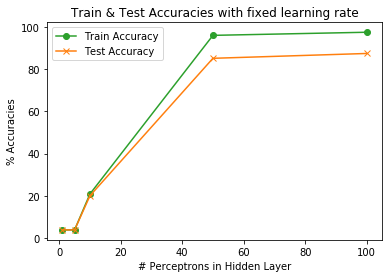

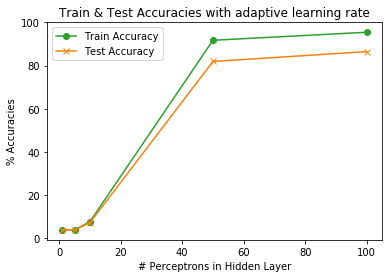

In [143]:
plotAccuracies(lr_type = "fixed")
plotAccuracies(lr_type = "adaptive")

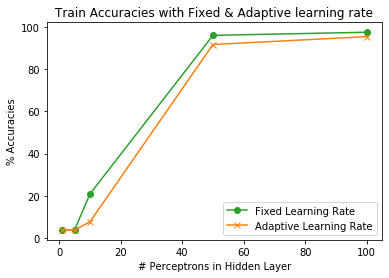

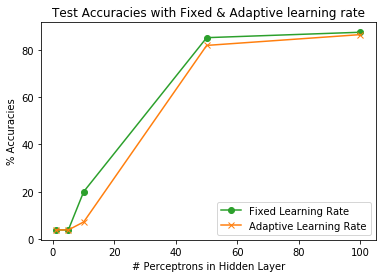

In [154]:
plotAccuraciesComparision(data_type = "Train")
plotAccuraciesComparision(data_type = "Test")

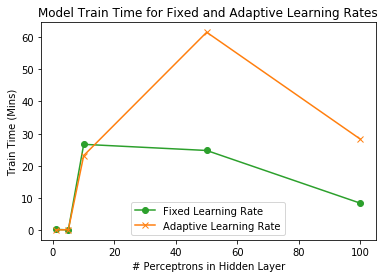

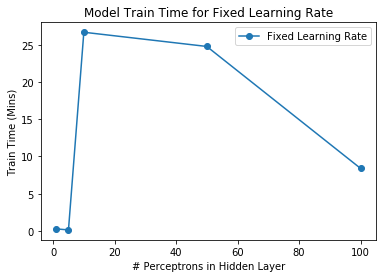

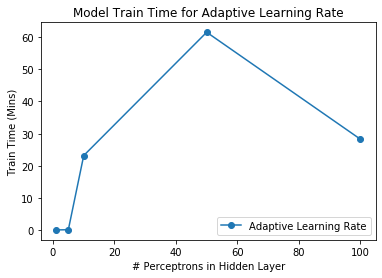

In [158]:
plotTrainingTime()

In [129]:
def prediction(net, data, lbl):
    net.forwardFeed(data)
    outputs = net.layers[-1].output
    prediction = []
    for x in outputs:
        prediction.append(np.argmax(x))
    print(len(prediction), lbl.shape)
    accu_score = accuracy_score(lbl, prediction)
    print("Accuracy= ",accu_score)
prediction(neu_net, DTest, LabelsTest)

6500 (6500,)
Accuracy=  0.818923076923077


In [42]:
#for layer in neu_net.layers:
neu_net.forwardFeed(DTrain)
layer = neu_net.layers[-1]
for x in layer.output:
    print(np.amax(x))

0.9574965608808638
0.9598815182687106
0.9715072274530074
0.9947492490063464
0.959231388849291
0.9951440532587261
0.9809080617540177
0.9896246420973588
0.9153667210798168
0.992969753786681
0.9981044205572329
0.9355051887869412
0.9921349059892898
0.8823832200701214
0.9954868734068857
0.9940287842713526
0.9633531984936602
0.9963201427429993
0.9986275947143104
0.9653733933674434
0.9831577060576818
0.9588271222967996
0.9885018466661959
0.9990097842251427
0.9968026686284973
0.15885816189179364
0.9984893360591487
0.9283550233150702
0.9772795114396674
0.18389109737959275
0.2966082890310889
0.9931268589655947
0.751149067838081
0.9779459661374764
0.9964525546707461
0.9962631601447332
0.964698660839957
0.9963507660837544
0.9454058016404548
0.9995183472195573
0.9895941014584699
0.9825490783943021
0.9786388723204049
0.9614511678844883
0.9790501218740826
0.9957116121237091
0.9734377517215334
0.9965624438421532
0.9257140835452006
0.7261369217014743
0.8848640039233276
0.9461636943625348
0.984298402532

0.999549824940158
0.9583165958115486
0.9866799711850157
0.9954757874882166
0.8209919122328607
0.9935633035149655
0.9622080587604429
0.9910711052765916
0.9657536665348124
0.9964553862764024
0.9930448563627859
0.9868115532092695
0.9775910383090698
0.9926318453886384
0.9588293652156331
0.11629515464341009
0.9973019900538026
0.9765974114038265
0.9289610468336756
0.9990300554766935
0.9784420205356531
0.9992865914888858
0.9870485008783597
0.9923298893538249
0.9515923003605694
0.9901749763772063
0.9275205299560039
0.984771314468094
0.9953843260607674
0.9364266426922657
0.15062100783431842
0.970622338008795
0.9983766533262356
0.9992176820538983
0.9937878321442973
0.9829620525574917
0.1135654778456229
0.960144465443138
0.989353530739217
0.8639473999625259
0.984598265674392
0.9342789374776173
0.9417658989267004
0.9866412731706173
0.9807626927990905
0.9422606103428718
0.996246208029141
0.9889280225572937
0.13188133230167118
0.9959688321900405
0.9930194064888934
0.10964032975712434
0.9974128300291

0.9990731454391749
0.9659882618966247
0.9960074275516607
0.941788362156794
0.8806603415516308
0.999433608616907
0.988799226310162
0.997724836239478
0.9907051255512678
0.9839870449749578
0.9588366385584915
0.9552442550777445
0.9982839733544133
0.9806800032018735
0.9189100100263156
0.9955767092835648
0.9786175599454197
0.9905559554797658
0.9926653951295042
0.9980756842379509
0.9974335310452737
0.9912363553624038
0.9664221347891023
0.986556859762788
0.9952408747688375
0.9317324055505014
0.9973078922339078
0.9872200716305767
0.9822929461817455
0.99219579397182
0.9981799922028751
0.9602638252823765
0.6544153487944524
0.9974157581490356
0.9816560264393934
0.9907132410282733
0.9788975153587594
0.08770192157611748
0.9751405426417964
0.9959457597321821
0.9900720570347098
0.9953509652393753
0.989150216773803
0.9813945340048795
0.9867300254350235
0.9779206639544359
0.9921601739304261
0.963887620438727
0.8609685539427605
0.9942537413224118
0.8665775140538479
0.8968082607672817
0.9981886375041656
0

0.9990730949771347
0.9880146117303191
0.993122656293516
0.913783075662218
0.9956693485377958
0.9268771624532435
0.9839268507685366
0.9432632973168988
0.987844288611153
0.9835620944720079
0.9378926014857123
0.9899260613644782
0.9860620751987377
0.9979369889013134
0.9798408597390246
0.9971340913261371
0.9774468953257035
0.9786680200654018
0.9982189957748637
0.991927029117033
0.9976569913295753
0.9990289910413533
0.9991257133261955
0.9714317418470496
0.9081945754896817
0.9922634270983182
0.9961309183425257
0.9835067857733272
0.9985426801314583
0.9926570391636708
0.9953906774275059
0.9746651351143472
0.9885423944649201
0.9994663548520822
0.9970000904155318
0.9965715090968659
0.9961422379580201
0.9730295350302943
0.9979966371980692
0.9986809752691265
0.9087113161341686
0.9961554614076766
0.9937275591396599
0.9950097849512352
0.9578521180319195
0.9824494865380219
0.9283690092877047
0.9966006760418895
0.9992164773293071
0.8899609913439677
0.9234809554164983
0.9896968321133269
0.99930723195611

0.9941010586540802
0.9175114092848669
0.9989185793534685
0.9601130687830255
0.9823969046675953
0.987509353371624
0.9750284497589784
0.7670713559762049
0.9799040026417628
0.9964602382043547
0.9805162162706789
0.9956329099297624
0.8233656894079155
0.9981591063364792
0.9871884825698406
0.9816209481238578
0.9864141583558487
0.955979372506749
0.9859988800344116
0.13401774928409046
0.9670118763841975
0.9982360549225116
0.9405168162505936
0.8449630772019121
0.9794755673928973
0.9970493614065721
0.9968950051556178
0.982654119449989
0.9793043544976379
0.9889850716476672
0.9835255763956517
0.9909452747110228
0.9726749526137094
0.9902044169400354
0.9822967651719073
0.9397496266431167
0.9953781176104015
0.98528014196879
0.9734367308613266
0.9905773548256758
0.9646235470298518
0.9971084881522744
0.9923935855161122
0.12179167227945877
0.989153750862932
0.9945707486649417
0.9783773448864858
0.9861900023542787
0.9955981666192218
0.9976374886402096
0.955883063250773
0.9946648338071928
0.991837933931166

0.9686872309284182
0.8865556418429398
0.8421657174750894
0.9970551624769926
0.9792267153941402
0.9312107936653224
0.988709275220367
0.9963267467649028
0.9732449156443563
0.9864819928941603
0.9949181214461918
0.9965197486381431
0.9997733337096967
0.8756943919813384
0.9962719634903471
0.9238871427957651
0.9773767457037114
0.991140746696942
0.8940525325226162
0.9524510235966921
0.9923652245801021
0.9126131870792538
0.9070937382745753
0.9952065661250453
0.9695186382711987
0.9965114926029761
0.9784354149918646
0.9956690147474752
0.9122721297761082
0.9962198598709128
0.9911658624517655
0.8704317268791218
0.9784968695377609
0.990981650400374
0.8865787515205397
0.9998296959803278
0.9777199672321042
0.9722076073938327
0.8954239769382363
0.9910896045165802
0.8930668742308524
0.9965093356471786
0.9707433237211693
0.9854465179162929
0.9978877644562963
0.9602459175248316
0.9528152054039902
0.9937953236224109
0.9771113624995028
0.9841301988728897
0.9994048730758934
0.9964187398556577
0.9956430318002

0.9762901335854246
0.993589867082027
0.9574000276922102
0.9969315201705081
0.9991391317326004
0.9584254482676492
0.9951239576899128
0.9802289002909856
0.9978646563943655
0.902844338024158
0.9204393974175842
0.9945744072795282
0.9965749409426169
0.9375218140509752
0.9875216340342119
0.9991951348714067
0.9980250314253161
0.9658595945943336
0.9736647223655758
0.9918174628168372
0.9417407567787459
0.9657012221860442
0.9901613272146944
0.9990725767218077
0.9623033604198427
0.9968760753243208
0.9993409955385026
0.892975828412651
0.9997083658579045
0.9184412237364045
0.9943538326342044
0.9898749745492691
0.9988382685344023
0.9368694817743144
0.9873821176357023
0.9706635020373873
0.9947454652241793
0.9982184234180854
0.6395931095227583
0.9639812667537268
0.8986431779014199
0.9798461901971136
0.9628626851285655
0.9875487116088311
0.9947461095425882
0.9132807678997429
0.9789439750042535
0.9989594740376052
0.9228554429165257
0.9903048483638562
0.6737868773195533
0.9126625549786438
0.9348472873365

0.9986757929158966
0.853851700257652
0.9933491723744412
0.9829139561242378
0.9757022817551907
0.9991522076246412
0.9038041678289573
0.8806411583441285
0.9973150267298406
0.9616134475577885
0.9954387725977478
0.9989809002648457
0.9451672643946626
0.9731763112716442
0.995935513310286
0.9975015278677118
0.9882740100824497
0.9589621454708124
0.8583023366420102
0.9838073875209323
0.9984758837364832
0.9397340978627425
0.9991475732368363
0.9301903966937753
0.9967872370284937
0.9557986563083808
0.9798198309730096
0.9958829513867713
0.952778940767526
0.9592058350565105
0.9026990913820084
0.9982497216892229
0.9957908402069714
0.9465362633443595
0.9815527459970046
0.981041591196775
0.9991915903044234
0.9889350198847466
0.6912174018282885
0.9424782372558494
0.9891607280232153
0.9984287212993815
0.9764646827743871
0.9898812422708924
0.9982099113642267
0.9837217879124529
0.9926662702876371
0.9901415483684962
0.9865095781577046
0.8710593952428433
0.9628263936077361
0.9955358433074734
0.99741369254876

0.9681237069858017
0.9030208255173512
0.9949707165661585
0.9316894094374559
0.999925469024291
0.9590455442898838
0.9969858588589979
0.9990838721116875
0.7539766940487614
0.9231015280154663
0.9966122888297829
0.9889047588763001
0.9898226453238298
0.3709102484704525
0.9988979244179339
0.7270107433816547
0.19606458605886548
0.16400794122895607
0.07665897738860282
0.05990250776918898
0.996570019240485
0.992515140099873
0.9245875291576124
0.9877528230939646
0.9891253546709208
0.9949599831511902
0.9927902520366166
0.9750683777419984
0.9893930525009575
0.6643527596049753
0.9462455529816627
0.996131648813837
0.9387047744017013
0.9926591391925069
0.9969796736543713
0.9289258560582272
0.9962308430245552
0.9663702286454984
0.9882633118085904
0.9869549553495592
0.9614995935319258
0.15417469885992616
0.9813887837510186
0.9535742245070195
0.9950218261947368
0.998045272855485
0.9719286997702826
0.9796425211525311
0.947937776499004
0.9839167075669587
0.9539194247224015
0.9940495737245869
0.20279554391

0.9632608445295217
0.9958370242106362
0.4129675851106628
0.9999041384302134
0.6115725780751997
0.9502094765933783
0.9941902502049107
0.9799596689766649
0.959199332439704
0.9926051078997304
0.9979116971319565
0.9984384040074931
0.894048703345617
0.9014036282217083
0.9834221093148212
0.7935252362851982
0.992191784779155
0.9991939995470803
0.9868080656822062
0.9816331437318814
0.9587417406752266
0.04830716319115995
0.9277416618514382
0.8567135785591287
0.9879198511925565
0.9532210456159614
0.9807989545000022
0.9974854393798459
0.9991143555835538
0.990885578674119
0.5213021799922649
0.9866264029095814
0.9857578169497314
0.9992359997852605
0.750224277264848
0.9970312931834135
0.9969680735480051
0.9924929204977738
0.9918205558025384
0.9973981844213454
0.9915893004597929
0.952849860065699
0.9501034112527961
0.9997070208357282
0.9880485790411746
0.9897176572232548
0.98783043655464
0.9955015604465235
0.9960835699074824
0.9784309942076175
0.9951811862487883
0.9814291386026751
0.9972627402063157


In [119]:
for layer in neu_net.layers:
    print(layer.weights[:20])

[[-0.00832659  0.00190687 -0.00842764 ... -0.00967168 -0.0031852
  -0.00788877]
 [-0.00374876 -0.00069765 -0.0061328  ... -0.00244248 -0.0087808
  -0.00771211]
 [-0.00667095 -0.00815066 -0.01345256 ... -0.01057041 -0.0077736
   0.00190876]
 ...
 [ 0.00256856 -0.00751513  0.00736599 ... -0.00118116  0.00596706
  -0.0104013 ]
 [-0.00783131  0.00732662 -0.01460057 ... -0.00683932 -0.0116679
  -0.01343878]
 [ 0.00912219 -0.00200028 -0.00287532 ... -0.00519311 -0.00377922
  -0.01066432]]
[[-6.21032252e-04 -2.59239947e-03 -9.56368099e-05 ...  4.04582347e-03
  -8.26309954e-03 -3.43393701e-03]
 [ 5.08014315e-03 -4.74109666e-03 -6.41263331e-03 ... -1.10355792e-02
  -4.81996743e-04  2.79888462e-03]
 [-2.70722512e-03 -4.15923573e-03 -6.37366078e-03 ... -5.13806128e-03
  -9.67501533e-03 -1.74358453e-02]
 ...
 [ 1.49045161e-03 -4.46847479e-03 -3.78802230e-04 ... -4.47119289e-03
  -8.11694549e-04 -4.70854976e-03]
 [-1.13828749e-03 -7.95371213e-04 -4.81715724e-03 ... -6.36309491e-03
  -1.28351958e-02

In [131]:
np.random.normal(0,0.00005, 10).reshape(5,2)

array([[-1.47126082e-05, -2.68311825e-05],
       [ 2.41010176e-05, -2.41943726e-06],
       [ 9.56130143e-05,  9.20987937e-06],
       [-4.36892046e-05, -1.35455218e-04],
       [-3.05009008e-05, -1.62088758e-07]])

In [53]:
x = 0404.0
str(int(x))

'404'